# Solar panel plant: Forecasting generated potency


This notebook aims to demonstrate the usage of two options to forecast generated potency by a solar panel plant, using weather variables as predictors. \
It is taken as assumptions that ---, this study tries to demonstrate that the hypothesis --- is feaseble.

#### Terms:

- P:    Generated potency

- G:    Solar irradiance

- GHI:  Global horizontal irradiance

- ambT: Ambient temperature 

- panT: Painel temperature


#### Evaluation

Evaluation metrics recommended by studies and reports in the field of solar PV output forecasting[3][4]:
- Root Mean SquareError (RMSE):
- Mean absolute error (MAE):
- Mean Bias Error (MBE): not absolute, error with signal. Gives information regarding whether the model has a tendency to over or under forecast.

#### Notes:

"Those ideal conditions require that the ambient temperature never rise above 77°F (25°C) to maintain a conservative 104°F (40°C) panel or no greater than 95°F (35°C) for an allowable 122°F (50°C) panel air temperature." [1]


"For comparison purposes, keeping in mind the time for model fitting, 100 epochs was considered to be sufficient for all models." [2]

[1] Available at https://www.plantservices.com/articles/2010/03paneltemperatureincreases/
[2] Suresh, V., Janik, P., Rezmer, J., & Leonowicz, Z. (2020). Forecasting solar PV output using convolutional neural networks with a sliding window algorithm. Energies, 13(3). https://doi.org/10.3390/en13030723 \
[3] Yang, D.; Kleissl, J.; Gueymard, C.A.; Pedro, H.T.C.; Coimbra, C.F.M. History and trends in solar irradiance and PV power forecasting: A preliminary assessment and review using text mining. Sol. Energy 2018, 168, 60–101. [CrossRef] \
[4] Luukkonen, P.; Bateman, P.; Hiscock, J.; Poissant, Y.; Dignard-Bailey, L. International Energy Agency Co-Operative Programme on Photovoltaic Power Systems. 2013. Available online: http://www.cansia.ca/ sites/default/files/201306_cansia_2012_pvps_country_report_long.pdf (accessed on 29 October 2019).

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from time import time
from datetime import datetime
%matplotlib inline 

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 999)

path = 'data/atlas.csv'
df = pd.read_csv(path, encoding='utf-8', header=0, sep=',', decimal=".")
df.ts = df.ts.astype('datetime64')
df = df.set_index('ts')

In [5]:
target = ['P'] 
predictors = [x for x in list(df.columns) if x not in set(target)]

print('Target: ', target)
print('Predictors: ', predictors)
df.describe().transpose()

Target:  ['P']
Predictors:  ['g', 'ghi', 'ambT', 'panT']


count         mean          std     min        25%        50%  \
P     105030.0  3429.562496  4958.478342 -85.458 -25.906000  -3.807892   
g     105030.0   261.051061   378.055364   0.001   0.368000   2.648000   
ghi   105030.0   207.886747   314.143268   0.001   0.498000   3.315500   
ambT  105030.0    18.234091     7.123792   0.002  13.560250  19.963000   
panT  105030.0    23.392345    16.281344   0.001  11.637125  18.992000   

              75%        max  
P     7055.946250  16150.568  
g      527.341625   1198.730  
ghi    350.494750   1199.380  
ambT    21.763750     41.637  
panT    33.845625     69.005

In [6]:
# Normalize
df[predictors] = df[predictors]/df[predictors].max()

It is common to define CNN layers in groups of two in order to give the model a good chance of learning features from the input data
    https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

#### CNN-1D

- Input: ['g','ghi','ambT','panT']
- Output: ['P']
- Data within the range of [0,1]
- Convolutional layer consisting of
 - 4 filters for 4 parameters
 - Activation: Rectified Linear Activation Function (RLAF, g(z) = max {0, z})
- Max pooling layer
- Flattening layer
- Dense neural network connection: Regular neural network with a non-linear activation function.
- Optimization algorithm: Adam
- Loss: ---

12 time steps of each parallel series are provided as input to the model. \
The model associates this with the value in the output series at the 12th time step.

In [65]:
import keras
from time import time
from datetime import datetime
from keras.layers import Conv1D, MaxPooling1D, LSTM, Flatten, Dense

kernel_size = 3
batch = 12 # number of timesteps per sample
epochs = 100
activation = 'relu'
n_filters = 4
n_features = len(predictors)
optimizer='adam'
loss='mse'

# Shape of input: (n_samples, batch, n_features) (n_outputs,)

The function below was adapted from: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [8]:
# split a multivariate sequence into samples
def split_sequences(sequences, predictors, target, n_steps):
    
    predictors = sequences[predictors].values.tolist()
    target = sequences[target].values.tolist()
    
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x = predictors[i:end_ix]
        seq_y = target[end_ix-1]
        X.append(seq_x)
        y.append(seq_y)
        
    X = np.asarray(X)
    y = np.asarray(y)
    y = y.reshape(-1,)
    return X, y

In [ ]:
X = df[predictors].values
y = df[target].values

n_pca = 2

pca = PCA(n_components=n_pca)
pca = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(pca, y, test_size=0.30, random_state=40)

print(X_train.shape, X_test.shape)

In [10]:
#       datetime(yyyy, m, d, h, m, s)
split = datetime(2021, 1, 1, 0, 0, 0)

df_train = df[df.index < split]
df_test = df[df.index >= split]

X_train, y_train = split_sequences(df_train, predictors, target, batch)
X_test, y_test   = split_sequences(df_test, predictors, target, batch)

df_train = df_train[batch-1:]
df_test = df_test[batch-1:]

n_samples = len(X_train) # This number is a function of len(X_train) and 'batch'
n_outputs = len(y_train)

In [15]:
ts_min = np.min(df_train.index)
ts_max = np.max(df_train.index)
ts_min, ts_max

msg = "Train database from/to: \n{}\n{}\n"
tf = "%d/%m/%Y (%H:%M)"
print(msg.format(ts_min.strftime(tf), ts_max.strftime(tf)))

ts_min = np.min(df_test.index)
ts_max = np.max(df_test.index)
ts_min, ts_max

msg = "Test database from/to: \n{}\n{}\n"
tf = "%d/%m/%Y (%H:%M)"
print(msg.format(ts_min.strftime(tf), ts_max.strftime(tf)))

Train database from/to: 
01/06/2020 (08:30)
31/12/2020 (23:55)

Test database from/to: 
01/01/2021 (00:55)
01/06/2021 (00:00)



In [16]:
# define model
model = keras.Sequential()
model.add(Conv1D(filters=n_filters, kernel_size=kernel_size, activation=activation, input_shape=(batch, n_features)))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=optimizer, loss=loss)

In [19]:
start1 = time()
model.fit(X_train, y_train, epochs=epochs, verbose=0)
runtime = (time()-start1)
print('1D CNN fitting runtime: {:02.0f}:{:02.0f}s'.format(*divmod(runtime, 60)))

# predictions
cnn1d_train_pred = model.predict(X_train, verbose=0)
cnn1d_test_pred = model.predict(X_test, verbose=0)

1D CNN fitting runtime: 01:32s


In [55]:
def plot_series(df, column, start, end):
    """
    start: Timestamp('YYYY-MM-DD hh:mm:ss')
    end:  Timestamp('YYYY-MM-DD hh:mm:ss')
    """
    #start_filter = (df.index.year > start.year) & (df.index.month > start.month) & (df.index.day > start.day)
    #end_filter   = (df.index.year < end.year) & (df.index.month < end.month) & (df.index.day < end.day)
    
    ts_min = np.min(df.index)
    ts_max = np.max(df.index)
    
    if (start < ts_min) | (end > ts_max) | (end < start):
        print('Escolha de \'start\' e \'stop\' equivocada!')
        return
    
    start_filter = (df.index >= start)
    end_filter   = (df.index < end)
    df_plot = df[start_filter & end_filter]
    
    plt.figure(figsize=(20,8))
    plt.rcParams.update({'font.size': 10})
    for i in column:
        plt.plot_date(df_plot.index, df_plot[i], linestyle ='solid', ms=.5, label=i)
        plt.legend(loc="upper left")
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.suptitle("Plot of: {} \n (N = {}) \n from {} \n to {} \n ".format(column,  df_plot.shape[0], start.strftime("%d %b, %Y (%H:%M)"), end.strftime("%d %b, %Y (%H:%M)")))
    plt.show()

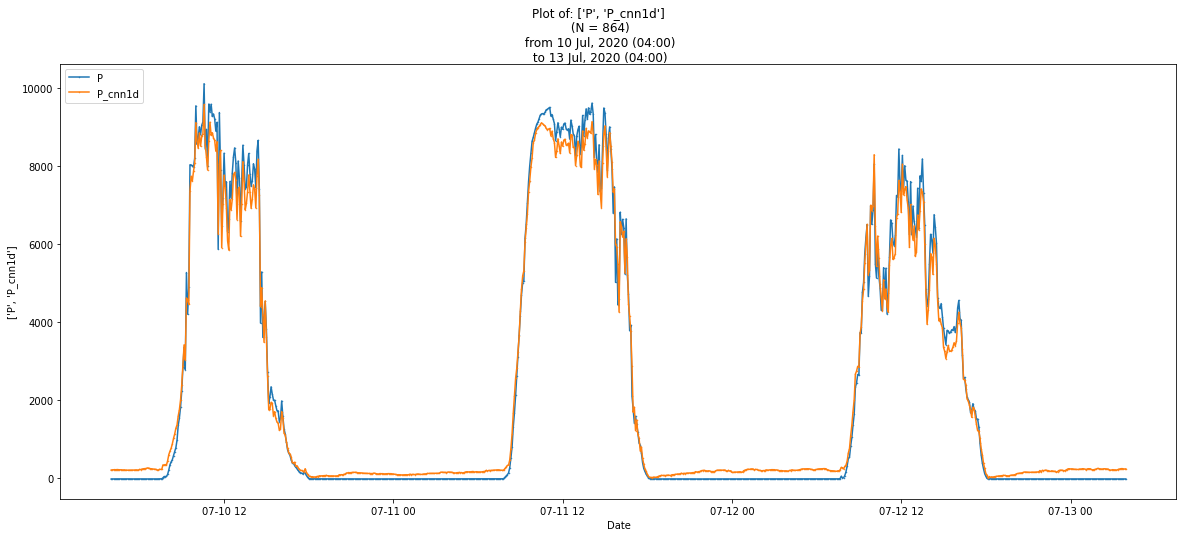

In [56]:
"""
    Train database from/to: 
    01/06/2020 (07:35)
    31/12/2020 (23:55)
"""

#       datetime(yyyy, m, d, h, m, s)
start = datetime(2020, 7, 10, 4, 0, 0)
end   = datetime(2020, 7, 13, 4, 0, 0)

#start = np.min(df_train.index)
#end = np.max(df_train.index)

results_train = df_train
results_train['P_cnn1d'] = cnn1d_train_pred

plot_series(results_train, ['P','P_cnn1d'], start, end)

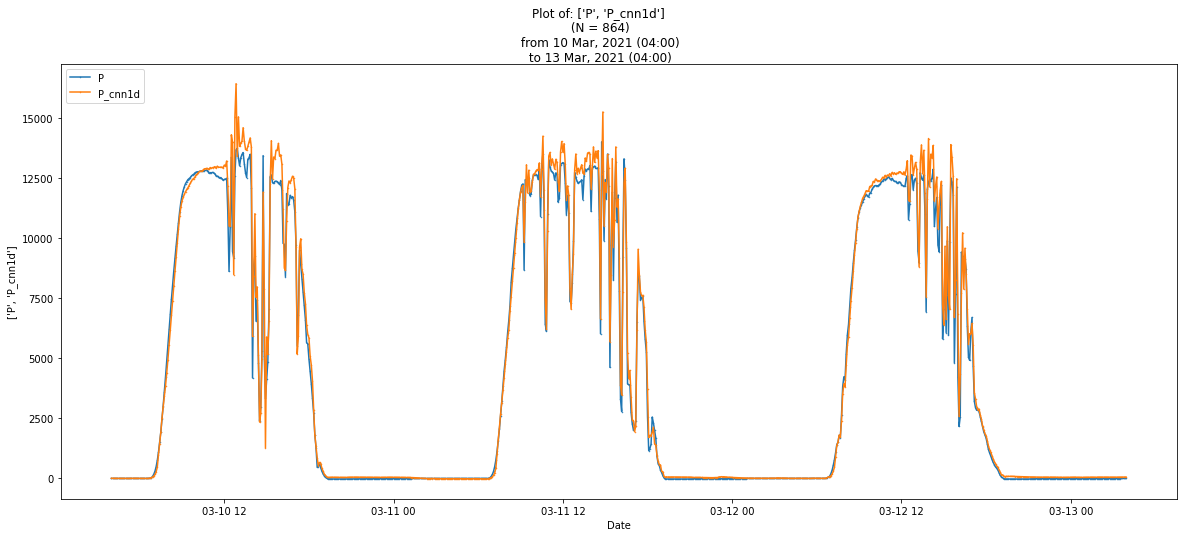

In [57]:
"""
    Test database from/to: 
    01/01/2021 (00:00)
    01/06/2021 (00:00)
"""

#       datetime(yyyy, m, d, h, m, s)
start = datetime(2021, 3, 10, 4, 0, 0)
end   = datetime(2021, 3, 13, 4, 0, 0)

#start = np.min(df_test.index)
#end = np.max(df_test.index)

results_test = df_test
results_test['P_cnn1d'] = cnn1d_test_pred

plot_series(results_test, ['P','P_cnn1d'], start, end)

In [58]:
def print_result(y_train, train_pred, y_test, test_pred):
    plt.rcParams.update({'font.size': 15})
    fig, axes = plt.subplots(1,2, figsize=(20,8));
    fig.suptitle("Actual vs. Predictions");

    axes[0].scatter(y_train, train_pred, alpha=0.1, s=10);
    axes[0].set_title("Train")
    axes[0].set_xlabel("Actual");
    axes[0].set_ylabel("Predictions");

    axes[1].scatter(y_test, test_pred, alpha=0.1, s=10);
    axes[1].set_title("Test")
    axes[1].set_xlabel("Actual");
    axes[1].set_ylabel("Predictions");

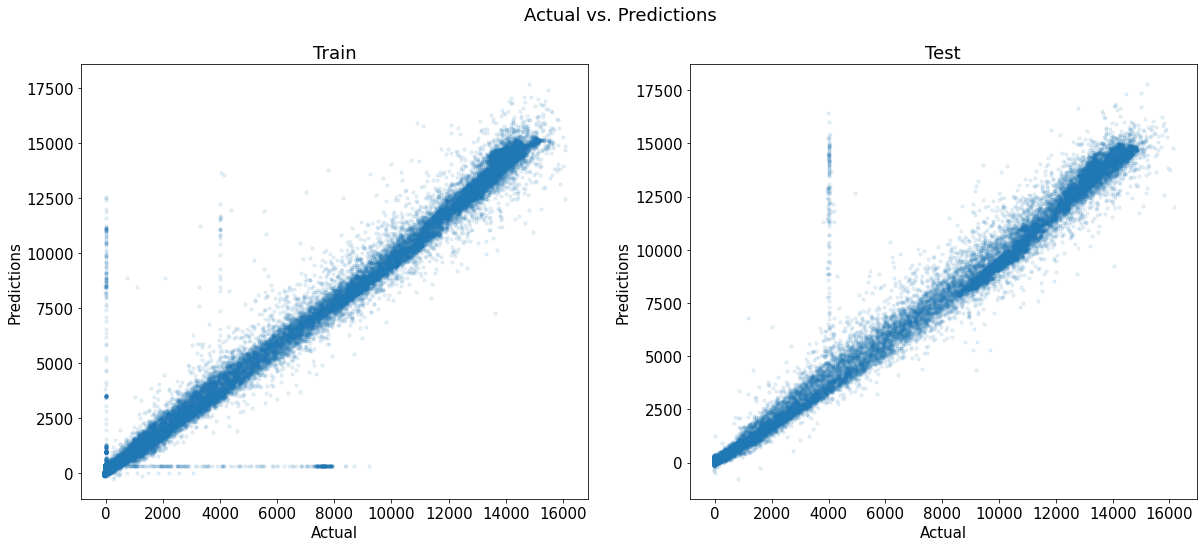

In [59]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

print_result(y_train, cnn1d_train_pred, y_test, cnn1d_test_pred)

In [61]:
cnn1d_train_mse = np.sqrt(mean_squared_error(y_train, cnn1d_train_pred))
cnn1d_train_mae = mean_absolute_error(y_train, cnn1d_train_pred)
cnn1d_train_r2  = r2data_score(y_train, cnn1d_train_pred)

cnn1d_test_mse = np.sqrt(mean_squared_error(y_test, cnn1d_test_pred))
cnn1d_test_mae = mean_absolute_error(y_test, cnn1d_test_pred)
cnn1d_test_r2  = r2_score(y_test, cnn1d_test_pred)

In [62]:
results = {'MSE (train)':[],
           'MAE (train)':[],
           'R2  (train)':[],
           'MSE (test) ':[],
           'MAE (test) ':[],
           'R2  (test) ':[]}
results = pd.DataFrame(results).transpose()
results['CNN-1D'] = [cnn1d_train_mse, cnn1d_train_mae, cnn1d_train_r2, cnn1d_test_mse, cnn1d_test_mae, cnn1d_test_r2]

In [63]:
results

CNN-1D
MSE (train)  660.992069
MAE (train)  268.042682
R2  (train)    0.981955
MSE (test)   633.498407
MAE (test)   269.713793
R2  (test)     0.984005

#### CNN-LSTM (recurrent neural network)

- Input: ['g','ghi','ambT','panT']
- Output: ['P']
- Data within the range of [0,1]
- Convolutional layer consisting of
 - 4 filters for 4 parameters
 - Activation: Rectified Linear Activation Function (RLAF, g(z) = max {0, z})
- Max pooling layer
- Flattening layer
- **Long Short-Term Memory layer**
- Dense neural network connection: Regular neural network with a non-linear activation function.
- Optimization algorithm: Adam
- Loss: ---

12 time steps of each parallel series are provided as input to the model. \
The model associates this with the value in the output series at the 12th time step.

In [ ]:
##### define model
lstm = keras.Sequential()
lstm.add(Conv1D(n_filters, kernel_size=kernel_size, activation=activation, input_shape=(batch, n_features)))
lstm.add(MaxPooling1D())
lstm.add(Flatten())
lstm.add(LSTM(batch, input_shape=(batch, n_features)))
lstm.add(Dense(50, activation='relu'))
lstm.add(Dense(1))
lstm.compile(optimizer=optimizer, loss=loss)

In [ ]:
start1 = time()
lstm.fit(X_train, y_train, epochs=epochs, verbose=0)
runtime = (time()-start1)
print('LSTM CNN fitting runtime: {:02.0f}:{:02.0f}s'.format(*divmod(runtime, 60)))

# predictions
lstm_train_pred = model.predict(X_train, verbose=0)
lstm_test_pred = model.predict(X_test, verbose=0)

In [ ]:
print_result(y_train, cnn1d_train_pred, y_test, cnn1d_test_pred)

In [ ]:
cnn1d_train_mse = np.sqrt(mean_squared_error(y_train, cnn1d_train_pred))
cnn1d_train_mae = mean_absolute_error(y_train, cnn1d_train_pred)
cnn1d_train_r2  = r2data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABLQAAAIjCAYAAAAa6EJiAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy86wFpkAAAACXBIWXMAAAsTAAALEwEAmpwYAAEAAElEQVR4nOz9eZxla1bQef/WnvcZY8zx3pu3LlW3JgoBUVt9FQSHBrUdGl4UBWlpERV5AYdXeUGhHRBtFVpULG0VUdsBECwbmsEB+QgIFBZlUcOdKvPenCJjOvMen/28f+xzIk9GRkRGZEZkRmSu7+cTn7znnH322XufuHHWWc961iPWWpRSSimllFJKKaWUOiucJ30ASimllFJKKaWUUkodhSa0lFJKKaWUUkoppdSZogktpZRSSimllFJKKXWmaEJLKaWUUkoppZRSSp0pmtBSSimllFJKKaWUUmeKJrSUUkoppZRSSiml1JmiCS2llFJKPZNE5KqI/KcnfRxniYh8uYhYEfmcg+47qddSSimllJrRhJZSSimljkxEFkUkmSYcvvQR9/U5IvLNIrJwTIf3VJleGzv3U4nIloj8mIj8tid9fI9C33ullFJKPSxNaCmllFLqYfw+IAQ+CfzBR9zX5wB/Hlh4xP087f4c8KXU1/u7gM8EPiAiX/JEjwq+B4iB//wQz/0c9n/vH2W/SimllHrKeU/6AJRSSil1Jn0F8B+BHwS+XUResta+8YSP6Wn3w9ban5/dEJHvA34e+P8B/3y/J4lI21o7PKmDstYawJyV/SqllFLq6aAVWkoppZQ6EhH5TODTge+mTqSU7FOlJSKBiPxpEfmQiExEpC8iPy8iXz19/B9TV+gAfHJuWt03zx4XEbvPvu30+fP3/VER+VERuSEiuYjcEpF/KiIvPuS5LohIKiLfv8/j3zo9jk+f3l4Skb8pIq9Pn7cpIh8UkT/1MK9/EGvtB4FN4O3T135xdu1E5Iunr5sAf2vueH/j9Pr0psf3YRH5qn3O7Q+JyMdFJBOR10TkawHZY7s9e10dw3u/335XRORvi8hb0/f4rent5X2O63NF5E9O35NMRF4RkT+wx3n8VhH5CRHZmE6nfVNEvl9EXt73TVBKKaXUE6MVWkoppZQ6qq8ARsD3WWvHIvLvgD8gIn/OWlvNNhKRAPgR6mllPwr8UyAF3gf8buA7gb8HdIDfBXwdsDF9+ocf8tj+JPAzwP8BbAGfCvyvwOeKyPustZtH2Zm1tici/xb4HSKyZK3dmjs/h3rq5YettR+a3v2vgV9PPSXww9RT5t5NfQ3+2kOe055EZAVYBG7veuh3Al8D/N3pcQym23/l9PbPAH8JGAO/Cfi7IvIp1tqdpNs0efU3gV8EvgFoUF/bO4c8thN570WkC/wUdRLvHwK/AHwG8Eeo3+NfuUc12l+mfh/+HpBNt/3HIvKatfa/TPf72cC/BT4CfCvQAy4Bv3H6Wq8c5ryVUkop9fhoQksppZRShyYiEfAlTJNZ07u/mzop8VuAH57b/GupExrfaq39hl37cQCstT8tIh+ePv8HrLVXH/EQ3zd3XLPX+rfAj1Mn4v7qQ+zzu4EvAn4P8Hfm7v8NwPPAt09fpwt8LvB3rbV//CFe50G60ySWB7xMnahxgH+ya7v3Ap9mrf3Y7A4RuUid5PsX1tr5nlt/R0S+A/h6Efm71to3pg3a/xLwMeDXWGsn0338I+DjhzzWr+Vk3vs/DbwD+GPW2p33QkQ+RJ0k+9PAN+16Tgj8CmttPt32e4E3gK8G/st0m99BfS1/k7V2Pmn3Fw5xTEoppZR6AnTKoVJKKaWO4ndTN/D+7rn7fghY5/5ph78P2Ab+t907ma/kOk6zZJaIOCIySwD9ItAHftVD7vZHgDXgy3bd/2XU0y3/2fR2Ql0B9KsedorjA/w49XW+BfwEdWXS3+D+BM7/PZ/MmvpC6sTO/zmdsrfzA3yAOib8jdNtfzN1RdbfniWzAKy117l7rg9yUu/976K+Bu/fdf/fm97/u/Z4zt+ZJbOmr3+DuuLqHXPb9Kf//s8iogO+Siml1BmgCS2llFJKHcVXUCcOrovI20Xk7cAV6mll/9M0QTLzDuDj1tr0cR3ctF/Sf6KeTtebHus60KWenndk1tpZ0upXzfopiUiTOrn3o9batel2OXVl0qdS94T6JRH5WyLyeY9yTnP+GPUUwc8DfjmwYq39E9Pjm7fX9Lh3T/+dJcXmf35s+tj56b8vTf/dqxrro4c81pN6798GfGL3OU9vv8LdY5+312IFm8B8z63vBP4bdQXeloj8kIh8jYisHs9hK6WUUuq46QiUUkoppQ5FRN5GPc1O2L+n0O9nOgXvmOzXEP6+GEZEfgV1Yu014M8An6SumrLAv+DRBvL+CfD11FVZ30idzGpxb6Ua1trvEpEfBH4r8NnUlVFfLSL/0lr7ex7h9QF+dn6VwwNM9rhv1sz9y6grvPbytK5Sud9KiTsN7q21m9Pfn19HnTT89dQ9xL5FRL7AWvvTJ3+YSimllDoKTWgppZRS6rD+F+okwB+irn7a7S9STzv89untV4B3iUhorc0O2O+eSaupLahXD5xvyM7elThfArjA51trPzm7c1pN9VDVWTsHaO0visgvAr9fRL6JOjHUo24kvnvbW8A/AP6BiLjA9wC/V0T+urX25x7lOB7Bq9N/N6y1P/6AbWeJrXcB/37XY+855Osdx3u/37G9U0S8+SqtaYLzZR4hKWetNcB/mv4gIp8GfJA6gflbH3a/SimllDoZOuVQKaWUUg80beT95cB/t9b+A2vt9+7+Af4v4H3TSheop+ktUicEdu9P5m6Opv8u7fHSs0qw37jr/j+xx7azShzZdf83cDwxz3dTT6/8Eurm7/9yfkqdiDREpDH/hGmSZLZq39Lctp8iIu86hmM6rH9F3d/rW0Qk3v3gtN9YOL35Y9SVbX9s/nxE5Dnqcz+M43jv9/IDwCr1ypXz/tD0/n9zyP3sPqaVPe7+OPV1OOyxKaWUUuox0gotpZRSSh3Gb6Ze0e//PGCb7wO+mbrP1s8B3wH8duAb56YDptSr8L2Tu0mqn5n++20i8s+m23zEWvsR6iTZXwbeP00AbQH/I7BXAuLfAF8H/JCIvB/IqaePfRqwcfRTvs8/o14l8e9QJ8i+e9fjLwM/ISL/BvgIdVP0dwN/hHr640/ObfvvqZNju5NvJ8Jae11E/gh15djHROR7gGvUSaD3Ab+TuvrqqrV2e1qF9r8DPyUi/4S6SfxXUVd6fcYhXvI43vu9/FXqFSf/toh8JnXfq8+g/p37BA+3iiXA358m7H6U+rrEwBcDbe5fRVIppZRSp4AmtJRSSil1GF8x/ff799vAWvsREXkF+D0i8nXW2kREfjN1NdWXUCemUuqkyD+ae95/EZH/L3XC5O9TxyffQp3YGIjIF1Cv5vcN1BU930/dq2t71+v/FxH5n6lX/fsL1NU1P07dy+o/P+L5Y629IyL/D/DbgFf36Kv0FvAPqfuM/U7qVQVvTM/p2+ZXDHwSrLX/aPr+/EngD1OvVrlBnQj6JuD23LZ/XURG1H3DvpX63P536tUA/+EhXit/1Pd+n/32ReTXTrf5n6inwa4B3wX8eWvt8JCXY7fvoa5A/APUSb4BdQP8L7TWft9D7lMppZRSJ0isPWrrAqWUUkoppZRSSimlnhztoaWUUkoppZRSSimlzhRNaCmllFJKKaWUUkqpM0UTWkoppZRSSimllFLqTNGEllJKKaWUUkoppZQ6UzShpZRSSimllFJKKaXOFE1oKaWUUkoppZRSSqkzRRNaSimllFJKKaWUUupM0YSWUkoppZRSSimllDpTNKGllFJKKaWUUkoppc4UTWgppZRSSimllFJKqTNFE1pKKaWUUkoppZRS6kzRhJZSSimllFJKKaWUOlM0oaWUUkoppZRSSimlzhRNaCmllFJKKaWUUkqpM0UTWkoppZRSSimllFLqTNGEllJKKaWUUkoppZQ6UzShpZRSSimllFJKKaXOFE1oKaWUUkoppZRSSqkzRRNaSimllFJKKaWUUupM0YSWUkoppZRSSimllDpTNKGllFJKKaWUUkoppc4UTWgppZRSSimllFJKqTNFE1pKKaWUUkoppZRS6kzRhJZSSh0jEXlRRKyIfPOTPhallFJKKaWUelppQksp9VSbJpcO+/Pikz5epZRSSqmnzZOKx0Tky0Xka49rf0qp08V70geglFIn7Et33f51wFcC7wd+ctdj68fweteAGCiPYV9KKaWUUk+Dxx2PzXw58CLw7ce4T6XUKaEJLaXUU81a+0/nb4uIRx1A/fTux3YTkba1dnjE17NAeuQDVUoppZR6Sj1KPKaUUvvRKYdKKQWIyFUR+U8i8hki8iMi0gc+PH2sLSJ/UUT+q4hsiEgmIq+JyF8Rkcau/dzXQ2v+PhH5bSLycyKSisgtEflr06BOKaWUUuqZJrU/IiIfFJGJiIxE5D+KyG/YY9svE5GfFZGeiIxF5A0R+Wcisjp9/Crw2cCVXVMaP+exnpRS6sTolyillLrrBeA/AP8a+D6gNb3/MvC/Tu/759TTCT8b+NPAZwC/5ZD7/wLgjwLfBfxD4HcAfxLYBv7ysZyBUkoppdTZ9T3A7wW+F/hHQAj8PuDHROR3W2v/LYCIfCnw3dTTFf8ckADPU8da56inLX4t8K3ACvB1c6/xscdxIkqpk6cJLaWUuuttwB+y1v6DXfe/ATxvrS3m7vvbIvIXgG8UkV9prf3ZQ+z/vcB7rbVXAUTku4D/DvxxNKGllFJKqWeYiPwu6uTVH7bWvn/u/u8Afgb4DhH5wLS9w+8ChsDnWmvn+5b+udl/WGt/YNoQPtZpjUo9nXTKoVJK3bVFPRp4D2ttPktmiYgnIosisgL8+HSTX3XI/f/ALJk13a8F/iNwQURa+z5LKaWUUurp9/upk1Q/ICIrsx9gAfgAdXP3d0y37QMN4LeKiDyBY1VKnQJaoaWUUne9bq01ez0gIn8U+CrqKqvdgwGLh9z/G3vctzn9dxkYHXI/SimllFJPm3cDbWDtgG3OA69QV7b/euAHgE0R+Qngh4F/edQFfZRSZ5cmtJRS6q7JXneKyNcDfx34UeD/AG4COXVvrX/M4atd90yWzV7m0EeplFJKKfX0EereV19ywDYfAbDWvioi7wE+b/rz2cDfB75FRH69tfb1kz5YpdSTpwktpZR6sC8FrgKfb62tZneKyP/4xI5IKaWUUurp8irwMvAz1toHVq1bazPgh6Y/iMgXAP838PXAH5ttdjKHqpQ6DbSHllJKPZihDoh2qqhExAP+zBM7IqWUUkqpp8s/of5++q17PSgi5+f+e2WPTX5h+u/S3H0jYFH7bCn1dNIKLaWUerDvpQ6uflhEvh/oUJfDFwc+SymllFJKHYq19ntF5B8BXy0inwn8O2ADeA741cDbgZemm/+oiPSAnwTeom4c/+XUA5DfM7fbnwF+G/CdIvJT1IOU/8Fae+ekz0cpdfI0oaWUUg/216irs74C+A7gNvAvqVdE/OgTPC6llFJKqaeGtfYPish/BL4S+LNAQB13/cL09szfBf7fwB+mrsjaBP4b8Mettf9xbru/SZ0E+0LqxX0c4DcAmtBS6ikg9arxSimllFJKKaWUUkqdDdpDSymllFJKKaWUUkqdKZrQUkoppZRSSimllFJniia0lFJKKaWUUkoppdSZogktpZRSSimllFJKKXWm6CqHx2BlZcW++OKLT/owlFJKKXVCPvjBD25Ya1ef9HGoe2kMppRSSj3dDorBNKF1DF588UV+/ud//kkfhlJKKaVOiIhce9LHoO6nMZhSSin1dDsoBtMph0oppZRSSimllFLqTNGEllJKKaWUUkoppZQ6UzShpZRSSimllFJKKaXOFE1oKaWUUkoppZRSSqkzRRNaSimllFJKKaWUUupM0YSWUkoppZRSSimllDpTNKGllFJKKaWUUkoppc4UTWgppZRSSimllFJKqTNFE1pKKaWUUkoppZRS6kzRhJZSSimllFJKKaWUOlM0oaWUUkoppZRSSimlzhRNaCmllFJKKaWUUkqpM0UTWkoppZRSSimllFLqTNGEllJKKaWUUkoppZQ6UzShpZRSSimllFJKKaXOFE1oKaWUUkoppZRSSqkzxXvSB6CUUkqpsyctDHlpCDyXyHef9OEopZRSSqmpZyVOe+wVWiLydhH5eyLyYRExIvKfdj3+OSJi9/n5kbntvnyfbb5q1/5ERL5BRN4SkURE/rOIfPoex/UeEfn3IjIRkZsi8r+JyNP7ziullFIPKS0MN7cTNsc5N7cT0sI86UNSSimllFI8W3Hak6jQei/wBcDPAP4ej/8C8Kt33fcC8C+BH95j+88Fkrnbb+x6/M8A3wT8KeDjwNcDPy4in2qtvQ0gIovAjwMfBX4H8CnAX6dO+H3jYU9MKaWUehbkpUEcaAQek7wkL81TPfqnlFJKKXVWPEtx2pPoofUBa+3z1tovAn5p94PW2oG19mfmf4ArQAX8qz3293O7tr8ze0BEIuqE1rdaa7/TWvvjwBcBFvjquX18FRADv9ta+2PW2u8CvgX4ehHpHNN5K6WUUk+FwHOxFUzyElvVt9Xpp1XySiml1NPvWYrTHnuFlrW2eoin/V7gJ6y1N4/4vF8DdJhLhFlrxyLyAeDzuVt99fnAj1hrB3PP/RfAtwGfDXzgIY5ZKaWUeipFvsulxfiZ6M3wlNEqeaWUUuop9yzFaae+KbyIvAx8BvCV+2zyuogsA68Df8Na+/fmHnsXYIBXdz3nY8AX79ruP8xvYK19U0Qm08c0oaWUUkrNifynO0B6Sn3AWvuDACLyvcDK/IPTgb2fmb9PRH4dB1fJj/Z6od1V8tP7fhq4Sl0lP0tWzVfJD4Afm1bHf7OI/NVdg41KKaWUOoRnJU57ElMOj+r3AAXwfbvuv0U96velwG+nDsC+S0S+bm6bRWBkrd3dBW0baIhIMLddb4/X3p4+dh8R+UoR+XkR+fn19fUjnI5SSiml5qWFYZDkT3XT0tPgNFTJUw8Sfv7cdvtVycfUVfJKKaWUUns6KwmtH7XWbs3faa39EWvtX7TW/qi19oettX+AOmj6RhE58fOy1r7fWvtZ1trPWl1dPemXU0oppZ5Kz9JKPGfNXJX8/7XPJq+LSCkinxCRP7zrsYOq5N+1a7uPz29grX0TmOzaTimllFLqHqc6oSUivwx4N/sHUrt9L7AEvDi9vQ209mgsughMrLX53HbdPfa3OH1MKaWUUidgfiUecerb6tTQKnmllFJKnVqnvYfW76FuNvqDh9ze7vr344ALvB34xNx2u0cDP86uUUAReR5o7NpOKaWUUsfoWVqJ5wzat0oe+JG5u3542jPrG0XkOx5yauOhWWvfD7wf4LM+67PsAzZXSimlnlppYZ6J5u/7OdUVWtSB1Af2azi6hy8ENoBr09s/BQyAL5ptICIN6tHE+dV6fhj4LSLSnrvvi6mTaT/xcIeulFJKqQeZrcSz3Ay4tBg/k8HYaaRV8koppdTj8bC9RLVtwxOo0JomlL5gevMy0BGRL5ze/iFr7WS63f9AHRR93X07qR//PuBngQ9TV2F98fTna2Yjg9baVET+CvBNIrLN3SWjHeBvze3uu4CvAb5fRL4NeAn4ZupVE3V1HaWUUuoEPSsr8ZwxWiWvlFJKnbBZUkocsBVHGtybb9swyUvy0jxz8dSTmHJ4DvjXu+6b3X4b9XLOUAdSfe6tpJr3CeAPAs8DAnwU+DJr7ffs2u6vUCew/iywDPw88JustWuzDay12yLyecB3Uq++0wP+JnVSSymllFLqWXOcVfJ/Ee6pkn//3PN+GPhTItK21g6n92mVvFJKqWfCoySltG3DE0hoWWuvUiegHrTd1wJfe8Dj3wB8wyH2Y4G/NP05aLuPAp/7oP0ppZRSz5qD+jM8670bzhKtkldKKaVOl0dJSs3aNjzLcdhpbwqvlFJKqWN01ATUQaXwj1Imr54IrZJXSimlTpFHTUo9620bNKGllFJKPSMeJgF1UCn8g8rktXrrdNEqeaWUUur0edaTUo/itK9yqJRSSqljMp+AEqe+/SAHlcIf9JiuvKOUUkoppU6SVmgppZRSz4C0MGSlIcnrxNJh+zQcVAp/0GNavaWUUkoppU6SJrSUUkqpp9z8VEMHoRV4tGP/0Imk+SmG87dn/73Xfg5TvaW9t5RSSiml1MPShJZSSin1lJuvlkqLjGGW7zz2qI3h9/Mo1VtKKaWUUko9iCa0lFJKqafcrFpqa5xxfXOCOBC4KSvtkJdWW4/UGP4gs+qttDAMknwnsfUoS1QrpZRSSp0F2l7h5GlCSymllHrKzaqlNkcpS62AygqIxVTVoZJTj5KAmq/uyvKK5VZA4Dm0Iw/E0o4CDfKUUkop9VTR9gqPhya0lFJKqWdA5LsstyKGiWFtlCBWaAbeIzeG3233aOSsust1hLVRwjgvGKUlFxZifMehHR3nWSqllFJKPVlpYbjZG7M1zjnXjTFYba9wQjShpZRSSj0jIt/lxdUmy20frBy5MfyDtt1rNHJW3dVPc8QKse8xLgyeI4iDBnhKKaWUemqkheHq+pjrvTGbw4ytScELi02C7snEOs/6tEZNaCmllFLPkDoxFR96+6MESnv12urEAZcWY4api+s4iIA1lrKy+Ij2z1JKKaXUIzlNSZ28NBSVoRuHNAIPEVhuBTs9RY/zOHVaoya0lFJKKbWPowZK+/XamiXR2lFAXhoudeM6sWXrwC8rDCKcikBUKaWUUmfHaUvqBJ6L77hsFXV7h5V2SDv2T+Q4ddVoTWgppZRST43jHvk7aqD0oF5b89MWZ4FdUVXc7iWc60aErvvEA1GllFJKnR2nLamzu71D4Dn14N0JHKeuGq0JLaWUUuqpcNDI31ETXbPtreXIgdJhem3B3QDUQxBX8N26p9YwzclLV6u1lFJKKfVAjyOpc9Q4alaZPh+bJbnBQYDjO86jLNrztNKEllJKKfUU2G+E8qgl7ru3X24FJzIdcBaAlpXFGkthLGVZkeQG1xGy3HBlpUm3ERzbayqllFLq6XLSSZ1HmSo4H5sBtAKP0HeO9TgPO5D4tNKEllJKKfUUmCWIepOcLDcsTRNBRy3F3729CHTi408qzQegFzoRIpAVFVuTnP6kIDUGNse8/IwHakqpR3OamkUrpU7GSSZ1ZnGR6wj9NGeYHn5xnd3VY0dZXVodjia0lFJKqadA5LsstwKubY7xfYcbvYTcGAL3aKX4J126v/vL5Xxgl3qGW72E1Bgi18Wf9p3Q4E8p9TBOW7NopdTZE3guWV6xNqqbvLuOQzsKDj318FmfEnjSNKGllFJKnWJHqS4QqUf/HBGubYwxVUUz8I80bfAkg68HfbmMfJcrK03YHON7DqHrPpMNTpVSx+O0NYtWSp09swHDojJ04oDK2iP9LXnWpwSeNE1oKaWUUqfUUaoL0qJeQSfJDaaqsGLpNgJMZY88bXD2Gnlp7rk9e52HaTAfeO6hvlx2GwEv+66OZiqlHpmuAKaUOg7t2GeYllTWPtLfEp0Cffw0oaWUUkqdUoetLphPfDkInUaA77iY6uDAa7/Aar9E2lESbP1JzuY4ZZAYug1/p8F8khtGaYHrOATdvZ+ro5lKqeOg032UUsdh9rdkmBQg9qH2cZamQJ+lxJsmtJRSSqlT6rDVBfeuolPSiX1W2tGBwchBgVVeGjJj8BEKc7e0/rAJtv4k50NvbpMUhv6k4DNeXMR3HfKywkEwMF26WimlTpYmyJVSx2WYlmTGcKuXcmX5aCsxn5Up0Gcp8QbgPOkDUEoppdTeZiOCy82A5VZAXhrSwty33V6Jr8h36cT7Ny2dD6zEuTu9EMBauNNPudlPudNPsXb/19nLKCsQVzjXicCxbI1SbAWIJQwcznViwsC55zUfJC0MgyTf8/yVUkoppU7SbLBvmJT00oJrG+MjxSSPawr0o8ZLB8WHp5FWaCmllFKn2Cwh9aBm6kedVmMtDJOCtDD3NV8XgQsLMZ4jlNMeXLPXWW4FjLICP3AYpjnDRO5bhroV+lhjGeUlS3HIc4tNVtoRAMMkOXIwNxstLKqKLDdcWTnaqKhSSiml1KMIPJeirHZWYg4D98jN4U96CvRxVFedtd6DmtBSSimlHrOj9iY4TJn6UabVpEVdLl+YiryouHTh3oAn8Fx8x0Ec8BGshUGSYy1sjnIyY7i+OUEcCFyXlXbIS6utnX10GwGf/sIim+N0+ni089jDBHN5aSiqiv6kIDUGNse8rNOIlFJKKfWYRL7LleUmbIwJgzpOOmqy56SnQB8mXnxQDHrWeg9qQksppZR6jB5m9Czw3EM1Uz+sYZqzNkpo+D6TsiA395aT7zQ/TXOyouJGLyEOXIZJQei7+K5gsMSuSxy6mKq6L2gKfResQ1FZbm4nO+d50AqKB51/lpudUVHfc05t7wml1OlzlhocK6VOr24j4OWLx7cS80F/mx7m79aDqqsOG4Oepd6DmtBSSin1RDyrXzAetinofDP17FGvnRUmqWGcFggO2L0btA8Twzgv2B4XXFlp4nsOWW7wfQcXoTAVSWZoBt49QVNaGDZHKZkxLEUhk7xkmObkpbtT5XWUhF7ku1xZacLmGN9z7psiqZRS+zlrDY6VUqfbQcmeo8S2B/1tmj2WGUNRVoduQP+g6qqjxqBnIVbXhJZSSqnH7ln+gvEwvQny0hAGDotBQG+Sc21zTDv2H+rapYVhkObc6E3w3XptGMv9S1DPgp7QdxlnCRuDjMVmwKVujAhc6sZ1ZZe9t4fWfL+rO/0UALFCkhviwGVjmOJI/ZysMAwT71DH320EvOwf36ioUurZcFZWFlNKnW17xbbAQyWX5hvQp8aQrQ14caVJO9p/sZ+ZgxJuR4lBz0qsrgktpZRSj91p+oLxuEefHqY3wXwAMquQephrNwtO7gwzwsDlxaUmmakYZQVR4t5zPLNpjhvDDM8TLJZW5CLCgcc963flOcJSKyT06uqvrARHhN6kYJKVpEXFUjvAd9z7msofdO1OYzCllDq9zlqDY6XU2bQ7th0mBcO03DchdNDfpvkG9AL0JyW3+ynDxDwwUXaQo8SgpylWP4gmtJRSSj12B32IP84E05MafTpqYmY+AFlqBGyO8gO/nO13DWfByUor5M2NMeO8xEUYJAaR/L4RxU7kMckKVsKA0lhu91LaDZ8kN6y2gz1HCq2F270EcYUsM6x2IuLA5U4/pRX6BL7DarvJ7X7K5YWYMNB+WEqpk3PWGhwrpc6m3bEtYg9MCB30t2m+AX1RVaSFwXWEoqqmK0ybh4pdjxJjWwvDSUFeVg/VAP9x0YSWUkqpx26/D/HHnWA6K6NPcG8SLDxg6t1B13BWdWWqipdWWyy3AwLXpagsjcCjN8m5uT0hLy1h4DCclKwNclwnZ5SUrLYjKirWhzmmqnZGCuePQQTOdSN8V+iPS1ynPvbAc7BUdKOA0HeIfRfXcbRiQil14rS6Uyl10nbHtgDDJDlwAHKvv02zpFPou7x8scPGMOVOP+fNzQmuCM2gc+jYdT6BBRx6SmTdCzXH9x2ywnBhOTq1f0M1oaWUUuqJ2OtD/HEnmA6zGsxpHNU/6MvZg65hXlYMkgxXXJabEaHvcnM7oTfJud1LaEUeo7zkbSstiqpOfvmey3aSsT3JwKmnEF5aiBGH+/YfeC6h6yIOxKFLXla8envIxjhltRmx3HZZaYY7vbj2CqLy0mAtBz5+2t4TpZRSSj0b9otFdsdnR60O3WtQMvRcPA9816UwFcChplHv3lc7du+dEnlApdcslpwt7CN7rx10KmhCSyml1KnxuHudHFTu/TirxXaPoD1MwmY+ETS7hsNJSZaXDJKClXbEMCnYHGYMi4JxkjDJC959ucNyK2CUFZzrRjQCj/HGmP4kx1rwXKEsK0wFC7FfJ8mM4eM3+7z9fIeL3fie47jnmnZdhmlOWhTEYZPAc3AdCH2HTnz/aj3zq/rc6adcWIjxHWfn2p+VBqVKKaWUejqlheHq+piiMviOy4urTWDv2O2o1aGzRJIjwsYkBSyBLwS+Q8P3mRQFoe+w0g4Ypvm+q1TP76sReGyNM0gseWmB6ZRIK/sOgO6Ox62FQZKfysFETWgppZQ6NZ5Er5P9go2TrhabT0BtjnLEgSyvqLDEgXukhE1/knNtY4wVEGCx6TPOSl7fGJGbEirhpdUW7dhlnJeUBvpJyTAr2RpnPL/Y4vmVmFFS0hvneE69j8B12RznjNKCYVpgrWWcF0SuS2IM46zc83juvaYBC3HE2ijBZBbfcciKitS7/3oO05xxXuA6grhCaSry8u5KiGdpiqhSSin1LHtaK6qHac7aKKHh+2wVCa3YIS84lsG2wHMZTAqubY3ZGGWsNEMudiMWoxBxLO0wph3VA4Kz6qphWu45fXCWlNoaZzuDhFlpCHxYbtUV+sO03HMQeT4en49TT+Ngoia0lFJKnSqnpdfJSVaLpYXhjfURpqpI84pOw2chChilCQCNIDx0wiYtDNc2x9wZpWyNC1wX/HWHhYbP+jBlseFTYHn9zpBLCzHWCqYqqEzFMK2DzX5Wcm1rRGkqemnJ84tNFpohnUhYaQUsNnwCz0Wo+NiNgl5ZUAm0w4xhmhP58X3HNB9UvbjaZLntM0gKtsY5G+NsJwC7t39ays1+AhaMteR5he/LzkqIulqZUkopdfqdxorqY0uwWUGs1E3frZAXFnHk0INtDzqOoqxIipI0q8gjw8Y4532XYzrTOCjyXQZJvueKipkxFGXFleUm3UbApcWYzVGKI/X1X+unOA5gcy4txgcOIs/i8fVByjgv6MQBlWNP3WCiJrSUUkqpPZxktdgwKdgYZsShyyApQCyB5+A7LhX2SAmbvDT4nkNVwZ1hSsN3CX2HpWbAOC3YGqekecX5TsjzK018T1hohPQmJZNRSm9Sca4VMhgX1IXo9fH1Jznb44zNcc44K0jzipV2iOs52LxCcNgepXW1VWF2St8Dz+FWL72nFL++dgG3tlOSssImJcT39t8aJgX9pKAb+/QnBc8vRTji0G0EmKoOoDpxoKuVKaWUUqfcaauoPs4EWzv2WWmHmKqiGXgst8Kd1aezvCIL9q5CP8xx5KWh3fBZnASsD3MKY6msJTeGwIt22i9kRUWWV+xMHxRLZgzDpCQ1BjbGvHyxjpOWWxFZkTBIcqzY++KqByXfNkc5W5Oc7XHBSjsk6J6u2EsTWkoppZ5pB42UnVi1mFisWLCC5wtLzYDAFZYWIgBGWUGr4R/qtWdN2ENP8ATOtSPGWUFFxaecb5EXFaOspDC2bgif5vhuSFVVGGvZGmaIhSBw6UQeRQlZZRhlBaWBzFT0xzkLjZBznZCr62NsBUVpWFpuAHB1fczaKEGsYKqKQVrQiX3SvKIVuTy31KxX7AlcorIiNYao3LUE9PSa+K6H55WErgs4mMrek9w7LRV8SimllNrbaauoPs4EW+S7XF6IGWUFvusgAsutgNwYktwwysv7qtAPOo7Z/dbWC/fYCi4uNBgmJY3QAeuQlZab2wnLrWBn+l+FpRW6O1MQb/XSOr5yXcLA3TnH2QDtMPHwHXcnrjpMX6w6dnN420qL/iRntX1wAuxJ0ISWUkqpZ9ZhR+yOuw9EOwo434rrKiY3oCjBcSy3eulOD63NUU64T/Jm90qArcjFd11W2xGVtTy32GC5FeA7LgWWi1ZYH2WMkoxuFNCNPca5oRl6SKfB2883CHwXxwqe53CpG3OuG/LK2pDAcVnuRoSuyygp8FyHpZYPtqIdeYS+w/Ykp+H75MZwq58ySAx3+hlx5HC7H7LSjgg8F99x6DZ8otzhynLznnMLXJem71EYAxVYEay9G6ydtgBKKXW2PK39fJQ6jZ5ET9SDHGeCLS0Mt3opo6yuWnphpYnvOLQjjzhwD0ya7dVs/eZ2QlFV3O4lnOtG5GVFYQyx7+C7LhbwHGGcFzCqpzc6Ug8gYmXnNa4sN2FjTBjU8dbunliRX7dvyEtTt6uY23a/+Hd2vAZLM/B3kmeniSa0lFJKPbMOM2J3En0gZn2l8tKQlYZRZmgE3qF6aM2OZz74GaUF46JkqRVyfWuM58JSOyQOPaq8wHEsgeuw2AwZpCWmguVWiLXQ83MWmxFXlpu0onpJ6Fbo0458xmnFjd6EVhDSiX3WByllVZDk0I48At/B2rqZfT/NKUtLO/LxfYf1fspCHO0ET/tNF0wLU6++OMppRh69ccb5bsRSs74G4SkIhJVSZ9tp7Oej1NPuMBXVjyvRfJwJtllTeGstW0nOc1WDgophlpMXMJsGuFfSLCsMSEVVQSf2GabFPYvhWGt5bW3EK3f6BI7DhcWYZujz2tqIRuRiK8Fi6ScFaVlPPQy8uj1DtxHw8kX3wHOc3Xd1Y0wvK4jKim7Dvy/enH9fTlNici+a0FJKKfXMOsyI3Un1gZgFenVCJ2GSl4fqoTU7Ho86+PFdwcEhTQ2pzVkbZKRlRTsK6MY+oeNSWkPgOay0Q/LCkpcF7zjXIfKFYVpysRux1ArZGOVsDHPeMglN3+N8N+R9z3cIXY/MlGyMU4pKGKQ5y+0AscLra0M8zyUvDI3AwYrDZGhwEBxHDpwuOPuSOc4LtiY5b1tp4YiQFebUTFNQSp19w6Q41U2NlXoWPe5E83G1LMiKiklat1GgsvSTnKyoONeNsIDvCGHo3Pe8O4OED35yC8cVtkc5n3K+TW+c18tTC1DBusn42FoPa4SRKWjFPq3ApRnWvbqqyhK4QsM4OCJMSsOrt4dcWWnSjv17Ysvd0wlnSaqsqPA9h8h16ymKuXPP9EPgvvelE5++yqwZTWgppZR6Zh1mxO6k+0DccwzTRpuHOZ6yslhjKYwlDt26Oqs3ZrHp0/A9xlmJ69TTG/3K4cb2iA9e2+LOMGO5EbDYgIsLLTzXpags1zbHTDJDL8m43UsZpjnnuw3edaHLxQXhVi/hdm9CNw6gAhfLm1tjFhoBt/sjPrkxxHOFoqw41wk5145ZbPgst+6fLjgfVIkDnThge1w3om8GPheWI0Q41GigTiNSSh3kLDQ1VupZdNoaxx9Gf5Jzu58CdbXVS6stltsBWWlZaobc7id89GafyHfoxCHvutjZSTC9dmfIMC/xXAdDPbhY2orIc4hcn3PdgDuDCcvNkHFRYSYVYi3LrZi0MPzCtS26YcDFhQgRoZKK0lTcHNc9tRYbIZcW61WndyeksumK2L7nIFawQDv2iEqHC91opy+XraAdu3u+L6c13tKEllJKqWfag0bsjrNMfb9gYPcxHOZ4hmlOM3AJvbonwqCVsznKKCuLqSo6kce5TsRHr/fp5yWjSUFpKhaaPiudiLwwXN8asz7M6cQBwzTjk+tj1ocp1zYTzndjhnnF+jBloRFO920orbDS8IlDF1cchknOf7+xyZvrE8R1GKUlTd8l8h3eeaHN6q+OWO1E91yDWaCV5dVOz7CVdshqOzhSvyydRqSUepBhmtfVWZFHVXEqmxor9Sw67gHDk064zPpOTUpDO/KJfKkro6KAm9sJvUnOK7eH3Nie0Ih9YjdBsES+g+c6tEIfsQnb4xxTGoqywau3R6x0ArI8IS2a04osj6WGS9UJec/lLo4IfgbXexAFDklRcXkxgjFcHSSME0Mr9GmE3k6T+aKq8BDKyjJMCm71knqKoevSjj1WWwGh5xJ49RTFcW52ElhYue99Oc3xlia0lFJKqQc4jjL14w4GhokhM4atcU7gOUS+yzsutrHWMslKFpsBb6wPWRskJFkFLmRlRX9jQlZAZSs+WRheWx/TDh0Gk5wKWGgEIOAJpHlJmpc4jjApDC8uN7G24nw34oWlFh+8tsXmKOX1Owm5qdgepKRJiQiUFl5fHzAsKr76c9/B80st4O6IrOsIRWVYbPp0ogDbqBvcH8VZHN1VSj0+aWG4sZ3y2toIHMtSHPL2c+0nfVhKKY5/wHC/GGuvRNfDJL9mqzVLVjDKCkIv3BmEW24F3O5PaEUOjdgjcl0GScq//9gay62QLC+5vNTA2Ipm4PL8+Tbt2OXlC22aocsn1oZsJxnNyOO5pSauVFxaajJODde3E/qTnKI0+L6DFUsn9gk9l5u9BBsJ66OEduQSeC2ywnC7l9Q9uYylGTr3rTK9e/BwPoHVjv2d/qez6zNI8lMbbz32hJaIvB34U8CvBt4L/KS19nN2bXMVuLLrqWvW2gu7tnsP8Lem++oB/wD4FmutmdtGgD8L/BFgBfg54GustR866r6UUkqph/WoyZdZ83TEghUyYxgmJakxsDHmwkLdHN4RwVrhlZtDPnK7R39ScG1jzFIzJA5cnl+O8cRQWFgbZNzsTegnOWIsFZaL3RhrLWlZ0nIDHBHGWcUwKbjZn/CO1TbdKGAwKRGEZuByrh2yNUq5lZdkBUymx5yVln//0Zvc3hryK19a4Xw3phH45CWkpqDh+6RFRLDsMkrr65Pk5tCVWqdtWfDTTmMw9azJS4PrwLluyCQ3tCLvyIlzpdTJOa6+VvvFWHsluuD+KXmHOYbAczGVJcsrLBZLXQGaFfXK1LmB7UlBllY4oUFwMFWB6zjc6CfkpqQVh1zsNBAH8sKSlRXjrMQaaIQet4cJNzbHXF5qcuONTXzXxfPh5mDCaiskzQ2Xu3VVGLZgoRHgusJwUnCxW59HXhoWmwGVtTgihK5H7pT7rjK9X2LxnpWoT3G89SQqtN4LfAHwM4B/wHb/nDq4mcnnHxSRReDHgY8CvwP4FOCvAw7wjXOb/hngm6gDuI8DXw/8uIh8qrX29hH3pZRSSj0Ua2E4KcjL6r7llB8kLQxvrI/YGGZYsSxGIcO0YJgXtAKf3FR86K1thpMSO0t4lSVFJbSjgIafIVRUOPQmBUE75HYvZZwXZHnBnV6KteA5kBYli82QsBvRDB18z8Vz4F0X24QeNIK6RH19OCEOHSwuw0nBcJJSVdBsCJOJBSCzkE3gP78x5OeuDVmMPRZbAa3A5+JSxLl2hO8vMckLJpklKwqMFcyFNsPEPDDIPG3Lgp8BGoOpZ0r9BRTu9DNwLIFTNz9WSj1d9ku47JXoAhAHHBEGec7GUOjE/gPjiMh3WW0HmKoi9F1u91Ju91OyoqIoLZOyJCsqPMfSDBxeWIz5yM0B25OMNDd0G21cR3hzawQIniu404G8bhSQFRVbwxTf87i6MWFrNGGcGc51YraGGUuNgIW47qE1O86VdoipKppBndZZHybTmHGM69TX4cpy84Gx0uNsv3HcnkRC6wPW2h8EEJHvpR6x28sta+3PHLCfrwJi4HdbawfAj4lIB/hmEfmr1tqBiETUwdS3Wmu/c/qaPw1cBb6au4HSA/f1KCeslFLq2TNfzg6wOcrxfYesMFxYjg4MBu5/bkqSl8ShC7aeqodTYSvYHGf0JxmDSUmBpSrr8vKlVkTsCf1xziDNMdZjayvhXCeiKg2D1PD62og31hLGc1/wSltRVimTrKAdhrzzYhvfdwl9h/WhoTcpudVLcR147c6YtzaHrA3r1y8NZPn93xYtkBgIy5JG4TLJSpqRS2kqXlxsso7lp15ZBwFBWGwE0BE2RynLrYOv1XGN7j4jNAZTz5TId7m8GGGqijhwcR1HK7SUOuP2mi64X8Jlv0RXkhs2hhlpaXhrc8L5bkQz8KcN1/dflKYdBQwTwzgvsGKJApfbg5TBpGBrnDKclBhgkCYEnsNzSzGVsRRlhbEVo4nBd126sc92UlIawzA1PL/kk+SG55cbfPz2kP92bQvfEfLS4jlCBtweZCw1M95zqbtzDVZaAVvjjFu9hGsbYxDoJxlZYWnFLouOQ15WdBsHV70fZgrmaY23HntCy1pbHdOuPh/4kV2Bzr8Avg34bOADwK8BOsC/mnv9sYh8YPr8bzzCvpRSSqlD2V3iPlsxZikKmeTlgV+oZs8tqopBkhO6HmHgsDHKqao6WdSNfZZaEefawoff3KayllvDhK1hTj8tWGoGXFk2dGKPzVGF77tc25qQlxUb44ytUUzgO/RGk3uSWQCDAoaFxR+XuFJiqHj5Updm6II4DMYZnxiMaQQOH7y2RVEWbI0qxqZOXO3HMpst6eAHsNQKcMSpj2OY0og8Is/j+vaYD7+1SSMMeOf5Lv1uyUurrVMZRJ01GoOpZ1E7CmgGBUVlcDhdU2WUUkdzUK+s+YTLfIJmr0TXrNLKVB6fWBvSzEo2xzmjtGC5E96z7zuDhO1xhus6xL5LK3JpRx6+45LmBrHCc0sxW8OUzUmGOA6eCNbC+XZIYSzNyGetP6E3zmhGPsM0p6gsy60QxzEEroPfcPAcKAqDCJzvxmyOU6y1PNdtsNIKWWkH5KZeuTUzhuubEzYnKa+vjfBcj7IyRJ6D73osNoM6LpODy1JPc8P3wzjNTeG/QkS+BkiAHwP+hLX22tzj7wL+w/wTrLVvishk+tgHpv8a4NVd+/4Y8MVH3JdSSil1KLtL3PdaMeag5w6zeqRvlBo8x+G9z3W50I3YHme0Ix93Om0mLQzdZkBpYZQUTLKcyoDrunxyfYjYihLhziAjLQyjtCD0hNfXBwiQ5nsfgwUqILfw1nZC7Htc6oQUJVRUVFXF+iCjN86YZJAcYgrP5Rb8+nec56XzLXrjkotLDVphwPue6/Dx20M+dmvIwOT4nkNlKgZpyc3hhKKqWG2FZyq4egpoDKaeKmlpSIuC6KCJtkqpU2+/KYTDNAcrtGOfrDBc2xzjew6hWye0OnEAzCW6XJdm4LM1TqGy+K7DJL+7aE0/zRmmLoME/sNH1xgXhldu9fnU5xdYboR82vMLXFyIGGY5b20mXN/K2U5KFho+aWHpJTl3RnWQ5bvCx28N+fD17Tpua0Vcbgc4AguxRzcMmGQlceCRV7ZefdB1GWUFYoVLi00coNsIWGpEZEXF9iTDVJZBWtQV8haurw8IA49znYBOw0eAywuNut/WEa/pWYq5TmtC6wep+ztcB94N/HngJ0Xkfdba/nSbRerGobttTx+bbTPao6noNtAQkcBamx9yX/cQka8EvhLghRdeONxZKaWUeibsLnHfa8WYefMjidbCza0JW0lOUVYsNUP6kxwBLi40iAOX9UFKaSoC12UhCtkYZTjiII5LWuTc6Y/xHAdj6ralWWlIigJjoawsZQmuD84Biahy9h8W1scpv3B1i9DzGOYFm6OMcV6yndaJrwdZDeHXvesiX/ZrX+LyQmOaXCsJfGGlFRN4Dje2xvTHGf28IvB9hlld8lVUZmd08aSX5FaAxmDqKTNMc/ppjicut/oTVto+zy22nvRhKaUewu74ylq4uj5mbZQgVoh9h0lWT/trhT7E7NsgvhW5IAHWtnFE6MQVpoJPbozIi4q0MAiWSiyTrGA7KXj11pDXnSGOY3n5/AKBJ+SmYm2QUFHRDAKyImMp9umGHv0k55XbQz56s8+tQQJYytsjXo2hGfks3AoIwoD3XVogDBzS3DDODC6WrCh5abXDQqPu7yVVhaXidq/ktY0hSV6xPUqJAofYE6LAZbEZsNqOeHGxxbsvd1hpRzvnvl/8dJobvh/GqUxoWWv/P3M3f1JEfgr4EPC/AN/+JI5pN2vt+4H3A3zWZ32WtpdUSim14zArxszsNT3xXDeml+QEvkNlYbHp0w4DbvVSPnF7wI2tCZmxnO9ENANhIfJ53wtd1vopN7fGbCclgyRnfVzgiWWYlvgCrq1LZgRI8vq/H6SXQ2+r4OZWgeFu9daDPviEuuv4ua7H+y52+R9eWuVtK20i3yXwDKPUUBh45daQt7ZHNEOXhUYH1wVHHNaHKWVVsdyMaEfBA0viNdl1PDQGU08dK9zcSrjVr6tNV5oRK62zNaVGKVXbHV/lpaGoDA3fpzCGN7fGBL7LtHCLyL+7CM98JVJvknO7X9COfQLPoSgrVloxm8OMoqjwxCEpK0xZMUoNg8xgKlgbpvUg3HZKJ0ooSsPt3gRBKErL2GaUlSUOHF5bH1JUFTe3E9b6EzaSu+fRG0I4LOg2S9pRyWKjTkTd2B7Tm+RsjjIiV9gYZaw2Qy4tNznXjiluDXauQ1FWXFpsgIXLCy4LrYgXl5oYa3n35Q7PLTVJC8P6IGVzlBMGzp7x02lu+H4YpzKhtZu19iMi8gngM+fu3ga6e2y+OH1stk1LRNxdI4SLwGQ6MnjYfSmllFKH9qDmmbMETLbH9ETfEc53YwShHXkIQjjt21CWFZWFqjK8sTbgwkJE4Lp0woAtJ+fSYpP1YY9hVjIYFZiqrraKPOrpNhZSC6WB4gjnkx1yuxCIfVhte8RBwKc9v8inXu7ya96+snM96gC0oiotH73V5+rGiMqBAOHF1SbPLzVwgHOdiM50jtBBJfFnvf/DaaYxmDrr+mnOh97cIjH1l9R3X2qfuSk1Sqm7dsdXvuOyVSRMUkMj8GlHPqkxxJ7DleXmng3is9zg+w6NwKvbMQQOceAyKUr6SU5p4XK3wfnFBhe6EVfXRyyEDluTkm4joKws//WNDS4txAyyguVWxELDRyy0ojqJvp2kZKXh1mDMpLz/PDJgOLbEXsnWKCMvDYOk5Nr2hH6/ZEy93K/DiAutLd52boELXZ80r7i82KTZ8HnvpS6rrXpV6hcTg+OA6zistCP6k5xrm2MKU7E5znluMUZEGKY5eeneN+C6V/+xs/B38kwktKYs9w4If5y6t8IOEXkeaEwfm23jAm8HPjG36bvmtjnsvpRSSqlHlhaGYZqzPsyJA5ckNzgIcHd6YuA5dYkTsD3OGWWGfjKiLC29pODG1hgrUFpYKC2hJ1zsBqy2l7m5PeJnr66zPckZzc0HLEoY7hFQPQph5zBpCBgLYQBR4NIIIy4vxbz3cofPfc8FznXinedZC7d7CcO04PrmCN9zaIU+SVbw4nKTiwsRvufQDF0KY+9Ox9ynJP6s9384AzQGU2dWf5zVDZxLQ15aBpPizE2pUUrtLfJdXlxtstz2yYq6mspKvargleUm3UZwz7azSqSlRsCNXsKdQUJVQejV7RyK0vLSaovb/Yw4cPAdh0vLTZZbId2Gz2t3RkS+y+trQ9pxgOcJ7TAgL3ImmcH3hNdvTbjRH7M1zJhkJeOsbki5F98DcR1KU9GblGyNEwaTOpkFdUV8BVwfWW6Ptol8iH2Hl0eG/9fLSzR8l2bg0Zqugj1r5QBwbWNMLysoS8udfkJlLS5CXlR0GvWqiqvtgHYUPNIA4ZNOgJ2JhJaIfCp1sPP+ubt/GPhTItK21g6n930x9e/LT0xv/xQwAL4I+IvTfTWA3/4Q+1JKKXWGHPQB+6gfvg/7/FmgMM4LtscFV1aa0+WhoRV4tGN/Z5TsZd9lc5RiAdeBrVHOKCvIygrHqUfYYt8nyQvyvGKc5WwMcz56o8ertyaMDjOf8BEEQCeGZugRew5B4JFkJSLCuVZEEPlc7IZcWWrvNGOdXYNRVuB7QlIWuJ6wPSqYZCUXug1818V3HXrjnH4qWGO51I0PLIk/6/0fTjONwdRZ57oun9xMEIG8rLiwoBWcSj1N6ripTuI8KD6bxVhpUQ8mGupk1lLLZ7RZ4LrCMDVcWoh3kmT//a0trm0ktGKP0li8EBaaAZmxfPzWkFFSkJSGN9ZG5GXBJC9Ic8sk556Bxb2kJWwNCrb6BY0IAtch3ad8vgRGBRRFxStr27zzUpOqgqwsefXNIXHokmWGl85ViIAViFyXrTSj0wi4stRkkpc4DjgibAwzTFUxTMxO4uqoA4SnoUL+sSe0psHMF0xvXgY6IvKF09s/BPwG4PcD/w64SR1EfSPwJvCP53b1XcDXAN8vIt8GvAR8M/A3Zks/W2tTEfkrwDeJyDb1SN/XU1fv/a2j7EsppdTZcdAH7KN++D7K82eBQhS4jLcSbvbG5IXlwkLMMC1px3eX4Ip8l1bo89raiM2R5drGmKQouDXIyPKStX7KpBjRWPcxleXNrSGjzLCVHu1aPYwmIC6IA4txSCvyWWr5RKHP5iinE7hEgcP7nltkuRPuBET9Sc61jTFFZfnI9T7jvMQRh9gXVjsRL51rEfgOham/dHqOUFYWkbvXZL8AdbkVMMoKWg1fv6zuQ2Mw9SyKfYdPf2Gh/oMtDt34TIznK6UewoPaPUAdx22OUsSBThgwSHJGGSy3Q85166l6i42ArWHBL97Y4s2NCXlV8Y7VDlHostgKGRcVYVGR5CWuK6xvpHxyc8ykuNuf9DB/aXIgn1bPD8bgTpfacdm/z2kGrKfwxsaEjXHO7cGYzZHh5Qstbg8TBklOtxlgKzjXjVhuBYSuRxS4CEKFZZDkWLF0GwGmsgyTgrw0WMuRBghPQ4X8k/iLfg7417vum91+G/DWdJtvBxaATeD/Ab5hPrCx1m6LyOcB30m9pHMP+JvUQdC8v0IdPP1ZYBn4eeA3WWvXHmJfSimlzoCDPmAP8+F70Ajfo3x4B55LllesjRJ81yHLK5bbEQuNYM995cbgu8JonNMbZwwzw399bZ07g4y0qBf/y7nbqP2kOUDDA9+BVuzgOy6XF2OeW4q50InwPY+kNHiO4InwKec62AqyoqJvc15dG7IxznCssNDw8VzwXZdG4PLCcgvPE4qyohX6ZIVFHPCRBwZUdXCaIw5149NDBLTPKI3B1DOnEXrYqq7UMsbSCDWhpdSzYK9YbjYomRnDm5sTXBF8XzBVQOSxM1iJWLYnKaWxLDQCbg8Srm+PaAQeLy616EQBTgMuL8X81zc2uTUYkRT3xmIPs2LJLIl1mAjmI9e3uNQJeflSl1v9CeM0xwq8baVFHHhEnsNKK2C5FQF1/Bp06z0PkwLfcTGVJckNWV7tNI1fbgXT2QMPjqVOQ4X8Y/+Lbq29yt2WG/v5vEPu66PA5z5gGwv8penPI+1LKaXU2XDQB+yDPnzng529ejAc5vl7BVCz+5ZbAUVl6MR1Eqsoqj33lRaGq+tjPvxWj0/cGXJ1fcQ4L7jRyxgfcy+s/UQCub0boMVuPT1SgNI4+G49lnhpscE7VhfoZxlYYaUdcGW5nk65PswZ5SWbmxl3hhl5WTHKCyLX5Xy3QVlWLDdDLi7E2MruXO9wWvp+mIDqNIwQngUag6lnUTcO+LTnFugnKd04ojs3BVop9XTar5p+Fi8sRSGTrGR7nOGKSz/JcBo+WQqt2OPWdsrNXsLr62PWeyNacchSw+dcJ6Iwhnecb3FjM6GfZJRlSScKgOSeJFZAndR6mML5B3WNCJmuWF0ULDYiSmMZTlIqHG5sTRhmBb/s8hLLrWjPlbYj36Ud+/XiRKFhlJmdGEqEe1pFHOQ0rJCoQxRKKaWeOgd9wO5+DGCQ5Dvb5aUhM4ZhUpIaAxtjXr5470ow++17rwAKuOe+5VaA6zgMkhzXceb6aN27r2FScKufcr035kPXNtgclSTF0VYmfBQuddP5WTLLB6yBZiyEUYDvOCy3fN55vs17L3UJfZeVbpusMFzoRrSjgJu9MUlmaIYeYBFgpR0Qpg4vn28Rei65MbTCeprg7vfjsAHVaRghVEqdTmlhuN1PcFzhdj8hLTrMrVGhlDoFjrux+H4DXdbW8VVaGKrK8ubmhH5WMhwXvPNim5VWhOfCh65vc2NrzOu3hwgwKVPeNV0h9Y2NER+/1aefFNzupWxMCtqNiIabMDB1oskHPBesA50KBsfQ19QHAgeKChyBOHR5+7kOpamnCkZBQOALy82IxWbAxYXowGs5309smCQPHUMdZprnSdKEllJKqafSXh+w8wFTJw72TEAFnktRVqTGELkuYeDeV/Gz34f3XgEUcM99w7RugF6YCt91gLsjYbMVELHCIMu53Rvz4es9bmyX5Cd1ofbhcG+5fEkdpBViafsuXd/lucUG77m8SGUdrm8leK5webFB4LpcXR/zVm/M1jBna5Kx2o64tBDjOLDUDFlpRdNpgg6j1Oxcg4fpT3YaRgiVUqfT1igjLUsajksj8inM45igrZQ6rP0GAx9lYZ+9Brpm7Qks0BtnNEOP1W5ElBR4AhvDhI/d3GaQGTYnOdfWh4yzik4UEPrCD33oBovNCNcRqqrCWDCVZW0wYZSWZNNklqVuB+FYqIo64dJyHtwg/kFaISy1IkxlaPgev/zKEi+dW8Baw7l2QG9S0ktyijzh8kJ8T1/WB2lHHoi9Z8XDs0ITWkoppZ4JewVMeyWgOnE9XS5bG+AIpLkhKw1p8eBpbPtVCs3uS3LDZlYySAv6SUk79ri2Oebl6X6vro/55MaYjeGE3BheXx/w5vrksSezoK7Mmh9QtNRJLlPCeJLxzheW+Lx3Xealcw1ubKdEgcv2KCNcFXJj6CUpjcCjsezhiuXyYl21NQtCD5P8O8rUwSc9QqiUOn36k5wP3+jz85/sUVYVzy02+IwXFp70YSn1TDhs1dXueGCYFAzT8tAL+8z2Mf86ew10DZKczBiyomKcG4ZZSWUsqan4xbf6XN8aU1QVWWHAGvIKhqmlrFIavovvOKwPUhpRPZkwK6AoMyYlTLK6gt7hbuxUVHW1uwChC3nFI8VzRQ6twOVTVtuc6zb55S8u0whdNoYlpa3jtHbk0W0EyHQ1nQe9B7uvZzt6hAN8QjShpZRS6pmwVwJlvwRU6Lu0w4BRlnNnUCdr5pc13s9e0xnz0uw02MxCw4bAMC0pjMHFw/ecnWTOnWHCx2722BilbA4z1scJ5mG6ih4Dn/t7OGRAswLf9biw2OCXXekiAm9sjBlnFYWtuN1PGaWGUVqxMU5ZbUZcXIx3Rv3mr99ByT+dOqiUelSjrCAvDOIIWV6wnWSMs8c1cVupZ9dRVoTeHYsh9tAL++yX/NorkTOrwB+kOVujnDhw659MWO+PGGclo8xgKktRgOtBJ4bK1FP8CmPJqcgnOZHv0JuUWAOTaeWVcG/cNPvvhl9XuccB5I+Q0Qp8WGwGvP1cF89zSPKS0lQ0A5+LCxEfvzUg8B0W4xCwbIwS8oJ934PZao9FVbEQ7b040VmgCS2llFLPhL2SV/tNVctLQxg4eF7ApKyoKsu4LBimLhAcONo135Ngd3P5dhQwTOoEV1oY2pFPUVbYadLq5vaEO6OUG72E65tjtsc5w8fUAH63vZqYusBSO+BdFxd4bqlBYeoVCakgy3POdRqEnoPjwAsrDQIPzrVjXlxt3Xet9rv2OnVQKXVcWqHP5ijj6saQKHCxw5zNYQ4Xn/SRKfV0O8piLXsNBu7X0+kwyS+o2xcUVcVwUnBhIWKlXfeTaoQub31yyOYwZ7EdMUgK3tzoMywspbWMMosvEPvQbHosRgGN0GVzktGf5JQl4FZk44qkfHBfUwOUBioL7iOENB7w7ktd3nt5gaVOSMP3ePl8C9932BoWOI7wwlKD3iSnn+ZU1udWL6UV+XUD/F3vwXyMeqdfR3y+45zJgURNaCmllHom7JdA2Wuq2ixgKowlyww3igmB61JVEHrFztLGB4047t1cvjM9hoAL3YjbvRQR4Zeu9wl8WGqHhI5wfXNMP80Z7xrJm/VmeBIc4FLX5Xwn4nwnYjGOqKzll2702RinjBJD5OcEXoi1wtYkR3DuWcJ6t72uvU4dVEodl9B3OdcJWWoFNHyXZuwT+s6TPiylnlqzyihrj1ZxvfuzfxavWctOkmr2eDt2wQrt2CcrDMNJSl5W2AqyoCIrDUVVsT7IuNGfsD7OuLJc0o5cfvrVDT65NeH1tTFLjTFvbCVUpWWtn2GnCaqWC622z8vLbc51Q7ZGGViH0kDug5QlW6Y69CI9pqoTW5NHGKB8+0rA5733PGVlCRyHF5abLLVCbvfqWQTjtMT3XJaaEXeGKRcWIqyFrDB7vgfzqz0CtEL3nhURzxJNaCmllHpmHDZZMp/8aoce25OcThwwSHKKyrAYPLg0e6e0PSvqHgqxsDFMEWFnVb8wcLmxlfBLt/tQVfQnBVlpsYArgt2VvnqSCa2lGN51scvnvusCS+2Qd1/ssNbLeOXOgElW4Uq9ctBzSw2shZbv02l409Vz6rBPK6+UUo9TXhoudpustCPy3NBwHc53dYlDpU7C7mmGs3YLD/O5P9t+VmmV5YYLCxGj1Ozs32K53U9hGn9YC0VlMBWUpmJrnFJVlsh3MVXFnX5OZioc8bDAa2tD0hIKWyECEyACGrGLVPVSgmuDnN4oY5RXLMY+vUlOUlXkRwjGMjhwcA/qCnhDPXg4i/Vmz7nYcfn8X/Y8L622CH0XT1wuLUTc7qf0soLIdXEdcB1YbIaM85KsMDQDnwvL0Z7vwXylW+ie3WQWaEJLKaXUCTvupZgfl1nyq25gbpnkJWlh8F2XSV6S5RVZUJF6eye1It/lQjfijY0RrgiDZETgujQbLtZY3n2pQ5YbemmGi2BEsEDkCxfaDW6TsD3J7tnn416bywdCD1aaLo3Q4x3n2rx0rkPkO0yykrwyBK7LzTTFVhbHjeg0fKoKBpOCW70UKxZbCeujjDhwj7R6oVJKPQproZcULMYBmVfwjgsdIk+//ih1EnZPMxS5u4rzw+6vmA72pcYwvlOw0AxZikK2xhlraxMKIHJdSmPqxXYaPsNJwaWFCKyQFYZr62MCD5YaIZujjNfv9EnzEi/0cCgZjwry4m5SaZQZOpHHxjAlyUrEFca5YaUd0446/NLNTeQI5/Gg2M2jTmTB3WRWIBB5cK4T8EW/8kWeX24S+h4vrbaZ5NOVsj2HyHVJjaEhLq7jUFnLSjtktR0QuO6+CcWnaXVo/YuulFLqxBymKehpT3hFvstyK+DaxphOHGAr8B0hwTLKS4ZpuW+CRhDagY/rCmv9hLQsCYOIzFQUpmKx5VPdtvRGE6w4WLEM0gJTGZyqoOHCYHdn9sdAgEhgse3iIfi+S+B5DDPDm1tjAtfhXCdkfZCR5QUNT7i02KQdBqR5PSp4cTFke1zQbQT0JzmmsjSC+/s4KKXUSRGBxZZH4ApiXdaHCYMsZ5UzuJSXUqfcfgvtHNbueDDwXLLckBpD5LqEvsMoqRuhp3lFKw5Ipo9bU2GBzWFGWpbYTYvnQrfhURjLW5sJgeux1Ag41wqxzZC1QcpS6LG+nd2z+uAgB1uVWFvRn1SEIbgIjcBlOE6pLEdKaD1ICcTcbSLvuxA48NxyyHsuLWER8tzS6Hg717bV8MkKCzFEpcOV5SahX68gHXTvVrcdFH8/LS0eNKGllFLqxDyoKehRVsF5kkSg3fDvGXWMA3fP85rvHzHMciqxdMIAx0159faIjVGOMZYrSw2urk/YGGUM8wqxJbf6OTcGE7ZGGWVpmTyhZNZKLKy2IjxXiDwHx62TetuTgo+8tcU7Ly6QlB43egm+Y2mGPu0w4NJCzIVuRDuqR2TzAkxl8R2XCqurFyqlHqvAq3sfro0yRklBOw54c3PC5YXmqfysUeose5Sqn/l4MMsrllsB7djnykoTNsf4noO1ILauYQo9F1NZXAca4vLC+TbXNsdsjnJCP+StzTHjrKAwFcvNiDAQrq0PGWcFo8xQGsMoL0mL8r6BQwvkJWxPKnIDTg6FWNYGKTc2E7YeYaXCfc8fCKiTWpELV5abfMaVJd79XAdfHJZbAS+uNO+puNpJYO3qCwswSPJDN+U/6zShpZRS6sQ8aLTuKKvgPEm7z6PV8Nkc5fed1ywgG2YFN7cTVtshVOCI5VwrJLzs0oo8srLixtaIV9eGGAuVFXzHYZjmBI6LYyHL713++XFwgQtth+cXGviex2IrRKwhySvSsqIwJc3A4bU7AyaFYVIYzrcDnltqEfvCpcU6mTULsC4txgzTnFbgEXjOQ/fSUEqphxH5Lu3QpSorOlFAZSvSU/xZo9RZ97BVP7N40HWEtVFCUZmdCviXL3TqhXZKwygzNAKP3iRnY5jiOhD5Pp044OXzLtfcMXeGCXlhuLjY4LXbQxwHxLr84vUev3R9m35isFKRFYb14d6RVgoEpm4S3582c//wreThL8wDWOqYzxdYbPisNgMudCLaYUDs1dVpm6OMwBdCt07hHHStH7Va7izRhJZSSql7HOcUwAeN1p2GD9zDnO9e57HXyNhsZcOtUcYwK3AdoR15LDYCnl9q8LGbA4qqojdJ2RpmXO8lbE8KxMLzyzGNKODOxph+YjHUAc7jbAR/rim8fLHLcjOkNy5Ji4LldoznlRhjcVyf55aapHlJWZasNEMcEdLccLHTInBdrq6PKSqD77hcXIgYJtMGrumjV+Cd9umpSqnTpxX5LLcDRlmBUwmeK0/1lzulTtKDPocf9nN6Fg/20xyxQicOqKwlL81OH66sNCS5YZSWXN8ckVdwaaFBP80Zpjmr7ZgrK5Cbkih0iTyPi4sRlxdjBpOCqxsjRrmhn2SUWIoUDiq2OoFCrPvPmzoh4/pQVeA4cKEb04h9XjrXxFSQliVv3hyzGIdMyoKVZsSlxZiXVltHilufVprQUkopteMkpgAeNIL0pD9wj3K+s/NIC8MgyQk8975mp7OVDVNTkRYlb6YFi40AU8GlhYjVTsirt4es9xOu9zI2xzkOFVTw3FIDByjynNLkTBLLqKx7K5w0D7jUcWlHPpHn8sueX+BnX9/E9z18V3jHuQUiz+Xa9hgq8D2HbiOkGwd0Y48XVhqstOpqrLVRQsP3uTUZU5gSz3NZih69d9ZZmZ6qlDpdmqGHg+CKg+c5vG21rX871Il42gddHvQ5/Cif07N4cJjWzc0neUlRVjQDl6xI66mEgcMkNVzvTShtxe2thHbs44mQFRXrg3q7wPPohgGBa3nbcoulZsCrN/tsDFK2JymjHNLHvcrOHlouXOz4jEpD7PuItQSey3MrDc61Y9qRR+B5JHnBwHewUm/neWCq6oEx1fxg6/ztp40mtJRSSu14ElMAn2RTyqOe7+4eD62oLgNvR8HOeVzoRtzYSghcl7X+hOVmwM9+cpPFps/2OKMyhtvDjNfWxzjisNoMeM/zbZ5biJHKsjUumZSWO6T4uWErO7mphx4Q+fDCYkA7DDnXjfA8h+tbYwaJYSUMGUwKZAlevtCh2/CYZBXN2KcT+kS+cGWlyWo7BmCYCGKFrCzZHmV0Io9sXAB134uDVoV8kP3eq6f9C4RS6tEUpmKpFbFQGRzHxTnObs5KTT2OQZcn/Xl3UMyUFobNUUpmzEMNYu2cm+vSiTxu91NC3+VjNwe0Io9RXvK2lRalLYl8h3OdJllhoDJ0WzEbo5ykKNkeF3Qin2bs0hvnNAPhtTubvHJnyKisGGenI5kF4HpQisNKy2Mx9jnfjeu4sOXz4nITz/HYHOfc6ScUlWWSGTyvpBk0cB2HwDs4Bpr9ThZVRZYbrqw06TYeftXJ00oTWkoppXachimAj9NRz3e+x8P13pjCWBqhy/lWzIurzZ2k1ovnmmyNXIZZyTAp6CUZ1la8tTWhN0rAdQkcl4YnrHYijLHc6KVklUVceH6pwWY/Ia0gAsYncO5CvSR0K3JZbUXgeIS+iyOCK3BhMaIdeiDwzosdAs9hqRViqpzIFyqxBJ630wAeoB37rLRD+knOcjvk0mKDJDdYWzFMS6zYA1eFPMhe75VWbSmlHiQrKu70U4LAJc8LsuKUfJtVT5WTHhA8DZ93+8VM84mTO/0UgNB1Dx1Dzj//di+hFXmMi5JG6CKuEPseN7ZSfnG8STuMEBFGecFiHHBpoYHvOdzYTnEcuDNISYqCyKsTPp5niXyXorR164TH1cNhHwI4QNODpZaHh/DyhTa+uDQjn8+8skRaGl5YjBGxNHyXhUbA80tNCmNoRR7LzYh27AP3rmS43Aru6VWal4aiquhPClJjYHPMy0/JyobzNKGllFJqx5OeAvi4HeV808KQFRVZXlFUhqK0tGOP0PMoKrMTvAaei7UwySsiz2WUpuR5ReJUbI1y0hIwBgOsthssNXw+9fICvSTjUrfB9qjgwxtDrOtiqbAexz7vMAA8Ac+F0lR4rkscOJSlZbkdEIceb2/HZHmJ57rkxrA9qTCVkBYGxHKpG3Bl+d6VwiLf5aXVFsOkYHOUYyqLrWCYlSSmwiZAzEMH+u3IA7E7FXHP0io+SqmHE/oOF5YaeBhKQkLfedKHpJ5CJz0geBoW0dkvZpod28J0gKsVuiy3okMf3+z5HrKTwBpndb8sayy9JOPVOwO6DZ+tScmvfccKjsAg9AkDj81hRm4Mkevhupb1Qcr5bsyN7QmR73C9l/LG+oikKEieUD675UHsQ1lBZaHpw0IUQmVxxMX3XMASeELg+4yLkrVeRl7VbSmurLRoeH69+mPk3xcDbY0zrm2MaTf8nYSntbA1TBmXFZ3Qx/ecR/69edJVgnvRhJZSSql7PMkpgE/CYc53fmQ0LQ2RDyutkKQwTIqCdhjvBK+R77LaDjBVxXIr5INXS853Im73J1xainERSlNRVJa3X2jiiLA2SLjRS0jKAf/tjS16yQRrPVqxx43B8WWzHKAx/S4XB4DjsNIKeH65QScOGGUlF7ohnudwoR2zPkwZp5b/9laPcVKy3A5520qb1XbAC0t7l67Prmc79usm+UFVjx5ORwij0jnSqG1eGqyFzVG+MwoZuHfvf5YqCpVSR9cKfVyBwgieW99W6rid9IDgaamg3ytmmj8233EOlcyaT4zMnl9WFmss4sBKO2S1HRC4Lq+t9bmwEPHcYpPr2yP644zz3QauY3BEaEYew7TgxuaY7XFBaSxv3BnSz0qSNOeDn9xmnBbkxcmuHj07YweouPe1JmV9ZyN2cBwHRwTfEV6+sEi36dOJfRypK9saoYcgBMsehanwXaEZuIxSw+1+yq3tjIsLERbLMClIC0NRVoSBu5PwHCYFw7SkGfn0thPClnOkqrm9nIYqwb1oQksppfZwGkcg1JMzK9uuSsvGKOV8J6IZeVxciO7poQX17w5W8B2XcZbSjQM+9blF3twcsTnKGCQlwzQjcFx6k5Kb/TFFYenGPh+6uc1b6yl5BfkJtINveNCOHMDiey6FgShwyMuKVuiRFYbQ9xBbN7FvRi43tzPGuVCWFdl0VDgOvJ1y9/3sNNH36qW3uw2fKHfuq+raz3zgNJwU+L7DUhTeNwq5u8ReKaXmCcK5VkhWGkLPRdAmWupknOSA4GmuoD/qse2VGJk9/0Inuu8z/fnlFh+5OeRjN/tsTjIudZusDXrkpqIV+nRjn36Scas3YWOcM0pN3fw9NfQnOXfGBaPiZK9BACw2hHFqyav7E2c+9QqGoSe045C3LTd4cSnmnRe6TIqKZuThiMNL51q0I58bvYTedk5uKi4vNLBiudGbEAUua4OEcdEgLyxLrZCiqLiwEDFKzU7CE6kTg+e7Mb7n0Im8I1XN7WW+SrA3ydkcpY+8z+OgCS2llNrltI5AqON1lKSltXC7l5CUhv4458pyE8916MT+PSsdpoXh6vqYojKYClY7Ef2kToYtNUKeW4z4pRtDlho+b26P2Bgm2Mqhl6a8uTXmdi9lXMFxt3jwAN+pG8DHgYux0PQ98qriXDNmtRPjO8KvfscqC3GAI8JSM2CUG5K8ZHuU43kO777YZaVVj5oCO6s9PmiVnYcJwucDp7ysGEwKSlORFvUS3rNRSBHuW21SKaVmMlMyLkpi36eXZmyO65XR9HNdnTVPooL+MLHSUQeBd0+fHCYFoe/s+/zQc7nYiXnl1jZND271JmSm4rnFmH6ac7M34pMbCTd6E25uj7EISWG4088Yl8cfU+0l9sEVAWvJ93jcAnHscK4T0wl9FmOfwkJRWcrK8vxikzCo48p6FW2X3thhwfexWN7cmHBnkCKOxRUHVxzErWgELo4jRH698vbsfQAYJgmTvCR0jzYFdD+zSrreJOd2L+FcNyIrkif+PUkTWkoptctp6FNwFjyOKraHfY3dz9vr9lGSliJwrhthreW61H2kmnL/1LlhmrM2Smj4PpOi4PJih894YYG1fkLqOvSTnNfuDGlGdR+I/iCjFMvGMGd9kHGMswt3OEDLh4W2z7lWTGUNt/s51hManovjuWSFJVrwCVyHbiMgyQ2j1LDSipALELgOubG0Yx9bWaytG5Fmpi5zv7J88Mo5DxOEz09hMJUlnPaX8N3TMe1CKXU2hK5H7HtM8owkrxinlpvbT/5LmFL7OS2zBA4TKx20zX7nMf/5nuSGLK8IA+ee5/cnOaOsoLKWt7YmbE8yJqVlkFXcGfcJXJfFRsBaP6E/Kdgcp4wnBYPU4GAZZwXJY0pmeQACaVHhuOCXdetTnzoGA2jG4DsOF9sx7ThgtRNQVLDSibg9SEjLgk7c2ImvxnlBWcHldsTGMGWQFjQij944Z7HpEPkuSW4oK4uP7Fzj+et8mMHEo/yuzQYoN0cp57oRS82jr2Z5EjShpdRjdFo+oNTBTkufgtPscS1P/TCvsft5y63gnv5Lsw/4wyQt53s4ha6LOPDCYrNuyrnXCL8VxApZWTLJDDe2JySZoags2+Oc9XFKkldkZcYoLdkYZ2xPcrYTy0lUw8dAHMPbV5qstCI812WUlVSV0Aw9XFcYJxmDxOX6JvyKF5dYbgZkoWGUGRqBR+A5LDcDrIVrm2N83+F2P8VSrx6WGgMbY16+6D4wiD2K+cqu+eOZ5CWtwDtwNFcppWYslq1RziDNKMp6mrU4D784hVIn6TTNEjhMrLTfNvMV677j7qwEDQd/vuelISsMH3pzm0lRcnV9xGIr4HovZX2YkRrDaivEWMvtwYR+WtCJfDZGGduTFMexVJVlmJxsv6x5DQ+SaVmWpX5dAUIX/AA6YV11tdTwubwQ8txKmyvLLX7xxjabo5ROELIQhzstFMSBbiNga5IzSHKqCpqBz0ro0g483nGhxWo74spy88CWCzutHwqzZ0X9w/yuRX5d7ZUVyan5nqQJLaUek9P0AaUOdpr7FOz2pJKkj6OK7WFfY/fzNscp49zQbQQY7M71elDScq/EmAjYRl2xtZd2XPdyuLo5IskMb9wZ0Ypdtscl4yTnei8hKQy3+2PGaUlRWQbpySSzAMIA4jDAcTyWWyEWByNQWkvTd/Fd4VynQRS4LDcDJllBsNgk8NydUvXZ9clLQzv2d1bT6Y0zCguR6xIG7j1B7HH9rZsPxuaPR6cLKaUOa5QV4FQsNALuDFM2xymx33riX8KU2stpmiVwmFhpv23mK9a3ioTltk/kxzvPm/98v7E9YK0/IfJ9LnZjbm5PGKRFff7GsjUsWIgDTGmYFIZO5GMtZJklcB3WhymuA43IYzIuMJWhGUOVsOf0v+OWlvXrtASMBV+gEcJCM6AZelQWYl9YbIa4nsf6MEMc4YWFBqvtgFFaMcxK8o0xFxYibAUGy/lWzHIrIPAcbvQSTFWx2Ai4vHi4XqRw8PfPh/1dO23fkzShpdRjstd88dPyh0Dd7yys9Pckk6SPo4pt/jWyvCILKlJv/w/b+WqqLK8YpQm2EiyWflKwNck534oJuu59H8Zwfz+o+z/oKxDL+jAnDtyda54VhlFW4Lt1CXgrcgldF0JLOajIC2F7kjFKcvrjnMxUbA0zJgmMObly+NUYVtoxoe+wGHm87VyLflIQ+fDcQowxhndf6jLOKu6MUjZHGde3Uzx3xEurrT2Dldn7Eboun3Kuze1eShi4+E5dLZUWhs1RSlFVLETBToA0u56H/Xu3O1F72oInpdTZYS1sjwoCt57S1I18HVRUp9ZpmiVwmM/eumInYJQVtBpzg01WyIsKWxUUpgK790hgVhjWBynGWlwxXFqI2BjlXN+eME4LotBnqRGQ5AWXFprcGaXYqgKEyoHLCw3eqkakeUlZQprmZAZcp66Qwpx8UqsEYgE3gKqEVgSXuw1chDD0GWcFpRE8B1qRx8XFmHboc3kh5pXbIzbGGa/eGfHSuQYIdyuvuneveei7DxVHZQckrR7ld+00fU/ShJZSj8lh5osrdRRPchTvcSQYZq8xTPO6p1NeMkzLB/ZwyPKKrDQ4DmSlodPwWWgGDJKc5dbd1QjnRwf3Sgzu9f9sURm2xwVXVppUjuVGb8wrN0cUVcWNrQlvW20S+R6eJ4R+hGFMaUpchMuLTW5sp9zuj+md8KhhJ4Dz3QYOQisMEN8lLSrGqWGhEbHcimgELpcWI8oSHMey0IhohC7J9HepEwf3XOe93vPdDUhnfbXu9FOg7hcx6wdx2MTrfu/HaQqelFJnR+i5tEOPclrdcBpW5VJqP6dtAOdBn731QFbd1mFzlBNOtw88B2z9uCtS397DKCsIQ5dW4HFnkPLm5ohBYlhpB/RGKee6IUId09zoTbjUjRhlJZ+y2uLNzQlpXpIWFevjjGvbYwZpPd1vNvXvpIVABpQW/Ao6TVhuNrm4GJPmhuvbCa5AhTApLNvjEs/NeO75JiKWUZ5TlhXbk4ysiPA9Z8/FbvZ6H/abpTEfRyW5wUGA+5NWp+137WFpQkupx+RB88XP6h8R9eQ86VG8x5FgiHyXvHSJA/fQPRxGaYLjwLlOzNY4I8sNgefQDHwCzzlEJdbd/bcjD8TSCt36/1nHZWuSszFMyfKK9VHKdlKwPc64tjVhlBd0GiHPL0Q0Q4fVZkgjdGiEJZuDjHGSM0yrE01mBcDFdkQr9GiGHguxh8UyzgzLrYBLiw1agUsUuvUoIILvOry2MWCSlWQNy9vP1fvaq1Jqd5JrdnuQ1AHtUhQC0ArrPgtHTbyepukWSqmngFii0CVwfXJTV9oqdZqdpQGc/T6zReCFlSaeI5SV3bdVQyv0yTLDm5sjytJiKsPaMCPNLdtpQXFnwsWlGN93GGcG13HoTwrSwrDQ9Lm2PmR7lPLxWwO208dzzh2/bj2R5nXSzKNu/u4B3TDCVobK1AvoFFVFFPhYsTy3FPOeyy08t74+vuviiUu34TBICxYbAaHr7sTz8zEY3FvpftiphMCBfUfP0u/afjShpdRjtF8/GO3joB7Gw46snLXFCY7aw8F3XCrsztS4S92Y6UrK9zWH312JNdv/Xv2zsrxgnBdgYDAp2RinbA5T1sYZ/VFGllmcRYfeKOeFhYhrWyPGeUUllju9jNv9MYMsJzuphlnUyayldn3+RWEIYp+sspxrRzQDl9B3iH2XwkCWlLy6NuTKSoMLCyHitIl9D3GmgdoRp7TOX8fdS0QfNvGaFoasqMjyir1GE5VS6qhC1+NSp4HrCsZYQle//ih1GIeJF/eL0QKvbkcgDjur8O21fxF4bilma5Kx1PYZJAVZWpIai49HHHpM8orYL3EESmNwBX7h6iZx4HKjn+O6Lg53q6VOigDLseC6Fg9YbjhsTioCVygqiwM400SVQciMpeH7dBs+rdDh3RdaLLdjItelGXmEnstzSzHGWF5abfO2leZOj9D+JOfaxphw2uKiwt7T7uKgwb/d78nT3ndU/6Ir9QQ8LSWe6sk76sjKWVyc4LA9HHa26d4/kgV3K4h2f/jvtf/7tjWGzUnC1fUxriP4bp0Uyo2lNy4wJUxMydYwoRWHlLbiziBllBm2Rhlbo4zcVPRSc2LBVgx0W8L5VsykKCgsZKbCrSqkI/TTktQIjSBnqRlyc3vCJ/MRt3oJl7oNmpFHHLr3NIE/qFLqsH2uDvv3bv53s6KuimtHwan//VRKnW7t2OfiYoypKlzHoR37T/qQlHqiDpOoOmy8eJjP/ll/zVbo020E9+1/bZAwSEoqC1c3R5jKMEwNxtZTFWNfqKqKsjIMEsPGKKU3KYkCh6sbCYsND3EdXNcQnGDPrAbgOYKpoBDBwaPbsORliYjQiHwWmyGB69CJXLqhz/lOROAJ773U5bNeWuXOICXyHfKi4naS0okDbGW5stK859pc2xzTywqissJ1IPAcGkG4E48dNNj7rH3P1ISWUk/I01Diqc6e457O9biqvY7SO2C/7R/04T+//e5tB0nBq7dGFNaSpCW+A9ZxKCtD6Aor7QYTU7HU8HBE+MiNPh+/NWSSlawPE0CoROifUDarIdBtOZSVZSvJCF2HVuhxabGJI0IrcOk2QhqBS2+Uc2s7YWOc43tCaepAKfAbtALvnpG8/a7XUftcHebv3e4S+fAZCMKUUicv8l1eWm09M1/ulDrIfp/fu2Oqo8SLB332Z4XhYzcHiCtYY/n0FxbpNur+m5kx2AI2hwVWLFujjGFS0o49lhoegzSn4Quu47AxLHhzK2GcFhSVxeIwznOy0mBK4XwzZLnpszFOudWrKI/5uoXA8ysRFZasgklaMExyVpoe5zoxcRgwTAuankOnEfDcUpO8tFzqRlzoRrzrUoeihOVWxDApyIoKI5Yqh27Dv2dKZl4afM8hcl1SY2jg4jrOPfHYg5JWz9L3TE1oKaXUM+Q4+249rmqvvRJXe00J3Gs64byjjFjt3vaV2322k4yqgn5W8vxig0lWUhnYGhcUxhL5Hq3IY5IZNoY5t3oJ6/2UoqqnO46rY780wLQyqymItbQCn8B3WWz4NAIHS8Wlbotm7GAqiAKf1QUHoWKhFdAb55S2IvK9uvzddw5VWXXU6q3DeNI94ZRST69n6cudejzOWvuGmb0+v+H+xVsO+kzeLy4bpjlYuWdgbJQViCssNUK2JhmjrKDbCLAWXr8zojfJSPKKS90Gn5xWZ22OK1ypp/HdGWaUFsZJwa1eQlrUi/5c6MYMUmgGDsPCUlhLWVqS/GSCrYWWQxQ4uK4w2JpQGYh9l0bosdgOcV2PwkLgu3zq8wt8xgtLTPKSpWbAcjMCsZSVYSGqk3kiYCpIjSHKnXuub+BNV8uOISodriw391zlUP+u1TShpZRSz5DjLEN+HM2790ua7X7tUVYc6liO8uE/27Y/yXllbcCN7ZRJWrDUDnn3hTbbk4JRmmOAQVqArehPSm5uTXhlbcRbWynJCSWxdo4RiMO6BL4bB1xZ7ZAUJbHv0QocfMdhtRNQWWEhClhq+/iOi8Vys5fgO+CKy4VudE8j0t3XYLf7VoAM6ykFu/s++I5z6ETns1Yir5RS6mw6i+0bZvZKVO0Vz3XiYM/P5L3OHeDq+pi1UYJYoRP7XF6Iacc+rdDHGsvWJMMaSyusp/wO04LtcU5hLGvDlHboshD7JM0Ga6MJG4OUcwtNFhohH7vZ42Yv5c4ox3Uq4jCgGbqEnkNlfLbSErD14jsTjr06azmGhufRDgMWmgGjSc6dSUG3FdKKAjqRT1JUXOiEvOdSl07kkxZ1T9dhWmLJsJad1QZ9x8UN6tUMZwmr3Qvu7DeNU91PE1pKKfWMOa4RncdRUbNf0mz3a7caPpuj/KGPZb/Rxo1hyut3BtzezlhqBbgidCIf16lH08RxyIqSrCgpK8uN7YStccaN7RHlCSezoG5QGvoulxYaXFyI694Opm7qvtyOqCqhqmC5HRB5Ds3QpRXWqz3mZcW5TkhVQStyWW4evl/VLNgaJgVZXjHK6oUullvBPX0fug3/SIlOHW1USil12p3l1Xj3S5bsFc/t9Zm8X4XXKMux1mIqy61eguvAMC25tBjz6S8sMsoKWqFPOO1TOkoLEEtlLUlWcGeY0go92k2PZtTgTujjimAsdKOAflhQDQ1iBdeCYysCx2Gcl4zTgtJatpP82PtntYGihMw3ZIWh2/BZ7bYwMqEqKwLP4bNeXOH69hjPc+uVCx0Pa4Wb/QnNqP7vduzRCl1yY2hFLu2onmZ4UG/Ys/I79aRpQksppdRDeRwVNfslzfZ67b3KsXfbK3HVn+S8enuIONAMfC4uRAyznNduj7i6OaY3ybi6ndIOfaLQZaUd4ruWF5ZiSmMY5xVrvYx+VpAXhiQvqGy9lPNJcoHQh2bggVMf1ygpudiJGWWWy4sNbm2nVLbC9xx6ScEgKYkjl6bv0Yo9GoHHtY0x48wBmxP6ezfU3+/65aUhDJx7KuXm+z7sLqM/Lmd1qodS6snQvxnqOJ31KfK7kyVHief2OvesMGyPC7aSnCQtONdt0IkDKmvJS0O3EdBtBDvVXZkxrPUz8sIwTks838N1XTbGKVvDgouLDTxHONf2iAOXjb6QlxbXcUjTgnFakhYFeQkNX2iEAT6Q5ubYYi+HugreDcB1oCgstwYTSmuIgoDnFpoMkgxPhI1xTisKed/lBSoMzdBnoREwLgyuWFJjkNSSFRWDpO4Xdr4V8+Jq88h/j/Rv2f00oaWUUs+4R/lwPOkRpIOCrL0CsoOOZb8y+Y9c7/Ox231816EZeLy15TEpDG9tTthOCs61Q9p+gYthtRkzKSxXNxICL6efZnguDPKCm70xgwkEPlhTNxBNTuCadAKQChwH2g2P1U7IIM0ZJTmjDF5cbZJtJYySjCsrDZ5baBD4DqOkpN3wCVyXvCzJx4ZJarBi6TYCktxwszcmLe5dGvqgaQZ7Vcplhb2n78PjmoaqlFJ70b8Z6ridlSnyD4rv9lqt+DD7ubQY7/TLgroq/IWVJs9VDXqTHM8VKmt3El79Sc4oK7AWhlnBWj9hbZTRDH3GWUlRGt5YH2GtJfYcFmKPUVpQGGFjY8KbW6M6weT//9n7sxhJsnTPD/udc+zY5muER0RmZFZlVlV3V3fffTBDihwCEh8EgRoQhAQOAZESIAmQ+CAIEERBFAWBwBB8oAQIWkgCEkg9aAAtQ3FAaIMoAdJo4cxwyBnOXM69t7tvV9eSVbnEHr7ZeuycowcLj4yIjMiM3CojK+0HJCIj3Nzc3dzdzmf/7/v+n6IoDIGCvLTMK0cZCUon6AceKd/McQuAgQYECAlVA0o6hJJM+jFCSPqJYpwGfLY5JAokQkgWdc32KCUOFHltMbVlNIyJlGS9H3Kc1ySRAi8wzr50ZV93LrucTtDq6Ojo+IC5qYvjdYOsl+FimfyiMCxKw8OjnP1FhXMe4y0/3hoQqwAdCApjqa3jzjjmk80ewyjklzsLGu/x1nG8qPjFozm/2cnITtKCtWl/hq/9jJ8lBAYxgKanBTIICAPBWhJSGY9QsCzaAGmchHw6GfCT233qph1XPy8Mx1WF8HB7nLTl83ErZu1MC3qRIq8d9zd6OOnPBVvX9di4TqXc6/A+t3p0dHR8/3TnjI43ydn4ZJi8jZX+zfCi+O46ty8KQ2Ub5oU9l+gCWBTt92pRNkz6IVpKDI5eGHB7HJ/aQ1TG8offHiOUYJkbctOQVQ1lA3dHMceqQlhHqCS9UHKQ13x3lLOoGrZGMV8/WLKzrChrxzKvKS0oD3ndTjL0pWdZVuRha8OgAfOax257IJCBIlGa47JGSotAMkgCerHi43GCVgFaS7KyYZAkbI8SklCy0Q8ZxJoHhxl311OAU1P3edlQVG2F1iBKnlvZd5kYuZoMqRFkleVwKZj04w/+fNYJWh0dHR0fMDcp0F8t3t7zwomFr8IzRua14zir2VuUrbGo9wwCzVoSsqwtG72YYazZHMQMk5AokMzKCiWhNo5pUTItGw4WxamYdZY37ePQU7DZD/i9u0Osl+hQ8uS4pB9pJsOYVCnCQJCGih6ajzYGZI1hUdVEgWKjH7LRD6mtxVgYpyHTvEYrwAu2RjG9KODrgyXzoqYX6mem7lzHY+O6AuSrVga+760eHR0d3y/ew+GiYsfmaKVYT2+uCNFxs7mpScDLeFF897zbS9NWTB0sKrLaEErFj28PThNdwKmwYqxvfTv7IV/sLgDP0dLwyWbry3m4LE+nHE6XFcK3VeDGNnxzsKA0jjTRPDrMaZqAqrIkIwmEPDrKmJcNxniWZU1ZQ3BSOeVp/zWuFbBCB87D69qXroWQRBrnBQiPFLDWi0G0wolHcZxb/uEfr7M1DDnODIjW8N1Yx860hDEMEn16bIVoY6PPNvts9iMQnkF8tW/pVZ8z72FvVmK852BW8lt3R1TG3+jP4fdBJ2h1dHR0fMDcFHHg7OK9yA1aS9bj6Foi20Vh5Cqh5GyLQBVZDpY1znv6qSLLHRvDlH6s2RrG9CvDR+spG/0YIdrH+PYwJ5CSYRTy4KgdNf2nT6Y8mb89t6yA1sfBAlpBEms+2epjneQor/l4IwUHt3sRmfEM0jaj2E9a4/cyszw4yGm8R3jBxiDi7jjhcFkzzWt2pgVrvZBl2eCFB+BWP2HSD0/Hbp89nm+ixWKV9T1c1kShfOmLgvel1aOjo+PdUxrLFztL/ujxlGlW89nW4NSYujt3dLwsNykJ+CJeFN897/a6sVjnSCJ1Ut1dn0t0Vcby8DDH4lEI7owSamvJTEOqNbvLgslAE+vkdMrhziznYFEhpAAE3jVs9EPmpeMgK0gjBXgccLBsGMYBQkJeWZZ1K2bVHsxJttDTVq2vkodZ3f7tdQStSMB6L2RWNgjvGPRC4kAxjkKGPU2oFbeHEcZ5fr0zJwnXiALFR5OEaWYoakdu23hRK0k/secmSF834XfV50yItrq+rBskkEYKIbnyc/ih+G11glZHR0fHB8xNEQfOLt5146iMvZbIdjGLNemHl1Z3XWwRmOU106xiXjfcHadEE8XHkzbw2pmWDMcpgtaMoTKObw9ycmtpGs+8LPnjR0f8ZmfBt29RzAqBUME4VQRKIJVgFIfszGt+ervPflbRiwKM8Qx7AT9bGyCBSCmccDTWEUeSOFCnmUbrHHXjGMQBh1lJGAgOFjX7WUkSKEIl+fzWkNFJBcPZ41vUls1B+Nys4otY7S+rDUd5zacbfSz+pS8Kuuk/HR0d1+FgWfC3v9nn4VFB7Vq/wOW4pm66Np2Ol+emJAGvw4viu+fdHgatkLVqj7s7Trk9jE8TXYuyjbMSpTDWUVsLXiBOYg3hxam/1igN+YN7a+zMcnphQNE49mYFIozZnVV8fZixO83xHqSCfqg5zCseLwqWRc1unpMV0NinVVmCp/9f0bzicQqBW0OFDhRhILHWIzxoKREe7o4S1voR99difrWX8fAoI1CKTz/psd4LibRiGIVkhWVmDY31FMYyTjW1tdyf9F7+OV3xOQsDhZYSwgCVG4z1SC7/HL5P1YSvSydodXR0dHzgvElx4E20kWkpuT2JnzvOeMVKCFNSMCtryBzGQYCgcU9L4y8TvTzwzd6Sj9ZThBeEqs1+DdK2THya1zw4zDDW8eA4Y1HWPNjPeHRU8Dd+PaV63YN1BSsPiEkK/ViT6AArIFRt8HlnlNAPA7RUmMbjBRgjWJY1Wip0ItBSkYQS69oy+OOyal+jlKeC33eHBXltOS4qeqFmYxCdZgAvHl8pBAeLCusci8K+cmC02t8wacv0Z/mzrY0dHR0db4rDRcXeoqZxnkVhmOUVILpzTscrcVOSgC/iuj5fV8V/L2yPO4mZkkhRVK2YNUg0o0STm4ZRohkk+nTzUdoKP5VZ8Hg6p/GOrX5MXjckWjIZhEwzw6KskQis85jGtp5TJRj71BdLnvxbvarX8ctKJAQKfrQxoJ9EVI3hybwgCRPCQDLPa26NExyglOLTzQGNbehFAVpJIq2IlGKQaDyeR9OCzDTsHBXE20OmWU0cBNSNvzTBetXn56rP2dm/3x4+P05+n6oJX5dO0Oro6OjoeCPM8poHBxlR2GaQvo82sjBQVLVjd1lgjMc5x7xqGKe6FcaG8TOL+uGy4jgzLEvLMA1onCOr4av9BUpKIhWwDA2LovU9mBeGXz6e8uXeEu/hq93ZWxOzoPXKkhJCrdgcxny8lmK8ZOc4p6gbduYVaaSJQwnes9aLSEJFGiqWpUMiKZqG2+M+1nn6YcC2iNpsqfAsK4tznihSbA5DxAEgPI31WNdWpJWBPTV09Q7mdX06DdG6l6+oWrHan5OejUH02hVfHR0dHVdRGsuysoSBJK89a33NvfWUe5O0O+d0vBLvQwvXm6rMeV6ycyVezYoapSAM2or2KFAYazG2rbQ/e/95UfPwaEnTWAIkk17MPDdEgeK7pWFZW5RqJzcfzEpya5nlNXlzvo3Qnfx71YqsFamEOIQkUgx7IWtpQC+KcM5zsKhBeLZGKbcGEUms6YWSiVTsLUuUh1uDhEEUEGl5erw+2+ozz2sKY7HOgvQkkTxtC6yMvXac/Dyx8Trv5/tUTfi6dIJWR0fHe837EFx8CJTG8uAwY1oZ4sYxSvUzoseL3qtXqRSLtWLSD8lqw8zWPDouMc4xjDW9JGBZmda/4YwZfNN49hYlT+YFSggq41iUFY2NKa1BAWu9kKPMIAU8PMr5am9JbiwHs4pHi9e1HH0+AuhFkn6sCQLFrGj4+d0Rt4Yh+/OKtV5E4zyb/YjdRUVpLEVj2ejHhLphmAYcLt1p9dOqRQBW/lUFjfN464l0wI9vDxgm7RjpedmwrBsWZXMaaN1ZS1gUbUWYdf61AqNzwuWo+852dHS8PVaTWD+epGgJpnHcHvfaZEbyw61W6Hg7vC8tXN9XZY6n9bdywvMnj2as9wMqC84LStsKN59vt+v8LK/5//16j189XiADwUaq0crz23dHHGU1y7JmZ1bhvefbg4z9Rcas8GT165u8X8ZYcVJ9DsMkwjaOJ7MSIQQIxbCn+entIYvCMEgCPtscohQY48gqw4+2BhjfGsBPhhGLojid9DhMQ273Y3qRQkuFEALv2uEUL4qT3yTvSzXhm6ATtDo6Ot5b3pfg4kOgbiw6kMRKUVpLXMtzosfrvlfPE8MGSVuNVTeeNFbUFo7zitw0DBJNZTyTfogQsO9KZkXNek+zO8sZpJratJ5S4Cgq2wpExvFkWnGclzw8aEdGV43ncNHw9lyzQAFJ2GY5R2nCIm+oA8sXOwsGcchaPyYOJHltGSWKW/2Y2+OIZdlQ1A3eegIlr6x+uliuXjfutJ1gUdbkMwN4hBCngda54/2CyTzXofO/encIIX4M/HeBfxj4beDf897/o2du3wb+OeA/A/wIOAb+GvDf994/PrPdPwr8vy95iP+R9/5fuPCY/3Xgnwc+Bv4E+Oe99/+vC9vcBf514D8NVMBfOdkuf/VX2/Gh01bwWnpakUQBg0SSVQ3Gubd2Idkl2X64fB9C0Zv4/HwflTl1Y1GytWh4PC3Zm81ZW0QgINSSWElE8jSOWFaGqrFI1XoazMuG3VnN7XHMpB9RmBSE5Isnx/x6t6B0b0fIgtb4PUkEYRAQhwHLvOaRkAx6AT0dsN4LkCIg1QqEoDmZnrjdTwgDCALJuBeeGNxzbpLhKr5aSzXGOrSSp9MJD5cVWdUgPJfGyfBmzx8f0rmoE7Q6OjreWz6k/vCbThi0PgIkEDeS+5PetcdDv4gXiWGxVtzf6FE1DuehXDq8AoXAWo/zFiHa7NhXexk7i4KsbEjDgPUkJBoGLMqaL/cyrLd8d5RTN46v95fkJ9m4qm7w4tmpOm+aWz3Bp5MBW+shthEcCc84bUvhJz2N9bINGJXkJ1tDZqVhYxDTjxtujWImvfOeCqWxzIv6GQ+G1W0rP63DResR9tX+EqRgPQm5M0ouPf6D+C29+I7vg98G/gLwt2it2i7yZ4H/PPC/Av4D4Bbwl4C/KYT4He/98sL2/0XgqzO/Pzp7oxDinwb+lyf7+OvAfxX4vwoh/gHv/R+fbKOB/wft1+q/AIyB/8nJz//SK73Kjo4TdCCpG8e8sETK83hasN4LX8mo+UV0SbYfNm9bKHqTrYJvaiLxVftYmcYvckNWVURBQBJKpIBZ3hD1Q46WFeM04PE053BRMc0sWWU4XlR8PEnJTEMcKrRSzEvD0aLiYFFRuPNm76+D5FlhbJzCWqpRUlI5T9VYKmsJK4G1rvUojRUeGESKj9f66MDTjxX9OGBRWiRwZ5QgEOzNC7RUhKP2GFVNO0U7CdtpkFGg+OYga6uzipqtfivi3d84Hye/yfPHh3Yu+t4FrS472NHR8ab4kPrDX5a3nZm5uP8XBVCv815dJYadfQ6jNOR3Px7zeJpxnEXEoeKPHk759ihDCcEgCqhtu59xEjHLK77er1AKlqVjlCgGsWSaN3y1u+C4MByXFYMwBOHJ28IlAgX2LZRoaWAcw+/fG/O79yYEQvKbvWNE5hFK0gtDJv2EUU+jEIx7EaGSNK71pbg76nFn/HLB0dnjuiwLGu/5eNLDWEc/Ck7N4S87/qu/fwiZvx8Y/xfv/f8JQAjxV4GNC7f/deBn3vtTexIhxN8F/hT4J4G/fGH7v78Spq7gLwF/2Xv/L5/s6/8L/BngX+CpWPUXgZ8DP/bef32ynQH+ihDiX/Lef/HSr7Kjg5OWw1Tz6Uaf744KRr3WuHmtp9/KeatLsv2wedstXG/y8/OyldClsSzK+tTcHXhhIvGzzT7DOCDalXx3nDPNDaGWrPcjwJFVDX/9Tw84KCqq2pKGit+7M+bJNOPTrSGLouE3TxYcLHL6YYDEoUOJf4O1WZftyVgIlWaQag6ymkk/IVSSUAm211JuDRJujSN6WvPtUc5+VrAoFeMk4rujnPV+RGka+oliWVgE4PBUJ0nCrDYcZ4b7Gz1y2/DgYMmDgxwvIZAS7x3ba9HpNOkVb/L9f5P7eh8qvd5FhVaXHezo6HgjfEj94S/D287MXLX/5wVQF98r4JnKoavwHha5oW4c3kEVOma+Pq0uOvsc+pHmy90lRW1JdcCtYcxhVnGc1zjX+j2UjSWQil7kOVq2kwwn/QjvBbuzjKO8YhTHzIuavK6RQtGPoKyhcW+vOmvYi7g7bqcKHS4r4jBia6TZHIT8/kdjfufjEceZQQcSYxxaS7ZG7fO8PYyfOaYvEqLOT5ZUpBpmhQHBucmDF8VI758f6HbcXLz3z71S8N5PL/nbr4UQOXDnZR5LCPEZ8Dnw3zr7+EKIf/vs34D/LPC3V2LWCf9H2q/aPwZ0glbHK7E6dykluDWOuDVIEdIzTC67/Hhzj9cl2X64vM2W+df5/LyO6FAayzf7GbvLAuHFqWXBiwSRWCs+Wu8RnTymkjDNG/744TENkJeGKJCs9RN6OqC2jjiU9JKI2jr2FzlfHSyYFQ1JAI2QxDpA8WatHQLA0lo6CCCSMIoD7k9SjAUhPGXdEAeKn26PWItDbo9jYq0IlGS9H1A3ECiBUAIpoKgd+/OSuoH7Gz2c9ywrg5DtRMedecmD/SVV4+jHAbOqRgnJYV7TjwPmhaXsnz+mb/L88ab29b5Uer0LQavLDr4k74My2tHxruj8eJ7lbWSJz56HXnX/Z1vdrrtArtritJbMixrvBcZZKuPoxQHrcXT6HCpj+TtfH/Gr3TlV41lPQ7aGEaFqx1Y777lHwt/95pD9WcHXBzlZbWlwCCER3vNoVjCvG/aWC6QHHUAcegpgad9cGfxFogB+stUjUIKsMBwsa3qRJgost4Zt9dlH6z02B+370Pox1DjvT8Qn+cwxvY4QddagHeBgUVJby6QXXzom+nXe/473EyHE7wEp8OtLbv5rQogJ8B1tIvJf8d6vrkV+dvLzVxfu80tgXQix6b3fP9nuF2c38N7XQogvz+yjo+OlWZ27BnE71EJIj5aKQRy++M6v8XhdzN7xKrzq5+dsTFXU9srpwVddT9aNxThLqjUIj3UOfGtkPs1rFrnBOUdl3LkhM6t9VrZhXjYoCV/uLRECtBAMYs1xVpLXjmGi+WickGgNGH7xZM7+POdwbjDeI5UgDSSTRJOqksVrKlqCVsBytHFbQFtFY2hN64+Kht9LAzb7msZ5hmspk37EMFLcm/T4/PaAunH0Qo1xjoeHGU3cDtMpjcULz2SQ8HhaMC/aATz9VHO4rCka2z5w4BESJoOIrLI0tqEfBfx8e0ig5DOx05s8f7ypfb0v8d73Lmh12cGXozSWr/aXWOdQUvLZZv9GfpA6Ojqe8q5F6DedJb4oQE364XP3/6LXf90FshWzShaVoR8FNNYzLSo2RMK0qPH41mzz5DkcLkuOshIlYD0NCAPBsqgZpRHTvGZ3XrAzLfjTnSV7i4pZUdOLAkKnOJiX7M9znJCkgaKqGgaRoLSe/bmjfK0j+CwXfbi0BOvhOG+4vxlQWUeoJFGg+HSzz8aJcdXqONWNPTW6v0pkGibhC4WoYfI06G3fN4+QksNlTaSf9d1a0VUhfBgIISTwP6eNg/7PZ26aAf9D4N+j/Sj/48C/BGzyNL5aO/k5vbDb4zO375/8vLjNaru1S/7e0fFSRFpyfyM95y/4tuiSbB2vw9nE36riGp7f4r9a2xvreHCQnUw4Dri/0Ttta3teIjEM2ml8R6at0NJSAtCPFd8eVuwuS77cX7LeD7m7lnJ3nCBEu8+dWUndWAIhiAPBek9znHuezEoqY0njgO1+xJ21lJ/dHZJXFuMtpTHszwTHRY31nkVRcmeYosKAYU9Rzi3mNY5jSDvFMAQqB0pAGEKqIE0ipIBHxyW3hjHz0nBv0iOJA24NEz6/PTg9bmEgeXCYcXc9BeDeZIhAcLisCaTkVj9h0g9Phb5It7HoR5OUNAz4zc6Co2XJxiBiY9BnXlgCJa+MnS47f7zqNcWbOBe9L1Wn74Up/IecHVwUhoNFRRIpisqw2Y+6hbKj4wZzE8pz33SW+KIQcnaSy8X9X+f1X2eBXO0nqxt++WjGxjBiWVqiQILwREqx3gsJlaCftu0j86Lm28Ocw8JQVY5bo4jb4zaDZqyjspa/++0REkEUBZSLkqCxWO8oS4cKFTuHBQiHA0rvOS7f/KSdiDa4qs+Ue+lAcG+cYJDM85rNXswnk5TJIOJ37o7PiU5XHd/LjumLhKizgdKiMGS1aavZpL9SaLypVQjvWkj+gfKv0Hqe/qe896fXF977vwf8vTPb/T+FEBXwzwkh/mXv/cHbfFJCiH8W+GcB7t279zYfquM9ZnW+NM6xyA23xzEbg+7c0HGzuVhxJRFEoXxuTFXUlgeHGYd5xbJsmAxCEPC5vtyC4GBRIgT0I02kFZN+SD+RVMZxlNU8nhXklQEEvTCgcR6tJLO8ZppX9CPNo6MCHUqkF0yLGnLwAsZp2E5AjDRetpVXUsLuNOc4t3y5n3GcGRaFwThH1TQsKygaiz2dSmoxVWvqDteLw1YtherkX6Ag1pDIAC0txkGqNT2t6IUhQip6sSZvHFEAG0nEz++MznlbCdFO0l4dt1i3Ff+DRJ9Wt1+sspr0YypTkNcNjfdopQgDyUY/YaP/cv6j7/qa4qbGexe58YLWTc0Ofm/BlPDU1uIrj7HtePWOjo6by00pz32TWeLLPKzCoF3UL3Kd13+dBfLpfhRbo5j1XsjWQLAoDdZalIDjzNCLPYvC4vDMioY7ayk/v6N5dJwx7kV8vNbjTx4eUTaOvHI82M+ZFTVSCZKTyYxHS0NmLGVtMBachVBBlr+dsdGBBK2BCqSEcV8RBYppYagaCCUoqdgex3x++3xwddXxvc4xXW2zKAyIpwamq6C5aTzHZc1xZtgYRKdtiJdx06oQ3nXQ90NECPHfoB3i80977/+Da9zlr9IO4Pk92mE+q1hrxPkYaxVXHZ/5Obpkf2vAf3zZA3nv/w3g3wD4c3/uz3WBUceltK1Ujv15xaNZzn5WcX/SdN0OHW+N102srCrTjXOM45BlabDAWhg+N6baHITklUEhmJY1AnEy4dOerPUVy7Kt95jlhv15SRQpqsqyNYwJtWRZtnFe0TgWRYmSkFcNQSBY5g14j/Pt4+3O2wqsvgvJmgbvHGmk+dnWkFlWk5URhW34cndJVlumRc0wCSlLw7I2KAlKwnoc8PVxRd3Ad9MK4WFrGBD4VpSytK2CL4rFBE/FLCkgECAcFAVEsSVUAXeGEcNY8ZPbfT5aH7AzrbAOhmHAz7fHrA/iS8XCq5KFwKk36er/q/f9zlrC4bLkk40e4zS8tCr+OtyEa4qbFu9dxo0XtLih2cHvK5gKVftFKpxFIQjVzf5AdXR86Lwv5bkrXhR8XfSw0kqxrBsWZfPK1VfXYbWfxnmUEERaIbygH0FjPbuznF4SUBmHdY5epBnGGrxAK8mPNsdYHF/tL3h8XFBaxxd7S0rnqK0lW1jGQ83+IifWEdPaYKp2gqGSbVbuTbcZSiBWrWA1SAO8djSADgKiMMACt0YxP7sz5NFxwaxsnmn9e97xvW7QsSgbhIRFURJpdRo0CwmfbvSZ5TWbg5cLut41NyHo+yEhhPgngX+Ndtrzv3XNu/kLP1fV8T8DHpzZ7mfA0UmF/Gq7c9XwQogQ+Ix2qE9HxysRBoqqtixrQ6QUgzjAOtedHzreCi/rD3ox9lrdv7KWvVkbgSgpkYgXxlSDOGS9Z9GBwh57Jv2QSLVV2L98PEcoQVFZ1gcDholiXinW04iHVcasqImbgKOsJqsaGu+YZoZYS9bSiLyu+XSzD7TVRo+OCx7PckzjuLsu6OmAH90Z8cXukj99PMV6ydYwZL5wbA5C/LyitopFXrWxTWGoGot1DmMttYEGMKYVrxZFQ163AhVwrdbDAEgCsAISBUhFLxIEUjKIApRS3FvvcWcc89NbA5JY4wGtBFEQEIcBwotnju9VycKVkb5xFu8EQSBIwjY+68cKYx1aSbT0rxUPv2/XFO+KGy1o3eTs4PeFEPDRJEUrgbH+dIx6R0fHzeR9Kc+F6wVfK6FgPY5obJsje93qq7NBm2kc9ye9Z8YXn93P7WGMEFAZx7JusM4xKwMa53i4LEmCgOO8ATxr/ZBBHPDZVp9l1fC3vjhgbRhzOC9ojCEvK+alpWzAzA2+gUJXSAnKt4GT8K33guTNVWhJoK8h1oK1JGRrFPPxWkJWWQIl+NHWiEESsCgsWW2RQrA9ShCSc8f5dT9fZ4Wf0liq2pIHzWnQbF1rMv+2TJPfFl3Q9+YQQvyjwP8W+Ne89//jl7jrX6S9Lvn7AN77r4QQvwb+KdpJ0quq+38K+HfP3O/fBf4ZIcR97/1K+PonaLtz/++v/ko6PnRirbi/0aO2jiNRU9Rt27rvavo63gIv4w96Wex1Nt4C6Edt+9pq389b85/GBiGfTHrUTdvVsygNQgnW04gjKmrj22qsvCEvGyrjUEJQ25pQCx7Paua54fE0Z3uYMEw0ozTmo/WU2jqmWUUcSbYGMZN+RKQlqQ4oastXewuU8DyaVXyykTIvDB6P9VAbz6NpwX5WUteWwjgC6SmNJxBtrCVoY7C6bn+/ri+8BCIFUrWeWVK2fxROonXAx+s9Hk0LhICscvz49pDNQcRnGz1M41iUljCQuDNjfy4KjheP+6Ks2V0WpFpzsMxPj8fOrOBPn8zppQHeen5+Z0is1StfD7xP1xTvkhsraHXZwZbwpCVmdXHVBekdHTef96E8F64XfJ0VCq6bKbzM1PTiRJ3KWhZFQ2ktHGR8vv3sMbt4HMvAsr+sKCqLtZ4oUGgh+Wg95eFxRmM9a3FEGEh2ZxWNs4RaEUhJXjuME9TGUddtoFQ2bUZPy/b3NIGmAOfgsHhjh5lbCUz6EYNEIxB8tN5jXjY0TnJrLWajp/lss8/WIGWtH3CcVVQG0ii49DifPS4v295w9v2MlOLOqDV3XbUXvq9BUxf0XQ8hRAr8hZNf7wJDIcRfPPn9/wbcpx2K8yvg3xJC/ENn7r7vvf/yZD//C1rLhr9Na/vwF4D/JvA/894fnrnPXwL+N0KIb4C/AfyXgZ8A/8yZbf4q8D8A/h0hxL9Im2D8nwL/u3c9Zbrj/WeUhvzOR2O+3l/w9f4SQfhM5WtHx5vguomVq2Kvi+vzpH9+2vCLOBt7rewE5oWlqixHtLHTsrRETgKeQAqcEqz3IvZmBaNUkwYBU9ewMUh4PCvYHMZUteM4qwkDyeYwpm4cSkiEaG0hbo8ivt5bMOgFaBR/9GSB22uoG8n2KKCsfetRlQYsyoCyaoW0tKfJjMGeTMhZ+WUtbCtuPU93Dmm9SIWHKG4r60sDw15AICVKCLbHMWXtCZXnd++ssT2O2RzEjJI2abe/qJkVhkXZ8LPxEOv8aYvmg4OMKFRoKS+vtPMC4dsnoKXCnbxveWWIQtkKiHmFsY6tYfLC9+4672vH1dxIQavLDj6lC9J/OHSGxR03jesEX+fOQdcQPVafc+85Dagum6hjGkdpLbFSRKG6dguIRBBqwSgNMa5hkGh25wXhSXn53rKApSfRmlujmFlhOJiXHGYlG72QaRZynFUo2sUiCqCXKJxxzGtP/oZKshRtwPXTOwkfjRPSKKKylv1ZxXFhCIUkjRWBhCRsjUmDQLA5SPh4vX+t88V12xsu7ut5a8r7fG7qgr5rsQX82xf+tvr9U+A/QSso/T7wNy9s95eB/8rJ/38J/NeA/zbtR/03wH+H1vP0FO/9/14I0Qf+e8C/CPwJ8I977//4zDZGCPGPAf868H8AKuCv0Fbod3S8NpWx/GpnwbwwLKq2GmNRKurm1SsnOj4srrMmX/ea7Xm+TG/imu+sYAawcTIRuWwseWVxztNPNcMo4CCrcc6x1g8Zp5pl3XCYV4RIxr2QW8OYcS/CNJZIKx4dFYx7EVo1VI2lsZ4//m6BF46vdjOs92SFYVk4ysaxtwwwzjFJNPPSIKUkCQOMdVjXGr8bnhq6SyAUUPr2Iry65PVpIAlb64ZIgrECLQVaO377zhpHy7YaKwlDrG9I4xgdCLRWpFFAP9KnQ9cCJTheVuzNCtZ7Md7Dg8OMaWWQtSEJFINEEevzotQg0WwMotbyYi05nfzYCxW/fDxnb15Q1W3bYcfb53sXtLrs4MvTBenvP51hccdN5LrB08Vz0HUElkVu0FqyHkfPVH/FWnF/0oMzGbDrVJ/WjSUKJWthyN68QDUB40QxLwyBbKfoLIuGOAzYmRZ8c7hglhseHmcUlWPZNNSNQ+uT4ElDqhWBl2Tek9Vvpg+lp2BzqLm3nvK7d4dMC8c0rwDBj7Z6IAXGQtN4KmEZxTF3xinOP50seJ3z/nUq7K4693Tnnw8T7/03PLUmuYz/9cm/F+3nXwX+1Ws+5r8J/Jsv2OYh8J+7zv46Ol6Ww2VFXjUg4GBRsZsWBEqeet50MVnH83iZGP466+vzYq9nKtNfIRl+UTDbGLVti1/tLznOTDtszEETKJ4c5ewqQSAEyfaIn28P2ZkWPDoukAga7xHA+iDGOU/RWDaVINKSWWEwzvPlwZyP1xPujhKqxpCVEQeLkmlW016iC5Z5jRDtMJ61NMIjKEyJoU0urpKMANa31VmCVqhozrw2TWvfEAUwCBU9rbFSkChBbR1ricZ7GMYB87JmPdUMooA0DNgeRPzZT9YYpSH7iwIvPFoFTAYR6/2QO+P2PdGBRHnBw2nGKApJwoBBHD7zPn222X/mvVkVY325t2DSb6dzD5POs+9t8y4qtLrsYMcHR2dY3HFTeZPixqKsyWrDKA2JQkVl7JXVX6M05PNtdRoMAJe2J54N5lqDX8eyLKhqz2Fek0QKbz0/utNHCHDesygbrPfMy4ZZXuOEYFEZjnND4xqkA6dAIxjHmkXdsCjduaDpVZDAQMKwr4iCgLJxfHtQsDaMWEsiSmv5eNJn0otJI8Eg1lh33s9qPb2+d9V1Kuy6c09HR8eHjhee2jqSIMBFjq1RRBKq7rz4gXNdseh119HLHuc6sderJMNXjzU5qcpaPea8qEnC1lNuXtSspe3txloq606sGRrM1CIQrPVC4jBgnITcHsUsS8ujac4sq/naeSIp8Xjw7XxBJSVRGLCfVeA8CEESa4qqxjSOynoCobCAMhYhPVn51PD9bPy18s4aKJidMdIStF5ZgYIw0hTGMYgEoZLcXUvoJ+0kw22TksQBDw4W4ATDNGTSi/hzn01O2/8GccitfoJxlkglDKI29lpZ/UgJgZR8PElJrugiuOo9jLXi9jh9J+eXD7Ub6HsXtLrsYMeHSGdY3PFDpzSW/UXNcWY4ymtu9RPuT3rnAqqLnPV7WAVtVe2Y9EMGiW59DA4zdCBP/CRCHJ66cSxrw6QXMu5p8spirGPSj7k/gX//N/s8Plzyxd6SZdWQmYa8bpBSQCMQgUfRemcV1nKUNWTXdR99Dr0A+rFAC0VRNUQKjqQkSQKGSUjoJOt9zXoatp5aaXA6EWdnVqK1fClvl+tU2HXnno6Ojg+Z0lgq49keJmR1w4+31vlk0udwWXfnxQ+YlxGLXmUdvY79wmXbn13L68aS1Q3OORoHkRbnfLWuek3GOaracn+jd7qt923lfBQqeqFmY9BWbS0Ky8NpxuGiZF4YtBI8mhZ8stlHCgDPINbUjWMtDdkeJXy5v6TBkVeWzUHAJxs9Nvohi8KwnmhmRY0uBbGQqEhzUJUIpQiVQDlLqEMckFeXNRQ+ZX4hLhO0FVA/2hzReId1glhJBmnA/fUUJQVbo9boPdKK7WFMZS331lIGybOTmyf9kMo2zAt7bnr3pB9ylFUME92+d0KcWm5ch+d9Xt6m4PSuu4HepZh2Iz20Ojp+aHReaB0/dOrGnsv+TfrhucmFz1voVtlPJQW7ywLjWvP3vGyYVgYFrPcjIi1QUmAdNB72F9WJAXyJsY5HxyWNdezOK/7+4zl7WYWpG5QSxIHiKKvIijYTqCVI79mpDPl1ZkI/BwmkGtIQYq3RWtJUBkGbOdxMI8ZpSD8JWRaWNLSUjaXvJZN+O8FxkOhLs3kvChDOBr5nfz97e3fu6ejo+FBZrU0/vztiXtTcHiZtFbFW3XnxA+Zlqq5edh09Z79QGCKtGMfhS1sDlMbyhw+OqKxlnjf8J3+6RWX8lUJF3ViMc8xy0w7cOcy4D9SN43BZo7WkMpbbk6ei2PY4ZlkZjLEsS4EXbZX7k2nOZ5sDPlpPOVzWGOdZlg3L0vDocIlSrRH6KNH8g5+uY6yjspbcOPpZwa539GOJsZCFbdV6ZR1CKWa1oapenEW8aALhaONECwzCEKTgp7f7OOfZWVbEKsCKgp9uDRHCMUoj8qphkITnrC3OTtqeZhW9SJOGT+0xhIDJIGJrFDPLazYHz4phZ9+7y6rvVp8X75/GZ8BbFZzeZUX+uxbTOkHrPeBDLR/8odH51nT8kFllpJz09ELNINGnt71ooVtlDo1zCC8YJiHzosY4x6JoMNZSGsf2KGZeFBxlNb0oYLMfAQ4kzMqGP3k4JRCOg6zBNBZnHUJIitqi8Ji6FbMckLt2NHQorz8a+tLXTevlkISSjV7MrWGM8Y6dk5J7B0SB4PPtIcZ6DrIa8OzMc5yPqE0bUHpHK7iVDVqK08DrRQHCLK/PVbFdts1NOfd0a1lHR8f3zapVPasN3kMYtCbNN+W82PFueNmqq5f5vJwVFlZ2Annw8tYAy8qAhEQpFmWDwyEkzwgVZ6vBqtqeDtwBeHCQISQc5TXbo4RGtALX6WNbC3gmg5hf7y7IKst6qtnsR/zO3SGjJOQwqxnHIXXj+MMHh/x6b0HdeNZ6MaNeQN04FqXhV48X/Hp3zndHGdPSUFaOsm5weCrnkUCioKoNy8LzsjN4BCBlwNYw5s4wYXOY8KOtlP15xTcHWXv8TMPD4yU/uzMEDz+/M0QITlojnx7v1aTtzDimWXEaQ4VBa5dxuKhOTN7biYiX8bzYdvXz7O2DOHirgtO7rMh/1/YWnaB1w3nXimfHu6G78Ot433heBvN5C11pLE+mJbW1VI1jmGic9ygp0UoySgIEuvWDQBCpAO9rauPQfckwDtmd13yzv+DboyXOw1Fm2F/kHBUe79pzZ1m22b6Gp1m/BmheNqI6QdKak6YxaCEYJyGfbva4NY4x1pOEARLHej9GKMmyajjKa+aZ4XABvShgvR+zuyyYDNrX98XOgmlZk9eWedmwOQifGyCUJ6Olp5Vpg9fk2UD3bfIy56luLevo6HhXlI3l0XGJp5069tPtLrb60HlT1cuXrYNnhYVIKe6MknP2Cxfvc1GI8L71FPUeQilRgSSQBmu5tIXt7Np6exzDrI1zssrQj0OGiWZnVvLV7pIkVngnTp6n5Jv9jD95NMNJsM6TRIqtYcJaqhFilXBs+O5wyeOjkl8+mZNVlifTAinhyVTzH319yKNpwdcHGbvHJcfLiqOixjagBEglsY2lcJCVlqJuE4sriUnRTjQseLYq6ywBECnJWqzZGsfc6kfcXU+x3vPHj+fMK0Nj4e6oR6AURWWpG0fd+LZa7qSl8Oyk7WGkSQaKYRww6bdtmI+mBcd5TWM92+OrpxS+SMS5eDvCv1XB6V1W5L9re4tO0LrhvGvFs+P756Zc+HWiWsfLclUG83nB2mFW8t00Y5xENN6y0W+Dr3CkTj20VsyrGiE9P77dp6wtm4OQQRwS7C44XJZoKTguGp4cLZlnnvyMWFW1hVzPDZaugwQSCeOeQkpJYx2JlvxoM+Wf+IOPaJyntpZHRwWP5yWL0rAzq+hHms82BwzvBBwua7LKEgWSompNVYWAKJSMRATCY50DL06PW1U7qtBRBk/XgHbqoyJuHMd5xayomPTC0yk7b5OXPU91a1lHR8e7oG4sjbU47xFS8HhacGecXCosdHxYvG6V3vOmCF8lLFx2H2irdxCeUKlTzy3TwGebfRrvub/WY3scE+nzAsvFtTXW7RTpB4cZvUhztGytGcapRgrBMNV8c5CRmxrrYGdWgoAsq7k1itkYxNTGYxqHsfDgIOfrgyV7i4JfPZlzkBtwFk+rdh0sa7xzLCqLdY7aObwXCAdOQtOA8g4t2umFzrVG8Ksj0pdQe64VnKmTl77WC/DWszmMyQpLHAT83scjlkVDqCHWso2fRBuPCSnPxR7DJHxm0vbKm2xe1FjnGPdC8AJ1SUXciheJOBdvH8Qhg5i3es55V5Wn79reohO0bjhhoChqy7I0KClfypSu4/3kJlz43RRRrePt8LKVNa+7QF30E2j9GBw704IwkBwtatIwoDaO2lrCoM2SCQG3RzHfHuQ03vHtUU4SKLzwjOOQULWiV2M9idZ8nWX8rS8POK6ffQ6eVowKaTODz7civZoA2Bxo7owSlPAUTtDTknuTPrvzglEvJgoCPt3sMysqlAxIQ00at4ao415EojVVY5ESemFw2p6ppeLIFAgv6IUBYSAZxAGVbSjw50xLV1ldLSVKCh4fF9waJ/zy8ZwoUOf8y94GL3ueetfZu46Ojg+T9lwjqKwlQoEULKqaMJfXMuvu6Djb0ne20up56+BVwsLF+ywKw6JsnralJZzeDg2TQY8oUGdiJ8uiKM7FARfX1rqxp76cOpD0I8Xt4ZDDZc3uvODhUc4nGz12ZxXfHWXUxpM3BuM8n272IQatFNY5Hh0vKZuGURoSBJJZVpLXDgEEKiC3ltl+zd6ybIVjPFJJdKiwlSVQrZDVOMhNW5W1iseS6OSgNNDYNj5ruNoGYi2G37+3xm/dHTFOE8Y9zXFm2F2UZFXDtGi430va41HVrKUxk1586QCIi5O2z1bXKSkpKoMXnkGUXBmvvEjEuer2H+p55l22cXeC1nuApDXAk88dDtnxQ+EmXPjdBFGt4+3wMmLli7Z9GbFrtdDNi/YCojGOwlhGiWa9H2IbBx6MhW/2MxyeJFQcLEqezCpMYzjMG+6OYvYWBcHGgD/dWfBkmnGUVTw4yvg7X18uZp3lZcWsVYC1KvYap/Dnf7rFeqrx1jMtG0aJJlCSWdkQBDX3J30aZ/nR1pDdeUVtHd55PpqkjJIQn574VnhxKmbVjWV7HDMZaPCCMHh6sbUylb34fVwFS8Y2fDxJuT1KOcorlpV564LWq/iPdOb0HR0d3zexVtybpBxnFdZ5nHdUjefBQYbWkvU46uKcjis5ayC+Nyu5PU7QUp62rr1svH7xPgh/vi3tTGV2UVv6kToVqa6KywdxQNVYokg+8xjthOinJvBf7i0oa8vXexmLuiFQ4L0glQFrPY1pHHfXU37xcMasbtpYrbZUTUNVNoySiDRsCIMAj6UqPMuqYVE0KAnWe9YSyWfrQ74+WpKXDV5IisqieBp/eaCsQZ7xMRU8bT2MTrapaKu52uFAMUIKlFTszUsOsoq6tny0llI1Bq0Kbg1jjrLWxN7hiS7EHtB2CKzikMtEqM82+61Hq/AM4qsN4Vfbv87tr0tXZdrSCVo3nLalRLIWXj0do+OHxU248LsJolrH2+FlxMpFYchqwzAJcdI/4311ldh1doFdPeZZr4iitnx7mPPdcUZWNtybpEwGIcbCOA3ZmxcAp1Nnfv1khgwkf/poxq/TE/GoaMB5ssbx+LDgN/tzpuXVr3sVEF13oGEArPfakv9Z1f6ehnBn1GOjp/n57XXurEU8PM44zmuMFURKUjaWJ8c5t9diPlrrsd6LOFyW/OTWCNNwboT3PDeIWc6ybJgM4tMg+azw9yJT2Vgrbo9SdmYVR3mFt55+pK98XW+KVzlPdSbMHR0d3zelsRwtDV4IstqQhJpeFFAIS2VsF+d0PJdVzKQRCCUIpDg1Zh8m4SutgxcFlkVRPG1LS9qhOovCUNWOZdVWZE364Tmhq4oss7zmcFmfE9sWhWXSDxkkisq4U5EL2kSa8Q6H4Mk8ZxiH/OjWiAf7CxYG+knMwbJmf1liHWgBt9ZSjvKSphEsypBF7VAqZJqXhCLkIK8xxnJcVAQqIFSCo8wRhyESTRRKSuMR3pIoqO1TP9PgpNUwlGBlGx9FGrAgXSt09SToACaDkN/aHqIDxd/55phxGvLJRg8dBFTGkRsPXvLdUU5ZOz7Z6vNkWqCE596kzygNr53QvRirXCYa3QQhqeumeUonaN1wOmHhw+RdX/jdBFGt4+1w9pxymS/TitJYDpc1R3nNcWbYGETnWp6vEsbOLrBV7U4rrc4utsNEYZxjEAcsaoOx/lxZuJYKh2+zlXhGPU1eWVQAs6wkjUP+5FFFIC3b4x6lNSyKiucVZ1muP80wkdCLQAiBaTyxgMbD1jDik80+/9Bnm/z41oBlafnxrYCDRYlEEASSJ9OCURIwyxrW+yFhIPjtj9bYGsbkdcOyMm2FmnX80cNjllVr9Przu0PurvVYlDV107YXPM9U9iyjNOQP7q2xrAz9SL/16qwV7/o81dHR0fEi6saS1Qa8INaKxjpmeU0v1NyexFeeVzs64GnMZKzHW09eW7zzrJ+ss6+yDl68z2Xx9qqgQUnBrKwZ2DYuXwldB8ua46yiF2l6kUIogXOe47LiKKsYJJqdacHWKOZwYejHimXZYBvPrVHEMFIESjKMFR+t9ZiXNYkW/OrxkjgUVI1nmAQYW3CwKFFC4jyM04BRGrAXKoZakBtL6SBA4J0jTUJuj2ImiSIOYFY4Hh5lIKCyT62yLBBLEKo1jp8MNP0ooLGeg7KiqT2JhGEast6LSANJmgQMkohhrLDWoQNBFEgmg4ChDbi/0WNnmnOcNZjG8eXuAuMcR5nhD+6tIQTXTuiebTO92JoML55A/X3QddM8pRO0bjidsPDD4Sao+S9Dd7H6w2R1TlmUdevPd8GXacUqmPp0o88sr9kctMHbqlR7FeQdZRWmcafB3dkFdlmer7RaFKYdl2wcpnHoQJFoTRi0puir59UPAzweYx2fbQ6Y5ZYns4x+pDkwlt1Z2Y5vBh4cHTHNCg6z17V7hxiYDCSjVJMECus8+9IQCE9uHLf6IT/dHnF73JbvH+eGQAo2BjHraUhtLf04wHvPzqMZvSagsp6qtkzzmqq23B7HVMZysKzIaotWito1HOeGYWzaKUMnAuCkH76Ti6337VzV0dHRcRXew96s5suDOSD4eC1lrafZ6H+41Qwd1+fsddikF7IzK9G6tQSI3mKcHAaKqnbsLltfTefgzhpAa3a+KBpK4ziYL9kcRuxNC54c5wRSMkjaKkShBN57vjnIyeuaNNTYk8mJ6SBq2xuB3BiCQHCwqOhFCh0orKtZ5IYlNb/ZXwLtEBzvHP1QsShrhA8RQtBPQtZcWwl5PC8oKkO0PaAwcJSVJ0bxT60bVqgAhqEk1ort9T6xVuxNcwIvCUMojEMIyVoS8dt3+6RRSGOhMpaNXsQg0iRhwPYoORWdtgYpia7ZmeVth1MaUlnHYVYyiEKq2gHPLxI5m5hdWT6M46edUnB9Yext0hW9PKUTtN4DOmHh/edsD75pHPcnve+tiqKj4yKtmakiCZ/1ZVqxWiiLxp5OJryYkZr0Qx6cTIlZBXdnF9izlVZFbalqh5Dw7UFGIAVHec167ySoOtGj9hc1s7xmb1Gx2Y+Y5iWBhEkaMb4f84tHxzyaFyAk+9Oc3+zmz63Mui6RgFvDkHvrCZvDiMPcttNurEEqEEiiOGJZGirjmBeGbw8yokjhref2MGaQaCpTcJSV5KXlOKgJlWKtr8kqi9aSZdm2A8zLir1ZSYPHWc/Pbo1Y62ny2iJFgJP+VMxaBVBXrQOzvOYPvz1ug1fr+YN7a698fulK2Ds6On5ICNFW1wbBEDys9TTDF/jidHSc5el1WH1qtv6mhIznTUqc9EOMax/jybREynZ4zLIylNYRKoUOPLOi5tvDjF6s6ceaxDqmeU2WG5x17M5y+klA1ThuDUNujdpJhsd51VbiZw2DJCDRCikEQSCwVrGzLMlqw+60IIk1ygvSOCDSis1eiPeCfhgwrQw9rSgjR1ZalrXlF08WREqQla3XQlGfr5JXQKoFG4OEJFQI7xnFmjrWFNYy6cUsSsOPNhJ+cnvA9rjPx+sJv36yoBdHRIHi1rCdyhhrRXRi0u9TYAqzwnCwmPNlsEQBo0gjhMTh6Ufqud5YZxOzV1k+PE9I+r6Sgl3Ry1M6Qes9oMuWv//UjWVZGQ6XNR4PHj7f7t7PjnfHizI7q2DqwWFrnLszK5/JUgkBUagIpMA496ynxOhp6XwVWZaVxTlPFCnurifM8rZiq5cEJ98Nxxc7c3bmBY+nJY1xZKYh0Yr1NODjSY+ffzQi3FP8zd/s8ac7Jc0bOBY9BTIA5xsa57EINlJN0xh+utWjcY57W0OGcUCsBF/tL4lUwEFWcC/sMei1lVSr4MLjAM+sMEhv4HYfIQT1yUTGgVXkteWjjR4ST6gV9yYJpuFci2cZWr45yNCBbNsOrxCXlpVBKMF6GrEzy9vM5CsmQroS9o6Ojh8SbWWIo7EehCdUwQddyfBD5fu4VnqVipgXPa/nmr0nmkXZkNXtxL1RGmKdpx8nHJ1Mi66MYF56gkC2iUHh8c5TNZbNYUxW16z1I+rGMs0rRmk7QXlRGKZFw1eHS7LSEIeKXiT42faYrG74liVfHzTMyoZFbTkszKn5fBgI5rkhCCTHucH5dtCPtZZIB+01T2mYngRoUp1MhxTttEM4sYEwnuPSIKSkwSGE47fvrTE4WLI5SKiahp9/NGI9iSlMw2FWgRIMkpCibliWhuHJYJ2VCLi/KMhqg3OwvZ4SCcGopxHCn0yOhOiK9+Jsm+GLLB+uEpK+76RgV/TS0glaN5wuW/7DwHv46mDJLDekkWJzEHcXih3vlOdldlaL+qI0CAG9KCCjeSZLVRnLzrQ4rQy6PYxP9312fytvrUVR0LjWh0IIQaAEYaBRUnCcVxwta747zPlif0leG7KyYdjTRFqys6gpredwXnJUGPanb0bMimgXwkjC7WHKej8mK2uMhXnR8Ft3xlTWEUlB2TiiQPLLx3OEgMOs4mhh+GRzwP1J79xr/3ijxyAKWFQNWdXwi0dzpBJUteX3Ph61lVuJpraOWEnwbQn7qsVzGAfsTEumlSFWChKuPGf0o3bi4s4s52BecWuY8Pi4uPZ6cTbg7krYOzo6fiisvCDDQLXVKaOQIOgmhv/Q+L6ulV62IuY6z+vsmrsyey/N+UnGiyJAy9YGwTvYGLWVSYuyxrmc2lmiICAJJbZxiAQa5088r2ICaThc1FgNO9OComxoTqoVF0VDWTf88tGUP/vZOlEQ0IsD/t43h3x7kHNcVmglGUSKh8cZFsEXB3PSIGCYBBTG0rjWLN9YsN5Q1G174SgNmBcNTQNaQXkmaNNAIyEOJL1YUlTt5OtYKz7fHjNIAoZRgEewrAxF47DO881+xqPDHK0lznm8ECeTHEPqxvFoWvLouGB3URBKRaM8jYPjzNCLKyKlLo1rLr5XL7J8uEpI6pKC74ZO0LrhdF+MHwZ14xCAc45l5aiM7S4UO945ly3Iq0XdOMe3B62R51Fec6ufcH+jd26BrxvL1ihGK4GxbYvcRc6KJatA8PYwpm4cy6Lh4XHBopwzSAKKynGUtyXuPS0pa0lWGBZ5O9Fwd17wcFZQ1Zb6ug7vL6ACBgEESuIFLKqGREkaGpIwYJBoRNnQTwKUkHy83uPxLCevGqRUhFpgnWNR1afHph9ptBAsqgZzMtJnYxgRBpIHhxnTogEPH62lLCtDLwyorefR/pKPJim9sBXxolARN47SWuJGXnnOWJnCf3u4pB8FjFKNdf5a68VlAXdXwt7R0fFDYBVDB1IQa8kojkhC1cXSPzC+z2ull6mIuc7zeipanZ9qeLb1MNaKQaJPq4cWZQ2+rVT6/LYiOpCM4pBZXhEohVKCw2VFXjXcGaXc30iJtWJnVvLLJzO+tku0koySkFAJgihACodwkNUNewcZ08ISaIVbOozwHM4rckOboRdQm4Zl1VAb0BGsJRGDWOEQlEVbtVVXDQhomssH8wwihWnaGMlZz/Yw4dYwZr0Xsd6L2BhGPD7OeXCYESnJVwcZAs8gCbgzbuPRytg2nqzaBOz+siQMFFopJJ5RFPGz7SHeQz9STPrxtYQoIWCYvLx1Q5cUfDd0gtYNp/ti/DCobENhLIMkZFEa1nq6C6Y6vhdetgx/tajbxmG95/YwQknJpB8+48sUBopIKYRsDdrDQJ17PHjqu1XUls1BeOpbsD8vKU62fXAw56P1lN/s58yKmoN5SRkqeknAJxsj/ujBlEXdsCgNpfOUhaV4ifIsRRtIBfBMVVcABFqyOezRiwPWQkUcK3pxj4OsxjSGXqT4M/fW+e6oYFnVJIGisZ6RkqylMYGSPJmWLOKnHnk/vzPkN3sL+v3oTPm6JZSSO+MEdxJcharHQVaxKBq0FizLmnvrKZFWLArLKNXIHNZ7zw+sIq1QSlE3DV8fLLnVT85NpbyKywLuYdL5y3R0dLz/hIGiqC0PDjN25yWlcdwdJ6dDTDp+GNyka6XrVjxfjM1Wg3jOrsXAM/HbN/sZD6cZeWkZpoofbw25PY7ZmZZEWnKU163gZB3OWyrXEKoULWVrfbKoiMMAcEyXJd8cFZjGURnH5ihG7y/wwrM3z1hkhjDUzMu2vbAuXCtU0cZ8kYDSQ1zA1FUACCkQWqCcp3ZQGSjPHB8NGNqYTAjBvfUe2+OEh6KNCWd5zZ/9dB2JxHlPoASTQURtPIIlG8OYxjiKk4o2Idrpjp9u9hkmIV/vZTTecm+9RxIKAinRSp5UXV0uZpXGUjWW4iRT+jqfoc7X6t3QCVo3nO6L8cMgUgGbvRilBGtJyDDugqmOF/O6nhBXlbs/b7+ryTrfHGbsTUuc93yy0ScM5OmEw7P76McKYx39tPUx+Gp/SVE3OO/ZHiWt2CXa6TnWORaFbcceC89xXvMnj+c8nBb8amcBSGprOS4M09wQ5q1QlNUWax17C0NtW4FKS6jd0xHQz8MCSQAfjyOUhAcHFZVrF8A0hFApwDGONaNEn2RCHbfSkDiAOI75+jDHWsfPtgcESrKehhzlFbHSOO9PPCkaSmvhIGN7nLA9Tk+D036syCrDJI3aarCT4ArgyaygtJZhHDJK9Tk/rkVZY53HOP/cNsK6sSSh4v5Gj3lRM+lfT5S6SRcCHR0dHa/LxfVtGAdIBJuDiO8OM9ZSfTrEBJ4VDDreP27KtdIq5lpUhrwy/GhrcOnzKo3lm/0M4yxaKj7Z7D2zFl82iKduLEd5yZNpzlFuMHuOWd5wZ5wyTDUjHZJVFnAMIk0YtImxbw9zbo0inPOM0ohZbqiMJYk0idZUpkSHkrq2LGvDnzyac7AwfDddsjYIcb4dXtOPYFG2Vg2GVszytO2FWbU6Ch4JBAFoAeZCkGaBNGjjr16oSLRCBZLbw4Qf3xqy3o9IdFtJtShrtEyIVMC0KPlorcfWMOI4M9wahhSNI9EBuWmomrZVUypB4BXWOUZJyt1xQm0teHFSzfXse7E6zpLW5H6QvF7RQedr9f3TCVrvAd0X4/1nkGi21xKsc6iTkbodHc/jZT0hLhOpLqu+AZ7rExBrRT9WCC+4v9mjrB1RIE5HIq/uc7isqaxlb1ay3o84XNT0YsXj44KlaahrS20dkzTGOHvO0LRuLIM4RCuQEm4NE57MchZFjXcCgSdQkqpumJYNFk7aGtusoAPsNcUsBYS0WUElBTpQ3Bp5srwm0JJhohkkIbf6EToQSKXoxyFf7y8Z90L6vYg7o4RZWaG0ZqPfVmRtj2I+3RyctgA8OMyYVwYFiEScGLM+9cWQCAZJRKDsMxN27k96cDIt0p6Yua48NBYlJ+eNAMvVbYSrYNhJTy/U1z7HvMyFQDegpKOj4yZz2boZaYlUguNpTWYsy7KhspZFYViUTedR+wPhXVwrXVZltagMX+1nGGvZXVT8uU/W2Oif/2wtyprdZUGqNUemYDLQbA7Ot/tfFr95Dwfzir15xbJuWEsjkjBASpgXNXWjGCWafqyomoydecEgjjguatb7mp/cGqKU5NvDJd6HOGdZFCWRUlSN4WBZ8eXujFlp2c9KtGptH2rbCloe6EetwXvjoaha789AQGlbseo0LmvAqjZeg1ZwkECiYJRIhA6Y9BN+fKvPnbWUReVJooAkUDjveTzNOFwY4lDigc+2+iRac7isWB+E6EBhnaAXB0gh2gSqgB9t9elFAbO8ZnMQEml1Gq8+PMxZ74f0Qs0nm73T92x1nKEh0rI7D7yHdIJWR8f3QKwVn232u4vBjmvzPO+Fi0HUVeLXZdU3Z/d7lFU8OMgYpPrc/aJA0YsCAiUoa4exlkg/LYVfVgYhQSOw3vN4muM9qEXbVieQSNkKMf1YEQUhWiqyqmFZNDjviJRisx9Rm7Yd5NG0oBdIZqXBS0WW1+R1KwoVHvwq60ebGTTXPI4WQMCkr/EI5mWN9ZK4pxHOs9GL+PzumEhK0lCS1W2+MdaSn9zqs6wstbNsD3s8mmV8d5STaMXtYXwugL7dWB4dFchQcrSsuLeecmctPDfh8aoJO6M05PNtxaJoJ6GuPDQm/ZD9RTv1cOVjdlUb4etkqK9zIdANKOno6LjpXLZuDuKQfhjwwFoSrZmWFcsyYqMfdh61Ha/MZWtiGCjyymDsSUKqMDw8yqnNhTXTC4zxZL6madrf4dm1+LL47dOtAUoJvtpfAK35eyAlAkEbKYFpoB8F2MYxjBWBbCvIvzlctnFYZYmlRQeKJFSkcciigEfTHO8Fj+Yl86xq7RIAYaFyoGT7VIepwDqBx+EM1PZZOweAVEMaCmaFRyvY6If83p0hu1lBqiO2xwm/+/E6f+b+GpVx1NaileSrvYx5afjmIOO3744ITmwvJoN2WuHWKKGoLfPctKbyYcDGoK14r0yBdR4tFXjBojxJxjaeo6Im1JJl3TAZaGKddFXqPxA6Qauj43uiq7TreBmuWmTPmrZXtT01ar8sML9M5KhMm5kuTev3FIXq9H6Lss3whYEk0ZJvjzLSUFMa2siK9rn0T1o2jPXMy3YaYS8JCL1iHIfMKkNZW5alY2da8pPbA7bHMb/enXO4rPnV7gy8IAkVwyRgGCvcMCbSkmEvZBBKvt53zAqD42nGz9F6N7wMGtjoBaz1YzbSkN1ljpKK0jjGSchPtvtspJrCOMa9CKWatlIM+PYo5964x+1+QhRKvE/ZHrdtlEI8Kyx+stU7Z5C/eg9WEx6fFzBd5qGxrMxLtRG+zXNMN6Cko6PjpnPZuhlrxb1Jyqxoz6dlbdkeJQzi8IXn5Y4fDm+6wvgq/8kfbQ2YZg2NdyglmAxihDw/pdjjWVSGwIgTry35zP4vxm8AlXFoKbk36VPUjn4kGSYBk4HG2LYK/fFxhnWOu+spWd0QKHDO8sVuwXFp+PvfHXM4LXHC04s0gzjA1IY00mgh+eYwo24ayrKNK2vXxl4NoBzEEqaFJw48WkLh4Kq5oYsKRgncHQespwE/uTUmjTWDXtQ+x3HCetr6jAoBk17cJkyVYC0N+VbmlKYhUIqdackg1WSVJasaIqX4/PbgmUmEK6uGorYsz1TI51U7XEgrSWP9ORHxJrSrdrwenaD1HtC1ebwbuuPe8S65apGtG4txjlluWr+mw4z7k96VGaazIscsr3lwmLUZPOO4PY45Whr25gXeCYq69WEqaouxnl6s6Z9M3OtHCiFaMWuUtmXc7XMT/PrJkmGqaZzjRxt9amvZmZU4J8htW4G1PUqQQuC8p2kcsBJ+FFvDHplZ4jyEUmCFwAlx6VScq4hoA66z28fA5kjx8VrKIArYHEYMeyFf780JhcBLsNYT64BBLLi3nlI1jqpxJFqxMy/4/Hafz7dHLMqaQJZY71BePuNvMemHREphnMMYhz/TD3ndgOnixdhKOHzZNsK3QZfF7OjouOlcda7dGMRsj2tKYxinCRuDuLuQ/YB4GxXGV62JW8OEP/8TxeGyYllaAilPby+N5WBR8uX+/CQ2E6z34nMTomd5zbIy9KM21rpYhV81FmMb0ihgMowoqhN/qNqyuyyYZoaibqgbT6qDtmZLOBa1YboseXyQUTjHLKtwDkaJZphEpJFibRBSNTWL3OKBzJ1/zZaTSq0alq33PJa2lTCmNX+XtFYPDa1pfG48d9ZCxr2YySDm1jghKy3WWe5NUhCOv/P1Ef1U463ns60e3nqWph2i0wuDVnhLNOOTYQ79qJ0mfVHMglVy8KTy7KQqvh+2op9WCil5xvrlecnA7lrw/aATtG44pbF8tb889V76bLPffaG+B7r2mo6bwGWLbGvabimtJVYKHUiE4Erj0bPZvQcHGdPKECvFIAkQAtxJ/VPVWKJQk4YBy7IdfywQHOcVQjqEb6uUzprpVo2lNo5ACCRwq5+cln0vC8u0MkgvyCrDg0PLF7sLDpc1j6Y5vSjAe0gjhVZwZ5SwP8sZ9dsxzY1tiFTry3AhproULSCSMLetZ1YkQSrwCPYWFb91Z8z9jRTnPFllUEpS1pa1vmaUhNzf6BEqyVpf84vHC46ymkBJ2vAMBnGIoCKralIdUjfumRHPk37Ig8MMrZ8ep9V7cZ3qqcsusJ4Kh9cLuODtmBx3F38dHR3vA1eda8NAoqRGSfnCbTt+WLytCuNB0ra1XTQRH6XtVOiLa/NX+0u+Pcg4zEtCqdAqRPinYtgsr/kPvzrE4lEI/sHPJozS8PT5SyGYFQZwzMuaUaopG9u26gVgGsuyaquS/v0v9/jZ9hAhBGtpxMGs5k+fzPjuOENIQV56lIIwclDXzDPLd4eOw4Wlai5vIYT27xdvc7R+qFtxGwdZ4ziuGlKtWFaOqvEsCsO8NHymByg8sQ5xXvDgqODxrOQf6E/IG0NeNXy21ePhUc7k/hqRktwexyxLS143aCnpR/qcr+vFa7SzYmNRP/Ut/el2+FIxTHct+P7QCVo3nEVh+GJ3QW0t4YnnTPdlevt07TUdb5tXzfrEum1B4zBDB5JIqXOG7mf3//i4oLJta+F6XxOFirhxrRjWyNO2vzSMOMoqqtqSBw3WwTRrOCwKGuORwtNYuDNOCJRkUdYcLgxfHy74ze6SQaxZa0I+Wn8qeNzf6LF8NONXOzP2FiVCSJwDJR39SDGKFEIp1nohy7JhUSyIY813hxmHhWFeOkrbtgw2tItVddUxAQZRK34lFgINzoJzkNUNeMf+POfeep+H04zDRcXWOGG9p/l8a8CgFzPutRc6oyTkt+8O2mBqEOMcHC5LPJ7jsiKQshXkEonwkqOsao9v2prrDxL9WueNi+/jiy64zgZcq9L6KJRvJfjqLv46OjreR1ZTYNMw6mK6D5A3XWF80fohDC43Ej+7Zs6LGuscg1RTWo8SnvTEUmC1zWFWclTUjJOQo6LmybSgtpbKOIraYp0jqxoGcUCqA5rG0jSOvXnF7qxkb16wt6iJlKTyjq/3c0ZpwKyoKRvDYWbbiYSZRwBhALOlYSYMgRBUjT85XlBdpWidQdJaQoRApOD+eo/fuzdhWVb8vW/n9GJFXi/x9qnoNy8rwkBS1g2Nt9wextjG8u3hgso4kiBgXjaMexHrveg0YTiIAxCeQRxeeY12Nq6+s5awKAxV7U59Se+sJQyT60+Z764F3x86QeuGc7As+f/8apfaNIQ64PNbfTaH8bt+Wj943kZ7zcUy4o4Pl9fN+ozSkM9fULlTN/ZkklNDaS1VYxlEIaNUE9eynawHHBxUSFmRhMGpH1c/DLDWk0SSurE8OFiidc3OtOBn2yP6YYBxltpYBIJQSUpj+Gpvyb2NPt6BDuDbwyX/0YNDPIK8bAiUYJhoysaRR5o4DtidFyyLGoPkcFGxs6g4mBka3y5QHkhVK07VJ218nrak3dJuE2tYmnbyYRS1G1jfjr02BnLveHJc8qtoyrw2OASPjnI+20hJowhvPVllEd6ynoZs9BNqA8Y5dqYFW6OYZWnIS0vlauracbSsuT/psZwaorCdojPph997W97ZgGtZGiywFoZd8NXR0dFxQtcy/WHzpiuML7N++PwFCZ8wUCgpsdbTiyRrSchPbg3OXQ+EqvU5PXatB9TurGR3WSJ8GztFARwsSh5OLcdLwx/cG9N4+M3ugq/25/SjkIeHGQhPEmqKsiGQKXVj+dPHc747WjAr2yShBETTGroHgNOexrUthdepioc2FlsLYb0X8aPbPbb6CetpwDgNOS4strGs3V2jahxbg4jjrEYJQaAk3nuKuo1fhknI1iAkN55AC2aZAS9a39e6Pc5KgpZtpdVl3+eLyb3NQQiCc76kLxsTdeeN94dO0LrhfL235IvdBaGW1Kbg670lP78zftdP6wfPm178ZnnN3/hi/7RN7B/5yWYnan3AvImsz4uqZcJAYVbVWEoxTDTraUik5bny91lhMM5yd9Q7bZErA0sSKbK6YVE1JLHmx5tDpkXFIGkNTBdFw96i4vEs57tpzt1xTBKEzLKag2XJV3sLHk5z9uY1USB5PC3QoWCtClnvheTO8t1ugQ4Uy7KhbhqOs4q9qaE8eQ2K1oPB2/aX0D41hV/rtXOjGwcyaKfwnAz5wQKhOhkr3bTB2by27C8qGu/Z6GnmpWF7nBJpwcfrKceZOW0VvLPWjs8+XJZsjWLWexFStKaiTekYJiGxDjC2zbaebTs8zQrahkVhTt+rV6E8MfBfZSUvb6N5GnApKVvz0y746ujo6Dila5nueJ0K44sV9ZdZP1wVx52972ebfTb70ZVr+iDWbPYSiqYmEAE6EHgkxjdY55BCkcaKbx9nFMby136505oiSMnX+0uGvaCtfjKerDQclYavDzJmRc3OLOegfPpYFshOTEcNUJnW8D2VrXeW58X0AkhDGPYUOMmTacbBsiLWAaNEc7vf52d3Rnx3XOCs42BZkNWW42WO9Z7NfsjH44TNYUIvknx3XIAXaC3YXosYxiFzadg9KEi15sgUTAaazUHyzPd5XtSnbZkHi+rUqkciWA00Ojtc6Trngu688f7QCVo3nMIYjHNgPMZ5CnPdYfUdr8ubbK95Msv58jBjFAc8Kks+2+p1gtYHzPeR9Ym1aquwDjKiUKFPTDAvlr/HoSRwUNvz0xFXgdfdMuarvYzaWZJAnXoXRIFivRcTKcm8rLk1ijnMS/aWJQ+nOZWxFMYzK1ovqso2jHWMFBKPJxCCNAzYGEb8+smMomko6uacN4OlrbQKQihOlKyeAuHAGo8MBKEC5zxpomlsA5728YwjDkAWnjCEOJBoCSGC2nuSOGSQBPQjjRSCSCsCKTDOnU4rmvRjKlOc+jZ8ttXnj7+bEQSCo2XFrWFEZeypT0MVWbyHw2XN7rJAeMHGIHol78OVf+LBosILz61+wiebvWf2cy7gGr09D62Ojo6O95muZbrjLNcVNc56GTsHd9ZiBnF4qfXDZfe9WI3/vC4bIeCzWz2cS9s2wdqxs1hirUfKgu1hwuPDJbm1SCRZZagb1xrLe8jKBkJNrCWNs8jaszPLKGpLXl75sECb+KscDPXJUOsXENJaQiwKcLLg28OczUHCIPas9eDnkwFpHLDejzAOnhxnSCWZLSsirbg1jBmmAUkUoKUkVIq1OEJIzyBK2OgnJ5O5HcILjLXMMsPhojoVAy/zzZrXNV54RmmIdZ5+GJwmci8a7F+nQ6I7b7wfdILWDWeQhFTWUVUOAsngJXp/O24QHqRr59JK56+X+uj4wfKqWZ+X9d0apSGfb1/emhgGCufg0VEOUmAS/8xkvlgrNocxG/34tF1WCMhqy8YwYm9ZEgURgzRCSbDOn0yYCXl4lBNJWOtp+oGgdg6Q1M5SW8nmIGRvNueb/YppXjMvayrrzwlaqwk6y/ppCXxPQZxI6toRCE8oJZX3eN+K/UEQEKqA2jUE3pHGMOkn3B7H3J30WI81e1nFOI65NxkAoJVkZ7pEKIG3nrVUA/WpD8Pq+NWN5ZOtPlq1ExpjrRgm4XmfhryktpZUaxAeeyKQvWxAVDetX0YStaazxtkr93OZ79a7oJsG1NHR0dFx03kZUWNRGA4WFVK28VLjHL3QMOmH3J/0Lp20t3qMw2WJcY5xfLkNwGWVX97B3kmbodaC7VHM8bLmi70lj44KpJQ0lSMIINSKcT+irA1rg5DtcULdNDgv2JkWPJwWHGUG79uK9ZCnVe4XWY1KWF6zbsIB06aN0/K5RwpIwpokDDhaljR+wHoasZZqtBI47/hkc8B/+NU+RW1xwrPZj9kaRFRNW7QRBILNQXSuem2QaEaJ5pvDJfPC8N20AOQzCb5VXL0oArRUWOfxjmcM+1+mQ6KLad4fOkHrhhMFkp9sDU4voKJAvvhOHTeO7XHKp5sDiqZhIx2wPU7f9VPqeMe8bNbnZbNKZxfiy0ww28U/pnGONAyQUpyOjl7d17caLNCWwq8ykCtz0o1eiEAQhW35fdWEPJmXZKUliTXLvOLjUQ8pRdsX6D2P5wVJINmb14SBJKstt4cpxjqWhUHyVLxa/f9ssnBZA87hFZgK5tahROufJQRUTQORQOIY9QK0Cvhorc+9jZS1JGR7LSWJNf04YONMQLo1ivEO9hcl//G3U9b7Ib1Q88lm7/T4VaY12Dcnqpv3qxHRbYDknEdIAVaQG4Pwgl4YvFIF3spvo6gMXrQZy5vcQthNA+ro6OjoeB94KdsH4SkbS2MdtXMEUrK7LDDO0gv1pWvd2aE8e7O2NEpLeW4Nv2rNnPRDjGurxGd5ze68oGo8caBIk4CeVmyPIn6ztyAMAoq6rZ4PhCSWgFB8c7QkKy0Oz/Ckel3Ldqph1bSxy/SCsuU48dKCc3HYZfQEBEHbptjQtiwmHsBTN4af31njzjghjTRZbdmb1+RVw7w03BmnbYeKcNwZJwzjkGXdkIatJBEFzybo7qzFFMawMYjxwLQoWRTPtmyu4upBoq8Uoq7bIdHFNO8XnaB1w9kaJmz2YoT0eCfYGibv+il1vAKjNOQf+cnGe2kK32UobgYvm1U6uxBP+uG5LOJZwUpLSeM8vnF4/2wgtt6POFpWbI1iItUGWxJBbix141nvt+Xct4YRT6Ylvarmo/WEYaL56jBjFAX86eM5Dijrhllh0Frx1df7aCFJYs1xllFU7eOfDaIsbUn72b81QNO0fyxcu43wYOrWy0EAtWmweKwVfLSW8vv3h/zW9piDhSFQgh9vDUlCyb1Jejpa23t4PC34+mDJsjJ8vN5jlGomA02sk5Nsa40QgoeHGXfW07b18uR4frW7JAolSgh+fmfYCoGXjPO+LmfbPp/noXVT6KYBdXR0dHS8D7yM7UOoFMK3CSscZLU5MWkPcd6zKMy5GHlVmVVZy3ovAqAfKSb9ttVwXtSnFd+XrZmDRLMoG/K64TirWe/FzPJ2+ExZWkIluD2IQUgeHRdMc8Oj45Lb44QvdjP28wrvBEeZwTqD9JJEaz5aj7k7jvn2KMfUFnVcUDuoTxJ0WkHjoLyigySgja8iCUkECEFhPIpWANteC5gMYj7f7LM1SnHOc5SVbPQ1/TTgznjMvKopjSMOA2KlGKVtJftlBu9nj+kgDhkmEY+Oc46WNeuDkCfTVii8LMZ6XsL4uh0SXUzzftEJWjecO+OU37k74jgrWOsl3Okqezq+R7oMxcvxJsS/q/bxMgHY2YX4KKt4cJAxSPWpuHW4rE8n+PWigP1pxcYg4sFBxvpAIyRoBEIJZnnFYVYxSkLinmJ5UjE0Ly1f7MypbcOPt0aMkoCidiRa87DMKYylqhy/mWU8PM6wCHLTkFeWB/sZVQPj1FMsGpZFG9BcVgofSzAnilbAiaBFO/VwtYBZoPLgK1ACfODRYVvVuqwNCsHGIKEfhZimNXLXUjKIW2E51orNQci8qNgexzyZQmMdZdlOiRzE9swxVfRSTS9SCNm2I+xMS7QWCCFY64WnrYivy/vk3dBNA+ro6LjJdJOmO1a8jO2DEHBvo0cgBXlt6UWt6bo7mdJX1Y4olM/EV6vKrDYR2IpZq2ShaRy3T6rCj7IK0zjW0/DccztclkiRMD75+2ZZ4r1gEGuUkvzxoxmHWcXBvGReGNb7EY1zKA9xEnC4LGkcjGPZxi1hgJCKcRJz7EtGvYCjZUOioTStWKVVG1ctm8uOBNweKWKlmPRictOgREGqJWkS8+c/XWNjlJDokGle8N1hxsY44U8ezRgkmvGtIR+N+/Rjxc60xIu26j1UMXfWwtMk66IwbbLw5JiurjtaL1JBL1SkUcDOokBIz6JsXvra5DqxVRfTvF90gtYNp7aWzVHEnbWkNSu29l0/pY5XYJbX/OG3x6cePX9wb+29CKi6DMX1eV3xbzXR7rKFHF4uADu7EJvGEYXq9D1cVgYhITgRrJz3NN5xnNXEkaJqHINY44VnkTfszltT9Flu+Pz2gJ/cGrAsDb94NOXLvQVKSurGcXsYowJFrDVV4ymLglnRil6z0tA4mC1LsvpEdAKWuaNybSAlaX+epSdBa1BVK1qtSuIDCfmJyHW2ekvQBp+1hbr0SAxNE/HZxpDtUXwakFx2DAdxyDiJWVaWSEt00B4f4zyPjwsm/RDvaKvZrMdY33pOCE8UKoZx2I7v5sMMfLppQB0dHTeV9zUG63h7XDdhFAbtUB0hoRcG3Bm3nTJ10w6CWVYWKQTzuobMIaRkfJIsW1VmrabwVbZNkh1lFXuzgk+2+hjTxmiriu/V8+pHmifTkifTnO8Oc0ZpyG92F9xdj5lnhlEa8uvdOblpqJ1jZ5bTDzUyUCyXFTqQ3BlFLGtLZeHbwyVV3Q6xKZ2lMpbpGb+s8uTyclVx5Xlq9xsBUQg/naTc2xzy4KhgLyuRCLZGA377bp9PtgYY66kby7JqWBtETHoxh8uCNAzISsNar/Vh7cWK46VhkOrTydJhoE4mb9csyoafbQ+x+HPDiia9mO8OC747zjmcl9wdJwjJa1+bXJZI7mKa94tO0LrpeEHTeAwGgQR/8ZKv431gWRmEEqynEUd5xbIy70Uw1WUors/riH8rMSyrDUd5zacb/XML+YrrBmBnF+L1tM0Yrt7D/kkA0ThPVVky13A4L9Fasq16SA39WBEFimxY47xjmPb5em9JYRoeHGZkRcN3Rxm7i4qDRcUvHjl+6+46W4OQrVFC3TiezCq+Pcw5XFZUtqFqPHUDUkKg4cTDnUC0Je4Xq9wFbQBV1k+FrpWfVunOC1kSSCSEAUjVvgfLokEJSCN9bsLN2fdrdaxWPz/Z7DEZaH52e0htLcbCOA2ZnmT2V62bt4fxaQsnwOHCoCSkop0s+aEGPu9TRVlHR8eHw/sag3W8ea6qgr/q76dm42V9eg22WutKY9lfPJ1GbF1IHEDd1CwKQy88X2VvGsdRVvGb/Yw4gMOs5ud3RqdxxuGypB/pNoaalkyLmoeHbcV7qCWHeU0USBZ1wzC0COFJw4DPtvp4B/c3ErQM+KNHR4QLQ20ajvOGREvK2vHl4RKPZ7p0V86mWpVNqDP/F0CgQGlNGIYcZcfMC4MHnkwXfDpJkFKyzGrA0w81w0i3x8x5Yi0pGsffezBFK0Ve16RhyNY4xro21q2M42BRESjB8bIV/NZ78bnrDiEgjQKO8govJN8e5ny60T+d8Pyqn4erktFdTPP+0AlaNxyPZ29Rnvu94/2jH2mqyvKwzFBC0I/0u35K16LLUFyf1xH/VmLYMAk5zgyzvKYX6ufu40Xtjau/1Y1l0g/b6k4viM68p71QcZzX3JukfLmXsSwNSoFa1sSBQgcBWZm1wYwUNFbw9X7GNK8oGof1nkVlCAJ4NCuY9NsAJgoklXUcZW0pvBdgG+hFEm0d1oNV4Bu4auinB46uGDO9qoYPTraTtEJZGknWejFaSjwVkzQkDgRZ3QYsd9bazOrzg5d2m1le8+AgY68pTz3EKuOfqbwrTWu8GgYSJSXRW/yOdH52HR0dHS9PP9J469sLYevfmxis481ylXhxnQr7RdHGaWdb3FZ2BdY5RmmIdR4tBU9mrbdVZhqWpT2dyHd/0uPRYUZjLToKyUzDcV4SacXOtGCtF/KLR3OE8OzMC6JAUTvHUVbzZJozzQ0CqBrLgfOUpafxcJwb+lFAVlkOFgU6CEhij/cOIRzeKywOYx3eQXWNYxXwVNAqAVnDUVmjDxd8e5iTV5Am4IVkWRkGoaZMLNJ5Qh2wPYpP/LEEMpDYxlM7R1YbtJLszgq2hiFraUQYKKrG4oVHq4DJIGK9H3Jn/Gy89e3BktI6+qFinGom/dfzF+06UX4YdILWDcdYx+YwJg4EZeMx9nlzJzpuKpFWbA5jSmOItX6rF71vmi5DcT1eR/xbiWFOejYGEZuDkFCpZ6qIVlwn+Dq7TVFbJIIolKfB2DAJT4xJPULCnXFbdbQ5jJnlNVltGKchP7o1IA4E/Shgd1Eyyxucd0jnaYxBC1BCMl1U7M1rPt0Y8MXOjF88mjHLDUUDoQQpQEpJGkict9S1Z2muHiH9IgRtlVasYGMY8LvbY26NQgKpmJeG9UXERj9kfRBjPW3LdmOpGktWt9n5VRUcnG9DXBnAay05zirSKCBU8nQfFyu9klCRhtFbDYY6P7uOjo6OV2OUhvzBvbXOQ+sDp24slbVoxGl73NlJxWkYnFZKrVoFV/e7TPQoTRs/KCmxrvUCjcI2jhj3BHiBcfZ0+1Ea8vmdIbvLml6ksFby0VoPgSAMJIdZxZf7SxCWr/cKssrQSzXrsWY4iLi/kdI4CJRgf14jgFnVcLQoaJqIQaI5KmryvO3rqWpHGrTG67HWZFVFac5XX11Fxfn2Qynhm/0ljw+XiAC0A2MhUJJbo4SibtibFgziCKQjCAS/c2edqrH8Zm9BGgcsCkPhLYlU3Bpp1nr6jGgVcqufYJxlEPW4M+49I2btzEp6sabOKoapphcFDJLXE6e7TpQfBp2gdcPRSjLPapZK4KxHK/mun1LHK1A3llGq2Q6TLgPwA+ZVxb9zYthJ6fRF8QKeii7XySid3WZZGiywFobntl+NiF5WhnuTlGVpKerWy2t/UbG/rFAIfv/emMrA33845dc7CyyeJ7OSRCuElMSBIFCSWVHx9dGCvUWJ956e1sxP3EbTWNCLJMvSMM/brKLl8uqsFzEIIAklWsJ6P+beWsogjhBSsTmM+NmdEbPMEGpJqBRaCaq6NRzdX9QcZ21r561+gk+fPdarY7ceR9SN4/FRQdFYvPXcHsbnnsv3FQx1WcSOjo6OV2eUhp2Q9QPnRVXM3sPerDz1UrszaicYV00b+9RNOyynrcguThNHZ9f5om69s2Z53U4+ltA0Hh94Jv2ISCv2lxX784LCGD5e65+b3LfRj/kz99bITUOqAwax5ovdBX/03YwHRwsK49kaRkglWOtH5LWhbBRKSu6sJwRCMOoF7M4PEVKCgzDQTLOKomrI6gaEo2o8WkqcsERSMstbM9LrJBFD2qShoY3RHOBtaxavVdv6N0oVSgh+/+6QySDmq4OMXqRpGs/tYcIwDqkbx8GyJgoUznv+zCdjdmcV4OlH4TnRamX7cNX7VzcWHUjWexFhIEkC+UYsHrpOlB8GnaB1w4m14ud3Rydlo7L7or2ndBmAjhXP82lY/T4v6nPixaKsT8vdV5N0XvR5OvuZc66t9jzKKiKlTrdfVSKtpvXpoP0phGBWGrYj1Zq3V4YoFIzSACmhKBqEh2GsOQ4NCod1ju+Ocipj8UjyyrZtiUCkoKg8D6saRzu1cFVrGtIGTOaZV3A5GxGksSIIFPfHPT7dGnB3LcZ72BhEIAWxUtwepOhAEuk2CXB/0kMISELF/Y0e86I+9cS6KBSdPXbCw931hDRSGOsR4vx7CDCIAxD+dGriaiz3q5yv38SUy46Ojo6Ojg+J61QxCwG3x0lroeA8i9Lw4CAjChUSgZaCrVHMei9id1bw4KDh9ihllIatj1ZhqGrHsrIs8tZ7tBcEHJcVQoawFNxZS9joh/zJoxnOO/YXFfOiZlk+jeE+2WjjEe/hwWHGw6OCrw8WeAGhFJjGIpwn0IpBotkepnyy0WOQBGwNIhrr+PM/mrC3qPjDbw44zCpUINnJCpQTWO+RSmB9O2362BgOr9NnePZYSRiIE99TBcuyHdIzGUQsqppJEvHJVp/7Gz0kljSSjNOQ48KwKGs+kmnbGrmoSCLFLG+Y9Dw/uTU49SC9+P48LykcBopIKUgg1q2Y9aYE6q4T5f2nE7RuOGGgMMYzKytGcdxdxLyndBmAD5uVSOE9pwLS89rGLooXeHFOdBGCF36eVp+5g0WJsQ4hBNNlxUeT9FybnZCgpGB3WRAqSW0dSSCprSerGgZR2/74OK/4cnfJ/qKkqCxl45lVCikkWgv25oZ50TCtDEkggXZ8dBK07YbliYKl5InAZVsh62VaDmNg3I8IhKCfajYGEeM05Od3RmSlBQnSC4aJ5v5GihDtsRsk+rQ9wDvIbYP3EAbyUqHoMlN9IU9K7/3Tiq6qdjg8SdjuI1T2Wu/v8z4nz/P36s4hHR0dHa/Gh+hB+CG95utUMZ+dWOgbz5NZQdE44sYxSjWDJIDCsjsr+MWjGRujmJ1ZdToVs24sUShJw4C6cVTGMrM1wguGSYjznoNFyXdHC5ZVa+8wy2p2pgVRGBAgyGtLVLVeusvKsCwbdqYZuWlItGbU0/QjRRN7vPMIFOu9kEVhWu8toRikAVXjuTWK6CWaJJQcLSqWuSEIFLW12BpUANZBdd2M4QlSQT8CZ9tq+CRUSGlwQFa2bbt//mebDKOIRVETas3hsiQKFLcHEX9wb427az0WZY0Xntp4DrKStZ4GxJWx0fM+r10M1PE8OkHrhjMvav7w4RGNdQQq595Gcmpa3PF+0WUAXo/3NTA7K1IsCkOkFeM4fG7b2MWFG1oj0ouiy3WOw1FWMy8Ns6IhkPB4VvD57RG9MDit9JqVbUC20Y/45iDjYNZmFBvjmEc1w0QxLysGSUg/1DQnXlKJ9NhQcbgoWRQNgRLkpaPEESmIwwBfN1QG0qCdbphXgAXd/nihjwO02w5jiENFP1Ks9yK2xyn3Jz0+2+xxexQTrisQnkgFrRfFGWFp5bGwarFcZWRX46IvC5LOHt/oxGNj1e5pnCNAkNWGMJCn/lnLyrwwoH7e5/hFAXl3Duno6Oh4eT5ED8IP7TVfp4r5bGxVhQ4vPL5oKK1FFrCehkz6IcY2bIxibg+Tc1Mxzz6GlpLbk5jaWpSUOO+Z5Yb9ecmiMnyxM6eqG6JQ4QV8tbtESNifl9ybpNSNZ70f8ceP///s/WmMXUu734f9qmrNe+y5ORzyDO95x/teXelezYZGGJDkGEakKHIAAwIC2NCF4wRwpDgyLFsQHEQSkASwnFiWDdjfYliJg+A6kmLLtmJZli1ouvfqvvedzkCec8iee09rqlpVlQ+rd59ms0l2k00e8nD9AIJk773Xrl1r9a7/ep6n/s8UYz1SCHpxQBYItgYx85MkXaoCvHc8nFWESrE713z3xpBFZbh/WLC/MPTikE/351hAOEdRtlXwxl7OL+ssH6yFlLrBO49TEAQCh2BtmLE5jDmel9xc6bGSxQyigA82+oShIF/JcN7yja0BG4PWmiFSil4YUGjDRi9hfZDg/OMdvOFy12ungTqeRBfQes3ZnZZMCk3/xKiw7QrRBbTeRN7UgMzrwJsszM4GKSpjqbWlCJ69bez8wn2VzNTyWquNIwwkAkFpDFXliGPBwbwiWslOK73mlcK59nVZrIgDQRJLPt1f8NNdzYNJRRhIjhYVVWPQJ0ao+7kmrywCTyTBOk+z9FhQUJqGJJKkEWjrwEMaQl63nQqf1eIiAG4MA/ppgAJur/bpRYq6cdTWgfCM04TKeIxt5/bu+sXbCJdzJgQMsvCRx4bp07vknD0XtbHsTEqEEtS1ZXOYnArofhZyuNBPFNTPuo67bYUdHR0d18+80o81A3lTNMTz8rb4Lp6tgD+7/f9Jn3W5nleBZV41kIKoPIGSLHSDr2ClF7MzrR/rinnWd7SffdlcIFKKRW1IQohjddKMp+HBpGB7mHC80IShYFEZysbxcJIz0w7rLdo4FnWDF5JZpRlGKT/cy5nkmvVBTCQ0QjiCIKBuDA+OSyqt2V0YIglH84qVfoxSiqhxzAr/SBfDqwSzEkB4weYgQ3qP9QLrHEjJ9igjjSAg4zfeXaexnu/cHBEHAfePcxa1YZjGfH5UgZB4DxJBL2lDDWEqmRaaRW3oRYrzt7LPe71291Yd0AW0Xnuc99w/LAgCQdN4nH8eC+WOr5o3OSDzOvAmC7NHghQeVgcheEEcXW0r2mUW7MpY5pVmf65JI0WtHZ7Wc2t3lrfeU0JigVp/ebxZCZO8JgoVwknmheHecc7OtGZvXnE7zPh8f8G0MDyY1BznNcMsJnCOurEMsxBbNjSt7kFJMKYNHmVhAAKcMXjnmRSX32a4NYCbo4zwxAernyq+uTEgCtuM5e2VPtvjmFxb9uYVedVQN4676xnz0lAZ+4hn2GPn4zmCRkLA5ighVG2XpPV+RByo07k8W831PBVYXUl9R0dHx/VRGftYM5Bl85WvM29DgmSprWtr2ZtWbI9TQikZJM9+7SPVWk3Eorana3MSqgu7Yp71Hb13UNBPavpJcOqPVRk4nht+ujvB2LYCSypB1TQ0VrAzyXkwN4zTiJ1pyeGsogHmusE0hiQOCUJB6gU6ECgPh3lN0Th2JsdkoaIXB6ShR3qJEpJcN0z3NKFSNEGDfa5WOy0NkJuGLFEkUUxpGkZp23n73fU+pdb0kpi7a30OFgVCeG6MExAOgSeLJKVxhEpQaosFNoft/Y5zjh8/nBNGil9/MCMO1CMeWM9zvXb3Vh1LriWgJYQYe+8n13GsjkeJA8WNUYZSYG37/443jzc5IPM68CYLs6VoWpqJ5vWXXXTmVfPMBfhZC/Yy2FUZy86kwjhHXlvurveII0k/VuAF2nj28xLvYZQEbI8TdGOZlZp/8OkxR2VNbdrj9MKAxsJaL2B3BrOiZlZoDmY1TePIa9BNTZoIfAN5bcDD5iBkXjcIPI1rtwgqBYvakgRtt8XLBrMEEIQRc21YjxO+uTFga5TQ2IbwZJvf9jgF4Xk4KfjiuKSXBuwv6rYKKw2pteXmKL3WoNHSmHTpqXU+E/wsU9PLbInovhs6Lkunvzo6no5uLGmk2B4nHC0q+snb8R37NiRIlto6RCCUIJCt3+hlNfZptZaxzMvyMVuH86bjy0o/KQU/2JkwTiO8h9urGZvDBN04gsATh5JBHLQ+oY3n/mHJzqTkuDAUWiM9jLMI5yxpIPm0bGgaz6KsyGtHHLWJxVltWdQNTeMotGVeataGGeagIDeO99YztgYJ01IzrUqO5v7SDXYuYhC3VhGhkgzTgCSEfhywMUzYHsV8sLnB58cV+/OCeWlZVI6f7M6pbcPRQvN5Y6mqdjvmOGuTfcs5FQJ6WchqFj+yjfPsubjq9fqi91ZdddfXB3mVJwshflEI8b878/+fE0J8DhwKIf6BEOL2tY/wLaefBtxeS7izmnF7LaGfdkV1byJvckDmdWC50K31ojcyA9NW7kjiSLaCSwlC9aXwehpLAaXk48+fFpof78z49CDnH3x6zF5eU2qHtm2gqtYOvADhWRtGfO/WmHdWM26MExaV5TDXfLQ3R1uHaeCLo4IfP5yBEGhr0Y0nrzU/3V0wLTVlY9E4AgXaQlF7SuNZFBYpIQwUUkqCQJJEilAG1I2jsZaDqeGwutq8BUKx1o8Zxm0750BJNkc9Guvw3jErNbPSEoetmf0oiRC0wmmcRQyysDWGv+B8nN9mWJl2zirz9PPxItfim34dd3x1XJf+EkJ8Qwjx7wshfkUIYYUQf+uC5wghxL8uhPhMCFEKIf5bIcTPXfC87woh/ishRCGEeCCE+HNCCPWyjtXR8TxEQVut/OlBznHRcLh49vf814WL1ro3iWety0ttbazHW0/j/GMa+zJr+0Vr8/nXna30++HDKZVuLRoQnkWp2ZtVfLw7o9SOlX6KVG0nxUEcMs0NuWnYnVfk2vKTnQl5qZnXbQIyU4Kb44S1QcgwkaykAVujhMoYytowKWt0Y9HW8+B4wWFpqBvPF8cF09ywP9ccLgzlC853oFrPrn4aI7wnCQNWBglN4zjKDfuLGms9prEECr6YFDyYFOxMKlZ6MYEApOAgrxAIbowT1nqtL1mkFHVtH9vGef48XOV6fZF7q2Wy+DDX7TbOt+Q74evKVaMj/wrw75z5/78DPAD+JPCvAX8e+BeuZ2gdAOv9lN9wa5XCaLIwYr3f+We9ibwNmbKXzVUrV163zMty4W1cK7yKurVEXz2ToTo/5rMC6rOjkkCC2+yfLtr3DnL2FhW1sVjXtjJ2wjNOIlayiFnVsNANpbZIBHEk6UUhsQrIa02AIFCKprFAa0pqHXx2nHM4r5mXNbXx7Mw1K1lArg3aAL7NhgS0JerQtnR2rmqroxJFoS2FtUjajobFFavg21mxrPRCfuHuBt++0QckpbFUhxbdOGa5QQrB+iDhzoojDQUrWUpyJiv4MsrWX6SKqqvA6nhOrkt/fQ/4Q8D/QNtv4SL+98CfAf4U8EPgXwX+phDiZ7z3OwBCiBXgbwI/AP454APg/0T71fBvvKRjdXRcmSRU9BOFtZ5RFjItDfPSdN/DrzmXNQlfauuboxQhvlzzZ6W+dGfp5bGWj1303stKv7vrPbxw7M9qdqYVznrurvX46e6CWWF4MCu4MYpZ64f8zM0xddNwXNUYC42HjTTCWMv+vODmSh8hIW8su3s1gZJEgWW1B4uqoTnZVrioGpwXpKFAW4fTln5PESCYWs1RXiFpv9Cft0JrNYZvbPT5zq0V1voxDyYFwUly0FhPGgUUVYPzjturfQ4XFdNKs95r/bvmlcE6wUY/YWuUIqQ/PR/LudwcJgxSxVoveaz67Xm4qIHSrNSX0v3dzpmvF1cNaN0BfgQghNgAfifw+733f0sIoYF/95rH99aThIpv3hi8VjfmHc9HdyP76ngd99WfXXhXspCdSXXaaS8+GduTBNRaP+JHu3PAcpwb5pXl1jjFC5hXltK02xlvjlOiQHJ3rYcQYJwni9qv+X4UEIeyzVafGJtb7zla1AzTgMNFhZKCunEczmoO85pJoZlXhlIbvHcEQhFGlsa3baAr04on7dq/G9121JnX9oXK3gF6CXy4NeKf+7l3uL3aY7UXMi8tx0XNIAmJQ8H+QvPZtGBrmHBzlPLuRo9B0oqk6ypbf90Cox1vLdelv37Je///PjnO/wNYP/ugECKhDUL9H733/+7Jz/4u8Cnwv+LLANOfAFLgD3vvZ8B/KYQYAn9WCPEXvfez6zzWZSepo+Mi4lCSJYpQKYwzIDo/2pfBda6Xlw04nNfW00KfdjKujb1UZ+mnvfek0BwuKvpxiHfgpKcXhnznxhAlJUpCWTeUjSUIBXuzCn3yvveOCgIpmBYNq72Qw1nJ+iih1JZ5ofnsqGRRW0qt8c4zTENW+ym9AHCS/YWmdpYkDDCuIQwUVeMoGstiUpKEbcBLIGiER/F8Aa0YGPdikjjGNo5hEpJuDE8r7KWQPJyWmH5EKAP6iSeLI+ZF27k7EJLbW32OipqidpS6IVGtMfzZuQRY60UM0xcPZi05u230Krq/2znz9eJKWw6BmmXiHH4vUAB/++T/R8D4WQfoyt07OjpeNmcX0Mts6zvLZbeeXeW1y58Dp+XUgyxknEWn47tozMsFd1YZQgk3Rn2SWFGZVpALYJAGrPdj3t/os9oP+eb28LH20t61nlJLEXGYV2hreTgt+PQg58cP5+wvDFmkWO/F9JKAJFTUTYN1Fu+g0hYvBJVt7wUa/2WnwqWAsrSG788bzEpoM4xbPfg939nm9kpKICWhlERKMUiCNng1TvEIUqXoxwHWeQTi1M/qRcrWa+2ojaM68RN7nUvSX+Ra7XjjeGH9BeC9f1Zz0d8BDIH/9MxrcuCXgD945nl/EPj/ngs2/Se0ganf/RKO1dHx3AySiK1+ShIKtvrpaeKj4/q47vXyeU3C7x3mTGrDtDB42gY454/xtLWzMm2H6Fo7JoVmZ1Iyq9qtqmv9iH6sCJXEWPh8UlDUjnltKCrDw0lFZRwez9YwojaWxnoGacDdtYw/8P2b3BhE3BknrKQhaSRpGkMYSBBwkDd8cVRQWxCB5J3VhFEakYWSKAioagtS0g8ViWwN4aNQcWutRwRc0dXhlEBBUTdM8gohJU1jubGScnOU8Lu+uck3N/rcXU25Nerx/dsjvr094GduDfit39jgw60Bt9cybq1k/Pzddb5zY8g4DeklAYeLtkruVQSOrqr7OwuIrxdXrdD6e8C/fOLb8L8G/ob3fnnFvE9b/v4sunL3K/A6Vpp0dLzuPG/m5UV+35702ot+HgWKUluOFjXOwWoWEYePj3m54EaB4HihmWsNTpCshgySiGhNoRvHcakx1nO40PTjkHl54pvVj05Lvpdj+fHDOT/Zm/GTnTllYzCNZ3MQMatqpAzJkpCmaci1BS8w2hNIqBpQTYOzYCXo5mrtoJ/Gsky+F8FKP+bbt4Z8uDkkrxsO5hW3VtPTjGsoJXfWMgC08TQ4NkcJgyx87pLx5TwfLEoO6nZ7wrxqGCTBa1uS3q0Nbx3Xob8uw7dpf7V/cu7nvw78sXPP+6/PPsF7f18IUZw89kvXfKyOjucmCVsfxq7a9uVx3ZXOz2PVMS8NxjqEh8pakkByd733mA5adkY0jWN7lJCEqq0msq3Ng5KCea0ZJAGbo4TVXkyhG4Rom3MNs5BACUrTMEgDCtNQ1ob9eYn3nqPcUNQLVnshWRwgvWR6Us2klGJe16BkW+GlFKVpCIOAYSJ5Z7XHKFVYBM7C3dWA2jTYCoRyFNrw8GR+h0nI3ixHCigv23HnApxrA38C6EWC9zeH3F7NKLRtBYaCXpKwMIZNYm6utBpsqUEkX87vMA1Pdwcs5+xVWK48j+7vds58fbhqQOt/SyssfhX4DPhfnnnsjwF/5xLH6Mrdr4BuLMY5Alpzwdfphqqj43XleYRQ2465oraW1SS+cgDjSWLuop9HgaJpPHvzilAqvpiUvL/Rv3DMSai4vdpjkIQc5hWRUqyf9KQWArZHCUJAYSzTquHvfnRIFimiUDJKIm6tJKcL+8G84id7MwrdEISCIrfsTmvuHeY46xBrPfopCO94OCmYl5pJCbGExkFh2zKR5y1rP484+RMJiAPYGiX8zO0RK70Y59uS/ShU/PK9SdtGOmg/+/og4mduj9keVexMKwZp2FZxvUDmrzaW+4cFhbZ4LxhlIbVtmBcG3bgXPv510/k/vHVch/66DCvA4kywbMkxkAkhIu+9Pnne5ILXH588dt3HegQhxL8E/EsAd+7cedZn6ujobl5fMk8KKLxI8uUq56zVcJqFbigqSxZJtscJ8YkOW6IbS20t87JhVmk+2l+wPUhZ1IbVfsRxbogj2XYozDWxat+/Nm0zmuXWw8Z58qrhM1Pwj+4fIxTsHFdsDFM2hgk4TxoLHhwXxIGgMIKtUYI9MbG3TpJGks1ewFw7DhYa6y2/+sWEd1Z6vL/ZZ9xXbRVWoJiZklluqHUbgNIeTGOoGi7dPfpJCA+rvZAbw5Rbqz1WspjGtZYUUSCYFabVZVay2otOA4ODJADhH+n2fNF18Cp+9zqv4rebKwW0vPc/AD4QQqwBR977s5vQ/ySwc4ljPFe5uxBiWaK+DEI9qUT9L9CWqP/SNR/rK8F72JmUCCXw1rM9TL6qoXR0vFFcVQg9OC4xzrE3bYu2Y6WuFMB4kpi76OdtoNqShgFhILHOtdm2C7bJLTObcah4f2N4+rNP93OMa83gvYe6cdR1Q9NYwjTEOc9H+3NKbQiVYqUXsjutKZuGedWQl23HnHE/5HihWRtnNN7zyX7OZ0cLjgpNXZ8MQrSBp2UHnWd9iV+WTEAYtoG5URqwNkhYHyb8httrOGeRShIHkoVoOM4NgWqotOPOanYa6FsfJC8sYCpjuXeQUxnH8UJT1A3WJlgXEYaS2li215LXSiB1/g9vF9ehv75OeO//CvBXAH7hF36hM0Tq6PiKeVJA4VUlX3RjiSPJzXHKT3fn9JOQo4XhYKFJo7bTZT9ZdiVsqKzF2nar3bGqmWvDqBcwLTWRkYyziEo7kp7ieKE5LgxHuaTWjp95Z8h6GPG922N2JjmDVDFKI2rj0E1rxjDoRWz2Eko9ZV42DPsxBwvDpKgJlaIfCwoTYJ0jspY0FBzOPcZaHswK1ocxSSAQHsraok3rXZpbWH7hzZqnzcjliQMYZ/GXdhV4QgWbowQlBQ8mNV9MFqRBwOHCsN7Xj5jtD87cml5HYOl5vdi6oPXby1UrtADw3h9e8LNfffHhAF25+yMIAeNehPcOIeSFLeg7OjpejKXgGp/4avRjxVo/Oc1CXWZhfdIifvbnyyow5z1HC81RWYMTfOvG8MKAxJMym/NKs7soycKQwhg2+zH78xqpBNN5g3YFi9KC9OzPSryH1V5EoAJipVjrS/qxYJgHHC/als+zQiNE2xEobzymgfJENVl7fUGsJQoII1jpxYzTgO9s9rm7OeDbN8ZsDBPW+xE7kwohBWWds9KLUEIQB4LDvCIOv8z6vaiBeyuEFZGWaGeRTuBoO/Sc3WrwKnjR663j681L1l/QVkX1hRDqXGXVClCcVFQtnze64PUrJ49d97E6Ol6IrsHHk7muuTlr0L3sNnedyZenjXP5PpW29KKQ9UFy6l2qZMDnkxxjPVms6AUhAaCUx+FJ4oCjXLMzrciigNpaAgUOwTALuX+waDsJFgLjHNme5IPNAdZ5olBhGs+nhwXCw41hyoebIwrTcFzXfHRQgvPMteM3vjNiEKdMC4sKIPOO1UHK58cFH+1p9vOaJApJAsnetGCQKH71s2N+sjNjodsK+etA0mq6nmr9s95b73FjNaWfhgySkNIY+oniaFFztNDkRrMz1by7HvDxwZxhqojD4IlByhcJLHV2Ch3Pw5UDWkKIXwD+MHCb1sP3Ebz3//MXHFNX7n4G72FnWuG9RwjBu2u9l/ZeHS+XTky9vpwVXKGUjwSzrrKwXrSIL897ZSy//mCGUIK8aNgYxtxaTSlrx61xCjzebviJmU0vEL71yRJeIIDNYUzjHEVtwXuCwLKoPfcPFnhgUacU2jJMJcZ4vndrxGfHUz7an3OU16wkEVEgcM6SVwZ9JvP3IsEsRetkHQXttkV3crBRX5KGAZvDhO/fHPEHvr9NL4lOA0hth9churFsDWPuHxbszWuOpzW19WgD7270HmuzbZyj1pa7671Lt4X2vvWPUAjWsoT3t/rtz8zjZrIvk+u43jq+vrwC/QWt16gCvsFJV8UTvn3y2Nnnffvc+N4BsjPPu85jdXQ8N91N8pO57rm56HjXkXx51jiXSZ55pVBS4rwnlAqHZ1poTNOas8dBgBCeSCgQkAaKNJC8t94niSSDNGReGnqRQjfw6UHOZ4cF/+jeMWkc4B1IxEkFmKYXK+6u9chPquHXBwkfbvW5d1Dw+ecLamMJlWRRa/7RZ8eMexHSwygLiMOIT/bmfDGtqC1UxhEFDikl/TTkBw9m/GR3RnFNwaxMwfogxOOJlWIQB2wME7611adu2iZDDyYl1qUcLhaUxrCoGqJAkEWy7bbYOLgGo/cn3RN1dgodz8OVAlpCiF+kbQ19SFv19KLbdt9YXlW5u27aThvaNUQyQDfXXSfR8SroxNTrzcsqlT973neOC4xzbA8ymsZhrCWNYpIAokBeeH08eRujJA0VjbUoBYvKsb+o+Wh3jhOQhgG1sUyLilw7BPAP7h+RhZIwCAil4CjXHOQ1B/MKqSR1Yzkoaqq6oaxfzCcrou2AOAwhDgXDLOJ4ViMD2m4+3jNOIm6t97jZj/if/Nwtvn1jxIPj8jHfhSXbowTjHEkokUKQa/PI+Vj6DU4LQ2UtHOZ88xIBn6XvRhhKAivYHqdY5x8xi31VQehOyHU8iVeov/57YAb8UeDfPnnvDPhnOdE8J/x14E8JIQbe+/nJz/4Y7c7k/99LOFZHx3PTfbc+meuem4uOd5Wuwy86zjhQ3BqnrRH8qH18Xmmcg2lpKIyhd2L34PzJLhg8H24P2JnUfLS7IFKSNAoIA8/RXFPXDWGgmOWaLA345GDBO6sZ1ns8jjQJKLQ9sS+YM0oCPDDuxRg7paoaysZhMkdZWbIkoKgdg9RSNm0S8t31jK1RjPSOSLUa7YcPjjkuXvzLXgJbmQApyWvDxiDhZ2+N+T3f2uTmaq/9zKGkqBrWBhHDLGR3ohkmIYFUOBxp6AiEJMsCboyzU2+y59FHT7sn6uwUOp6Hq1Zo/UngPwL+hPf+mnbuPkZX7n6GWa354c4EKdvKhu+9M2Dj8cRsx2tOJ6Zefy6qdjm/sHr/eBXVec5mnc6e934aMSkLjooaYz131xP6UcAgDZ94fVwUaFsGYKJQcnBUMe5F7C0qJkXNtNJYD4e25uZKgpKS9UFIoR3FoWF3ohEoxv2IYRqyO8mZlg21tXgPtgHrW38G+ZzzuJFCXrffV4UB4zyOGisAD4MoIgoF37854DfeXWfci2isZ16ax7oyTgvNvcOcMJB4D0pI9mcFSI9pYvzmo+eq1rbtbKQUYSCZl+aZgms596tJTBKqNti30MSRYlFdjxC/LJ2Q63gK16K/TgJKf+jkv7eAoRDif3by/7/mvS+EEH8e+DNCiGO+7A4tgb905lB/mbbb4n8mhPgLtJ0W/yzwf176kXrvq+s6VkfHi/C2f7deZqvedc3Ni3SZnlcavGCQhlce5/kgyVo/QjettokDxbvrvbZIwDbgBTvTispahknEIA0QCGrb2gtEocRYxySvKRuLEYJAwqAXsZZFIOHBpGB3WrM5jPjksKBxDm0cgzTkxztTPJ7SeEzjqYyhsrAaRJTWoUuNxGNcxPogY1q1n32cJdTWsjer+OV7U2bX0Eo6AcaZaLsyNo5ASpQUvDPOeGe9j3fw4faAQAn2ZzWT0iClZVLUrA1islixmqX85ndXkULQj8PT6vfn1UZPuyfq7BQ6noerBrQ2gf/7SwxmQVfu/gh52ZBXDXEcUNcNefkyp77jZfG2i6lXyXVu7Ty7sHrPIyaYF1XZXSSovINJofHO8zO3h5jGs6gsUkjmVcMgDU+vj71ZxaLU9CJFFHz5OYbpl1vnlkKgFyt6WUgSyvZ1lQapiLF8MS+4OY65vZYxL1pfCIcnCgOmi4okkhSlQTtPLwnJjy3zFyj+DGjvUAUwLR/NJmoLuoB+BFmk6MWK9zf7fGNryLgfM4hCjk78u0LZttheBu7uHeRMakOiFIM0YL0focSANJYIIdCNeyTAeHe9B2cCYIcL3XYrekpV5PnfzTiWDLLwKwk+d0Ku4ylcl/7aBP7quZ8t//8ebRfoP0/7K/2ngTXg7wP/tPd+d/kC7/2xEOL301aN/RKtbcP/hTYQdZbrPFZHx3PxNn+3Xnar3svQTVfpMv3pfs7uokR4wfog5v2N/pXGOa80uTaMsojcNNw7yAlDyd60YnucnthJRMwrENITKEmKp5+03qIIzzCN8F5QWUtRt539qsZT1Q0fbg6YV4ZBEtJYxygNmZYNoZL0Y8Xh1NA4z092FhydNNvJIoHyns1xyhfHJbqyVK6hbjxpoDgqC+Ig4M5KSiAzZqXm3n7BDx7OryWY1c4b9NKQ2his9YRSkNeWH+9N+X3fv0HjPZOiQjfQWE8YCLZHCRuDhF4sGSThI10Ml+frea6X5ev8M7YsdnYKHVflqgGtvw78VuC/egljWdKVu58hCgXjfkQ/DliEkijsXOHfRN5mMfUyeNJi+jK2di4X1lmpn1lldz7rJEQb1Lp32Aor07S/00J7lBRY/Gk5fj9R/MoXxygkh8URW4O2bbK2Dd+5MWZz2PpsLQMweW3JC0MoBFvDhHEaUu7N+fSwpGkE//j+hJ99Z4UPtsZMigOUgoOFpUFwnNesDRJs7VhozfPqppOiKyStR1YoobygNt4DcQgrvYD311N+1ze3SCNFURlGcYC1nv25JgradorfPClljyNF0ri26qqR3BylgEBIKLV9LGA1yqLT19aNZVHbZwamzv9uAszL8isLPndCruMJXIv+8t5/Svur+7TneOD/cPLnac/7AfD7XtWxOjpehLf1u/UyOwSue26edbzzGm7Z+TkLQxD+tPPzZcdZGcv+XHOcG3ZmFZEUrPYTQiUQShDIVjcsanM6FwD9OCE+Ma6vjaU2FXEoSQLJ9jjhaGFwrg16DdKQjWHE/aOSRdUwfzBFCsm4F6CkRASK4+Ocw9xQVpqjqiFRkrJxrOCpa8dcadYGKfOyYSWLyGtD3TQkQYwD9mc1v/ZgzvwaaxcqA3ll2R4naFtjvCMVAqUCPtqZkUYh/SSgrA131jIOFxrrPL0o5Ob4yYnbs36ll9l+eFHC92xFfkfHi3DVgNb/FfgrQogQ+C+5wEj9RJQ8ka7c/WrcGPX49taYstHcHve5MepM4d9UXhcx9aab0z8taPU8WzsvOx8XVdmdf+1Fz9GNZZC2FT9Hed2KHe04KjRb/ZRo1B5nZ1KyP6voRSG7s4JP9sA4iZAwyRt+z7e3GGVtlmytH7GoDbdWM47yCucdjWvbLI/SkO1hwkFeI/HkVU0/DegHIXtSkwhY1I5FqXEeQiFJQ0dxznF0Gax6Gp62jLUClG27sgoBof/SfysEBjGkYcSdtQF314aESrDWi7k1TokC2J3XGOuIlGS9H5/OaSgloywk0ZK7a63J+1I41fGjAauz2wuHadRuX7hkYOr872YXfO54DXlh/dXR0fH28brtELhIw7XrveLItBVavSi40jh1Y0kjxfY44aPdBf0s4GhRt/5Y1lNoi3eelX5r+D4rDcLDahad6oXDhSYO1SNNZeaVYVrWaOv5wRcTjvOaOArZX9QMYsXNcUYUBNxdaXfR7CnJLK/ZbyxISdxPSGNJKAWboxjrPKEQBMJzmJes91OKquHvfrTH/rxmUTfXGsyCVos54YmU4u5KRuNgfRgTBwLtPKF3JJFkoQXOe9YHMRuD6LGqrLNzfdavVO/OyeKANFJPTSTrxlJbS4jA2LaL9NndBx0dL8JVA1r/g4d1PQABAABJREFUzcnf/xbwb557bHn/86xvoK7c/QqMsoiff2/McV6z0osv3bWro+Mivg7m9E8LWl1VuF1mPs4Grc5X8px/bTsGgbb2tFMifFlabRpHFCh6UUhpGtb60elx9uYVP3g4Z9QL+eKwoJ8qEhUw7sU03rOozenvvxAwSNuy990HbcZt57jiznqPg4XhYF7zcFbTWHgwrU89+KxtOxZ6D3GoMI2j0g2HF7TPWZZwPCuoFcWAaTsYVqYNYAUCekFblXVznHBndcAwi3h/o88wiwiEpGoMcRCz1k94fwOO8orStJ/T+4urGs+eiyhQpwGrUltq7R7bXvi8ganXJfjc0XGG69BfHR1vLW96Mu95ed12CDzJNP7djR5rg/BCD61nnbul9psVGgSsn1S4D5OAG6OEnWkFAj7ey+knIZ/sL1jJAurGcmMlQTcO42CcRRRBg7aW/XnJ/cOCz48K7h2VRKq1dxgmFusFs7LhzqoA71kfpfzD+0ekoWJ7lPDFtDhJcgo2+wlJKDiaW7Q31MayPU6ZlQ15rfn4YEFZWWZ120znukkV3Br3+G3vrxNIqK1nUmhur/SJg4DPjwoa60kCxUoWsT5InpncPetXCm1FXRbFT00kew970wqhBHVtGcTBa3E9dnw9uGpA6/e+6Bt25e5XozKWo4XBOM/RwrxSg+KOrx9fB3P6pwWtrirczs/HeRPxiwJey4zS+S2I89Kwv6g5mNd44dGmDRqdHVMg4Z98NiWMFKEQRIE8HcMwC7m1kpAqgVhNGcQBk4WmMgacpx+Hp+P2Hual4Sc7cz45nLM5SKmtwzrHt270mec1UgrmZYNRDnA44VjLAmrrsVYzKw0L7aie0D4nk21AalpDJKD0Fwe3ZnW7kCgJOIgj6IXQT2PeGfdaL4ZhzCCJCZQgURJjPbOiYbJoWO2HDOIQKQSfH+b04vA0U3o2sPS0VuDnq7XOmuovz/Py+ngSb+vNTscbwwvrr46Ot5Vpobl3kBNHbeXvm5jMexGusha+bJ6k4do1O33s+c9KPC7X7n6iOFoIQiV4OKlYH7QJs2WVfKkbSmOx3rEzK6maiH9475gb45TVfozwks2RwTvBAR5jLZ8e5MwqQ15pesOU1UFCLASJ9/TTkO1Rynov4de+mLKoDLvTkuO6IY0CsiDgnXHK7/3OFjuznP/+x8eMkpDDvMY4z/6i5mhWsl+1icDn7Sp9FnXyZ6nVlIDVnuKDjR6DJOS7t8bMyppASQKhuHe8ADxRINkaJQxPAolP00Pn/UqFFzj8MxPJQsD2OMU5zxem4LjQ6Ma/db+LHS+HKwW0vPdd++RXzLzS3D/O26qPxrM2CC/8wu/ouAyvW+n58/CsoNVVqmvOzsdFVT7LYJOSgmmlmVdfCq7zc7n0fUhjBV5gnH0ksFIby2dHBUIKAkEroMSXx5FIhnHIKAtJo7aLTBqWBFKSxW0mETgtjT/ODX/3owOmheFv/3ifWCo+2Z3xze0hgRRMCsMXk5KDWUmDR+sG60FITrwkHNpcLKIU4ES7QESAfkqZlqPNUAwSibaOOGy74IzTGAT00oBv3xiCbzseHueahbFsDCOshY/2Fnxjqw8o3t3ss9q7OMv3tFbgT9peeNmKxK9D5WLH15tOf3V0PB+Vsdw7bBuMiNqQhYpBErxV3/Gv0xr3oonHs9rg7OeaF4ZeGrA5TtifVSQnnsNRoCi15YvjkmlhMK6hsR4hPJPSMO7H5HXreZrXgqPC0E9C6toyrzXbwwRtYSVTfNjvs96PmVeW40KzqBv2pkccFRptYZDF1I1jfdAjVpJvbQ/5cHvIR3sL0jjguKjxHvJKY+yXnXiuI5gV0No7jJIQKT1KtnP73nrK92+P2B5lbI8S1gcxtbGYxrOqY3pxQBjI07m6zLVy1q90qbeedT6XNhJ5Y4hUaw3hvH8jE+sdrx9XrdACQAjxW4F/ClgFjoD/znv/P17nwDpaauPYm5YEStFYS22GX/WQOt5gXrfS8+fluraEnZ2Pi6p82tJqx+6ipDGeSjsipU69rM5vQdyfa8raoK1F+Ah/EghaduwrtKUyliiQeOdPz8FaP2JRGX7T3VW0tbyzmmGs47OjiC+O2u2I/8NPD/jd395qfaokHBcFHk8YCY4XDUI27OQ188riBBTaUGpLoQ21AU7ECSevl7INRl2EBYQD2tgczVMCWkMBo74iOQnGgefbWwMGSUxpLB9uDBhnEXGgqBrHom44PKpY1Iabo4xCW45zQygVnicHW5+nMu+yFYmXfV5XxdXxVdPpr46Oq6Ebe1JJAg8nJYM0oBeFj21r+zrzKqvzL7NOPm/i8fzaf9aXyQswjaMUlkXVkMUBD45Lbq6kbAwiSt2w3o85mNc4V6AbRxYp4kCRa0s/DpBSUOkG0zQsakeoAvBwc5QwSBTf3BqxPU749GCB9bAzyfnhgylWCirjGMaKLAxIQ0ESB3zjxoCyNiglwFvmucZLj/eCncP6WgJZSwSQxQEb45SVJGS1FyKl4N21Hh9utR22G+cJpWR7rd1m2YsDhKT1DVvrXboBEjx+Dp91Ppc6bV4plJQ479/YxHrH68eVAlpCiB6t39UfoN3qe0jrS6WEEH8D+KPe++LaR/k2IzxeAJz8LZ7laNPR8XTeNn+gZ4mr5XxcVOWzDDbl2lBgKW0bmPrmjS+3w5095vsbfYZJwM60opcEPJxU6MaB8MSRYphEJ+8pubveO33fRW0IQ0kaKw4WDoFgrZfwo4dz9vOacRox1Q0PJyX9VPHp/oKP9xZ8MSk5mlU03jGKIua1YVFpUJLpomZhHNaBNlDTCp6Ythw9CJ/uj5V7qAqe2QFxNAy4PUxJkoDbKxlxGHB3LcM6GPcibo9S7qxnHC0Me7MFoZR899aQaa5ZzULSJGCURVjn6cfqtOPQRZV3V63Mu2xF4mWe9zpluDvePjr91dHxfESBIlaKLFIMkpBvbPUJpHyrKkOuuzr/ZXWavui4T1v7vYfPDwus9ygh+A13xhjr2BwlrPbithHPoiJUkkXVYL3ncFFzZ7XPzrTk2zfGhFKQRJJSW366m3P/IGeQBeAc39gccpCXgODuxpBZ1TB5OOP+4YIvJhWTXHNYaiIVEErBIA6o6oa8MlgHk9zgHfyDT485zjUP5hWhhKqGkmd7lF4WBaxkgjsrGd++MeDn7qyx1g/ZnWtuDBP6Ucj2ZnLavGg5h4M0fGxeX+ZOjuW20kESdcnBjmvlqhVafxH47cAfA/6f3nsnhJDAHwH+feAvAP/K9Q7x7SZWAeu9BI9DIInVcxXVdXS8lVzWe2G5qF4kmgZpSKgkXrQGmHGknpqxGqYhxnmUFHxysMA4i5ISiWg79gXytIPOtNDcO8zxwOdHJcd5RRgqDheaOys90khhtCMZKvLa8sOdGVIKDucVpYHv3hjwa86hlCKJFM47RACRkmyt9EhKzaKsWZykAT1taXssIQ3BmzbI9aQs4dOCWQq40ZNs9BM2Rim313psDWPurmd8Y3MAXhCH8rRTzjCN6KeSewcFpbHEQYBUkAYB1rWZuid11Tk7v1c1d79MReJlnvd18J/reKPp9FdHx3Ow/H4fJG1lViDlW1cZcp3V+S/aafp5gmFPWvu1tSAhkYrSNCxqw1ovoTaeo7xmb1ohRUptdNvx0Huc94x7ATLI2OjFNM7RixWfHZbMqpqNYURpLMel4W/9dA/TeLJQEYeK3WlJXjUs6oadec2s1FTGgnCESpBrTd14kijA55pfvn9ILwowjcVYS1HDE2xLr0xfwTBTrGchvTgiiRS9JEJJSMOANApZHwhur/Wwzp8Gs876qF00rxftPpiV+lqDT29LYr2r6n91XDU68keAf817f9ql0HvvgL8qhFgB/hydoLpWokDiPZSNIw0k0ck+546OjmdzWe+Fs+LpQgPMtR4c5Agp2u4uxgIXL/DL7Na00ggvTn0C+lFAHMovtyfOqnYborUID7XRVLphe5wxKzX7i4I7630mZYO1hkB69hcVZe2om4Z5ZQgDyZ21Hs5Z1nsx2nvy2rFzXDKpG2Ip0IHAn8kDWgDXZjazBA6r55vbtQxubQxZTUNGWcAwDXl3rcfPvbN6YTfWJFRtVx0VcP+woDIWKzxSQD8KHtn+cZ0i4LLC6VnP+zr4z3W80XT6q6PjOVl+v19UkfK2cF3G8C/SafpJuqv1Bq2orWU1+dJHc/l+TzpftXHYxhNGMCsMRwsNXrY2DrVBipRxFrEzLSkqQ5aEhFIihKSuNUXY0IvapOXH+ws+Oy64d5CzPUoxjaXWDSv9hNpYfvXzY3ZmFUXlUBISJal1g3EObQ2xVNhQUdaGvDSEoWJvppmXBZ/szzgqryeYFQJbfcmdtQHfujHk7nqPWWmotWW/0FivmNeaXhywksQn/rCWXqQ4mGtqazGN4+5a70KtBo/uXOgq05+Pbu5eLVcNaI2Az57w2GdAZ/B0zejGIQSkoUSc/L+jo+NyPMt74SJRdlEwZZRF3F2He4c5CPj1BzO2x+mF3ZKe5BMwONM95sFxSa4Nk0ojhGBnUnK4qNifGyalwSP41taIewc5kRT00wxjSyZ5zQ92FgjvabwnDRX9KKDycFC0nln9OMQLj7MObVvjz/MUQF1+uf3wyvMK/IabQ37LNzaIwoC6cbyzkvLB5oD4ggV7WmgWtaEft74lYSDIG99WvIWqzbLSdnF8XUXA0zLcXRau4xXQ6a+OjuegtRMwIDyDJDrtVPy2cR1ra2UsdWMpdRtsuqyf5XKNrM/oruV2wP5JZ2PjHHvTNsOmjaPWFt14BlnwxAr7WdWglOAwr+mnIZujFOs8QtAed67Za9qtgb04IK8Nt1ZTGtuOZ29ekYSa5shxsKjBO6JAkleGunFMqwbvK5CSaV5zPDfktsEYRxYI4iggJqDUDU4ohHBU3iNxxCrg08mCo3mNDAT6GjYYhsB6T3Frrc8wDfne7SG/8c4qH+3l/ODBMRu9kH4aMUxDhllAFkl2Z+0c70wrPG0QsLIWzthnPImLdPLy553eeTpdVf+r5aoBrV8GflEI8Te896e/mUIIAfziyeMd10htG6aVJg1DSqOpbfNVD6njOXnTbnrftPFexNOCEBcFu5ZbAMNAEiv1iIASAsJAUhtLbiyVbiAKLlyknuYTsDQxLWvL4bw+bZP8wcaIlV5FpQ1ZHLI9jqmahnEak0YBv/Zgyk8Ocr44KklCQSAkMvNESvLZQcFhXjPTmkhJEqkIY0XjoNIgedwA3tIGtp5FRLstsT75fwjcWY/4X/yOD9vtldaBhzQOMM6fmrAuP++00Pzj+8cIJfDW83N3VtgeJeSVQUnB0aImUILalI90lryqCHgV1+tFVVyvawCu42tHp786Oq5IZSwf7y84mNd44dnqp7y70Xsrv6Nf9Ab77FonEU+trD4bNDz7ulJbdOM4WtQcLDTvrvc4nGvCULLai6mMZbKo+WJSEoeKXDf8/LurF3qe6caSRopvbg95cFRylFd8uj9nmMasZhGHi/a4x3lNLw5wHqZVw/2DQ0rj+NHDOWmiKKqGQar4yX5OPwyoG08WQegkN4YJ1jX0Y0WiUo5LgzeOurGkQUBpPJuDECUEKoBIBSgPXiiCEO7vlTQe3DUEsxJgtQejXkQvVryz3uPWqM8widgaWuZlnwfTEpxDW491cJwbGg+VcUgBe7MS62GlHz3VPmPJeZ1cGcun+zlxpC5M6HZ8SVfV/2q5akDrXwf+OvBDIcT/C9gFNoH/KfAu8AevdXQdpx5aQQC9RnUeWm8ob9pN75s23qfxpK1kF/kE3DtoW3snSmFCx+FCsNZPAJiV5tR89Kc7cwSeLAzYHianx6yMZV5p8OJU6F0UAPknn0/54rjtUmi9593VAZO6ZlI0JKHi08MSYz0SwfY4oZpUeOGJpMDhmJaOIJQMCSjrhv28pNSGxoK1lhpL3wdUTQOi9cwqn6O4UwJZCGvDhLxuiKVjY5TxL/y293h3vX9aur7aizDOXyiUF7VBKMFqFnNU1Dyc5mgDWRKS14ZxL2K19+UWg+cRAV/l9dpl4TpeEZ3+6ui4IrqxWOdI47Zlr3H2rf2OftEb7LNrHTTEoXymhcP511XG0lhH4yxKiNPn1Maeel4d5RUHuWZ7lGKt53BesTnIHhlvW52lOZjVRKHkuNDszWv2FzWbA8t6P0JIWE1iTOPYnZUUxrFzXDCvDId5zXHVMK+gNg2rvSFrvQjfOEbjBG8906rmaFax3osobUMkTxrqCMk4VXy4NaSsHf1EEo0FzkEgBKMk5pPDBfcf1jS0OqrmxYiA798eMB7EaN1wc5ySRgpP23RomIV8/86Y8KGkF0qGWcT6ICSvHa6Ag7xmVlQEMmBx0nVxPUueeQ2c1cnet7sUJrUhaRyjLHxrf5cuw3X61nU8mytFR7z3/7UQ4jcBfwb4o8AN4CHwPwJ/2Hv/g+sf4tvNIA1ZH8RUxpCk7XadjjePN+2m900b7/Ny1ifgcFEhpCBRikVtOFw4hBA8mJTEKkBIDxLW0pBv3RiwNUyIQ4UQ7bGWmavdRYnwgvVBzPsb/Ue2MVbG8tHuHN00KAW3VvpkoWJ7HLMtIkKh2F/k5PuGj3Y1s9pye5YwzkIiJWiso6wMuWmIGkWdRWyuZQS7gqKGuoFxj1Z1ScALtPXPHcxaT+Hd9QG3V1MaC1Eo+HBryC+8t4Zx/tTrIg4lurSPCOXlNo/KWOrackRNXVsOvcCKdrthLw4Rnsc6S15VBLys6/UyVV9dFq7jVdDpr46OqxMF7db/sjZ44RnE6Wv9Hf0yK41f9Ab7SWvdUj8Z5xgn0VN9tfKqQQhYGyTUtmRWanpRyPZawuGiJg4FK72YWWlZVA3DNOT2asZ6P30kePbpfs4nh3MO5zVJIOmlIauDmCRQeHxrY+AlR3nN7rSicZ5fvXdM2TRUjaeuG4T3CCWoHXx2XALQjxRbvQjtPD/anTLJDY0xvLPeZ5QEfLg+YFFrjsoG7y1Kej7YGLAySGkaw6f7OUeV5uGkprym87aVSVaziFEaMEoDBqOEn31nBaUkd9YzBknEvCypjWWcRtxd7+G8By+ojUUKKCtDFAQoKbk76JGGrc/YRdfA+Wtw+WdWasJAkihFZS2Jlo/9Ln0ddnZcJ2+L+f3rwJXLfbz3vwb88y9hLB1PIAokSoYo2RnCv6m8aTe9b9p4X4RlZrG2lqNFzWo/xlrLIAkpteUo13iv+WCrT6wUUkiSoPV+ipU6Dd4cLipybcjCEITHOnfqN/DguMQ4x8e7C7wEhMDa1sR0MA5Y68fUjeXjgwU/3Z1y/ygnUCG1NuzPKgZJSCDb7JhxHiUUIJkUBktb/r2ShRzlBtNApKCsG/IK8ucIZoUnf+IopJeE3F7p4QREMmB7lAE8en0oxSDltDINeGSbxyiLGKYSejHaOirjmFWanlN8sDk47b7zrI5GT+JlXK+XrfrqsnAdr4pOf3V0XI0kVLy/0WejH596aL2u39GvotL4RW6wL1rrzuqnpf9VKB8NdHzpK6qZFZJpaVjohpUkZnuYnGoG3Xhq6znODZvDhHFP8Z0bYzaH6SPj0I3luKj5eL9gVhmsd2z1YgIlyZKA1TRirdcmHD89mDGrDQezip15iW4868OEUAgCBXlt2RwmCO95Z6VHEAjSULIzrxgkEbuzijpv8AI276wThQ1NBb1IMSsMP3tnhcN5zV5u2J+UHBQ1B/OC+mktoi9JBKz3Je9vjBimITdXYj5YH7I2iFjtRUQqIFYBtbEMUkUUiFPf1lJbakS7bbM2vLsxoGwavjguiLTkxjC7sEBiuUXXOoeS8jQpC62uipWCFJJGcnft0a27V7l+u8BXx3XT7V97zdGNZVLU5JWhl4To5s3d+vU286bd9L6u430Zi+Cyumc1iQEYJgF3VjN+sjvnMK9PgiWe2ljWBzEbg4hItZVZS9H2ZUBM03iH8ILtcXraIllICBDEkUQIQTJK6YeKXhxwazUlDhUPJwXHuaaXhHgnOC4KHAJX+3Yb40lAO5CtmNLWM68MB7lmWhjiSOKAqoYpj3tmXYa+gjCAXiLRjW87NDrPO6spUipW+jFKQhxK1gfRaRn64UKfipgokCxqQ1lbpITG+XY7pJOESvHwuCCNAkpt2RqmLCp76rdxvjX0Vc73IAmu9YblKlVfXRauo6Oj4/XkTfl+fhMq489Wte/PKua1prae1V6rn/qxYq2fXOgrqhvFMAvJYsXBoma1H7IxXFo6aOJI8q3tIftZRS+WrPUTBsnjBv7ew2RRM6s0EknjPGms2Bwk3FnLuDHKiEPFvNLsTGp2jkruHecUtUUITxoKbq0PiJSgbByhUvzaFxOOq5q6dqwOIuraMS0NiQqwJ419fvDgiCgKkFLRjyW5ByVgb2GYacPnh3k7thwu43bcbtz8EsmXN+VpDN/c7PM73l8ljUNurw3QjWWtF7E9zjiYV9S2hqnnONenTYpujVOEgDq2LGpLFgU47zHG0e8nJEqxPUpYHzx+jgDmpeFgXpPGbbfGjX78SKLxafcFl71+v06WJh2vD88MaAkh/lPgT3vvPzr599Pw3vs/dj1D6wDYm1f8tV9+eOrqvDlM3toOLW86b4qoWvK6jfdlLYJnq3tipU49swIl8R6sc2wOErZHySOBrOV7z8o2mJOpgH4cstCG1SwmCuQjx2+cRwnBSi/iKK8ojGVmLIe5ZlE1FHVD4x1ZFLI5igmUQEjB3rzCIyjKBu8dVkjCoO0MqL2lNA14WBSO6gXmIQBWMsnmoEc/luzmhmHcis/GwbsrKVEo6UXhadBoWYa+FDGTE1P9OFTszWr28xIhoKwabqxklMaR14aoNqz2UkZZiHVtwG5e2kfOLXCp833+uhgkjz3luXibqhQ7Xk86/dXR8eIsvS1npUEgWOvHjLLXT0dfds35qqtbzhrt19bSGCiGlvQJwawlUaAotT2t3F5UrQ3DskLbO7B4elGI856dac1Pd+Z8sDU4rdJqq+E1G6OU8VFJ1RjiIGR9kNBPglPd9eC45Lio+fy4BAXTokEIgUcQCMF76wNmleZ4UjItazb6MaWxlI3luDBsDxK+sd5nf1FhreeTgzleJBSLks1+jIwUO4uKgx+VVNozShWLwlK6ywWzJI8+by2G9UFbZRZIwcYg5Pd/9ya/+f11/v7HR6fbNd9Z7SEE7E4rwkCiDVjvCKRAyLZ50TCNTiwfylNde3PUBrrOV1U9hvB40W5X9MKDeNTM/kn3BZWx1MZRawc8/fr9Ki0iOr6+XKZCa4NlP/XWgPTFWzV0XJr9WUEQCNZ6MYd5zf6s4BubXXfujreP520f/KxF7qKs0/6sQkn4YKtPbSzbozZTeFGA5axIy7Uhkor1YestdbioWOsnp8ffHiZth5+8RltH48BI+CcPJjSN42BaoJTg/dWU3/L+KjvHFb/2QFAYw8NJSS8JSCV8uJExqSw/2p2hDcxfsLxdAf0Yau9JY8k3bgzIjmqk8myNMrI4PNla2dCLFLX5cu69/3L7Ya0tYSgZZxGbI0MvaU1fDwuDt45SG5JQsT1KqbRlWrT+GXhx4bm9jOh5WeLoda1S7Hir6PRXR8cLsPRb+vhwzke7OSu9gI1Bym97f+21C2pdZs15HapbzhrtKyM5rCuMa+g945YyCRUbgwjrHKMswjp/ul6f3ZbonecwN3x+XGKsZVI2/Py77evrk/X+nbUeYSAxTcO8ssyqhh8fL5gWllFSE4WCQEnCULAqI0aZIg4isjhgfZCwOghYH8ZsDGIeTEr2pwVOePTMEQee3VnJ3fWMKJL86MExUdR2SSyN43BRE4xS+mFIZQzHVc1RDvMrlMUvDWR6CnqJ4BfeW+Pd1YxpZflwa0AUKH7ze6tsDBK+c2uEbhqKurWx+Gi3pmgaYhRRIHEnCdMQcRpEuqjp0VJXwZN18SCJ2OqnGGcZxOmFFXLnOXtNOjz9WD21Uv6rtIjo+PryzICW9/73nvn373mpo+l4jHGWIBDkxiIQjLNrKj/oeOW86dmDr3r85xdB759dwXMVH6Sz29wOF5qjQp+auw+S6IkBtXmlkcLRixU3VhIeTEoO5hWLqkGKlNqU3Fz5cvshoi3Pv3eY8+PdOa6xeC9ocNw7rhDeU9aOXhIxSBT9WDEtq5OsmcOKkPtHJYvaYozHXDKYdeJd/9gd8fJuWQhIVcA7Kxm3V/vcGmdMy4a1fkwWKaSEn+zMORrEfHZUsjFMGGUh3sFaP0IITltlF7qhF4WkUdBWaOm23L2xEAYSJQQ3x+lpoLCdx4ajvG67JmYRcXg50fMyK6letyrFjreLTn91dLwYurEYZ8FBEreNSLz3LGrzWEDrq9Y4l3n/12Fb4lmj/VwbelHAjXFrRH5+POc/U2tgbrHOX7hez0uLcZ77BwsqaxkkEYUx/ODBlLvrfUptkQigYRCHrK31eDgp2Jsd088C8tpQ6IZQCYx15GVrfXBjmJIbRxoGBFLw+VGJRNF4xycHC0KpaKxHN44vjhes9hPccUleNfSTmN3ZnLJuaISnn8aUWpPXjsparAV7mbKsM0ggVJBE0E8CNkcpURhyI4mom7ZS//Ojgihodwoczg0qEEQqYJyFp95YcSD57s0RAgGitcZYJhrP22IsdfBaP3rEJuKsLk5CxbsbveduygMQP+N1LyNZ+Dr8XnR8tVzJQ0sI8W8C/6H3/sEFj90A/kXv/Z+7rsF1wHsbA37Xh5vszQs2BxnvbQy+6iF1PAdvevbgdRj/+UXwMgvY057zJPE4rzTGWW6O2yqijcGXmabzAbUfPpxx/7DAWEMSRvSTkK1+ShQI+knIOGs7/iy31NXWsqgM3gskIJxDKcnutOTj/Rnzuu3Mc/9owY/3Fqz3InYXNcd5zawGXVmC2JLXgrL2zDVctjjL86hngwSSAPoBlO60KSL9LOS9tR79JGDUi5gVbafCjw/m5KZhTSRUjaUyhlUZMa00A6vYGLRbAuKwPTfR6Mus4LLc/Rub/ZPuQ615/Nl5X+tH3DtoDe4PF5qbK+mlRE9XSdXxNtDpr46OqxMFilAqkFDVljwwZFFrD3CWr1rjXPb9X+VW+CdppLNG+7VtmJ10OF4mo571mc5XDi29M5d6bZxEvLsx4Cc7U+alQVtHFoZIIUgjRT8KiEN56t+Za0ttPTQNR0XNMA5Z6cV8dpRzMK8ZpxF31npMK00oBVkcMq8bjhcLCu1Y6AatNVGk2F/UGOuYlHPSKGCtn7A6TDjMa47yir4KmZQG7wz7U48BzHPMbRzA7dWUQdRW9NvG4RDcGKfkVcO01OS6Yfdk/IUxjKOIfhpSaYt3lkBKVrOEOFAn89Dw+WHOxjAhr5tTX61Bqh7RwYvaPFU7v4qmPNedLOwsIjquagr/bwF/A3hMUAE3Tx7vBNW14xF4rnO3wVediXoSr+u4XpQ3PXvwuoz//CL4rAXsaW2mLxJalbHszzXHucEXmq3+lyXX54XYvDTcO1iwt9CAYxhDrRvurveJQ8WD4/JkG56j1g3HpabUnkWlyauGRd0wyiJ2JjWfHi7Ym9qTNs+OELBNxTSvaDzkdWvyvvCQVKBrj/GXD2Y9ModAGoIM2vLyfhRgXOvB8M2tIf/UBxt8sDVgUbWCqReF9CLFtNQI5/niKGeYRvTjgB8+nJEECndSan+2zHw5T5f1/BMCBln4yDU2TC9n8N5VUnW8BXT6q6PjiiwrTtYGId/aGjzRQ+ur1jiXff8XTeBcVmNfpJGW41y+dvn6aawfSUbFJ4896TOdNZY/Xzm01Gu9KOC7t0bszipGacSkNMzK1qJg6ZOlbXv89UHCSlry4705prHsTivWejWfHCzwwKTQ1E3DB5tDECAF7M80e7OKnVnNWi+mtA6nHbdXUh4cl2jrmBZtqMrOYK4tvThiXmms8Vja5OBVNVhAa/EwTkAKxzAJ2eynbAwSSutYlG0CcVpZNoYxR/OKurEMk4j9ec0wjrixEpNE8nTb5qI2GOc4XFTMdYObVUgJpTZUQgIe3XiW3lb9LDytpD+vi5/nunodkoqvwxg6vlquGtASPDmqchs4frHhdJznk/05f/vH+0SR4ocPc7bHCd+5OX6hY37Vmag3bVzXwdJnaVEZlJSn1StvCq9j9uPUc6E0jxlXnn/O+UXuSUJLN5Y0Utxd7zErNWv9NqAyLTSL2tCPw1MhPK/0icmoxzaCmW8wzvNwUrHWj1jrR2hrmRWG/XnNJ4cLJrkmChXHec2iMhzNaz6flqfjWbYmNMCxAWUeF0wVPHdsOwA2hgFZGHBrLW3L3gPFrDTEQespESiJcR6HJ1RQ4slryw8fzCkaS1EZvr3dVldVhWFt3JavS9luF3haOfvTeB2vsY6O14hOf3V0PAdtACU9rSK+iK96/bnK+z9vAucqGvu8RpqXhnnVXPjai5JRZ43en/SZlu8hhWCmNVElGCQBtW0o8YDgcK4RUiI8rGQRgyQ81RfL7YfGORa1RgmIk4B53TBZ1CyMg8YRqNb/c2uYEIeKj/cnBFKwNUzZn2viUNI4y1YvAm8YJhGlMUwrT1k3TPKaMA6YlYZKexoDqFauXbWbdAwkIaggZG9mKIxjrkEowc1RzNYoRSD4+/cOsdbjBWRhwNogZl5IVnohsQoIpTvdttnPQg7nGuchUpLKNOxNqzbYVTZ899aIQMlHvK1OK+mDi4OLV73/eh2Siq/DGDq+Oi7T5fCPA3/85L8e+PeEELNzT0uA7wP/xfUOr2Na1BSNRSpB0VimRf3Cx/yqM1Fv2riuC4nAnvz9pvE6Zz+WImtelqz1I+aVQVvLWi9hlEUXLnJPElrLnzvZdtoZpCHTQvOP7x9jnMM0np9/d4XNYVu5dWethwAKY0jDECUkHx8sOC5DRmnERj9GShj1Qm7ZhLw0SG+Z5Ib7+wsOyopAKrwQ6AuU0VXF0rNIYrgxSri93ucX7q5yMK8RwqMETMuG7VHKQV6z0o8QQqAbh3UO7x1ZLFFK0IsCisaQRJLMKWaVwQv/SLbweX6Pn7YV4XW63jo6XhWd/urouB6epznMq+RVvP9VNPZ5jYTw1Nbim9bjc5AEp4GQp3W3GyQBCP9I9XZ1xuep1G0gpTCGz0XAu5sZpnHEJwGxcS8iCwSDQcIwbbeJCgmNdUxLTRpK7h+W1MbxcFKxPU7IopBeCPeO26DOcVkxTBU/3Jnj8cSR4P5RjpCCWAoqbamNJ0oi3k9jtkYJ9w9yZrtzjBPUzlHmGtO0tgxCwOI5yuMl4ATkBoQ2VA3ETauzFJ73NoZEgWKtH7F9nBIFsN7rsz1OSCPJMAqpG89CN4+Zr99dBwQMk5B7hwturfcQnnb+4tbz7Ky31Xld/HW//+r4+nOZCq0CODz5twCmwNG552jgrwP/t+sbWgdAEoV8ManAOZCSJAqf/aJn8FVnop7E6zqu60A3ljiSrETRG7tYvI7Zj3mlyXVr7lo2ln/y+ZTPjwuQntU05rc8oZPRk8TjRT8/XFQY52gszGvDr38xRSCIAsmtccp6P6K2lp/u5tw/zrm/n/O9d8ZM85yibv2yStMeb2uY8uu7Uz7en7G3KFsRJR2NbbcZipM/+mSc193SbC2LGKQh39ocsdqLWUkTBmnA7rxg2LOs92P2Z5r7hwVKCMZZSGkci7rBWQ8CohNh5BysJDEei3etMA2lfGI5+2V40laEr1O1ZkfHFej0V0fHC/I8zWG+Cl72+z/NguFZWmhWan78cMZcG0KhUKrVQIcL3XqD1oZ+krI+Si5cwwcn/awqY/l4f4F1rg2yhK15exIGHBc13qeEgaTWFgTsziqMjZjXjjurWWvnMMn5lc+mBPLk4EKwPc4YzzVJIHhvY8gsrxmlIYVpKLRFCMnuvCCQEr8A7SyTqWFaGWIpiJMQ4QU3VjOGsSIva/CeaVmiG5jrF08w9mUbjKsbqA1ICVIGbSApDdkep9w7zJkUNav9mA+3+gghWO/FxKGkNo6DvMY6hxCPmq+PsohvnujVMGifO6sNRjuM9UiersVe1f3X19VWpuOr5zJdDv8q8FcBhBD/EfDnvPefvOyBdbQoAXdWErQxRGGIuobinq86E/UkXtdxXQdf52DdV8VZv6ujQtMLA6y3JLEiCQKsd8/sZHQZf6d+HGIaz7w2gKAwnvtHOYvqS9PNYRpyc5zycFIQBpKDWc2Pdmdsj2PWeynfvz1EN4680qSqHUNeeRoLGkcaw9pQMM099sRwPhRQXGNE69Yg5MZKxno/4Z2VhJvjmJVeTBIE3BjHHOcGIUDJNlA3KTSN99wYJ1TG8t56xu6sIg4kaRSyPgg5mBumVYM2jrBsPbhGJx0KX+T3uMsWdnR0+quj4zp4E9aTV3Gjf5HGflqw72yCaWdaIaVAIdkcJSgJi9pQW8u8bKis42ihWT+JXC3nXEnBtNLMq3bb57w0HMxr0lhR1obNQUQvDlBKsDetuHewII0CPtjsYxrP1iAhiRTWeuaV4cEk5x9+dMB+YQiUIpSCWdUgpWRzEPELd1cAwX+7N6PSpk0KCjguKoSIqaynrDWN9QRK4Z0ntxaU4IvjnFJrIimY1p7SOnQDVXM91fKFg1TBylDSiyRYwfYwYXUYsz1KuX+YszetGKYhRW0w1jOIg9MGOlOv2ZtWp7sF1noRUfDodbPWT9pEaWBJQsn2SYDxWdfVq7j/6hKVHS+Tq3po/W+A3kUPnHTZmXvvFy88qo5TSmN5MKkIAkGTV5TmeWygH+erzkQ9idd1XC/K1zlY91Vx3u9qJYs4WEgeTmoq07Caxk/tZFRrRz9pz0McylPz9/ML7iiL+Pl3V/hod46QAt140jAgN5ZACoSEWWn4eH/Bg0nJF5O2Y2GhPWEgmCwaskhwuNDMKssPHxYcFjX6jD/WKBAkgaJSDTKCWQ3mBRWUALb7iq1hRKQkSRiipMQDM6354liyO9XcWe8RSsmHWwN04+hFIV54Jrmh8Z6istxYSXlvo897G4NHukwe54YsDMkiTxJIxEnA/UV/j7sAcEfHY3T6q6PjOXjd15NXeaN/1kd0+fdlukWHgWQ1iylMQ60tzkHVWHanJY2HYRwSR+oR/6xaOz6f5JjG41zbNAbh8cKDF3jh6acBDkGpG6T0fLyXkyUBRW25vZIRBO3z7h3OeTDJOVjU7CwMR7MaJT1CytYwfVZxdy0lDBR/64d7/GC/YGdRMi8daSCZAIFQWCHQFuZlQ6k1RdWAghULWWTYX2iO8hpjLNZaslBSVS8ezkppm/GsDyM2hhnf2OpzcxQjhGB1kLI9SliUmvVBzHsbA/ZmJUkgHvMqG/cidqftFs1fvn/M5jBlmIVP7CL5Mn2wrhqEfRMCyx1vLlcNaP2HtCXv/+IFj/1ZYAT88y84po4zSCHYHIYkQUDVNEjx5vkvdbR8XYN1L5OzCyY82mHnvN/V+iBp/5yYsS89tM5yNmv42SSn1Jaybljpx9xZaTshGecIEDTOM68081IgBHz31hht26owIcBbT+M8vvHM61YE/ejhtBVAxqGUZF5ZZlXFpChZlA3Gw860QOt2O6GlDTwdzj0L1WAFNBpe1CkvA97fSrm7MeB7NwekYUilDZVuQEpCFTApNb1InQblhIDBiUfFYV4RhZJRGDKraobp4/MPEErFkSkRvvXWOn+j8DK75nSl6x1vGZ3+6uh4Dl73hOKrvNF/UmfBo7zGNI7VCywaokARK8XqIALpGEQhuvF8flxSaIexjq1BQijlqQZIQkU/UW2VURowLQ3z0jBII7b6KcZZBnHKej9lvQ+f7s/RxiMDgfPw+SSnnyiKyvHJwZSHk4rKWISUSAlxBFXtiQUY55jXhkmu+OX7R8xKjRKCJAiZ+5zVfg8hFLlpqGrL6iCmloZZUxNHijQOuTGMSQPPpGxwzmOsozaOKBDPXZ0VcqayS8KgF/HtG0PGvYTf/c0tamspaovWrXn7IIkoastRUWOtp3cuIRsFCtM4ducVhfYcF4bSOH5DbwUn/WNdJF8mzxOEfd0Dyx1vNlcNaP0u4E884bG/Bvx7LzacjvOs9COyJMQaS5aErPSfvUWqo+Nl8yqCCeerqRyeNFKPLJ5r/aj1bsjC03HcXr2wiAH4ckGdVhrbtFVFxkoa23bJ6SeKnUmJUIK6tsyK1kPKC89WP+XdjR6RUixqw1pviEAwrzXHR5pffzDls0nJMA6IAwXe0LiGg6nmM2uZVQ3TosY7sO5Rn6wasBZC+WLBrBTIUujFIYM45NYo5t3VPr0kZFq1XYB+vLtgWhjiUMJJ4C5E4P2X1WnzqqFpPEY1hFKBFxeKl2U7dLw4LYu/6Pxdd9ecrnS94y2k018dHc/J65xQvI4b/ctqsvPBMyHaoNa9g5w4UhwuNPG5uVoGBOelQXiBcZb9RckwjdgYBkgvWO2FrPWTR14Xh5IsVsRBQGHabtRL3XB+2+NRbqit43DWdjAcxgECwawq8N6zMUj48e6c46JinCmyOOTd9YxcN+zNaj6vNIfzmmEaMKsaFlXDpNCU1nPvqKAXRry7kRIoyeG85mBRc1w4BA4pDMY4tldTdiaaylrMydbDLAjYO1Vrl0PQBrMAshACIQgjQag8374xZJjGeNrq98o6EI68ht90d4U4UBzmFbPSYpznwXF5qm+SULE9Srh3uCCNxEm0zDMrNaFU1JGjCl5N1dPzBGFf98Byx5vNVQNaI1qT0ouogJUXG07HeSIlqbVnXmoGaUKk5Fc9pI63nFcVTDi7YC6qEoAsik8XT+C0ffNFImw51rOL56kwqxTWwcNJxcOjklE/JJSS7VHK5ighVIJJrjHOk8ZtQMc4+0jr6nlpcHjyuuHv/PSAWakpdcMgUuAd39oeksSC/2a6z1FhKLVlUrYBrIussRqgec5U4CiEtUHEUa4xBuYYlMgQJ501G+/YnVQc5DWVdgRS8v76mO/eGp5Wu+nGnlanSSGpGgcCxElV6JPESxxc7M/wMrPOXel6x1tIp786Or6GvOiN/lU0WRQoSm1ZVAYlJdGoXfsHWUgWBUwKzeGieiw4lZz4YsaRJBWKSNXMqpqeC1kfxI89H9othmersZa2DueZV5qFbljtxZjGooBeGvFf/NoOYSDZnddobalMQygkd9cHDOOAXhJSGsvD44K8tlRNzb2DnK1hRD+UjLIA40HrhsI2FLVDCIH3DdZaQgFWgNGQ14a8UOAMWSgxTjKpLaXWmEueh4C2k2GkYJTAMI0orcA5RxRIvnd7zLe2xwzTEGM9i6DB1JZhGrE1TDDWMUwj1vsJQugL9c36IOEbm0MeTErCQLDZT1nJwjaIpxvmVfNKEnzPG4R9nQPLHW82Vw1o/QT4Z7i4PfQfAj564RF1PMIPH0z57DAnCaG2FZ8dLnhntf/K3v9t3dbzMj7312UurzOY8LQ5ObtghlLh8I8sns8ax5NEXvunFVfDVDHKFCtZjJSCOJToRlHbdjNgIGCStwaiN8YpCH8a9Mm1IQok2li8t0gh2oqtShP3Y+4fFcSBojINi1JTnZReBbSJteswGYVWQN1eS7gxSsnCAIfHWs/KIGSQRjTOUdSAd6z3I4ZZTCAFd9YyNofp6XFqY0+r0/LCcHslZdxrhVccKHTVPDL/zxLRL7O8vCtd73gL6fRXR8fXlGdVJF+kk5Y/r6+oyeRJokvSJquW6+mk0OxMSjZHCdNywcYgYpBEp8c6a/NwYyVlmCpiFTxWnX32M11UjfXguMQ4R60td9d74AUKQRZJeknIe+vta368N2dzEFPWhrQXMMwG7MxqhBAEqrVLyELFKI3YX2jmRY2TsDOt2ejHHOcNdW1AtrpLCI91jt2Zpmw8ZQPOt1VUQsFPD3LKqq2SD+HSgawloYBeDFkS0Y8l6/1WE00WJT93d4VfeG+Db90YEoeSRW0Z9UL+3scHgOezw5xhGlIbf7oNdFJoam0f2QaahIpv3Rhy80SPDpLoJBnpn3n+r/MepKu26njduGpA6y8Bf1kIoYH/GHgI3AD+OPAvA794raN7y5kWmn9074jPj0siBSpUHBdX/Yp9ft7WbT0v43N/nebyuoIJlbF8up9jnCWUrfC5qMxdN5ZodLGH0/lxnF2w56Uh14ZhGj3iL/DI8cc98PJMa+mISFnuHeQM0pBaO7LI0VjH/rzANJZPDwuSUBIIxdog4kc7Mz47LNFNG7hKBjH7i4Z+bDGNJ4sjlCixvi1Fv1rx+rO5uxrzvRvj1m+itlgnqK1jq58QB5IkDJgUFUoFTCpN3dS8u95jrR8/chwhOK1Oy5MQQdvxUNJ6aw3S8JH5n5X6qSL6ZQqeTkx1vIV0+quj4wV4E5OKT9KO00KfbhO0zp8Ep56tyZZVVitRdLpuD9OItX7EzrRgpReRRQH3DnKsc8xLy1o/Qoj2uBdpsqdxPlC3rASfFobKWjjM2R4l1I1jf9Gqo2lhMNZS1Q0785rGCZCC7VHW+mwpwagXEQfttrt+2npP7U01QsFGP8IJGKaSxkpA0jhPZTxZrNjop8zrhkDUVAaiUHC8sCyaL8d91TutQQibg5BvbPapGkEoPUoqPtjKGL27wvYwZbUXc5RrtkdJGxh0njsrfQZpwKJuyCJ16me61o+4d5gThvKxHQgXBT+fpclfxj1IV23V8TpxpYCW9/4/EEJsAX8a+FfPPFQB/4b3/j+4zsG97SxqQxorxr0A5z2xVPSiq8Ygn5+3dVvPy/jcX6e5vK5gwrzS7C5KsjDkyJSsDUKSML1wm+DZ937SOOBLD6hSW5rGc1xpjnPD+iA+FWAXfZZ5pcGfbK0TnJbf7zUlUgj2ZjUPpgWTXBOGIdvDmGEaMLKSL2YlC22ZzGusd2ht8dKzAGaVbbcgSoHHY7l4u+HzooBaGx5Oa4JcoB2kUnBrPWNz3COJBIkSxCog7kESSqJQ8J0bg8cM85fGr0LCIJaPiNizQurs858lol6m4OnEVMfbRKe/Ojqenzc1qXiRdgS4d5gzqQ1J4xhlIatZRBzKZ2qyi9btylgOFxqE5DgvMU3biXCUReR10yb4znTSG6bRE+fzWUHDtvuhpbKWRCnCQLam8qOYLJE4L9idFNSNZbUfUdWGUT/kxjCjNIZ3N/rsz0qO8xqJZ15oFlWNFe08NU1bba6tJxABK6nAeEc/DkgDhZKKWa0JleLmOEMpxc5k/kgw66qkErZHMb/zGxtkoWReW7SFWaXpRRHyxKv08+OCfhKAh7vrPQZW4Rw0zmFOmgyFiNMdCIM0vNQ9w2U0+dfpHqSj4yKuHB3x3v/bQoi/BPx2YA04BP6u93563YN72+nHIav9lO1hivee7WHKO2tPNry+bt7WbT0v43N/3eZyuRAuxdVlFsbHhI4XCC9AeBrjmZcNkdKnvliXEZ1ngxpnK4YWlUFIeG+9z7TQbAyix8TWcvzew7y0p2bo/UQxLwy6cYRSoW1FYSyBkIBnVtQ0pmGQhjw4zPl4Z47zYLzAAwttaCz0s4hFpZkuHItr6Fx4EbGCQAnqxjBMM3qh5NZqxtYwA+CL45rDhSYMFFEgmBUNgzTi/lFOUTdsjdLTbYdXDVR2VVIdHa+WTn91dDwfb+oN/UXaUTeWMJAkSrWBIS0ZrF287Q8e117n1+2ldhqfeFx55/AETHLNojYMkuixeTs/n/NKM6847QJtGsfdtd5jibMkVO02w8OcMJDESuG8Z14ZCm2ZVZpPDxZkcUBjBdZ5XAODKMALhzaWo0Lz6w/nZKEiTQP2piXzou0SjYAGSyg872wPOZzVLLRmox8TKMWsqnlnNaM0jmEa8vHelL38Bc4PsJIIfssH6/zM7TG9MODz4wWNhbKJ6CcBvaRtFHS4qMgiSRypNnGaRMSBQTq4MUxZzaLWxuJEl17lnuFZCb6z11GpLXVsqcyb8TvQ0XEZnqvc50Q8/Y1rHkvHOUZZxD/93W1W0gjrLNujHrdWXl1A6229YX0ZnzsJL+7Id543pST+qtnOi1pFIzyjNKRxjsZ7jPPcO8yJQ8U4ia4sOs8u2O1WuVYM9aKQQfJoRrHUFokgjiTzwhCGktUkZm9WsTsryOKQ2ljurvVY7YcczBq+mOTcP6rYm1WEgUAJiXeOiTY4B8dFTaTAK4mxnsRYxmnM7rzEXpdh1jnSGHpJxCCJkcqTBCG9KMI6R+MgixRpJDmcVygpUIGkrA1/58f7vLPWI1Yzft93tx4Jal3luuuqpDo6Xi2d/urouDpvalLxSXo0VgpSSBrJ3bXeUzXlk7xEl5ydm3b7oiQMPF8cFawPE44WbTrOO3/q53T2NbV2lNpinWNvWhOFEi+g3p3x7nrv1IdrqW/jUPHN7SHz0nCQV/zKF3MEgt1pziQ3HOWan+wVOO+4NU44LjUPpgVRENA0DT/eW1A1Dd5+mVBVQByADGAQhawPErQxZJHE+IDdWdn6UQ1ibq72mOWaewdz9ieWp2+a/BJBe9OcqtYDNQlhnEb8wgfr/OzNEeMsYphEaNvqwSQOuLPWYxBF7C/aDteNE48EJs9u/0T4RxK6Z6vkoU3aXnRvcJn7htPdCKWh1o5FbZmX5QtXKr4p9ywdX3+eGdASQvwh4L/z3s9O/v1UvPd/7VpG1gHA5jDld3640QZC4icHQl4Wb+sN63V/7mVJ97M68r1uJfFPWqyumu0820FvUTcsKsMgC4kDxSAI6Cch4yziKK+ptaUIriY6l+M8FQAn2wvnZdsqujaWw0XNcaFZHySUusFYy82kRxyp1hB9WvLT3RmhUgway2ovaX2lhim/9YNVBI7Dac3BAvamOfPa048VhbHYpi1110A/dXhgrtty87y6Pt8sBVgglrDWF4yTmO/cGLI16jFOJe+uD/hgs8+iaviVz4451A25dgSqLeuPpORoUVEbz8YgZVEbjvP6EXP4q8z3i4iYTgh1dDydTn91dFwPr2uC9rLBiOf1p7yMVjt7vDq2LGpL4KCXhaz2IgSwOy3YGKaP6NfT10SOhW5QMuDzo9bwvZcETIuGnWl16sN1uNCnZvBZovj8qODzo5yDhSYNAvYWNZVuCANFrBoafLtFTziyUNE4yycHCxaFodQNOVA7Ry+JGQ4SjuYVxoGUEickITCpNdPCcDivccIyrVvvsUIbagOXLc7qyzaB6JDcWUmoHQjnWBukrPdjfvadceszajxxKPlQ9Shrx521tlo+jgTf2OpRmXYuLvKBxYtHzpUQXLi983yg67L3DcvKujiS19bU6XW7Z+l4e7lMhdZ/Dvw24O+d/NvDSWuMx/G091wd18S00Pxkdw54+rG9MBDS8fpzGVHxupXEP22xela287xI854vO+iVDbdXM7IoABr6sWJeWgrdECvFzVH6mHfT84yzMpZ51WCc49ODCd55JpVmf1bjPMSB5Mc7M9JQsdqP+OywoHGwO8kZ9UPmRUOkBA+OC7wAqQRCebzzOCew1uM9FFW79S9NBNPKMyuhl0Bj2zL662rj0FewPlBoB4lS3FrJGKUhH2z2+d6tMVkY8s3tAQA/3TvEecFBXp0Y7g9YVDXjLGR7mHL/YMH+vCRWipVe/Ix3vtx8v+pjdHS8BXT6q6Pja8rT1sFnBboum3S9bGXa8lh1Yym1RQjw1lNoy/68Jg4ltXEkoTvVpss/VdBqLYvn1jijtg1SCJxvfbis8yxqg3GO/UXF3rQ6aXblOcobytq0uiaQJFHA/qymMJZQSXZnNcLDQkfcO1hwVDZUzqOtx3nHVpQgcWykIU3TEAgQ3nEwLbi1kmK0Yb4osd6jG8itxTqLElA17ZfpeV/ThC9/noTw3XdGFNoyjCRV43lvrYdxjqLxfGO9z9ogRgiBNlBbxyTXbI9TVnrByRZCh3XtOVVSMkjD0zk/7wM7P9dNGtp7g9paQgRFbU8Twm0jo+BK9w3XWan4ut2zdLzdXCag9R5tN53lvzteEZWx/GRnzq/vzQgEjNL41Di7483iMovI61YS/7TF6mkZwotE2tkOekVi8c6ffs5BEjFIHu9g+KLjXFaFVSc/GyQh76R9KqMZZzHDNOQHX8woK8thrjmY1ygp0HgiJSmM42/+YIe8cjTespqFFLVvW0aHAgxoYwkUqACM8UjaL1VJG+SqrbsWE/gACCMYJDFRoJACNocRq/2ErVHK7ZUeUgqEgHllWs+9lRSHZ1pobo5jtG1bSW8OM95f75GE8hEPrRed71d9jI6Ot4BOf3V0XAOvYxLlSevgdY71stVcZ99TIljrRdwctVXc3qdUxp36dZ3Xpmff48ao1RPz0nC40Fjn245+0vPDL6b8aHdGoQ2lsYyTiL1cU9etTUTYjyirhigQbPUjfCDphZKjRc1xXuJxYB2JEkRRK7yMsRyXDeAQKPo9RV5aPj7ImRSGaW3AeQrtKE2ry5yD0sPSB16e/D2MYH0UI72gsW0l1WY/5ft3VviV+xPSSNIguL2asT6ImRQNG6ME2zjwtEEnJVjpRfRjRagk9w7bGrD9WcVqP6IXPT53Z8/JRefKe9ibVo8lhJfbFK/qtXVdlYqv2z1Lx9vNMwNa3vt7F/274+WjG0vjHUXtkMJTm4ravCQzno6XymUWka+qJP5JmcBnLVZPyhBeJNLOdtDrP6OD3mW3oi2f9yTzzGVVmPWeo1wTSolIYKOfEQSCyliiQDLMQoraIKUnCwM+O9TsOMekNDQIjhcG5xz7s5JpXtOPFc4prLEYD6KBxkDjTjwcBCBBCNEGwHjxzoYbfcm7631Ws5BABRR1Q9U48ALvYVE3CGA1i+jHIUIIprkmUIL31vusZBH9OOLGuN1GGa33T8/VWWPQy8z9dYiYTgh1dDybTn91dFwPX2US5aoa67rHeplqrrPvCQ1xKBmmEXGoqI0nDOyFfl1ndZhuHHVjGSQRG8Ok3YJ3ojF++f6EHzyc8Pc+OaIXBZSN5b11z1oW0V/JCCXMa8u8qJjllkVjqLRlc9yjKAzTsmFROYSwTPOaMJCkMqBylkEWMYglnx3lBF4wziJM4ymb1turHynS+MtKqeKcIEtkW/0eKkUsFbpxJFHIndUBoyzEWscgDUkjgZeSzUHG+5uthmq8IwsDVvsxv3x/gsWjEGyPEnYmFZPaYBvfmu5nEVKKZ3YsPP+YELA9TgmkYJE0T0wIt+fg2Y2arstS5XXdxtvxdnIZD607Vzmg9/7+8w+n4yxRoAiEbI2mfRv1j0P57Bd2vJZcZhF51Z5lT8sEnl2sWg+win4cPta15jwXibSzx/IetLXgxYVbFS+TmayM5dP9HOMsoVSs9kOMdY8Y7p+tClvvx/TjgEEaECmFtpbatOJmVhqEEPSjmHtHc3ZmNZ8dlhwWNb004mhWkkQBCtjNK7xty+fLug1iWU5K0wHTgAESB6XzNL7N/l3WdPQ8PQXrg5Dtccr2KMPh6UcBm6OESEnW+yHfuznCNJ44UnwxKdkYRPzGO2MWVUMUCgbx48HDi+YZLufFcB0iphNCHR3PptNfHR3Xw1eVRLmsxjq7Dn4VY33Sez5trZ4WrR+VkIIHk5LgpHp9q5/y7saXga9PD+bszktKYxGAs5aVLKQfBWyPUnamFWVtybVmVjXkjcNZGCYRdd12aU4DwWf5AhkECNXaWARKYV2rT+NIkIYBYMEJSm2IQoFuoFEWjyBQUDePf3bjIA4VaRSQSEkYCgZRiFSw3osJFdxZy5iVmrVBwuogIokk28OUOGwr1uZV65GbKoWxjkVtiCNF0jgWjcE0nsZ5Qh7XvZc5N6GUCAmDOLwwIQyX99K6Tt5Wn+WO14/LbDn8lKsVGHRX9jWRhIo76xmfHC1wzqOkIFLd9HZcH8/KBCZha5j+6w9mCCXw1vNzd1aeGtR6kgA6FTf7ObuLEuEF64OY9zf6p49dNjM5rzT3j3OiQJDXlnkdsz5ITg1LoQ1U5WXDIAsJlGSQBngP9860i35vvce8MmhrOUxqdqYLtoYJk5PuO04bskQRnZRZGd2anxrbiqCzZu9nzUXz541gneFWT/DbvrmFMw3r45T31weU2lFoQ+MccRDwM7dWWB/ELGqLFIJ7BznWOXpRyM2V7IlC46J5Bi6dFb4OEdMJoY6OZ/Ipnf7q6HghllVE/UQ9lvh62VxGYz3NpP1FEz5Pq7o+/9hFnbif9PrKWO4d5icVSK2vVpyEZGGIcfZUU3y6n/PpQcWPH875bFJSWU9hHI2QxKGi1JZACpJYMq0czisa2/pIBYGisY7SWGQpyLUltNBPQgSeg7xkkERoZ5kvLEkUIETILK+II4nEk4YQhQHaNCfFAaDP6bNItebrm/2UcRayP6/ZGERsDhO+e2vErG6Ylg2fHZdoW5GFis1BW4G2nJN52d6fpbGirG2bODUWJWGYhNy51eqxy+48WD6vMpZ5aYgCQRzK046R5+lsHDredi4T0Ppnz/x7CPxF4NeB/wzYAzaBPwJ8G/hT1z3Atx2BoB+FeBwCgW66LYcd18dlzN13pgXGObYHGUdFzaI2jwW0zi/CZwNUwCP/X9Qa79sArXXukYV3OZ5Joam1PfEb0HjPIxmpWWl4cFSSxJLJvKIfK6QQzLTmYC6YVQ0H85qqsdSNY5CE7ExrfvxwSpYErPUSSNtKMd14FrXl06MCbT2fHuSt91bjQAiEBxdKjkuN9q1fgXdt2+aXwTiC793s8e76kDgOSYOEWLWdIJMIRjai8RYlBHdPWmLPy5KZ1njxpQnr2Xk9f36edN7flG2AXYfEjreETn91dLwAywop4xw7k5LNUUJt/CtrsPS81VbXkfB5lun8+c555ztxw+NVP3BiUm4cYSBJlGLWOKz3WOuZlDVZo5hVbbpvb15QN5btUcLhouJnbvQxzpOEAUmk2JmVONdqsGluEFKx1otAeIR3rGQRQ+upG4sdpOzPCspZO5dKQRqEBEoQhu2WwsZZemlMHCm0cdRNqx+jSIEBqSx10VbSC6AXwW9/f4331jIGaUgWR9xc0by/0acfxXhhmRWaL6Ylg0jy4faQ26spN1cSAGalJgoUgzRkfRCfJBQDBknIrGqIAomS7fbNZ53P8+ekn6g2aFgYolCy1U8ZJBcnkzsbh463nct4aP1/lv8WQvzHwH/uvf/Fc0/7y0KIvwz8M8B/cq0jfMupbcO00qRhSGk0tb2gXraj4zm5jLm7tnAwqwEIpaQfh48c4zLb15Yl0pWxHOeGo1KD8wxujB5ZeJdZwp/szjHW8vc/KRj3QvLKcme9Ryhb/63j3GC8Ze+wYpiG7M8rmgaCUDAvGxrnkFKwksVY12CcZV4YKueo85owUCShBC9Y1IYf7U64v1+w0A3DVDHJLf1QUTvXdissDaECe5IFK83jZRMv6pW1nsJ3t8ckseTd9REIS60dSRyCAIUnCAQiVNxeHXJU1BjbhtUGSUAUCEKpTk1Yl/P6JFF7/rxXxjJIFXjxSObxdeN1NPft6HgZdPqro+PFWFauBAiEEoRKICSvrILlSWvty0zILI9fG/fEqp3zFT2L2jyxaruoGx5OS+qmIQ7arnq1bhveDNKAJJT87K0RunH/f/b+PNayvN3vgz6/aU17PFOdU9Xd1d1vv/e9g++9vjYmIQlWJCIkMIKIIOT8gZBQpIRJRiIhYIgVBxERGxECiQKxGCVmAQoYKRg7ZrBwrjxeX99736nf7q4eajzTntbwG/ljnXPq1KlT1VXd1d3V3esjlapq73X2XsM++/es5/k+34c7xxvaLvK7nyxZNB2bNnB/1ZAJyaQwZJkiDxBTr7w6qTvWtae2ESlhUzeMc4OWmrzQgCClgJYSlRJaQFAQRa+SP2kco1zxS3tj7p42IAJlrtBSI1IkM4mVhVmRUXeO3VHJqgvECOvW8e7BlB/ujXlju2KryIki0RWGTGtq78ik4kcHEzIjGBmDULL3MHWBVdNcnItxoZiWCpImNxIbAmWmqLL8hRVTl6/J8abjwYOaRevpfKTM9YXy7XXy4B0YeF14EYXWZf4J+mrgdfyfgf/Tl9udgavkSrM3KlBKMM4UuXrZSzYw8DTPUlRd5nxxvTEt4M05mYKDWfWUOuvz2teONx13DjdMKsPhqmVcaHYnOTElbm0VT723DYGN81gX+MXRhps2Z915dic581EviTdakimFko6R0eyNS3Ij2JkUfHS4obGBpvNsjXNuTAp8iNQuIpMk0wJrPaOiovWev/fxMb/72Yq7pxuWa4vJ+gmJGxdwwdM0/fF1EVwHHY8TV4L+SzSd/fminYbbOfzmm1vcmldkRmJUorORxgeaEPng4QpEZJRn7IwyjuuOFBIxJX52b0me9R4LF6bvWj0zcL06cvv883A5SXQ+Vvp1VEIN0vqB7ylfW/wlhPh/A//oM57+h1NK/54Q4iPg7SvPPUgpHVx5rV8D/nXgHwJOgf8p8C+llMKlbQTwp4H/ArAL/E3gT6WUfufLHsvA95tz5YqPiRQSLvTTiL9OBcvz1tpXXZC5/PqdjZzPWb6q2rmq6BlXhqO1fUrhc7js+O0PDpFS8OGjDX/07W32pjkuBrZGhmmRXVLOW6aFISXHnfsbPni0RopEiKBywQ8PZkxLjbWeZWtZt57lxvNw3SFJ2CiY5ApkwntPcCC0YtM5rI80nSP0s3AIvk9okTwjo/jsuEYoQWUMwQWkhCZAmRUcrRvWBJQUbI0LppVgXmoON44q15w0Dnu4wdyQvLU9Yn+WU9tAkSnunjYoKZmVBUokPjisuTkr+Bu/OOLmvGI+Mtw5rAEwWpAivLlTkVI/LRJeXDGVUj8dsnUB5yPjMiMIWJzUrGrJbpU/93UGG4eB7zMvmx1pgP8g8Jevee6PA+2X3qOBJ5iUhptbJSFGlJQXN5oDA1+U1gU+eLS++Exd9rC6zOWAZ5TpZwZe10mdO9croqyPOB/Js74lcFF7XIgYFZhV+npPuCQQZ9P7nA+sGs/GeT45qsmNYntecrSy3JjmGCXZGmVUZxLv1gZypdjdynmwqDmYFLy9O+Jw3XL3pGFcKD4+3rBbFfzs/grnE6d1x4PTNd5HFp0l1KlXRElJDP2/Q+jN3aUAkR4ntBJ9UivX0H5B8aQG3juYcDAt2BkZQpI0LpCQjIzgwbJBSkmpNTfnBe/ujJiUBqMk9xf9FJ3CR2aVQYjeC+Lzrs9VnpWUfB2VUIO0fuB7ytcZf/0X6VscL/PfBv4IfbLpnP8tfbLqnMu2ggghtoC/AvwB8I8D7wH/ffqv03/h0qb/DeDP0LdN/gT4rwJ/RQjx6yml+1/2YAa+v1xWrmxVZ8Nj8m9OgfxVFWSuU2WBZ5wrcv20d9N1ip7cqKeUZCF6ylzzxrzis5MVnx2tWVuHSAIlJbvjJ83sY4RPjzd8+HDF4aZDxESVK3YqQ0yRB4uGh8uWFCMfHm2wEQSJMjPYuuO09lRO40JAKkl0sbeOsIGV7U3l6xYKA0UhqbRhUilOmo4sMwgCq7ZjlBtA8Ms3RigBWgkSEpESpZG8tz9GPaqZlgqBpCgMPkVs8OSmpPMJLfs2v3GhMFLxaF1jetEYSxt4+PExb+yMOF5Zbu/179PEgFH9uRln+sI0/kXaDc9bPTsbOJgXrNt+EnehFAezgt3J0wXgr5vXscg5MAAvn9D6HwN/RgixA/zfeOzh8I8D/wzwL7/a3RsojOIHe+PhC2TglbFqHIer7sy80rE3zr+UhPnqdtB7MBgj6VzvnbBuA8vGYozg5lbFx4c1Ugg+O22wITxhdHnuRdBYxe3tklxr3i4qZkXWBx8CtsaG41pRzRWj3PBL+xNy00+aWdaO3/nkBK0EMQkSICUYrVAyEiMsreW47oDAp6ctp23kdNOy6Twh9uoyLSKd68ctN2e3aZGnvbMsIP3LtxtKoFIwrwTv7k7Yrgzv3ZhQ5praedaNZ9M5qsawaG2fTYtwc96r5JaNvfCwaEOgsPLa5M6LXMfrkkSvqxJqkNYPfE/52uKvlNIfXP6/ECID/hjwf0gpXU7d30sp/fZzXuo/D5TAP5FSWgJ/WQgxBf6sEOLPp5SWQoiCPqH1300p/Rtn7/fv0Rvi/5d5MvE1MPDSnK8Rh6snPaK+ibXjqyjIPE+V9SwTcXis6GldH5+dT6BeNg6AdRvQSrPcWNadQydBsd1PJ+wVWR2fnQimpTmbWi1JgFEKGxJKSO6cbtiZZAjRclsJfnJvxaL1PFo1CCEYZRpQhBiZjHKsC5zWlsJIVrUlP3vNjQ2s6oQxkJm+1fHGpOS0sZysLC4lIp5Na1HKIIXmpO447Tx705KRkZzUjixXzMsMIQT7WxWkyIPTFp9gu8r59Lg3mjdSkXS6UL27mCjyMZ8cNxyvLbmS7O6MOJgWGNkXcY0SKMSFCvBlrBvO4615kVFrT2EU0zLD+sDbO6PXIs4Z7B4GXmdeKqGVUvqzQogT4J+nr+CdCxTuA/9cSulfe+V7ODDISAdeLSKRRIIk+r/Fs1MxL/rZu7zdsumDxu2i9w44X5hXjcZIhYuBUa6ZloZ7py0hRlZNuFgcz5O4q8YxrwwnG8ekNKQIyyaw6Vo+PtzgYkIAVZaw4ax7JQkWtcOGyLQo8DFSO8/uOGfZdDTe84sHS7TRrGuHj47OJkQMVEbhvEMZDSKx3AS0gcpInI0E4DoR1rl31su0G+6W8MZshA2R926MiSlxY14hlSLRy+a10L0BqKjZHY3ZHht+/a0ZsyqjdYHOB1I687Dw8rlBz+ddx2cliV5XJdTwnTjwfeMbjr/+I8AW8L97yZ/7jwJ/6SyZdc7/Hvhz9C2NfxH4h+nVYP/H8w1SShshxF88+/khoTXwpXldCjRfRUHm8rGdq7JI4rmxHXAxQe/cDP7jww0bFzhdd0yKjLKQvLMz4jfenNM6xw9uTJFScLzueP/BGp8CP7674sasYJIbtITTxpNSwqeId45EYmI0y9bz0/sLPju1KNUr8GNM+BDZGxu2RznrznGn7ggh0Iq+GFkaQSkEzmh8GSgyQ2k0WyPDvNB4H4kJYohUuabQksZG1k2HkJAryW+8OSPT8MlRyxs7FVooCp04mBqsjygJmzZSZgIbFEoKTtoOITNYC3bGGSmCUZJfuzWnto5xbth0nmmVMSkyxsXZdRSJXOmX9iG9LtH5VcU5X1Rl9br8Dg0MXMdLGzKllP6HQoh/HbgN7NMHU5+klIbxe18Rg8Rz4EV5kc/KpMjYH5e4GJjkz56a8kV53sKcacnRpiXGfl+fNZUPYNV6bEikBFqBkAIXQUtBIFHlEi0lh2uLlILDtUXJxGeLmhAS95cN26OMnZQ4XHVYnzhatNQuErqGTRchJe4cb8iNIiWBkpAZxemqw2S9MmvTRrrnHG+C5z5/ld+4VfJbt7fpusC4zLg5K7He89Z2xfY4Z1IoJnlGpiWH6xYlE62DKtes2sCithcBqESwM8qeCJ4WdV9NHefmKb+z53E1eBqUUAMDrxffYPz1TwKfAn/tyuP/lBDiT9G3Q/5l4J9NKd259PyvAH/18g+klD4WQtRnz/3Fs78D8PMrr/1j4E++siMY+F7zOrWqv+pExVPHptRFjLBqmmuVNK0LfPRow2nTsuoCb8xLGh84XneElDhtO443fYyhhOD2zoQq1zQ2kGtBlSu2qpJfHK77lsFcsdhYPjpc0znPsvYIqag7z4NVg1KKd3cq7FFLdIHOw815jkQwKg3jUvNo3aKlQCuDSIGUJJUxJJmYCUGRGRKBaa55b3eMjZ7DtSUzsleVFZqdcUGmJaeNZVwY3tkdIxK8tTVhkuf4mGisR6qMz05rjJHEKJlVvcpqWvTxqEiCaZkRU0IILmKhm7OSzoXey1VJCqN6ZZuPvfIvk1jnX9oe5uuKt76Myup1+h0aGLjKF3IYTylFIcQd+m6bh686mBoMSR8zSDwHXpQX/awURvHO3uiVL5yXk2nXLcznHgFCSnLNhS/B1al8AKvWcrxpaV2iDYHDVccb2yX3Fi3TQuNDwopEEz1GizN/LtsbvrvIG9sVrQsczHLGueF375zy+/dOOFy0HLcOIQSntaVznqYL1HVge6oxOiOJiDYAAk3CAzn9mOfLX3QvO9WwAG7v5PzWm9v8oYMp0zJnbT219Txce05qiw2Jd3Z2yI3icN3w6XF91jYZSQmaK9OIwJMb+UQy63c+PkEoQQqJ37q99VJJraf2eVBCDQy8VnzV8ddVhBAV8J8A/q2U0uWvvP8r8Nv0ia5fBf5F4K8JIX4jpbQ422aLPu66ysnZc+fbrC/HZJe2qYQQWUrJXnkOIcQ/DfzTALdv3/4ihzbwPeK7XKC5emzPUtJcjtFWreXBujc8P15ZxpmG2CdvUoSQIjujnNs7FUIIdscZJEFnI0ZrNu0Go3qf0cYmTjeWlCKLxtJ0jlXjyTPB1ignxIQxghATe9OCkUqsXWJ/WjDONR88WvNZ59FCIJVAK0fbJbbGGqEFu1WGQCCA1jo8go0LfHxcc7JxxBSIKVJqQa4kN2YlMSa0kJxsLL98MKPMNNvjHFLEhkSVaaSA03XLpNQcTEu2R4aDWUluJI9WlpjSU0XZx3EsdC6Q6z55uLGO49ry7u6YwNMF2he9jl/15/LLqKy+y79DA99+XjqhJYT4E/SBy28BCvgHgL8jhPgLwP83pfS/fgX7NRiSnmF9wMWIRuCvUbEMfDV8G1VxL7NQveqF87pk2rk5+YVZ6aX9s94iBNdO5Wtd4NHK8mhtWbaOrdKQJLTe09iAlomDScnBPAd6n4eNdXQhMCpyyqI34pQkBIKUEhvnKY3CS0FhNKebhk3TcVL3SaoAmM7z1nzMadOxbOin7iQY5bC4JME6T2S9TDLLADtTxfakoMwU8ypHScm7u2MeLRomuWF7nOE9HK5bTjaOT09qNp3HR3i4apjkGh/GvLVd0blwbZVs3TmEEmxXOcd1x7pzXyqhNTAw8PrwNcVfV/mPAyOutBumlP4rl/7714QQfx34HeA/B/xrX8F+PEFK6S8AfwHgj/2xP/ayFoYD30O+ywWaq8d2VUlzNUbLdD98J9eS7XHG/iznvRtjPj6qcSGQkmCUa8pMX6i+1l0fZ41zzXv7EwQRiUDKRJkpXOiV9Z2PuBQgwKTQVEYxKzOONx3eWmRVUOjEw1XXDyjygSozSKXonCBESWkEMURWdce69UQEKiUqI9GZ5MGqAwRloai7gA+w7BI2WZQRbE9yciWBfqjP8aZjGgy3dyrWbX9fVbeeUZnxcNExvqHYHj02Xp8U2bX3ANYHuhAwZ15Z5wXGaZlxsnEsassoM6+teunLqqy+y79DA99uXiqhJYT4zwL/c+B/A/ybwP/i0tM/B/4p4EsHVIMh6WNSgvunzYXi4mBafJO7873g26qK+yblwJeTacebjqN1y864/6yen8vGBiQC6y0fH27YHuWUuX9iymJf/WoRAn54Y8yPP1viQy/lbjrP3dOWP/TmjI135KZkb1LSusDhquXhwiJEQgnB+3eXdCTaLrI/y/E+IoSgUJKmdbQuXrQKGvrkVN3CadNx0jgEYFN/x+hDr65q6b8wX3aY4cEI3t6ZsFXl7E8zJoVhUuY0zrEzNtyc5/zi0YbKGE58x6dHNU2IuJDItATfVwFv74zIlEQgnlklG+eGFBLHdUcKiXE+TEUdGPgu8HXFX9fwTwLvp5T+1vM2Sin9nhDip8AfvfTwCTC7ZvOts+fOtxkLIdQVldYWUF+nzhoY+CJ8GwuVV3nWMVx9/GqMcO5tel7wzLVid5ITYuSNrYpb89ETRuTn8aM98+q8d9pyUne8/2DFza2y95TScNpYskyxsR33T1sWa8uycxRKsTfKcCmxbByr1nO4sSASnW9QWpMJQWMD08JQZooQPfNKEZKktZHORzKlSSSEj3REtNasN4EYIzYl6sZhPUgFdeu4tVVQKEkmBEYrVp3nw6MV7+1NCBG2xp4EjHLJD/cnHG9amGU4H9kZPzbQf1biJiV4uGgv7sl2RlM6F4gysTvJ2ZtkzzXi/6b4vA6KgYFvOy+r0PpvAf+9lNKfFkIongyofh/4517Znj3J99aQVAi4MSswqq8GCPFN7s33g2+r8eHXIQd+VjB1nkw73nQ8XLRIUdK5hkmhL7XHwTjTrDoLAqLova2mRW8Qn1I/fcjFyMNFy9YoI88UhZEIoZiWklVnaawnU5LORZaNJdOK3EjmI8Wydfz84YoHJxssghAi908VoypHpUhjPUb2hqRGKzQBT5+4CglONg6bwKU+ceWhD5bOjvNlklkZMC7gl/embM0qtgvFwbxif16RGUGIvVfWpDSsm4iLgXGmEQKCgEiiNIpZpdka5+yNS2rnQKRnBluzKuO3bm99IQ+tgYGB15qvPf4SQszo46A//4I/clW8+hN6j6zLr/kWUJ09d76NAn4I/PTSpr9yaZuBgS/FyxQqX9fE17OO4VmPXxejnRc8J6VhUpprj7Pzgc5FJmWvNLp7uuGDoxVEaINHSfARjtYtPgmUSzxabkAIbm2XPPq0QdF7UiXRx9SnTUcUkpHUJBHZNC1LoWhsxMYOgWFvUrC2LUdrh/e+H3hjFJ8tOnx02CjYCYkkFHkGc6VJMTIuJELmLBrLJFe8sT3mZNWyai0gcM6z7jpa5+lczqzKGWea45XjpPHkStGFx8OFnnf9hYCDeYmWfdfME0nA2ev1eTnneR0UAwPfFV42ofU2vfHndbQ83Sb4qvjeGpJmWpErdWYAPZjwfR18m40Pn5XoeBUB2vMCwvNk2tG6T2bNq4za+n6i4pUgCpFAwKb1bKzn/mmLi4lV7TBGsj3KsT5inePWvGRaGu4cblBSoJCEEPGpN4N3MdHZyKq1/OLhmp88WPKLe0va2FfRIoFRbujskmmu8RKmmSKTkmXnMAL8WfIqAc5DfaV55fIEQ8mTPlrPIgf2tzL2qoz9rZKdcc6Nac67N8bMywIlYZTpC+PQnXFGFzwxwsNVS2MDN8Y5v7Q/YVL00yBf1MR/VmVPJLJe1+B8YGDgpfgm4q//JP3X2ecWE4UQv04fT/2FSw//O8B/TQgxSSmtzh77k/Qx2//n7P9/HVgC/2ngv3P2WhV9q+Pl1xoY+MK8aKHym1Tof95afX4MSgoWrWXVKgpTPvfYripzVo27mH54vo31gc4FrI/cO225v2oIMbE7yhkVmsXG8YsHG+aV5u5JR4rw8VHDtNKEkBjlBq0UD5ctP72/YN14bs4MSNg4x6JxnGwsUkla6SmNRiNYdhZSoHECDczHBZWRRAJCS9Yu0vkWISPOJaQELQTISCk12+MChCTEiFKKXCRKo7k5z1EkNj6wbgIfHLd8fNJRGsXGRv7Bd3e4OSs5mBc82nRMCk2MQBKfe/0zrTBSIiQYxLXTCF+3mOvbWqQfGHgZXjah9Qm9j9Vfvea5Pwa8/6X36Arfd0PSwih2xlmvuKhebgzswBfju2Z8+EUDtNaFvsKVxEUl73mLYv9ZLehc8ziBVWRMCp44l51TZ5W+gA+JPFNUmWbdek42HdZHTjeWrVHG3dMG6wOz0jApFWWmMUpwuGoJMVJlmqPVmlXbT7TRCUgCER0hRSqjaW3gdNPvr9aCxTIglCSlXj6u6BNWAdh8jhNLpN8eHie5zjGAEX0CbD7SvL1VcWNWopVi2XkOZMVWVXDrzHT0PFF6fm36QBMqowkxkWvV//kSJv7f1vbZgYGBp/ja4y/6YuLfSyn9+PKDQoj/GPCfAf7vwF36RNa/AHwM/C8vbfo/Af4U8H8RQvw54AfAnwX+1XPlfEqpFUL8K8CfEUKc8NjHVPKkR+rAwBfmRQuV39TN/+et1a3rfUgXtWPRWkQSKCmZFNkzj+3qa+6MM1atv5h+uDPO+Oy0obH9tMBpoXn/4RLrI6PC8OB0w1vbI7bHOVsjjZaCKlN8dLRh2fTSde89gsjN7RHtkeWk7uhs5LAJeNew6QIb17ct6pQwqo+70JBSwvtEZhQkwSfHDaSIj4LdScHJpiWlQKYz1jFgSESRqJQhU5L5KGNW9rexIQmmxYy9ScYbsxEhgGktdeOYnXUBbFWGKpNMyj6O2p0UvL3j+4SYlC8c5z7v/uB1jLm+zUX6gYEX5WUTWv8z4F8UQjwA/u2zx4QQ4h8D/nl64/ZXzffakPTyRI2jtSUfDPm+Fr4K48NvqmrzRQK085HOD9YNIgl2JzlvzMtnBk3P8264vB/QS7bf3KkwSlB3gRQTp7XleN0xH2XUrWNr1KuMHi071q1jlBvGeYF18PHJhtYG1m1EK8nJxrFxkd/97JSfPljx0ckKgSDXilGhaNe9aWfjI/GsOBlthNTLGp7Vxfu8KYaFhCb2CS5Bn8waGZiODLMq553tgu0qY1Rm5EbTuYASCXcm4388LaelC4HtIqd1gU+O15xuLJnWpCS4v2xYtf4LS8SHytzAwHeGrzX+EkLsAv8Y/cCcq3wC3KCPtebAEfD/AP6bly0eUkonZ/v3b9Ar4k+B/wF9Uusy/wp9AutPAzvA3wL+wymlB6/qeAa+37xoofLruPm/Lhb8PJXVeZLEh8jYGHanOTH1g6KmZXbtsV31Nr2/qIkItouc2nqONi2Hq45I5OOjDVIkPj1tabreXMHHyKcnDb9ya844z1h1luNNx6rxLLpA0224c7Rhe5zjPjxlZASF0kyngmXTUVuHC0ASKCEojEIIxcZ6bO0RAvJMMikzJL0lxValCFEQnEcLiRASISMhQa57b62dsWaUa7QQ3NwZ8eZ2xd2TlpvzktNN31q4sR4jJFobShVZtJ4qU2xXBTuj4uIz8YO98VPn7fz6NzbQ5YHWPZ3Uetbn53WMub5rRfqBget42YTWnwPeAv5XPBYo/HV60cK/lVL6H73CfTvne21I+jp+OQ68PN9k1eaLBGj9dM1AZfoWwRAjQvDUovgi3g3XVQnP22jHubxQIN6YFWyPck5N772wbCyBRC41p61jfXfBKFO0NjAtDava4Vzg9u6I1gZ+56NDaucBjTYJKSRbZY4LoKVn3TlihOj7RJQ/y1Y9K2n1vCy1jzBS4AKUOVRGIqVgnBu2ypwsM7x3c4oRiiQSjYtMqxyj5RPn5NwvDMC6yKIOfHLUYlPgYFLyw/0RQvK5v/eL2l7rmzVU5gYGvjN8rfFXSumQPld/3XO/S5/sepHX+QPgP/Q52yTgXz77MzDwjfFV3fyfJ7HOvUIvx0wAnYt0NgJPr9WX7wNsGXsT8pSe2O66JMtVb9Ptcc7xuo83cqX650XC2siHjzaUGVif0DLyyVFDkoqQ4JPjDf/Au9uEGPnh/pif3ltjQ+STo5qV9cQltNGTScm4MJysPNZ5iAmXwDqoCoGL/WvHFEgRqlwzKRRvzAsmpaE0hr1JxsafcLpqUSKihSRTind3x4wyTes825Xh1rzkxrTgxqTkvRtjXEi0Z75bd442WBcZFZp3dit+sFexbj2lkfzgxhjgwn/16nk7v/6rxtHZyLoLrJrmmTH71eTk6xpzDdMJB77rvFRC6yzo+C8JIf5V+mBmFzgG/mpK6WeveucGQ9LhhvS7wjeZmPwiAVrvE6A4dr1Ca5Tpaxf/F/Fu6K5uEwKTQoNIF9NgcqMuWhWNlGzNDOvWM840tQ88WNSs2oBMCRcjVa5pXS8/LzeOZdux7jwpCXyMYAXogAsBISKbzmEDBNf7ZQWe7YWl6L8YM90bwnfXPF9loAXkBsalwbpEVWiKTLI9lvzoxoj/wHt7tDayblusk+zNMoQQrBp3Vum0TKuMcaHJlSTXgkmh+dGtKaebrvf5ahxGSbafY+6+qC2/8/HJxdSd37q9dZHUGipz301eN4+Oga+erzv+Ghj4LnGuOncxYGTfxv+s785XffN/uah34RV6ppJatZZV08dIkcQ4V09Nybt8H2Ck5GCnQAg+d9Lhdd6m1kfq1rKzM2ZaZhyvHR9tVtyc9THDh4cbrO8TOZkRpCQIvm8NNFqipWJaKhZNpDQSt4qcOksboMwieSboOkfn+uE2rQWj+gTapMzwKWEtbJJD+YgOik0bqHJNIPLhgwXRRVxMNC6RKRgpeabwl8xGOW/vjnh3b8Lu2JCS4KOjDW3ncTEhM8Np62ltRClBZQxVZghBkAR89Kjm/Ycb3tkdYaS8SChePW+rxrHpPBGJEOLamP1ZBd2XibmGtXxg4NXwwgktIUQBLIA/mVL6t4FffFU7dYnvvSHpcEP63eCbTkx+XoB2eVGFfnG/OS/YmZgLD63rfv5FvBsaG5AIwNPZSGMDZaZ6ObcP5Ko3Rz//nD+uYApGueZk03G46DjpHJlUHK9blJJIBHdPaiChJSybQGUUgogLCSkVv3i0xvpEa8HRJ6Pcc86TBvIzo/jWgz5zgc/ok1gJKA1IKfGxl8AXSjEtFG9slXQucGNcoqTkdz8+QUnFm1sldw5XOCIpJI5XlqO642hlMUqwPy8YZYbtsUEJwWHTEkJib14SUyI36rntxuvOIZRgu8o5rjvWnXtCpTVU5r5bvI4eHQNfLd9Q/DUw8J1h1VoerBsqYzh2DTsTQ2HKr+29N7Zfl/OsV6Cfx0wk8cQk6PyaOP/yfUBKPJXMal1g1bg+TsjkU2r5c2/Th8uWn99fsjvNWd9d8qu3pmgtmFWGVedZ1I6TdcdslFHlhpPG0h56dkeGB2tL5zx/8MkJQUKlFYUxjAvH0dpjFGwaaKwjnY2ONvSWDLmG3UlFDIFMJDqV0ALqLiKE5y4tx3Uf19Wdx8aERBBTwod+OnVlDFtlxv684pf3p7yzOwIkG+t4/+GaTEuO1paFtIyMZpRBpgQ/3K+YV4bOBbRWOB9xLqKluPAuPfcVu6yY++y04f2HK5CJ7TLn1uzpz0rfyRDR9BMPz5NeLxpzDWv5wMCr44UTWmfGnQ95ucn1X5bBkJThhvS7wOucmLy8qHY2EkmUmXruAnseQCESO+PsqQDrsnILem+E3EiW0nFSW3wQfHy4YePchcz87Z2+YmrD459tXcBoSRKwagJaek4bR2EErUukFPFItkpN6wOllvxgt+Kk8YQIy5OOTXysxrpq5H4VBYTUb6cFKAG35xqJZHecUWQaUuLhuqO1ES1hb1pgJIyKXm4ulODHd5cUmWJWZNyc59yYFeyMMk5qy4ePlpS5QSuBUfDGvCTPJIVR/OHbc358DzKl0VKSaYmS0IXwTFXfODd9oqzuSCExzq/tEhr4jjC0oX//+Ibir4GB7w5J4Fxikyze9///Omhd4NHKcrJxHNeW/XHJ2zuji5gJYNX6zy12nn/HX02AnD+2sf3rv7s7JpCeWBcKoxgXik+PVxgtyJXitLHcP22YVBmzIkMgWHeWJCUPVx1bo4xcCzofSAI+PVpxWjs2waOSxiiJ1pKDcUEKDZ5I9P0E66j7idFSwXykkFqwai1CCFKMtC5itMC6BCmwaiNWKpROVLlB+si6tWgh2RrnjDLFza2S29slICiNxsXEZ6crxrlGyN4z9eZ2TvJQFhoj+5jth/uTfiJ2gHvLDbMiQ8o+AWUQINJT6ymAkrA3zWmdZ5QrxDUfl5Tg/mlzoY4/mBYv9dkY1vKBgVfHy3po/VvAnxJC/KWU0vOEDl+awZB04LvG65qYvLyortsGgCrLr11gzycf3j1pWTSOJBL74/Ip+f5V5dak7JMs67bluLYcLjo+W2zYqnKOV66fsrPseOfGmJS4UHQ5H9mflbiQWLSOxbolxsTx2nO8tkQiLgrqsSHEfmxhawOdT6ytI8RntxZex+X2whyocsEPd8bc2ip5b29M7SI/vnvKqvPEAAezghuTnB/eqAhJECL89P4SqST7ZUVIgeNNhxSK2gYerTs8cLi2vbqrzFBSPhHI3t6ZUGWaB4uGz45rRlWfsLquQggwqzJ+6/bWtR5aA989vmm158A3xtcWfw0MfNfItCSkhLcJIQTZmZ/lV431vSL97d0Ry8ayM86eWqOvFjuf5Yl5XQIEQEiYlhmfHDf8wWcnTMrsCZuCh8uG337/kKOm43fvnDKvciaVZqcqSDh+8WjNou6obUJJgQ2Ro0VHUWh8gM9OWh4ua2aFofWRIkuMdK++mk8KkhQcbVpa59h0EBMUGrbHire2Jqw7ixaJECRZZWhCJFlHlUtcjBiRKEqB94nOBfYnJTfGGYWRbI8LjJY0rm+DnJc549Jw2jg+PmrItYQkMBJ2RyW744LdiblQ/p+f/186mLC1MmxVGTvj/MmEYtM8tZ7GCHdPanxMkEQ/mfEKQsCNWYFRAhfStUmv5zGs5QMDr46XTWjNgV8HPhJC/LvAA570rEoppf/6q9ixwZD0MUOP9cBXyZP+DIpIunaBPVdybazj7mnDpNTk2uDi0+qh6xRpy6Y3Qp0Vhk8O1wgE905bpIK9WQZK0DmPkooik4xzxShT3F+0GC3OTD8DJxuLdYGldSjZP360crgk6KynaSFJEPH6CYbPm14IfSLL0ntoGSE4bgKzCUQBu5OCX3tziyJbYUNiUmgmhSE3hrWNuNQfr3WRdec4GGe8szPCeUHtLJlUVCONDYFxbvjBjRHTInuipfP8WgC8uTOiylQvZw/hCSPTy8yqp4Pkge8mr7Pac+ArZc7XFH8NDHzXEAJun01X/iLJh8u8TEx+Hl9FmRhl5qK4d5nLxc7neWI+KwGSIiw6y4NFQ+s9WtQQBT86mJBI/PYvDvn7d0/pQmJtA0p0zKuMjXVkpv8Kub075d76kOADW6OCQtOrthDcPVlTd55l45lkmpW1iKqgsYGN9UyKHGsDrXaICNrA7a3eo0oQqHTf8nfcdJQYJrlBFpqdUcbxxqKUIsbIja2CcSH54Y0Ze9OSu6cbtkYZ1vX2FLNRRpVlWOdxIbI/zZlXGePMsDXSZEayMyouzld79nPnNhdbVX5t18F16+m47GPhcaFIAmx4Wt+faXUx4Ejy8gmpYS0fGHh1vGxC6z/FYxHDH7/m+QQMAdUrZOixHviqeWJRnT1uGby6wJ5XB2dVXwl8sGiYlBm3t0bXLuTXTTv84MGa2nmONx4pBVWmcCGSScX9k5a6Cayt47dub7Fqe4XWuvP87V8c8nBR85P7KxZrh/VgNHAWSPgOVrZvEewSyPhsr6xnJbMufxkaQGnYn1VIBZrAp8cNe9OEVpKDeYUC3juYsGk9Sko+Wy6JHt7YKtmdZEzzjD/89halUay7QJEX3DlsKDOJlJKUEh8drpkUOb/51vypa7FdZY+nIfnEo5X93FbQge8Hr6vac+ArZYi/vscMhc0vx7OSDy97Xl8kJr/6mpeTFsAzC1Pw2BNznGk+O6m5c7TiR2YO9DHYuOhjpnFlLiZNT0rFuuuoCkW3DrQh8bufnSIlPFy2fHi04e5xg/WhL1g6yb1VzeYjy7//3R18iLy9M+KjwyXL2lHkku0yR0rYdGuMknQ+kfDkRlycx84nWuc43lh8ikilyTJPQnG0cYCgVCCMYX+Sk2USKRMH0xF102FjYmtckmnJou7YnuTcnOW8uV2h5Fm7oVGkBMs20nqQeG7cmrDpIlL0rYZVrgCJEJJ7py3WxwtPrX5KdKQwgp1xce05vy5Wvb9oWdWe1icqG+nc01r/V5GQGtbygYFXwwsltIQQJfAn6Fv37gN/ZWjH+3oYeqwHvg6uG10MTwZm59XBjfMYKdjeqggxMS4/X7rfusD90xYkHK46Hi1rhFBUuWCryvEh4GOito7jTccHD5dsbKA0isON5bhxPFx0j6cVAvj+Dk5JSKpXVZ3Lwj/PK+s6FFDkvYKrzARGGdbO4VqISPanCSkFu9OcG+Oc2ztjDmY5P3uw5qSxTPOMyUwxKzNuzgve2q44WTs2XeB0YxkXmu1Jxhvzks+OG37nkxPm45y2W7MzNrx3Y/rUtciN6idFZpG19cP3wMDA94wh/hoYCptfnt4cPetb+S4lg172vH5eTP6s1zx/v8+btDjODeva8bN7p6yagJQC0opEwsfI4dryzu6IzvXBznnSZtVEPjuqWXYeHyIH04LWe9adZdFYAokuROZlxs60YHekcSGhpWBaZiyblt1JQWUyPl3UEFtuznJ+uDfi9+4GoJ8w7XxCEFh3Ep8SJNhYT+cjuVZoFNtjgwBckiQiq6YjWMe4yogp8WDRMio0pICMiVKDnhQYJam7REiRcWYYOUPt+mmDe7OCQgtKo9idFLy7l7Fqbe+FJhLrLuBj5MPDNRubY6TEGEmlNMvGoSSQnj1c5+o1LrRif14QYqI0itxcH+cOCamBgdeDz01oCSF+APwV4J1LDy+EEH8ypfT//Kp2bKBn6LEe+Ka4GpjtjDMmpYImcXu3D8R+dn/Jp8c1yybwg73xtYmw4iwpk2cKJRLrzpNnhnuLmmXXV/IEiXvLDiUE7x9u+NndfrpMrqB1kY2NHG6a3mhU9MbtQvYJrE0EE5/fRvg8NDDOYVYobkxK1i5QasXxxhJDpNSKUSZ5c16Ra8Hd44bdSY443vDWTsmteUmMERcio6yX0e/PCu6fdjQhUCjFfJQxyTWjzJBnEu8DWgmmucE6z6Z7Wk92NZn4IsaxAwMD3x2G+GsAhsLmq6B14SL5cz41+Iuc1+ti8str9fNe80UmLeZGMRsZThpNmRnmZc5J3VLbSJn1/lo+9KqmdecQEpQULDvL/qwgLTtijCgp+PBRw+nGcrTqGGWGG5Ocd3bGtM5x2nqCh/cf1mxVhkXtWNYORK9gixGON54Ye9P00ihMkmgZUfT+VFJAzBR1iMQQsS5QVYbtqjdTP135/rV8xAKd64cOBSwhBZZtwAjBshH8oTdmbE9ypACSYlE7xpVmhmZW5UjAKMkb84pJkZ0lksrH13a14cOjFavWMy4001LifGQZLEkkZlVGiOmFr3GZabbKHBvixXsODAy8vryIQuvP0/sq/3HgbwPvAv8mvUHpu1/drg3A9VWlgYGvg8uB2fGm487hhkllsD4RSRwuO47XliqvOFx17I1zgGvHR2daYaRkXBimpaHIJJvWMM41a+v52cP1mSxcIkmsWsdp13G8tCBEPz0wcuYnFUi2bys0GnCfr8jSPE54nW+rzh7fmyjGecb2OCMXgpWLhJAojOatnZKUBD4GWu/JlOat7Yr5KKc0/QjoTefJM01Yd2yPcmob+Oy4ZtNFcqM4bjt2xhm3DqYX5/WXbk35ZNFysm4xSrE1yp/Y3+uqvIPXwsDA944h/hoYCpuvgOsSTV/kvF6NyYGnCn/PfM0kEElgQ6Bpw0Ub29WE2PYoJ0a4d9qwbDtmRYbRCaMlXQgcrjv2hGB7XnK0tixaS0oghKTQghg1f+iNOYvWUeheQbVsXT852kemZUZtE7/09oSTlWXVNtQuEQV8+GiFTJJyXvLJcd1PlLaJ1ie64Fi38MZMs6wtP7wx5e5xjXeRddP7lLUm0SVY2khuAq2FzEgQktPG0vpAJhNpDSjFwbhgVBgiCS3AKM18rJkVGZvOMco1B0qzPTZ0PuB84rPTTa+IP/MePb8mG1swLgKJXmn/9s4I6yNGKkJML3WNf7A37mNakS4SaAMDA68vL5LQ+oeAfzal9P87+/+PhRD/zNnfN1NK97663Ru4rqo0fLEOfB1cDvacj+SZoso04BnnipVxbDcZmVLU0dEFz+rEX4yPvjUvaW1g1SomRa/uyvSIUWY4bTtAEEPipHG9UasXPFh2LBpL20W64FBa0HaeznsaC4WBZQeFApvAvuCsLwGUGmQCG88UXsDuCP5972yz6gK3pjnHtee9ymCUYNUG5kWOUoKDWc7BNGfReTZdoIst7+2MGZcaISWNdRgtmRWKDw5rjJY8WreMjKbKNbnqv2rPf3clkl+/NeODhyve25/ifP+7fv78dcH3tPxqgqrBm2Vg4LVliL8GBvPoV8B1yavnnddnrYuL2nLncEOeKTrXD4a5vFYL0RegVq2lc7Fvi6NfuydlX9C7d9qglWDZeha15WhtcTHS2cDBvCBXit1JTqEVN7dyJnnGvdOWk7qj1AojBRJBfrb/q1ZxtGn54GGHC5EELJoO6wRb44K3Iqwbh1GJxkXunnTcW3YsW08EnLWsuoBI/WvGAOu646R1lJ3kpO2oW4eL0DpoQz/x8M1ZTu0dLgQCoAXY4FnXltIYRFTIFKhyzbp1NCGi6IuLKSUk9Ir9vC9uti7ikmfdBvZGClNJfIx0wdN6yd//dMGitiw7zy/tTXh7d3TRGTApDVtVzvjsPL69M7owhz+fdvii1xiGVsKBgW8bL5LQugl8cOWxX9DfDx4AQ0D1FTJIzQe+Ka4zKD8PBidFxqTIsA5cDEzyklxpXPBMy4wHi473768Z5ZoYIdfuQrH1zu4IIUb8YHfMT+4u2HSeh+uWB8uWkHp59+GqZVFHGhtwCZyHOkLb9XKFLjz7y0vSb3MZB1QSTAaxBZGABNoYpJLMK8XutKBxNWWusSFxM8/YGRv2ZwXjPKO2nnmRMc1gNtL85ptzdscF1jVEozHC43yCmBjlmnmVMS817+xNnpC6n/9O35jleBI3pvmZcenj3+2vqyI/eLMMDLzWDPHXADDcYH9ZnpW8uu68PmtdbF3gztGG085R+Nj7KolIe+ZndXmtfrSyHK46kkjsj0ve2RsBMC0VIRTsTnNiShxtWk5qR+MDMQGLx8qi3XH2hDro/rIm05KYxEXMMC0zIMO6xCcnG0KCo5XFKMHN2YhpqZmVY356fwUk/vZHR+SZovWBtmsYFZp1F/jgcI0gcmtrzLw0HK57c3VPPykwyT7+6gDXQfSOv//pKYXOKDPD2jp87IuM3kfmlaLKDSMbiDFiAygHMQkypZBG8O7uGOsc7+4W7M8qWheZlprWOjZdR0IQBWxaz9+9c9yfHwFGKhKREONF3PS85OTLXOPrGIp+AwOvPy865fCL2tMMfEkGqfnrzXdhoXvRKlVuFKvGnWWD+ufe2Rs9Mb1n1XqiTMwqjRSC3UnRJ6dWHePCkBJkWpAbyaoNbI8LMiPRSvXqqybxwcM1KQkCkSLvWwOPbb8/54kqx+MphoLHX1D67P9XE1qlhFGumGSaQ9thI2gNmRJ4G5Bacdp6jhtPdZZE26kyFm3gxhSOVi1SC1oHPnjKQjEpzBNB1K1ZiQ2BUW6QEkaZJtdPS93Pf6ddSKSQ8DFhEE/8bn9dFfkhYT4w8NozxF8DA1+Sl4nVnrUuWh8wWlIoxbK1uFXkB/sTJP1UwvMWuGVjCTFS5gqSwMXA4arleG0RUrDuHJXtp/dZH3m07Fh0ljdnI4yWWB9Ztf7M7L3pY4EQsCERk+DO8ZraOka57P01G0fnAkZrFsuGk7rl05NenfSj/QnjUrFpPfcWG0L0HC0tLibmZQZC4GJEiMSqcRyvWlbasdh0xAhHG8u0VDjAn52fSO9fqo2i9g4fIyn2sVemwMWE9w5ZFOxOMjqfmI1zPjuqubds0Hk/5XlaKH79h7u8tVOxagObRYuUULvInZOG01WL1BItFLUNLBpLoRVSCgT9JMSrcdOLxi8vGvt80aLfd+HeYGDg28SLJrT+khDCX/P4v3v18ZTSjS+/WwPnDFLz15fvgrrlZY6hc4F7pw15plg14YnpPeevNSk0iMR2Nb1QdH1y3HD3tD7zmlLsjDLe2xtjfWJSKNad5/17JxzXDiFAI5BakHwvN0cqpAxPGWVVqt9nn/rkluCxV5bi8eby7DkJ7E0rGu+ITWSUS3KjsSmig6C1nhAjG59oI0xKTdNa7p0qbs4LjjeOUa6otGF/XCLE5XMTL7wWfvlm9kSS77rf3UmhmQjFrVn/Ot+U5H1ImA8MvPYM8dfAwJfgujgHrl+b4dnrYqYVuVJQQmMdo1GvnoopkRv5hMJaSUnTOZJIGJVx52jTG5aXmu1xzrTQZ8bugSpX/OLBmsKcvb7ojdilECytZdX0pbpCK4ySPFx1lNrzi0cbjleeSGLjAqtNh3UBH+DeactR7dgdlRxs5fzk/opPTzZ8cFwTPEiRegP6EKkbR4hQFQUhJFZtS+M8Pp0ppGxgkhm64FieFRdD7OOe2ztjPj6umZSBxoHWEilg4wJ+1XFzXtL6gJGSMtMYpdBIkoTpKOc339zmRwcTVq3j48ManwKHq95rK88N9xf1mToOcm3YqhT/4A/3uDWrLhKIX4QXjX2+SNHvu3BvMDDwbeNFElr/0le+FwPPZZCav558m9Qt59Wi3jj0cQLlZapUP3+w4nDTMc4Me9Mc6/uU0fnr3jttL8ZR35wrJoXGbjwuBiSJ401HbmWv8iJhXeLRsuYnd0856TyLxvUBnda0jUcLiZAC7wP1Na7vIUCuIXrI6RNWAbBXtpOcTTEca5SEN+cT1oUFESkLQ0jywpdif1qgpeDTkxprPZnp2w9PNw4SWBfQhaTK1cV0ow8erZ9qLejbAHqeP9L7mzUbHRLmAwOvNUP8NTDwJbka56xay6oJdCHgfHzCbwme3554a6tk1TicS5y0/bCc3UlONntSKXTZVLxzkUerls5HFic1xa7CqJxV61g2gVlleHd3zM44I9MSGwLL2rFozhJisi+qzUrD3dOaMoP5KKMyhtpZOpfobECqvhVxXPSlvbr1/I0P73PzZEyhe9V8ZRQ2RvJMQwKf+uBKCnAxcthahABrE8iEkVDlCqUkEsiAMuuLhIUWxARvTApGueZwWRNJ2BTZyUrKQvWtk6OMZe042CroYsBaz6TIkVJytG452hhuzUe9on/dsGpOuXO8YZwbRrmh0Ir9mUEkeGdnzLu74ydirC/Ci8Y+X6To9226NxgY+K7wuQmtlNIQUA0MXMOrVrd8VRLl8ySKi5H7pw3zUYZI8PbuiNxcfwxX92XVWo5rS2sji6am0JKtyvCz+ytciKxbj0+R3XHJ/WbDUd0yLQxH65Z142h84nhjSTHhYuDn99dkKvFg2XC8tjS+n0wTU0SLiPPhbLIguPhkW+E5Dihk/9x5+2GiD7gcT7YhlnnGWBuCC6AkKEXwEEOiOKsoVkZSZP00nnxtyTKNBBLxLJhL/MrBlCJT3Noqntla8Lzg5VUEOq/6czIkzAcGXk+G+Gvg6+K73CJ1HqvdXzTUnePGtMCGxKrxtCHA4YYf3fx836Xzx60PTCrNfGxY1Ja9SZ9cWTb24vxd/vlHq4bMSMpcs6olo1zx47tLhBJ0XWB3nHHzzGPro0cbXAxsOs8oV+xNCxobONr0CTHnEy4k7p7U3JglxsbwO5884v0HK47WloNZQec7Hm0sdeM52Wg+fNiyN8sJqbc2OF5bmhDoQsSogiwzhNqxrlsSUJiMIC22g+2JZFTkjDNJ3TlyHSEJfEqA5NGmY2YkmUyMCoMxGmsDPgVE0kiZmJUahCCExEgpikqxOyl4tGj5yb0lEcHxynF7t8I62BpljAvDrVmBFIrSSBrv+zZH3bc7XuaLfnZfJPb5IkW/Qfk+MPD186IthwMDA1d4leqWF5Eof9FF+zyJohG4lDjetCil4GjDjw6mTx3DueooxIiSkh/sjSH1cvcqU6xaz9bYcOdow08fLNl0iRADRsh+HHTrWW4cbpK4t2gxSnIwzfjp3cSnyxYXAkfLlu2R4dHK0do++SQUaJF4tHH9tJwETeynE0b/tC9WBFYWDP3Py7M/RvZy+MDZF5yAjbWsWglSoYRjWuWMTE7je/WYkYIfHsyREh6e1mzfnvPO3pj3H6zYHhumRXYmg48I0ZuawtOtBZO8fG7w8jKBznXXe5CyDwwMDAy8Sr4L68rneYGOC8VP7y2RCh4tF0wrjVSKQinyTL1wK9m5Ij1FCCRGmSFT6rnnb1Jk7I9LXAzsVjmZAaEE21XOMR1C9Pv4aNXwYN1QGcPaeqyTbLoV6zawPy05WnfsTHMmZcayadmpDDElms6zbD2Nizxad4xyjXeBtvXEGFmExJumpPOgU0QpmBeGjXfcX9Rkpo+ixoVCSU1tLdbBfCSoMsOtcYHWiY0tcD5iQ0CHSFVoNi6SG80s19S+hpAoM41Mgu1xRkoJIRWjXBJi4M2dES4Ebm1VbFrPG1sV1kcO6w77MLAzLtidFuyvLZPccGNacnNesGod9xctk9I8MfH96/jsvmzRb1C+Dwx8/QwJrW8B3+XK2bedl1nonncdP0+5c3nR7mxkZ5w91z/g8nudJ1F8TDgbcFJQnOmXzqfkXH6dw1XLnaMNk6KfULg3zpmUht1JTmM9uZbkRuI9OBeJKTHNDWUmUSJR5pLf+3TFneM1y8azP8m4v+xwLqARdD7RWfjMOuJZC6Q+M70qDagIrYXO9UmpjX+2K/K5N5a+9O/MAB005xslIMK7+xMWjcc7jwT2pzk+CapMIpCEEHl7Z0KlewPSUWF4b2/CvDJnwZPmja0SIcSFf9bV1oLLE4mu40UDnWcFaYOUfWBgYGDgVfJtX1deJKnhQkSq3g+qdZ4ySLbyPo4yV8zFX+Q9dsbZhX3DqrVsrGNWZQTSU+fv6gCdZWPZ1Cs2rYMkMEr2GyaBSKJvU7SBT1cblEr4KNge5yzqjqN1y8YGMiXJTMfpxlHbRJJnBT0lGWkBI8OjtUNJSZ4SnUucNo61S7gAS+tJUeAVlEagYiIg8CHiXKIwEIWmdZFV1zFXOXvjjMNVy1uzMYetxfuIEYmQElsjw+Fas6hbpqUhpIBznvko53TdoaQikphXGbMyo8gEt3cqMqlYdJYqK8mU4mjVsmg8RguqXPetllV/rl1M1xr1f52f3Re9HxuU7wMDXy9DQus157tQORv4/Ov4ecqdVePYWEduFA/WDS4GVq1/ppLr6nudJ1GqTPJ7nyxJKXGysby9M3rqZ++ftixbR+ciVd4blBZGsTvOeP9hxzg3HK0cR3WHj3C07rixn/PDGxN2xhl/66ND3n+wJKTEqgu0ruDD44a2dXx22oCIhLMMlUu9gfu5AmttoT4bDX3Os5JZhv4LbFyAyRTOBWLolV5FCaEBk8Eok2yNcqz1pJS4tTMiF5Jbs5xRWfSeFT5yUjv+4N6CUituzHLmheJX9idMy4xVaykzTZmpp67PF6nefdEpS4OUfWBgYGDgVfJtX1deJKlhlOTucU3tI0YIfnRjyts7I3Ijv9DkQyFgWma0LvBoZTnZOI5ry/64fMJP65zzdb91gXUb2JsW3Dlc887ehHUbmJbhicLhcd2xsp5xbni4bDla3kdKwWnj2K0MelTQ+UCIgf2p4e5SMp7m7M5KXIwgHLuTjBvTjCrLuXu8ZNN6pFSIJNg0jp1Rzs60pFQCoyVd8DgXWTSOzkNnHXkGe7OCw41jPjLMq4KdWUGRK6SQTEvNqvV8etJS20DrEse1pfORGFtaF9kaZfzKrQmr1pJSn8jan+YczAs6F/kbHx5zUnfUNjAvTe8DlvXJxvPi4bM+oynBqnZYH59ITH4VQoDhfmxg4PVlSGi95nzbK2cDPZ93HZ+n3Gld4Gjde1g1bUApwbTMiCk9Ycz+LKP3VeMugrZZmfGD/TFaCnxMT0zqO3+dSWXYszmPFg2ZFnQusqgt909bfILWRZQQ7IwMmZJMCk1lJKNC8cnxmp/cW+BipLWBVes4XEPd9vs3LxXWQT7plWZZgNo99sDadH1iS9InrDr6L6nzUV6XpxdGYFzBWztjNo2jVZJKK05ahyAxmWl8CuyNCnanJTem/TFNc42Skr2tMTH2ybqEQzvYOqseLltHYSKHa8u0zNiblEyK7JUHSM/iWcHbIGUfGBgYGHiVfNvXlWetl60L/RAa0cc6v/7WFg+XDUJKMi1feEpe6wKdDyxqx7p1GKkuklbWB8pM8fbuiGVj2Rlfr9I+T7B0Z/HZfGSofUmVKTbWsWoVe5OSH+yNuXtSMy8zDtcdNgSs86w6j5GST05qTipNdtKixPlUQcGNUc7BrKQqNB88XLE7LSlyQy77gt/hJic2ns45lBQIIZFC0ljPzb0K3Qg+PHQcblpaB9nZeOhcgXeJEBPBR4wUaAn/yI/2IfbTnTed587hmjdnJfeWDevWEqMmxUiXIjb1x2+MRtDv7zjPmOQZ67amdYHSKB6tWualZrvKaUOgs31757k32XX2GEdrizGSzgUOdoqvtA1xuB8bGHh9GRJarznf9srZQM+LXMfrlDv9gt0iJLy7O+bRsiWmREyJFPvq1NWF+/J7NTbQ2UieyQuZvJESIcEgntqP859tbGDZODYukN1TzCrdBxFK0YZAqSUpCawPSClxAv7y7z3geNPyi0c1Hx72HlyExLzQhOBYuoRWGiUFKQgmo8jD2iHdYxWWBUp6lRWh/4LSggtFl6A3fc8MZKr3pkgpMSo0zdpjtGarkhgRmVYFQgpmRvHezQn705Jwa0rTehrvKZTg5s4Y6zyb1mK05s5xzf64N0vdHmUcrjr2xvlTJq9fNc+7wRik7AMDAwMDr5Jv87pyMX2wtZD6Kt3VCcSzImOSG6b7hs4G3t4ZvXAy63yozqNly/YoR+WPdePnMVOUvZ/WpDQXP3eeTMuU4rPThhAjMUKuFUkkui7wmavJVO/FOSl6c/l1G1h2jhSh7TzzUcbKeu6ethwtG6zL2Bn1LYKjTKGkwEhBVWhSCBzXlkdry/1Fy1YhEaqP1ya54WS5AhJJCZCRymQs1o6H665X0AMxQed79XtIsk/GhYiSAqmgqiXH65Zfvjnj4aImoVBKoxVsV4ZSCSxgXaRUijJThBAplOaX9seUmWZcKI7WloeLjroN7E0KfIwIAZNSU3jJwazgaG2fiG8vTzc8TzBtF/mFau7y46868TTcjw0MvL4MCa3XnMIodsYZ684xrl6smjTw+vFFKqDngVQXAg8XLQfzkq0qf8K74bqFe1pmF+/V5YF1F56QyT9vP84/bydNRqYktY1oDVIInI8oCZVQ3N6puHfacu+0pgsRYSObzjIpDdNCoRMURtJpwaYNJCFYtxajoDA584kmxERauqdaCiNQcJbUStDGM8XW2ahDeRa0SCHZOpuqczDOsLHBe0+hNGWuuDHW/OqbW2yVOcvWnpmudsQELsC90wYperNSJRW/fLPicNUxzRVdhFxratcHpN8E3+YbjIGBgYGBga+TVdPHQ6vWMynVExOIlewLepdbDF+kLe3yUJ08V8xGvcL7PElyXWx3NZmWCcnaesqzoTo/2h8zLXJESmxsYHdSPKG4FzLxg70J+5OSmAKF1jif+MlnK9qY8LVlWhmqTNH43n6iMhJ7b0HwibrzrFvPorG0VuBionaWWZ6TGY2U/bTEGGHTOU6byOm6JQWQEnINk0Ly5nbJpg2EEMiNQojAYuPZHWf83qfHjHPJqMhYNS2/emvKunN0VcaP7y2xtaP2iWkB00wjpOTuaYuP8M7OiP1pgZBwsFVy53iD9Z69Scmv3ppd2CtYH9jY8MzE1LMSTF9V4unbrmQcGPguMyS0XnPOJbVC8sRkj4FvHy+boLhcfQIY54qdcfHUa1xeuC/Ls8/9HVZN81itlYeL566jdX1AVRpN3QYa58g6gZG9CakQgpTA+si0MvzgxoTffv8hj6yndZFF63ERhBYUmUbaQCISQ6JzsZ9omDyZSjifkIrH/YZndECl+sAqcxBlr2z3qW9DrDSgYXdsSAja1vMIwfG6o9KwbB07lHyycEi54g+/rRAIcq2QIjGqNH/k7R3uLjaMS8nNecW9ZcuidkwLw6/emnK87j3LRkZfTDQcGBgYGBgYeP24Wtzrk1hPTiA+bzHsfa8aHq0sSopesbU7YlY9HRddHqqTQsKF1A+fucarCfr4q3PxiWRaYy2NjWy6QBcCDxYdnU8oKVm3HVXuyVWfxOlcr6pvrKcwillZkGvFm1s1WyPDG3nBycbjbaROnqNliwPUKOd43dG5yKbrPVCDd6ycwKdI04HCooVm0wZiApKntr5PWqW+mGgUaAl7k5zK5Czali4ENnXLqMiIQvBoYSlyyc/vr9kaFSyt5XDd8Us3p+RGUmSKQmuiCNyalmRGcLTpGBeG3EjGhSY3EtsEjJL8xptbTEvFzqh46ho8K759VjIRvtrE01BoHBh4PRkSWq85Q8/2V8vXOUHy897r6vOXq0y5uj6ZdXnhTokn5NnnSq6dcYb1kc5G1l2f4HqembyLERcC7+xVvHOj4njlECJxUjsqowkicf+0pfORv3PnmJ/eX6Cl5I2dEhMii01ie5JzsmjYGuUsztombYAQYb10LDqHOFNKZQpseGJXqG0//dCn3jMr0X9ZnU89NLGvxmqpEALun66JKfYeXFJQO4dRgnXnsM6jlWbZOrRSNI1nbR2TzDArcrSU/NrBnHGh2BnnzKqMXCvuHAWMlq80kTxMLB0YGBgYGHi1XFXlTMq+/e/qBOLzOGdjHQ8WHVImrE90PvIbb82fG2MdTIsLdfxVr6bGBiQCFyPHq5YoEq1NGC2YFhllFmhs4o1ZhRCwbDpubY3YHudIEjvjPpFztLZkRqKt4I2tgt1xgfWRg+mI3XFOFxIxdWhteruEGGht4mjdkWtFmWuCj5w0LdaBD4kooDCAUhRKEoUixkSmJa2LCAmu660ctIJpoRFSsVi3lKq3gvAhoUVCKoGUove58oFFY7m5XUKAlBLv39twvHFoJZkXmr1p31nQeoeWmkDEqL69clL09zg3Z9d7XD0vvj2PYZ+VYBoSTwMD3y+GhNZrztCz/dXxdU4s+bz3etbzL1JlOl+4l02/2CspeLRuOd50TMreL2J7Ysgz+dzE6Kq1nNQdjY203nOysWyPDEVmmFWGRyvLKjpGhcbFyCfHa35895j7C4sUgk9OaqToq3yNjQitWVvH2Gg2pWa96NVbBX3wFOjN3q87qg6QZ4qsQP9FFc/+LRN4BUWmmJaG+6uG2vYVR6UluZSECEIIZmVGrg1aSqpM8dbWiMJIJoXiYFbR+cDJpuNgnnNjWl68f+/jYF5pInmYkDMwMDAwMPDqeVbr39UphudF4lmV8YuHa05rx3xsWDaOVeNeKjmyai0b65hVGSFGlp3n3qKjto668/xof0IE6tb3FgadJTeS040FAT+7v8S6yI1pTuM2TEvF0aY3nm9D5BcP19xftORacX+14dZ2yWfHNTujjC5AEwRNF6lMb/KeYqKxDhciJEGRCVabiNJQGQ0xIXViWhoQ0HQBnwJGQcxBJ0BCTIIQAZE4XlkQkgS4kKiUoDKSadmrz1yITAvTm8aHxMG8YFoabPQYKbg5L9gZlWRa4kOiDZ6DeX7teb2u4Hc1vh2K+wMDA9cxJLRecwYPra+Or1P99nnvdf68FIKltawa/VT16brF/vyxlMCGfgrPorXUbSABy85hXWRlHTtVATydGG1dYNVa7p60PFx2HG5aYuwVWePcYJTgj769zc15yaZzNDZyYh0/f7jiJw82HNYdzsM4F+yOC1obqK1jd1yQK03nA7lSED25BBf7RNa5M5XgyUmG58Szv8+TWpz9TATyCLlRnNaWunWEmJBa0nWB2wcjprnm1rzkzZ0xRab4pf1J3yZZ9qb4O+OMVev48d0lea74+KjhV29FJkU/JjolXnkieVBbDgwMDAwMfDVcjZeuKyCdF4kDiXmZ0fnArMiQkpfyy+zbFnvj9U+PG3bHOavG9X6dWlHlijLT3F+0HNcd8zJHCokPjhuzgnmV8bP7S443LYjE0dry1nbF73+2xMeAC5FxnqGVIFOC2kYeLjpOW4/rHClJBAkpBbWLaKXY3y45XDU0ncMFKJRiMooIIdkuMxadxSVYLVrKXGNDQClJJiVKRUZKc2ody8b1nl9GkhvZG9kbhdaKlAASrUvkRvL2TkkMgdIYqkJRu8j2RHO8TsyrnDbAonH8ys0Jue6N4F3ohxnd2uqLiM9TYJ3zssX9QQ0/MPD9YkhoveYMHlpfHV+n+u3z3ivTisaGCxNRI9UTfg+r1vJoZSkzdbHYdy5w52gDwMnGcjAv8SEyNoZbs5If313y8VHNVlWgusDb272i6bLXw3kQsbGOReO4vVNR275CWGWGm7PerDRT8Pb+lFVref/BGus8dx4sOW06ooM2gCFRm0Ak0tm+UrioHS54GguoXo0lFKTQm7y3qZezP4sz/3c0YCRIDZWWzCvDr+2POWkcIUHtIiJGduY572xX7M9LfvXmlINZydHaIYVgkmdsVxnZWRvhg1XDcWN5uxxzr2n4xaM1JJiPMkSCrbHpx0u/okTyF/28DYHZwMDAwMDAi/OsAtK5kutw3ZBpwazIaG3gjXl1MWXwhV9f9MqnVXT4EKkyTYyJjXWQBKvWYkNglBl8ipwsLaNsxLJtkUJwuGq5c9zy/qMNMUGuBae1ZW0ti9rxzk7F7qSitp57py0fH204XFtKo7HRMis1b21V5FKwcZ5xJlgpgc0UNgakgGlZMS8UPgYqMhARbRSkyKwyxCiJKaKE6adXi4RVAesTKSbq1qOVxLqALEyvfK8Ktkb9v29MCrZGOZDIM41Rkk3n2BtP6GJCJIGLvVIu1/KJToFV41i1vjfyrx3GyIuJhVcLfs/rWLgaIw1q+IGB7x9DQus1Z1B1fHV8nRNLPu+9CqPYm/Sy9V6+/njizbnfw8nG8fbuiCgTq8Zx77ThtHMEnwgpoqXoWwxdQCvJzqQPzrYnOSFGciMvjOLPF/tV008ZNErQ+kBMiR/emHKytnyy2HBaW6pcszXKKYzi0xPH3/zwmEfrlk8WHdEDErLQey+0naXIFdOJ5mjtcX1ch6T3z5IC8gx8gPoFiqEBmBWgZT9xMUYY5Yof7E/YmeRMKsN8nPPRozWZEsyrnFvbI3KlqTLdezy0HTe3CvKsrzYCCAm745yPDzfcOV7RtJ5iu2JlA8eblhDhs5OGH+yP6Vx6JYnkLzPpcgjMBgYGBgYGXozzAtJpbelsYJQpOteroTKlOF47PDAqNZVR3Jw/7VH6PFKCk03HovOURpBITCvDP/JLe9w/aWh9H5MZKTFasWosWknKXNN0gc45BIJ1Z/n0qIYIjxYbjNbElDiuHZKWSVlQKAlCUHceUsRGx/60pNSKIOBo0yEjfHba9l5aSmEdzPPI3iTn7b0RJ6uWzeEaa2Gc98r5Te1QSpMZhVACrWCUZ3SuJREBhdCCSamZVYky12ilWbvAxEYmRYYQEusjxkg6Gym0ojSS2iaWTUdeJt6YjcmUonO9l+t5pwAiXdzfWB/pXKC2ns5GuizS6qeTWs/yfr0cIw33TQMD3z+GhNZrzuCh9dXydRlHPk9lc/GcUoyy3ovg/Fpf9ns4ri3LxjLKDIhEnikKH1l7h/MJHxNGSg52euPS7Srj3mmLi6FXfJ1VHy8v9qvGcfe4xmSKtvNoCbuzgnd2R7y1Kfn0qGZrlLNuA8t2yf/r9+9z92TNB482CEApIIA2kOWSrovEs3ZH5/sk19qftQkCme6VVpc94DN65ZajbykM9AkwLcCkPpklpEAZmJk+OEwJljYRQ5/kemdvxI1xjgvgYmRaCPamBT+9v6K1kb//6Sm/djDn5qyXuKcIWkl+sDfmtOlwecaq82xaz6jox3LLLKGlQEheWUD0RSddDoHZwMDAwMDAi5MZODpx5Ebydz8+RQmBMaKfXqwlhVK0IWCkZFKaJ37282K2o7UlU4oHJ0sOtiu8D4xyg1ESrSRt6xgVOWWeuL1dQhrx4WGNC5EuRAR9y19rHSBIIiGEZN05fIBZmTEtJduV5r29CY/WLVVhiPSxXiYE87EhRGg7z6bzNK2l6xKqCpgMMmVQIpHLRG40O1XOUWNRQiIQmEzTuMTNWcmy6WhcYGtU0LjAKGmkVtTWM84NmRZMMkNZKDobuDkreO/GhGnVT4LOjeRo1eFi6n1XC8FWZdif5eyMiotOk0hinD+OR8+ncBsp2ZoZ1p2j84G19axa/8wi3vn16c5M7S/HSMN908DA948hofWa83WqiAa+Gp6nsrn63PlkwsvX+tzvYX9csjPOLgKvVROYVYZCSw7mBQLRJ7quJE2ONi2Zut6LAGA+yrm3aLA+8NP7G6RUNLZFisgoN8SY+OmDUz58tOaT44bf+XjJ/WWNT33SqcoFmTasbe+NkPRjK4p0ZhLfj7mGmGDTPemXZYFSQCF6M/YuQK5AZzArNNtVxmLjyY0mpn7yYNt57ruad/dGyC4wqzTv3ZgyKzOMhkmRowTsTHJu74x4tGwZF4/Py62tklVrSZOMaZVdmI5Wu4pN16fbTja2TxIivrGAaAjMBgYGBgYGXpxFbblzuMHF2CdnCkVKCW0ElTGIswBlUmoKL3l7Z/RCQ3rOOS80zUeGW9sVk1wxKXMOZvnZFr2KftMG5pVhZ1SQacknxzWLum8n3Koy1l1gXOYcrTwR0FoxlZIHqxrnI61V+HiMlJIiy5iWBqMFKUQmpWaaK1rbH++jxuJdxAdoml75FCTcW7R4H9m4wMGswEiFkBEXJbsTw0/urYDErMo53bizaY4lZa5obeC06QuO21VGFxIjozFSMi4MtQ2MC8VxY1lZR9MFtkYZZQZBJCa54dZ89ERhDiDXT8Zilz20NjawaBzzUUaU6doi3uXr09lIPHNkPY+RhvumgYHvH0NC61vAMH722811Kpvzx7srzwkB0/Kxj8MTC/Psyc/B5QUb+tZEFyP3Tlre3h2RG8W905YH6waRBMvW84O98ROvOcoUf/0Xh9w7bQgpYWSHFpGHa8esNPzk/grvPUfLhpOmr5odrmtaC7NK9NU4JemC5bQ+S155KGWfwFICJgbGea82C6FPVPm2n2R4Tq6hKCW5VLTWYZQgJKi0wcVEWRgKLVg0glxKjtuAEZEPHqzYuMiPDqa8/3DN7Z2KN3dGrFvHjemItOjYWE9pFDvjnMusmkAXEg8XLQfzklFmnjApfXtn9FRy8etmCMwGBgYGBgZejPbMW/S0c8gksCHQdBEhBN5DLRz745Kb8+JifYfeU/R8jX2eMrp1fdy2rB11F3i4aDHbFW7dMa903xaIwCjJqvO4tedw05IrxdYoY+T7qYsxBWalRsuSdd3xcN2xbi25VORG09jE/VWDj57Tv3+Xf/RX9/mNN2f8+LNTTutIaxOPVo55pdme5pzWHTYlEiAlZIp+2qFUfHxao6TC6H6K4/4457TtY4pff3PGTmXQRvH3Pj4lOs+k1BzMCo5rS5VJapeYjzO0UhyMM1qbOJiXSAEHs5JNGzEbhcsD1kcqozDyyUThswpzV6cYXu1GuK6I92SCzDPOFblW105HfNnPzstaQgyx2cDA68GQ0BoY+Iq5qrJJiYvqUmMDEsF10wfPedbCfPnxZWNxMbKoHW0IcLTh5rzAxUBl+hbFEOMTybTz99qf5iwbx6K2/MG9FY/WLS7Ab92ec7hquHeyYdEGNjbgUkRJidaR1ie8gyMXcPHx1MJE32o4qhTBBWwLTRPoAmR5X51rVIDQK7cUYAPILpLlCmMUu1XGce1oQqCUEhkjRWkYFQWT0rBuA7uTnJQCaWV5a3vUTwLNFbujjKaLFFrzW7e3zh43zKrHicLzgGi76JNc41yxMy6eCIZeF4aE9sDAwMDAwGOelUywvldxn7cTzouM2zsVP9wfY30EkZgU2XNV8tZHVrVn3TqMVGSzJ7ddd447RxvKTLIzKTiYFdRd4Pc+WWAyxSeHG6alIaXE8dLxl3//HvuTksO1ZXeccbjuiAnWnedk05Fnil8+mLFqPcuNIzOKdduSfMIG8N7zO3dOuLlVUIc+9jo9rdFK8m7MWa09UQisA6171f0kl6xa308pRFHofsTOunXszwt2RpIb04wfHcwRIvK3PjjlYFYQSfxwZ0xhJFoquiLxaNkSAlQKDuYlMUkOpgWjs8FBH7lNP61RCiaZZn9asDt5Mp76vMLc5emTl7sRnrfteUx9+Xp+mc/Ty/iVDv6mAwOvF0NC61vAUAX4+rh8roFr//2y1+DqYn5Vfj3ONLmRX+r6Zrr3NWhDoFAKoyUkgZGKY9crtEaZJiX44NGaEPvE1BvzksoYOhf5+HiDs5GUBPePN/w7pyvunzoO65boQaqEdQkSeN9XAbUCpWHV9uqsczoPsQ34DrrUf9EoCZkQ+BDYHfd+W53vWwwz3RvTb1eaje8N5BsXCK2nzQzjvB8d/eZ2ye4k57h2vDWvsCEyrxxGJbZLw84k53BlSWdjsN/ZGz2RyLp8vs4Dolw9mcyCx5+DlPjGVVoDAwMDAwPfN54V+z4vmZBpRa4UlFy0E14XA5xzOR473nTcOdyQZ4p7y4bdcYbK5BPbdqH3z2p96JM+SvRDfELAZIqDaYkLkbq1+JA4rC2JxNG662NJkThcNmgtyZXqlVyNw3rHp4cbtBGEkEBINp0l0mFdZJJrBBHnEjElUoysW89mnHHUdNR1wCgwqvc2VVIyyjNq25vftzayP9O8Ma94Y5ajpCQzks56pqVhf1bwXjGh8wGZIvvzkk8WHa13lIVknCve3ZuQK83OOOf2TnWRSLq1FfCxn/IopWB6TSLq8wpzz+tGeO62ryg2e1m/0sHfdGDg9WJIaL3mtC48kYA4bxkb+PI8b9TveV9+makLFVWeyVdSiXmquvSMKtTLUBjF27sjONpgzgKlSWmYlIadiYHUT0BcNY7DVUeZK5rOsTfO2ZkYykywP86pbeDjo5pPTmqc99iQ6HzspxW2YFOfuBKcTS2Mvfn75WSWAtoEdfv4sQhkCXxKVAamRUFnHIenjirvPa8mhea9/RGHtWO56ZASnIXGOqZFgVSSrcpwMCn4E7/5BoVWZEaQEtSdZ2uUIwTcX7RPTIp8lrrteSOgz9s375823JgV5EoNFbiBgYGBgYGvgeclrZ6XTHjZZEdKsKod1kecj+SZwodISonSaJQUHK1bdsYFmVY4H7Eh4EMiAHtVxsG0ZH9a8Lc/POVn908pdcYPb0w5Wj1CiN7uwXnPTpnR2NArp7QEPLUNzIq+ALm/VWJd5LTpaKwl04LDVYdW8GDdYSMsWkuMoLUk05JVbUkRTAbrGsoRjLTknRsj1k3go8PI1EgaH3Au0LjAug3orJ9aWIfIW1XGfGQZZZp1m8h079O6N8rY3R8hhWBWZcyqAkSi0PIJH6xJkbFVhYtr9UW9Pl9Gjf6qlesv61c6+JsODLxeDAmt15zrEhDDTfWX5/NG/a7bBoAqy1m3jgBsZdm1fgqfFzhd916vorp0VU0mBNf6PhWmvPiZw3XDo1WL2vTT+442LZ0LOA+jIsfZNYfLBqUENkg21tJ2vQrLp8dTCMXZH3dpf87rmBnQXNnXCEjRJ7+CFviU2KkKJAoFJCWZFwpjNBpHkpIyM0xyiAi2yoydccHBvORXbs15c6u68BprXcCWj8/DqglPTIp8Fs8KiM4/BxqBUAKjXu2kw4GBgYGBge8qr6Kr4HlJq89LJrxosmNRW+4cbUBA5wJbI8P9046jdcdpa+EIhBTc3qnoXMOtrZKtkeHHny0IMfJo0fDOdsWkNCwby8paUkoI4bHeMC1zwlHDyEhaFB8f1+RGYbRip5LcOaoptKL1kkkuqOgnOAsEdRtZdY6UwEjF0aZl03RMRwVSJkaFZn9Wsq4d95YNMUm0iRilmOQZ3vdJr9Z6NIrGB05qx6iwpIlhXuTsjAseLmp8iPzawZxxoehC4O99ckrXRB6uOvZnBZPcMCszaucu1P5XfbBeNqZ93TpPXvYYBn/TgYHXiyGh9bojEkkkSP1Y34vxcQNfiuuCpctBkpGKSKK2nhDBh8hpbTFSXizkL9pDf917Tcsv1/N/+b1fVEG2qC0/v7/mF4/WuLPj+fjRmnGRsWodUkZCiERg3fTBRqSXsAsF0T82ck889sw6J176W/K0aqswMCo08zJDAM3ZOd8bGYxR/PKNCb84XDMuM4xWTAvDONMIJXhjkoMUFEZxtLGk9PiYfnZ/hZRQZpof7I2/dJBx/jnwMZFCwoV0NqVxCFgGBgYGBgaexavyFnpe0upFkgnPa1c8txP4+YMVh+uOSW6YlJqTtUNKsDHw7u6IzgVGuWF7lFNbz6px3F+0ND5yvOkIKfIHny053liWtWPZOCaFJsZI7QLzUU5pJG2IrBtP4yMoSXCBD48d3kUaH5kiQMBOZciU4N6RZ9k4vAeXwMdAoXq1WIwRrSUjo9kf53iXKLWk8w6joSgypBQcrzuQAh8jaxvYuMS00PjQq+u1EjxYNmyPcoyWvL1bMasyHi1bdkcF1gdu75a8tV0yLXO2R71qiyTItLzwY31ZE/bWBVat5dHKUmbqtfKfelnV1+BvOjDw+jAktF5zJkXG/rjExcAkL5kUz/YCGHhxrguWrvbwA6xaS2MDuZF0LnCw89hr6UV76M/f67S2dDaw/Rw/hxflSTWZo/ERozN8TGd+DE8Gcova8vt3T3m4bCi0pLW9qenDZYNAMC0UJ7XntOlQQpKZ3tNqqjLWnWe5ik9MJbyOAjC6z7mexToA5EB1ZgY/zjWtjzgfqApDJgTzUa++CiTE2c8YJTkoDe/ujtgb9zL30yaQojxrJYy0LvCzB0s+PNyQZZKJMeyNcyal+VLn9vLn4GBaDB5aAwMDAwMDL8Cr8hb6vKTV85IJV+0jzg3GAX5yb0nrHI2NLFtPYz1Hm5Y3t0oOZiNkEByvLQJBoRWlSXx6VBOJmFmJRJIbhRSCzsGjuuXRqub+osOGiFCS/VHGzijH+cj+rOTO0ZrDTdebzTeOUa64Mc1RmeF409Ha3rzdBcGjVcdp62jjY2W7AmZlRhCJk9pR5YpRoQkpISRMqowHa4ezcCosiEQmJF0IlIVGpURM/bRnrQSF0fzoYMrDZcf+LCfTinXnWLaWB4uGGBNbVY5RkmmZY6S88Mt6VsLyZboVNtZxsnG8vTsiymdbQwwMDAy8KENC6zWnMIp39kaDrPUV86xg6WqQZL2izNRFcCbE49d40R76wih2xhl3jjYYIzlaW/IvWNk5r251LtLYPmsUIxyvLQ/XHSfrjne2J9zcLi4m9qw6y/sP1iwaz0ntub9sOVy1ONsHIJ1NnNYCIRLLJrBuG1KCcaFwPkACY6BxT+5LBmgJNoI/eyyJ3pB0IsFfkmgZCUr2gdTRumVaZoSQyArJUW0pM0njFePCcDAvKbTk9vaYnUnGw0XHxntq208x9DGy6iwAUgikFHRnKrXOB1Yn/olgq7+OL/f7M1TeBgYGBgYGXo5X6S30Rdfh86SakoIH6wYXe9+qROSn95YUueLucUMCbsxy2tpzY1KSInxyvCEhCClgtOaktrQ2UhaKXGm0ElRG0rhAFwMfPXTUznO6sUgJt+YlpVGMcs0Hj9Y8XLesGouNiYTgpOkIQVNkmnmlqbTGpt6T62jTUHeeaWGofWTZBDIDRa5pvKfuAi4FQgjMy4y/+cExUkmWXaTMFJkKTArJprYEY6htRIrI1igjyzQ3Jobb2xV/+K1tqsywaTccKcFis+FgVvJ37hyjtCCGxB95e84fvj2nMOqJ2Mn6gIsRjcCf+ZQCL9WtMKsyjmvLsrGMMjOo3wcGBr40Q0LrW8Bwc/3V8CLn9cvK3s8Rojd//yJVy0VtWXcOoyTHa8eDdYN1kSpTTIsRt7YKbIj8/MGCxiV++nDB3jwjxl5Sf/e04bOTNadtoLGOdWPxIRIlgKDMBKTEqgssGsuyOzN9D4HO9+2D6oqoTNA/rjWMtaBuU9+a6Xpz0vFI07QBHxM+gFAKZMI5j5ZQ24B1AaUgCY2PgpFR7E1yfvnGhB/dmiKFJMbEae04bRIxwaNVy20zxgX6SUM2cLLux0UXuveZ8AH2pr3ia9VaVk340u0PAwMDAwMDA8/ndfAWOo/bFq1FJMG0zIgpsW4cNgayJEgkpqVid5wxLQy7kxyS4KTOOF5bDleWTw4bbm1VKC1JMfFoXfPO7pjfeGtGlSkerhv+7p1TNtaBgAerjrFRfKYkxz+5S2sjdRfJtWKrMGxay+644GCaMy8zbs5zRIKTM6/cLsDGBo5rR+cCMYJKEFJERYghYCPYEDlZt0QhcCGwbjwxQaYlWgpiTCgFLvje6zQmRlqCUHgEq9ayOzG8tz/BeY8PsGhafIpsl/2UxhjTRTLrcnthSnD/tEEoQQqJg2nx0t0KgcT+uLxQzn1bYrJX4fv1unmHDQx8VxgSWgMDz+FlZe/PWqwuJ8YaG+jyQOvChVR71dqLSYSXDecPVy0/vrskzxWb2jOrNEpKFk3Hqu0NOm/vVtSdQyvFXqFYNY6jVUtlDJvOsWg61l3i7klNChGpJZlR3JyUPKxbJrlmUTtiSjTdY++rhe9VWA4Q9snzYuiTWSn2knhtINjebysJyIREmIiSiiQkUiVUEggpGOU5SgmWJDKtiEFwtHHsTnJ2Rznv7o3ZHRUcrW3vYxVhb5pzMMsQCLbHOfMq47S2+BTYn5Uo2bcifnRYs2o8Hx1tuDktub1TDaOVBwYGBgYGvia+qiLs1UE4z4vLdsYZ60PLpnN8dLhCK8k403ifWDYeLQU3JiXjTDOeZBd2HkZJogApJHkmyI3k0cry81XH7tSwbgNv74744HDDyabj/mlLFwLzKmdkDHkuuHvaYq3npLUIISmNolCC3WlOoleZ50YyK3LyXBHYcPe0wZ0VTZNIzEtNpsJZa2Nk5SOt6+MtG+FwbRESCqVpLBQZCCIHs5LSZPjg2a5ytIRNF7A20Ff2BJBobWRcGrSCDx+tuTHNOVk7XEjkSiFviLMY1D5REBQCbswKjBK4kC4sGV60W+Gyrce3KRZ7Fd5wr8pfbmBg4GmGhNbAwOfwMmaXz1qszgOso3WH94l1F1g1DTvjjHunLQ/WDSIJdic5b8xLrI98eLjh/qLmuO74zTe38T7iQmTReD452TArNKeNRahEjAIpEkZJRrlhb9pPpvnZgyUPlh2dTXTOEZPg4wdrXAhsj3Nkkvz/2fvzGNu2fa8P+4wx5pjNaqvd7Tlnn3Pufffde9+Dx4MHARNkJWACyCTIhgCJ09iSUSxZ2EbCAWKUh5wIO0ogFigiOJKNkmBsiOMEJIJCMAQTIxrRvPvuu+25p9lnN7WrXc3sRpc/xlq1a9eu3Z6976l9zvhIpVW11pxjrTXnqpq/+v5+v+9vXhvq1uK8R2fR/H3dXWiI5u8Z0QvLr34WMo67dg7mLhDCSggLcX+toCwKINBZwaLuqUqJ9YJplbE11FwZaWwISOJivXFIIdmbt7Q28N5OnNi4OdDcO24pVgaia7P+rndsDkoqHQ1aW+vYHBYse8eDk5ZMCAZFRp7F+YtptHIikUgkEm8eJ3XP9+7PkEKgpCTP5BNNxVvj+HB/yS/cPubOrKXtLNc3Kq5OKiaDjEmhaaxjexT9oa5vlEAUyDaHmp1BQZUrPj5cUmrJ1jBjkEsGRZxm+Pc+2CeEOAH52nTAvG5xznFllFFKxSd1g7WORWuZVDmFliglECEwrSSZyviJKyNs8Hxvr6brHMe1A+HJpGCgMzIJi86TZ5Iyz2iNARFwFjIVbRw6D1ZYtIYyE0gRBbmvXBvw4KSm7S1tEOTAUCsWbc++8tzYLKlNrNKq8mhrcm1SkCmBc47WBoos4+P9mmGVsVUWjwxPKpRCSE6H5bxIVd6b2nHyKrzhXpW/XCKReJwkaCUSZ3jRcuCz2z/tYtUax8GiZ7nK2m2MNI7AojMY7xhoDSLQ9JaPDpYsW8c/+OiQ6SDjo/2GSblge1jwjRsT7h033J+15Jlkf95zsOiZDHK2hyXWBXShuL1f4wPcO16gVUYjepwTHNYdd2ctmYLGGBygZYYNAZxnlAt6+3B+oSK2F+ZZ/FIhtk8uWiCDltV9gBagJBgHi9YilafUEuFgUEre2R5hjacPHusD4yrnsHZcnRZ4L9gaZhzXLcMq4+5xx84o562tIZMqGsovOsOo0BQ6HuutQc7BokdnDiEC26GIxqvGsT2p2JmUKAm745wiU6nEO5FIJJ4DIcT/FPiPLnjoXwsh/JnVNgL4w8C/BuwAfx/4/SGEf3xurW8Cfwr4dcAx8H8C/lgIwZ3Z5rnWSnx5OF+N9b1789UAGIX0cHNzwPaouFAY6K2jNpYsU0xXU5UzFUWlw6XFOU/de97fHTMsMnoX4zMhwdjog1X3lkGWMcw1G2XJJ8dLmj7uO8gzWuvoek/d9YwHJfvzhkoq9uYdvbcIIUFIOmM5qWHeWXIlCIct0zJjOii4fVizaC3TgUauxCyRSVwQtL1BCahyFZN+QAiWhVuZlmaSzAaUDNgGehFAClpjeX+g2SjHbA5zPtib8YP9Gp1JpBXMTeDjg4bewrgsEVLGhOawZHdSMi01370/p3eeZW9BrFoNLxqe9BT/2Wedzzet7e5VeMO9Sn+5RCLxKEnQSiRWvGg58Pntt0f5Ey9Wa7FrUuUcLQ0ndTTDHA0088ZxaGKFVpVLdCbJMkvnLNZJrkxKrk9zvnljk0JHYefm5oAQAseLngcnLU3vGOYZjXHcn7fcPqj50YM5eSaxBrLMYzzM2p5uVXZVt7GqSguLziGXMKoUAodZTdjp+1iRZV0M9CYFDKsMIS11H/+ACMABLsQ4K9dQG4/yAWsDgzJDItibNVS5JrjAaCqZlppJkTEq81gFpjKaziOFABnonTs9zutg82DRc2OzYlLF9oC1uJVnIwD25y3TUrM0FucC6sx0nstK8lRIJBKXlP820Jz5+YMz3/8h4I8CfxD4DvAHgL8uhPjpEMI9ACHEJvDXgW8D/z3gK8D/jljc8e+8yFqJLw/nY6txmSEl5LlEBAHS4/FPFAbyTDHQGdY6livBq+3jRMONQYHH0SwM37p9xDevbzLKs9NkJFhGpaI+NAwHWbw+i0CpYN70COJzbVQFUgSqUtL2nsZoilxyVAeCCwxySTnMGRWKxll6JwkIrLccNYbv3Dmh7hyNdSx6S+8F00HGrDF4b5EItkYlgyqjkoK9k5qgFc55qhwGmaQXnkpretuzURVoLZm1ng8ezNkdVbSuZ9kFhBB0nePm5gAlZYyhSs0gF2wPc6ZVzuYwozew6HrwsdpfILg2LZlU+oXEq6edz2Y1wKfI5RvVdvcqvOEug79cIvFFJQlaicSKiyqs1vdfdPE5v70QPPFitc7MeBnYGRfsrjwbSq0otGJ7rCEI8ixOQTyycLwwOA9aCN7aGlFoxZ2j6LMggqDpDXmm+Me3T9goNa21bA9zDmrLtz455P6sYVBIWgu5FhQqw9iAIE4gXLcPtgHaDioFRRYrrLJc4r2HDHqg66NwtewhU5ZCQlFJGhfoukDjVsKXAV1ApgRaZWgFwyIjE4JlZ9BS0NrAg3nPrA1sjzRbY7gyHvC16xO+9ekxxlq2qoLtYfnE8/KkwOqtrSE74/JCT7LLSPJUSCQSl5i/H0JYnL9TCFESRag/HkL406v7/mvgQ+Bf56FY9T8DKuBfCCHMgP+3EGIC/LwQ4n8TQpi9wFqJLwnnr/mIQJVnjLWmd56bG2Nu7QxO/Zsu8jF9d2dIngluHy5Z9o5xoVEZhCD48CB6kC47y7jSXNsoHklGogKL1vHduycsWsv+smd3mPNg3nFzs+TW9pjGWASStnPcPqw5aSyHyzjwxgTBQd3ivOC4leRKcLToUApUpqkk7K2Sb51xEDw+CLTMuTdr6YzFOOitJ9cSpxXDqoDWUwwVnQ9oCT4INgY5UgrqNrYsDssCAYyrjOOmYzxQbI4mHDaWca7onGdUaIZFTmM8J50luMBXr8QYc95qQohTHieVZmdcvnC3wtNi5UUbOwM28/yNa7t7Fe2Sb2rLZSJx2UmCViKx4nw5cAhPH0W83v5w2WGsZ2uQP/FidZEZZmscD+bNSnh5WEVUaIVxlp99d5NCSTxgnOdg0WK8Z2OQszHsqI2hyiXGWOYi0FnHg1nLnVnHp8cNbQ8HrWekIBMZOhNYHJ4oaDmiL1YOdEQ/rN46agdjL+gsBAMqi9toBUrEfYdVwbjQHNYds9rESq+Vp8KoUBQ6CkkDHQ1OSyUZ5JrGxBbLQLxfZxLnBEoKBnnGN65ugHAMS01vPa1xL1ymHc9B9So+Eo/wOiqpkqdCIpF4A/lngAnwn63vCCEshRB/GfitPBShfivw11Zi1pq/APz7wD8L/OUXWCvxJeH8NX9cxgTg7qgAEZ5Ydd0ax4cPlhjvmNWGg2WP8Z67hw0//XaBRDAoBMtlT2M9dWsZ7jdcHde8sz3AOI/OJR/tL/m7Hzzggwc1Td+jVca4kPTO8907M3oXaE2cBPjJ0RKJIM8VxjiKTDBSimXrmbcOqQXOea6OSwaVJDjJuFLsLw25VlS5Js8ESgjuzZfMlhbjo/G7cY5xaWk7SyBgA1SZYjLMCN7zyXHNg0WPdQ4lBM5HA/i285SlRvgosAXpUSHw7s6YYZ7zzvaAgc4YVRmDQp2au8djmjMse5yXKCmf63w9KzF39nwqKZGI1HaXSCReKUnQegNILUk/Hs6XAz9LbFgbvX+0v6TIFQeLnuIZ2ZfOeDrr6Izi7nHL7eMlxgZubFRc3ygxq+zZ5rCgbi0P+mjYXirF1khztDT0G57eOjIlUEpifIjtfR5CCIjgqFSslDrpYrtgayzWe0QI0dR9/XqAkihEGWIbognQC4f18ft8ta1zgIIsy7ixMaCQHmMU7cDQGaInwxBubY24Os3ZGOTUnef+rMERDe+901RaIZXi/kmLEIJcZ+yOS7QCnQnuHBt+4dMZ1yYVt3aGvL87+tzLtF9XJVXyVEgkEpeYHwohtoEfAn8ihPB/XN3/dWJO5Pvntv8l4Hef+fnrwN84u0EI4WMhRL167C+/wFqJLwlP82k6z9n4eN723F80KCn5hdvHOG/JpGJuLHVvGZbR4uDa1oBmb4nNPI2xfHiwYNkZrkwrjPEcLFsIgUCsDDtcGD49kRzMOkZFxgcP5mRSs3ey4KTzDDLBdFBQ9y5WlCFonGXZGPpFjK+uTHPeu7pBZ+HmRklgCcCojDFZbxzBSWobq+cdkEnwAma1pdKS1jiujQp2J2U0rM80UjgaG5gONQEg+FjNFWB3UnJlWiBCjPq+fn3CpCq4uVmSK3Vq5WCtpzOeNosTt533FFrRGce8Mc+MdZ4nVj6b0F3vk/6nSSQSr4okaF1yUkvSj5fzFVbPEhuEgPFAP7PCpjWODx4s2J93BBEYZhm9dyzaGAj8YG/Gh/sLNscFwQWuTAus93x61GKc5+99eMCv/+oVeu85XDYEIfjevRm5hKuTinuzmqNlh0chhcIHifWeXIDOwPQgco/zsTVwpU0hiX8EMkn0qFhNOWwMp8JXZ+K2uY6joTMpmC1bbIC59XQW6tVYROtjNjLPNFemJb9we8HVrSHfvTvjrc2SalDxlatDnA1sVYrJsKTMJYNCMS6jYHfc9lgPx7Vho+k4WGRsj8pT36zPg9dVSZU8FRKJxCXkLtHT6u8R//z/HuDPCCEGIYQ/CWwCi7PG7iuOgIEQIg8h9Kvtji9Y/2j1GC+w1iMIIX4f8PsA3nnnnZd4i4nLzPOYjM8bExOJKz+mPBOIILDWA4I7Jz2FltStI5OSq6OK69OSWeM4XPR8OmuwLnD/pOPd3Yp5a5FC8IO9OfdmLXeOaqaDgqvTikI68kmBkoqA496spnew7HpEyHjwYLaqkgoIAp0LuB4aD8MMbBDcO264vjFkXGToTNJahxTRX9R7TyYlIw2djcnEQkuED2gFUgU0kmVnGBpN3XlMCITe4Xyg7h1SS3KheG93yDDX5JlkkGc4C5ujnJ1xiZKSIlOr6YtRBGz66ON1sOiZtz13jlvmreHqRomW6kLrhrNC4vMk5s6fzxTrJBKJV0kStC45qSXp8+N5xIbnrbCZN4aTpj/1lhIiYHpP5xwFKopPWrE1KNibNXz37oyPD5YcLHsyESus9hcN40IDgh/cX/LhgwWNdeRScVh3GBeo+xYF3NquuH2wRHhYmChc9SsfrHV1llt93xMnFDoPdQeFhsXqMb+6lYBSUMgMETyd8zgEIkQzLi3jfgOdsV93bDQFP7xnMdaRC82k0ry9NeDG5oh3tyu2hiX7i5gJDAHe2R5AELTG4V3AEyvZ7s86toYlnWk+VzH3dVZSJU+FRCJxmQgh/DXgr52566+uvK7+HSHEf/A5vaxHCCH8WeDPAvzcz/1ceMbmiTeE5+lIWCd6l73hsO55b2eEI1Boyc64oOkcm4OMTI8YZIpSZ9zajhXfAKMy49pGwcEiZ1xmHNaWTw4bDheG4ANSwXiQM6k0Hs9GpVg2juPaoDOHJDCuYvYvEwolApkIdM4TQoznVIAsg6wHIWGoJN5Hf9Hv3VuwN2vojUdKQaEVeaZZtoYilwwq6Hof2wLLHON7auPwFg69I4iWQaEIBJZBMVCCXEuuTSuujEu+emVMoSTXpgN2JwUndc9xHb3Aggtcm0R/0lIrequocsUgzzhcLNlf9gwKxVETJ00XuXzs/46LEu3rWDkETv1nU1yTSCR+XFxKQSuNjH5InqmYPWkNSsrTct3Ej4f1BflJF+i16DVvDIiLY+r1lL55azladGyPC97aGPL21oDhQQ0EQqg4rnvundSc1D1VHiuW7py0eGCca1pjuTEdsL9suD9b0nowTnA4qzlpLcve0VqHEKvKKguti8KVB/KwmmpInEbI6n7Pqq1QxgcyCZmAPsR919vZFkSwKCVwnSOTDwXXXIL3oGSgynOOG4NSBZ0HqQQjrcmyjLq1XJsOuDKp2BmXpwHQuvQ9V4ork5K3lCSEwPa4jK2Ln7OYmyqpEonEl5y/BPz3gXeJ1VMjIYQ6V1m1CdRnKqqOgOkFa22uHltv8zxrJb7gPE9HQoynop/o+anRa6+t3jquTHO+9cmMIpcoIbg2HVBqxazpsc4jkbgg+d79BcvekUtotGY8yNg7bOgdIAKzpeEXVvH39ekA6x2ZUhwtO3Qm2J0UDAvJ4v4MEcB5RyHAZ5DLDBsspRaYEKcut8bz6UnNorc0ncNbS1WV9J1FKkGlFaNSIwaglGBSaWZdh+ssgzKPRvTWITxMhznbMmdzXHI073hne8SNacnPvLUBiGj63hqGebSxOOuXtT6WnXU0ffy1Cx6UFFRFRpVleM+FCbyLEu3rCvrUUZJIJD4PLqWgdYY0MhqQCNzqNvHj5XlbPuetRUiYN49XEvXWUeSS93aHFEpwdVry7s6QUsey77VIMmt6fnh/znBjyHfuntA5T6Ekw0Lyq9/fYWuYUxtL03mO5j1t02MFKJXR2JbeeqyJbYMfH/a0IbYNQrxdG7cLCbldiV7r1+geVm4te+hW4teaXMRFHOBdoDGWjQJAIkVAqfj41VGFQVDojGmR88vfGvDORkmR52wNNVLKxyYUzpqVj4Pz7C86NgaaYZ5xbaNk0brPVBX1Kv3nUiVVIpH4EnP2cvIdYiviV4Hvntnm66vH1nxndd8pQoi3gcGZ7Z53rcQXnGd1JKzjsc459k5arm1Uj02NBk5jq0mZs+gMo0IzHUTBJQT49LBh1hmECIyLLLb2hcCDecegVAxyzeH+gs56jluDNR6lFY117JQapRVL42g6G6u3nWRYlcxqw1DDsIo2FK2Jz907i1qVx2dS0K3iuHlrUMBUgi4kVaZwLSw7Q5YphBeI1hCCoNQ5IQTmTcvWMOfKeMBkqNkYFBjn2Lox5Zddn/D+7phr04LehdOYanOkEUjEanBPnqlHYluJYJRnbF3LuXvcYrxjdH3Czc3yQgP+J1Wsp46SRCLxeXHZBa0v/cjotRjyJo64/SLwpAv0WigJARadidMHy8fP0ToDdlIbTtoeISQ+iFOzTUQgV9GAfr5aRwmYDjXjKuPmRkXnHOMi485xQ73yOShLjRANzjm63oGPFVmC6H8FUEnoVqqUY9VWGCBzIFfqlVqJVD3xj0EpwIdYxdURbw1xPwe0HWwUUeDaHFZMBwWttWgpKbTi69fG5EqyNI6qyADBrd0xAYFxnkXb05qCyZkhhOsqxI8Olsw6w7jUFLl6TPB70c998p9LJBKJV8bvBPaBj4geWzPgdwH/KwAhxAD47azaAFf8VeAPCiHGIYT56r7fTUxU/q3Vz/+/51wrcQl5lUmjs0JJ0zu6wtEa90ilvJCwVRZAnKi8PSqf+LzTQfSJ6q1jb9ZgnKe1js2RZtYZSiVxecZs3jMuFINCQ/B0xlHb2BkhCKBAisDJsqPMJMulQQnw3tN0Dr2aUi2HgVGheWujBALzVtMZz94yEBC01rF3ssQYj/eOIlOUWqJk4Hje0ZVFrBYTglwqQnAoYGdSghf0fUehMnYnBYNcMyoU37g6ZFBEW4drGwOCD2glOWn6U89WY+H6Rk7vHATxyLEc5BlgKbQ89dV61vl8UsV6GnKTSCQ+Ly67oPUkvjQjo9MF4vPlouO/FkqM99w7btgc5hwtY1eElvL0HJ0VVKzzjLRmZ1LQGse37hwzayw+BGSQDHLFd+7PmDcGGzyDTFIWGXUXTUM/2F/ifeDjgyUf7i84Xolhszo2D9rgUXIlRNkoUPmVmKWI9ysRDUqFAK2icCVd/M8iEDN3VRn38wGEBetjO+KkgFkXt1t2MB2CyhS70xLvo0D23k7Fz7y1TZYJFp1lVhuc99S9w3m4e9IwLjN+6c6MIlOPBE6745y6M4wLjReBrn8YKL1skJyyhYlEIvHiCCH+b0RD+H9KvIT87tXX7w8heKAVQvx7wB8VQhzxsLJdEi0e1vwZ4PcD/7kQ4t8H3gd+njgxcQYQQnjetRKXjFedNDpr4dD1nkXnHql6PxuPFerpYhbA3qzhl+4es+w8nxzVbI8KDhYdV8cVmRRMBhnXi5Jla7g+rdCZIVeO2weGxkZj964PaAnGe0qt2Khy2n6JsVA7j0Zw0lqk8ORS4gPcXRh2Kk0QkqsbmuPOIQjcm3VxXLSSdNaRK4UNnrtHcfJO3/QIAsWgZGtc0PcWIQOjXCOA7c2C2sbY5mDZYn3O9/dr3t0a8DO3Nqk7h9aSReuYVArnNWWuaHvHvOvpTazQn7eW7VF+4f8WzxtzXbRdsmZIJBKfF5dd0PrSj4xOF4jPl/PHH+Bg0dI5R64kQgkGhUJn5WPZwrOCSl/FrJ8Pgf15y+3DJVmmWLaWznlGueLBSUNZKBSC1jnKIHDOMuvi1/awoPeevVnLYd1jHGQKjAGhoLcgFTgZq7NqGyuupkPNSWNYuChIhQCEWJ3VsDJ8X73fSgsQEikklXfI4GkN2JW3VplFsWuoFNuTkkmh+MrOiHe2x2yOM7aHJXkm+ehgyaI1LHvPcWOiaXwmuTKpOKy71VhseRoIb4/yaP7uHMZ6bm0PX2m2N4nBiUQi8dx8F/hXgLeJhb/fBv7HIYT/85lt/j3i5eMPA9vAPwD+uRDC/fUGIYQjIcRvBP40Md46Bv4kUdTiRdZKXD5eR9KoXCW6ilw+tu7T4uHzlWIndc//97t7fPf+jHuradG5gkGZMc41N7dKpqUGAV+54tkcatre88lhzf15g3MwrTRVIRFO0IWA8IF55xgUOaII9HPPpMzJRGBQKt7bnXA4a9kYF2wOS9rekgE7k4JPDhYsG0MABkUgAFnmMFaQaRWTiiEwrTI2qowbY40np8yj9+jWSOMRZMazN7NMqpwbmwOuTgqGhcI5z7h6OHG7UBlaeu4cN4jVwJ1RqdkqC+reIgSv5X+LZM2QSCQ+Dy6roJVGRp8hXSBeDS9bGr8+/g8n61huHyzZmZQEFzAuXJgtPCuoaCnZnGoWnaF3jj7A8cIQvCUEwZLAg0VHexzbGMdFxnfvLGiM4+5JjZYqGnoGz0nbM+uiCistVCt/q6oEYUB60DmURJ/6ZWfIs+iTZYithNZBlcVqLEf8JSszuL45giAQEo6XhiqT2AAndc1xGxiufCTe3hlxZVhwc3PI5rhkv26Y9Rn3Zz3vbA7ZGubcO2oZVsQqtoFGEKcxBhfbLOedRSNOTUqfN1B9kfP2LMP+z7J+IpFIfBEJIfwR4I88Y5sA/K9XX0/b7ttEP9TPvFbicvG6kkbn1w0BZk3/xKrt85Vio1LxS3eO+P7enP15z92ThnuzBqUUVabobKBzU37y6gZHi54yh2Vv+fi4obGO3npCEGip2BoVyCDZXzYIBFoK3t+dMG96hFTgwATPpKrwHgZVwax13D044spGyajM0N5zvOxoTPQnnfeBQkCpJHJl89CaGBe+vVvx/vaITHkQGYNSc3/WsS00BNgcam5slBzWPXUXDd3H2zmbw+IRz9FxpemsY28eGJeaTEmM9Y+cq/S/RSKR+KJwKQWtNDI68ao52ybY9Y5bO8NTk9AnbX9e5Oitw3hP0zuKXGGc4xs3Jqel8Ge9tdaBXa6hN4FRmbFoHcve0fSBrSpnlDtGecVx0/Ht2ycoCcd1x7J3FAqOlxYpArVxjAqYtY5F09N0D1+nB+oAuYfMgsxB9dC2UGgIKpaY121Ms0seTjZ09uEUQwOMNTgPSgSujQvqJlaP1dYzyAvKPKAkXNcV16YDlIqBpnGeo9oyXrUrLrqeLZ0zGWlGXvNhs2BzlFNpzaRSbA/jyOgf7i0QShBc4Ma0eq5A9WVaGp5m2J98thKJRCKReHFeZwfBuFIQBHkmT6cgr6/RwCPPebZS7JODJX/3gxkHi5ZP9pfY4OOk6FITAmRZ4KO9BaNC0RlYtgYpBEJ4Zp2h6xwSxXQg2B7kXNmo+M69BQrJsu+4OinZGGiWxvPejmZ/1qKV5t2dCiEkwQvuzRpOOkPVKToT19VKkGeBPnYXUmQQhIgTF2Wg0ordUc44V+RakGea3sKkUCgRcCvvq1xmlLnip7cG4AJXpgVfuTLhyqRiUj30Zu1W07XvHrfclR1bVc7PvLPxSLyaSCQSXxQupaD1BNLI6MRLsxajTmpD6xwcLPnaE7JTJ3XPRwdLdCYplHrEv6HrHa1zjIpo2r42Lm+N48G84c5Ri3WB1lkKmbG0BhEESsbgT0rB/VnNQGsyJdidlPzCJyf8YG/JSdtDgLsnNb2J/lWTEjoDWniMX308/UMhCmIbYQbIDMaFxqroW9X2MCxhOtCIYGhasGf2O7tGBsgA94+XjIcl9qiN45szhfWOjZFGBNid5NzcGPD+lTHztmeoNcEHCIHeeKw3QMX2sKQ3cNy0vLM55MbGEB8C28OcSZUza3qubUQfC+tjhdaTRMTP0tLwrP2Tz1YikUgkEi/Hi1T5PE819NkkU9fH9Nuyd+xOShyBeWNOk1Rru4LeOWa14d5Ryy/dPaJ3AZ0pdiYFTdtT5JrDWcuDRY8xgawQ3D6s+d69OZNKo6RkkAsWdYdxgdoaMpOj8wwpBJkAmwV8L5nVhnlj2B5ojA9YH2OvB7OeYRnfl3MeF+CgdvRtgy4yAmBWtg+KaKXVGEeRZ3hr2R1prowrjhvDpLEMy5ydoabUkre2B1ybVAgJN6cDvnJlRKEls8ZR5WrlmRUjutMEXt1ivefm1gDrPaP8YbyaSCQSXzTeJEErjYxOvDRnxahSKXQm6W0MAM4GWK1xfLS/5LgzlEpBxSPbXdso4YRTseusSfy9Wc23Pp0zLjI668gkXJkM0BkcLyzQc7DscF7QGMdOmfOt24ccNC1BBI7qnqaznLSxkkqKaOBeaBBSIjwgLRcprM5DcIAQGOfoHeQZzFpQ0tC5KGCtJkeTEauyID6XAxYtIDxbSrFsOqajAUoEhgXsDjN2xhXXpiW51kgpeGd7xK2dIfuzjoBACDDWcXVanE4XmreaB/M+TnvsHVurqrg8U2gZPbQ0ghC4sFLqs7Y0PGv/5LOVSCQSicTr5XmroddJJiUFt4+XLDtL23sO6563N4aMinD6+INFy72TBkTg+3vz6ElqHa0JLFuLCYEr0zHDAuppwS/dnWNDrIw6XHbMmp6j2tA7z1d3hkghaK2lzCRCwMkyJu2MDwy0xhYBH+CX7s5ojGOUZyAkrbMcL3pGeUahJX1v4xRE6xgUGuc8V8YlUrS0fYhTpgMMtERKyApNphTL3rI9KtgaaKaDjPd3R7y/O2LReoQMhAA/cXXMdBCTgsb1jyTjgIe+rdbT1R7vQQjBqMhTfJNIJL6wvEmCVhoZnXhpSq24tTOEM5VXF4ko0YxUUVofxS8rH9vu1vYQIWK7XW8dnfF0zrFoLfOmpzOWSZUxbyw2LCHAlUnJ9WmFEGBXk/9mjaF3cPuwYX/WU/cW56FQ0ezdeQgIBplkWEpmrWfZxvejidVWa5VXrG69tSz7uK/IoqjlAljDqRAmIZq0+4f3eWCQx/d0/3jOzmiA8ZYgFJkSCCEBSZFnjHTGN69PEEgyKRnmGe/uDJl3ltY4bh/WTMqc6SCn1BW5UrHiTcfWgeICc9cnVUp91paGZ+2fhi4kEolEIvF6OXuNP657DhbthVMK10mmk7bH2MD2qAAhyERge5QzLjUH8yX3Fw0nC8NB3RF84Nt3T3A+tu5Nyoyr04K3twcQBH/7+w9oO0dtHINcMa4ymtailGLWW0KARR9oup7eeIQQscrdWAotmRQa6xxCSObGsOx7TBc4lB1aKwgSiWCeGYL3OCEQItD2jiujks1RQeEc1ubs+57gA52DIgT63qNzyYYSXN+sGJcapCATit1xybu749PjtxakZk1PCFyYjDvr2/q1a2N660EExmX+ucQ3yaM0kUj8OLiUglYaGf0o6YLwapgOcm4Bi84wKjRC8JiIsq4cqnJFvTAMS0Vv/SPbCRGDh7Nl8YvWIpXk2kbJrO7xwXNja8it7YqTxhACSCkpM0WuMxZtjVaScZFxY3PArO6YumLVGhnIJPTGkWtJ6wKzeUvfxZL1ddtgwcPqqqIALWDReowDrcE78KuSLE/8RVp7aIkA4xEs2yhiBeK6sQoMeu/ZUJqNQUaWZeQKrm3m3NgYsD3Mubk5OBWitgY5Hx0scY2nNZ5l5vlof8nXrsfP6qIz6EyyNSweE6vOfp7PB2dnP/efpUz+WS0RyRg1kUgkEm8ab1JsuBaqjuuee8cNV6YlnXnoa3n2vdzYrJi3Cu9hbx5tHK5vVIwrTakV26OcZW/IRvDxwZKjpuPBrMP6QJVJqmLET14bU2rNd+8eYbxnVElkVhGcpdKSqlS0VmGNY1ApZm2HkopBIbA2VlEFIWmNZ6AV1zfHLO8dczjrWJgYS/U9FNaRZS4KWk1ASlACRpXE9IHgA0d1RxaiSGZdQISYtOxMYFhIxkVOkUkKrdgdFXgE/42v7rAxzOmtY1LljwwmOttuuY5H1+f/MiXovsgepW/S714i8WXgUgpapJHRp7TG8cGDBc57lJS8vztKfzxfknZlkikkHCx6tkf5YyLKOlg6uNfhHNw+atgsPVkWa6Ca3tEVsSprLXKBZVQVFHPJtNR8//6cMoPOepre05vAtY2KrndsDHKkhDLLuDerWfSGWd1RZBlCOopCMySQCU+nBfMuruEcmFVF1apaHSmgyOMddRfN4QMxmBIO8hxGuaBzsY7LEyu7cgWlBiUEVRkIXjDKM2rr2aoyyiJnq4rTdYaFxhPYrHJypXAuMMz1YxNybhGnKda9pesNXalPvS6M9+ydxNKydZvmec5XSsHFLYiJRCKRSHzZuUxiwdP+uT8vVB0sWq5My0cSXPD49X53HKu7jfMIAeWZuCHPJPdOOj4+nPNPPz1GhEBjHL1xVOOcedPT9LGGfdYYZrXh42VMNF7dGEDnKTLF5kCyMJIsE3gv8EDvAsvOMC413guyTNJYz93jJUWuyXMNjUHq+Fqsi6/Z+ECZg5SCWROou2hGf9z2dM5zZVxwdVqxfDCPE6oFWAtCSIaV5r2tAb/2/R3e3hpwsDBkSjyW3OvOVbILwWPJvsuUoPuiepRept+9RCIRuZSCVhoZ/ZB5Y9ifd1SFoukMu6Mi/eF8SR6/uPrTSTrrzB9E36oylyA1BIGQgd1xAUHQ9Z79Rc+ytWglgXhB25lW7IwqPnwwx/tA5wTfvXvMSV2zNap4Sw643/S0vWFjWNBZy1Fj2D+p+fS4QRFQMl4dO2c5bhwig5MaCCBlbBPs/cNKq0KDVoKmixk/Q3xMhNhmOMpihrHvXTQhJW4Ts4OS3vmVIWrG9UnOrPcM8zgWcWtU8Gu+ss0wVzgnUFpQZZKvXh2xM3r84j0d5Ly1NeA7d+fkuWTezNkaaqSUbJQx4BoV6sIWgzVnA7FZ079UIJSyZolEIpH4onNZxIKn/XN/0WPbo1iZdTaRuH4vUghmfc+8iQbmQsD2uDh9j/O2p7eK/UXLneMlP1z5Zg1LxSiHWih0lvHxQUMID1i2jgDsjAussdRO0LQ9Idc4H8hUxlbh2BwVHNWG2nhyIcirnN47Oueou4ytQUYmwTSePBOoDMoMjAW90pOUjTGakIFhHpOLyx6Olp48g86Bdg4RoDdxWy/h+qTk7a0BP/veFre2R0gJu+OCa9OS8Sp2Wh/Dpo+VYPBmeH5+UT1KL8vvXiKReMilFLQSZxCBIAIEEW9FePY+iQtZX1wPlx2L1nCiFNOBJngYV/qR7ZSUNJ0hiMC4qBiXsfQ7iMC8sbTOMQigpQAVJ+8EAvdnNUd1S2c8d46jWenHBx0Hy45v356hlWDReTIZ2F/2eB94MO/ZGGiO65a+DzigMTEgcsSqKucfmrifthxaaPr4eXBnHtMSlIpTEoHT8vhy1X6YKygyGSfueMmyt5xoxfs7Q755c8pB3fKVnRHvbA0Zl/mqrdJxa2fIdPDk1j8pBLd2hgyLjGUXs4dn/RyeJmY96Vy9SCCUsmaJRCKR+DJwWcSCp/1zf9FjeaZOE4mBwMGipVl5b9a9Y1hmaKkYV/qRmG3ZWma1ZDLQ3D5a0lnHtMq5c9Rxf95SZYreeRZtz6w13DsK1C6Ah6q3gIDgcCHjcNFhXWAyzJBKU2YKR4/znhDAhoAMkkGmqPueQa6QMvp6LdpotH5Sx4r5tl0lGWUUsEY5FFoSQqC3Aa0gy2JicWYdRS7JsoDOJFmmqIqMm9OKm9PRqSdqkalTz6uzyT3g1Hj+TUjafVE9Si/L714ikXhIErQuOeMy5+qownh3KqwkXo51O+FH+8uYCWwMm8McL8MjQVipFe/vjtgdFY+ZaZq1WbxSCCn44d4c4wPGBj45rOmM46PDBhE8wzJja1hwXPfcebDgwaLDOs/+omNURGPU+dLQeGh6Q29jxs/xULSSxGDJAznxMUf8xXXAoIC2g3b9Homap/ewbGAtdfVErywfYpui9SCFpMglCMGgUGyMNJNKU+QKpTNmjeX6RsWk0s8VjIwKjRKCznmUEGwPSwqtnjuYOV9d9aKB0LOyZql6K5FIJBJfBC6LWPC0f+7PP3Z2wM6sNuzNWiyB79+dc3WS0xjPz21vU+SSeWMotGRUKhbHJk4dbAwbw5zNQcnOsGdv3lNmgkk54No058ODBucdvfN8cFRTKMXmSDMpVAx+OsGiMwhAa8kgy1gNKqSUCqUFjXNcLXOOWoMSAamy6H2aK+4e1lhvmbvHj0Ol48TmaxsVDxYdpvdoBUWhKFRMft6cVtggTtfeHBS8f2XEr/+JXao8Hrcrk+qR+OXx4yt/TGf21XCZWiBfFZfldy+RSDwkCVqXnFIr3t0dfin+cP44BAchYDzQKClY7C+YNT3DXBNCbHM76w11kRhybVpCACEFtw9qjHf0NtAay/1Zw5VpwZVJiXcOKQV159ibdeA9d49qghDUvYUAJ0vD3ETJybtYVVVksLRnfLKIYpXkoYjF6ufgYdFFwSsj3m4OY3WXlNC0D4UxtfrSAq5NCkZlgQgerQR1BqNS4xEsuh6lMtrW42xPZ9c1Yo9y0bmaDnJ+xTubp6b700FOay6I/C7gSdVVL/I5eFpgnaq3EolEIvFF4jKIBU/75/5p04zvnTQ4AoWSKCWYDgpoexZtjxTR3qHIJfPaoLVko8jZuz3jh/dP2B5V/PJ3puzNa5Ztzr3jls5ajuuePFeUmcB52BlqKp2hgKLSfP/ghFyCVopBppAC+q7n+niIdXEYTn3UUlvH4bKnzBVCBEZ5QCoPQqwShY8igGDBZQEfAlkmGBUFdedBWCqtaW2gcbDsLV/bqRhWOe/vDikzTZVnaCnxhMfil7PHMAROfWBfVRyTEn0vx2X43UskEg9JgtYbwJfhD+ePS3BYix6OwNVRxfYoJ8/kU4OE9WvrnMNYz7WNkkVn2BhqThr44f6Muum4P+8AOKoN00qSoVi0HYeLjsNlz6zt8cTqqcOFO20hBOiAAXHyTWEhy6CzD4UqS6yyWrP+viK2Io51FLuaHpwAZ2LWkVXbYQZUcfo10zJne1JwdVJQKskH+zVFJpjXlk9Fj5I9gcDXrkz53t0lx7VhmGve3R1eOGnn7PGaDvLTtsQXOaevwpPgaYF18jxIJBKJROLV87QY9UnTjDMh6XpHrzzOBQIwyQsGOsM6R289g7KiyBXzxnD/uOHbdw4Z5ppBUVPlmnnr6E1gaR11Z5FCcDjvWLYdQUiORE9P9Fo4OZyxaCzjIsPYOHlZWsGgzDmqLbUJKBEotKLtO8pMsTssKDJFlQeWrWVpLPYC1w8NZBpyJTDGUypNlgmk8WQork0r5q3j+rggSPhlNyb87Hu7bA5zFp09nXSYZ/KxqYVnj+HLeos+iZToSyQSXxSSoJW4FPy4BIdHRI/p8wUJvY3moGvvrGVr8cSpOifLnqY16EwhEXyyP+furGVrUDHvewolOap7TpqO3kbBytlTnekRwsoiTWooCxgj8CHQGDjpH9++AjaGks5BLjzLPprGmxAzhg4oVVxzPFBUmWJnnPPWyufq3e0Rv+KdTT49qjmuDY1x5JkkkwIp4fpGwe3jhqqVLHrL9lhT6uqRc3W47DhYtBf6Y73IOX1VngRPCqyT50EikUgkEi/Gq6zgWcdf+4voL3pzc0DvHN/8mQlSwMHc8GDe8/FRjbWOm1s9G2XO3qLhH310wHfvzJmMNIWSlLmiaSwHdR/bCaXgcGmwzhKCxOExLrBsetrOUnc9nYlV6ULAsu5oe8fOuGQy1FhnsEFwOG9pjGVpAvO2Z2tU8JXdEbO2RfKw6n2NBHQGZSYYFjlaS4wH6wIblUZnkq9cnfCDewtGleKtrTE//c4WeSaRUlAoRWsCQlhC+3RR6VXHMSnRl0gkvigkQStxKfhxCg7nRY9nPXeeqVPvLCngwbyLPgYC7pws2Vs0BC+4e9JgredgaQBJbRxtZwhKsmgDzkJnYvBztn0QojhVZPG+jUGGQjAuMw7qjuP+cflLsjIktXE0dBCxRZEz2cNstZ3SoJXnK1c2uLFVslEV5FoihCCEwM2NEVnWcP+4JYTApMpRUiKFBC/QmcS5OJjg7PE6XHbsnbRIUdGZ5rFA7EXO6ev2JEieB4lEIpFIPD+vq4LncGForKdU0fxcxtACKcETMC4wKBT3Tpb84N4Jnx43fOvOjIN5S3YCuVLc3BiQScGiMWQ6o1SCIlMoBYu6QwdJ5wK9NwQfCEhKLSkyQZYpxqVm2Vta49lbdmQeau9Z9iZaQAToLQy0xBEI3rPoHkZtgliZVWQrawgb6F3H7qiiygSjSnN9Y0ipBbe2BtzaHrJV5dzcGrI5yNke5QgBM2k4qnukyB7zcz3Pq45jUqIvkUh8UUiCVuJS8HkKDuvnnrf9qWhz/vFr05JlawDBMM8QUvBPP9rnO/cWtMbzyeEcB6gg6XrLAY5MSrbGBcvWMCe2FQrieOf1s6y9shxQ96vsn4xl8S54FILszDZrcmIQZVdrzVeVWYG4RgWofBV0KcnuaMCveGeTaxsFHx3UOC/44GBJlSt+4sqE93eGvL1ZoZVkUsbS9956qjxDSVBSnk6CXB+vg0UUszYG+YXZvRc9p6+7tfbL0LqbSCQSicSr4HVU8PTWoTOJCHB/1tAZx3SQE4Deero+VsQXPuP+ScOicxwsOmZNj3GO3oEsBCdtz/a4RGeSUSm5sTFAHzXcPp7FZJ4IaCEYljnDQjPrOgoUTgQ2BxnBCzbKHB88E52z7B37xzUmxKE5zoFWcNQYauupW0PfxxhLE60gtkYgpcQFSYbH4hnmApVpAgIlA7/y1hbv747ZGhaMS/1IS2FrHIu25bDuOVoadsYF+fTHFyelRF8ikfiikAStxKXh8xQcOuO4e9RGv4bWcmOzAjg14ly0jo1RwaI1bI8LHswbPthfsuwte7OW3ju8l0gdGA8LlPBslSWZjq2ID+YmBlkSSh2znZjV9MHVawjEVsRFCzJYskyAENF369zrFYBQYNzDx9Ym8gMBb29pGgs2OCZlycZQo7NYBp9LRa7hiiqZlgXWBZatYzzQBA/jSp+eh3Gln2j2Oio0B/OeY3q0lBdm95KIlEgkEonEm8frqODJM0UI0BtPbz0CQZUrhBAUyvHOZkWZCz7YW2KDoLGBB/OeeWtwFqpCMC01TW/58P6c2hiqWlO3nt47MqnxvqPIJc57xnlJngmG+YDr05LOwaTK+ODenAfLjrozfLA/x7pA78DbKGhZAAf3Z5Zhbsm1QGWQm5XXqYZxVaFU4GTp0DqnVIHNcUFAcnNjiA8eKeDTo5aAoLfhkSq33jqKXPLezoiTumd3HP1Hzw4oet2kGC2RSHwRSIJW4o3mVfg7tMbx0cGSvUWL81Bmkt4ZfJBUuWJeGxAwKBSjUjMuMn5w/4TOwfGy53DeIiTkWhCcY1gWiCAREjIp6IwhrAKkLESz9iqD3kHmHzd8l4A1cHhi6M4bNqxogMLFqi1JNIbPgEEBozzjynjIwhhCkIwHGe9tV0zKgqvTikXvKTJBCIAIeDxFnl+YhX1SsNMax8GiR2tJZxzXth/30EokEolEIvFm8joqeEqt2B3nOO95Z3fAR/tLDhc9x03PxiAnywSzxrI0jnljuHsw57jpGJYZkkDwAhMCh3VPFqK/qBeGkweGzZFGIAgKJIEi1zTGUOQ5ZabovWDvpOHBzHHSG6yHurMctTDOgRDN3V0XRStJFLeMh7YOGLdKQDrQJUzKVcskLVfHBbuTimGhWHYeIcGbwLz16MxwuJCryveH8dXZIUXDXJMrlUzaE4lE4iVIgtYbQBqrezFP8nd41vE6/3hvYzPf0aLno6MlXWd57+qYzarg1vaQRWe5e1IzHeQ4D9cnJa21CKLfQ+thqAWt8ZgQWPY11sO4yAhSMm97rF/5WQnYqHJyCZ3tyYDVcMRTeqK5+4XO8SskseTd81DU0hKGhaTUisZ53tocUWqYlAW/8t0tZl2c7HNre8BbmxWjQlNk6nTK44tkYdetCFtlQd1bxOOdmhce60QikUgkEp8vz3ttflYFz8tc48dlzryJMcRbG0MWXUvdGSal5t5xS2sdhMC945oTY7He4YNASShzhbcghOCkCUQjCIlUnlltqApN28PmWJJlGUWh2J6U3D9q+fR4yXHrKTO4P+tpzcMYatZDLmBQQpHHadQALkCw8dYTB+1kEsaFZqgzxpViXI2ZFIrNUcFv+NoVPj5c4r1gf9FSahXbEgFj/SPx1XnB8GktnimWSiQSiSeTBK1LThqr+2QuuvgDTz1e6+PZOYexnlvbQwqt6Kyjd9HEvdAZi6Zn2Vms99w9bpgONPPGsugMH9w/4Xv3FxwsG5ZtT5FJrPX4AH0PzSrwOeksJaDzh1MHhYfOWrKywAVo+6fqVk9EEcWxOkQxq9LRnDRXioFWjMqMW7sV0yrnremAd3aG/HBvgXOOtzaGvLszfET8WxuUPm+w9DytCOmzm0gkEonE5eJVXZtfdp2zQk6bO+7PauadpX5wQiYzjucdP9ybc1JbZBCAYtkaChWFphBNFxgUAWthe1jQGEehBINcU2pJKQU3tyu8F3z8oOZo2dH2hqWFRgqci5XtazyridBFRtM7Qgi0K8+shY//LAniNOreg8HTOs+uVHghuL455MbmgOvTinGRs+wNV0YFWSaYVDnBB25tDx87PucFw4viqhRLJRKJxNNJgtYl54s6VvdVZJsuElWeleE6WLQsOkNr4tRC9pfc2hmi1WotE0B47i963ppUjPIMraNB+j/5+IhPj5csOofzgZOmZ9k66i4GRueN21n9HExsEcwBIeBw4Wm6hn4VTa2N4Z+HEhgVsV1xuWpH9EAuQQbQSrE5LhnmGdNSs1nlBAHfun1CmUfviq2RPhWzXjZIep5WhC/qZzeRSCQSiTeVZ12bnzc+O7vO4bLjYNGyPXrcfuDseuv91l5aP9ibc/ek4YP7C5QGZ+3KHqFEAPdnLUrA1iiHEJiUGcd1B8EzrjQbVc47myUqy7h/3KCUoNIZW0NFphV15yB4OmvpfazEygicdXPIiEnB7WHOVpVxKCyH8x7joJTgBAQXJ1RXBSghuDoaMChzrm4UDIuCr14ZUWSKIlOMNzQfHTiubJSEAJNKUaiM4jkG41wUV6VYKpFIJJ5OErQuOXmmaHrHojUoKZ85AeVN4FVlm5508X9ShuvDB0uWveH2YcOwVEzKnCJXLDpDlStu7Q44bg1awqy1VIXi3qzhwUlL8I5v351xuOw5mvdoHQ3Z+zPG7ue77s4KVTkwLqHpY3bPdrGyKpPRn2G9f2xjvJihhmkB1zeGfHS4pF5FZOvM4fXJgPeuDsmyjBuTkq1Bzru7Y6pc8sO9BRJBYz0fH9RMqvwzBUnPE/B+VkPZVGKfSCQSicSrJc8UXe85XCxjkmuQnz72IvHZ+hp/76ThzmHNW9tDOvOo8fnZqvhla9FKkmvJorEsO8th3fH9e3OOO0s9N+zNOoa6YW4MV0YlmVQMi+h15YLnuLFsjAbknWFaZIxHOUWhmFQFQsDtgyVCSk6agG8MmVS4EDAu4HyMxdaepZqYjCwz2BhlbI8LMgSLo5pMRSFL+GjnkBeCrbLA4SiVYlgWTMuMK5OKnWHF1jCnyrPTQTrjSjPIM47rnrtHHWVueLDoeH939MItnq/DnD+RSCS+SCRB6w1AIlY+SU8wKnrDeJXZprMX/6e1z83bnvuLhoHW5FqgpWA60Ggp8SHwwf0FjXXcO+7o+g4vJVfGAz49XvDJwYJ5Y5nVFuMcxkPfPi5irX+WxMqsEvAitgaWGSgVM3xtz2l2sAoxqFpXdmXEx857wStge6S5PipRMrA5ymn7HiXi83716pC3NyZMhxnL1jIoJNc3hixagw/xvsY5NquCQ9Hz6dESIWDWOHrrmTU9Wj255fB8hnUd8Ha9Z3uUPzIZ8ey5eVlD2VRin0gkEonE66G1jr1ZR6YEnx43FPqhp+jzxmelVmyPcu7Naoo8Jl/PG5/31tE5x7yJ4lXfezZHOQ9mHd+5d4xAsuwsksCssbS9wzuL94FJnvGVnRH/+KMDlt6wOR6QedgoFdMio7OWtvN83HUMtUFmks1RzidHNUsEUkqGGewtDPMzSUSxSiJKAaMcbmyUbA4LNqucH+3PsA5aF6veBwVc3agYD0pyJRECNgYaYx0/8/YGP3Vjg6vTgkmZX5hYnTU9s8aC1DSdYXdUvHAs8zrM+ROJROKLRBK0Ljnrsb6bef6FKTV+HdmmZwogQSCCABGnyby/O6TIFJ2zfLxfM+s6Pnyw4N5syYN5R6EzDpd3MT5QSEntPLOmpWkfThTMJdgQPRXWSOIEw7AOmDwoHU1Gr4wGLNoeYywugJKQqxgwGQddB51/XMyCKJQtGkO+OSCEwCTTzKuAxDMdFPzsO1uMypxMgvMB7wU+wLDI6J3j+kbJd+8v0UrQdI5v3T5hc1ywrB1lIfAOarPkcG65vlE+IlCdP7bjMkNIUFJwf9FgvGPe2gtFp5cdCZ1K7BOJRCKReHGeVd3cW4eSsDMuQQSc96fX2Of1x1yvLwRsDgvmjaV1jrKXj+yTZwpjo8WDVpIT0zE76PjoQcMv3Z8zKTTLrufqJEdKaHrLsXPkUnJ/2dH4gBMCkUUf042RRmVZ9EwVUYDzxAmEWikUgdZACBbjPHKQowVsVtA5MDZaP0hijJYJMEFwtOjx3tGH+GAuIM/g2mTA129ucH1aMtSChQk4H/j0uMV7T5Vn7IwejX3WAtS87emM4rgxEARBhGjU9RK8bCyVSCQSXwaSoHXJeVNLjZ8WUL2ObNOzBJBxpdkZFzjvGeYZ41Jz97hlb17zi7ePOa4dn560HMw7tFLkUnKy6Jh3lsZ4lo2ljzEJ4ywGOs6CNTEwAqgkNB78SpEyrNoHDVS5Issko0JT5ZblqvWw99DFMT2oAOcGHj48ZhkMSs28NQzLnEGZcQ3BzWnB5qjkGzemfP/+gt5BlknGg+gzUWjJ5qBgoDVaLaOPhPFMhzlbg4K6XeI8TIc5vQl8elwjZHhEoDp/bBGB4OGk7REhGp76EF6p6PSmfu4TiUQikfi8eJ7q5jxTaKk4NA0iCIZ5Rp4935CY8+tvj3IKpaAC2a68rs4xLBX3TxqsB4/gFz+dUXeW1lrGeYZUkt54MmA8yJBNYFxl9L3lxHmsh6uTisNlw5WB5t3dIY1xfPxgyQJBXVt2R5qFcSyWPYdLg84VgsDBwnJcR/8sAUwH0JgYu3kgU7ECXgg4WBqCF8iY+2Sj1LyzO+TW1oB3toeMC80/uX3E4bJnWmm0Uqfx30XMG0dAggcpAldHFblSzJr+MT+xJFYlEonEy5MErTeAcaUgiAvbui4jzxNQPW+26Xl9lJ4mgKzXuLlRIUSsqDpYtvzoYM7xsud7D5bsDDVlJtmalCwaQwgBpTJ0Hrg/77Eh+i5UEmoDvY0VVlJCvqqqWgdMlngbM3+QZTFgunu4ZNkFpIqvYe2ZFYD2GUk7IaDtDX6YQxBI5RmViirXZErRmcDbmyN6H4W3UZ7jfWCQa35wf86wzMiU4L3dEd4L9mYth3WHEoJpmdN0jmVvyJV6TKA6f2zHZc64hHmrUKuWzVctOqUS+0QikUgkXoznqW4uteLd3SHbY30aW8LTJ0Q/aX0hOK1GCgGMD9w5arixWQHwvbtzPj2uOal7GmPwITAqNdZ6siC4fbREZZKui8N3jAWVKWaNY3OcsTvULA5bFIKBzml6zw/uLckyz+awZEvCR3aBD7H6XAAIsMZFiwfvCUTxKhCr4YODMgfrowXEvVnD5qigQMRYMIeNQcF0oHlve8R7u2N2xwXXpiWowA/3FmipaI1hb94Agnd3H51guD5OW2UBwKTMGBWag0V/atfgCVS5SrYKiUQi8RlJgtYl5rFWr1XQcdl5noDqeYSq1jg+eLDAeY+S8qlmmk8SQC7KJn563HD3aMm3bh8TEPSdY5EJhqVGq8Avuz7muO6ZN5Zv3e3oVw6iAZAKcCshS8Ni5aUVeDgNp1kZYqkQDUiDh1nrkKvHhIuil+KhOemTWE/f0Rm8vz1he1JQt4YqU0yHBaWWXJ/GSTqZElyZDpm1hvd3huhMkStJYx3TIqPSGZmUDEvN21sVxnlGhabQinlj6Jxl1rjHBKonHdtSV4zL/LWJTqnEPpFIJBKJ5+d5q5vj9bU6/XnW9M/V5r82lF+0DVoq8unae0tR5QopBPt1CwRyLfj0ZMlxY/jR/oJZ21EVOW1rGQ1y3hWBH+zPmbeGYy+YakVVKHIEjVV466l7qArFUMONjRHL3nKyNFRB0GJRCrrgMb3lqG4pdEa7Gjtd9zEZaFZepR2x8soECDYO5MlltIbIhWCgNZlWXCs1b+0MeWdzwM3NAd+8MY3tmcSBQdbAg2WD8wqpFPcXDdtj/cjxPHseCqXYHpWPxMaLtgFgkBfJViGRSCQ+I0nQusS8qT5Czwqontfwe94Y9ucdVaEeM9NcC2IhcFp1dVGJ/PoYKik4aXv6E8P+3OAR9DZmyAJwMO+p+yXXNwa0NtAHwYcHNQfzDkMUnwLQ99FIVCqYt1GQEsTKLeMf+mtZYitirqPh+9zENdyZ93d+muG6YovVvhKYjATXRxWDQvHezhAlBdNC85WrYw6XPULAzjhmAG9sVFyZlFgf2BrkzFuL8R4tBKNKMyw1u+OccZlfmLEFaEcXC41PEpeS6JRIJBKJxMvzKif6vmx18/m4LQROW+NKrR6JuTyB3gRaejpTnlZyz2rDR/tLTrqe3WFJay17Jw33Zz0/3JuDCGwPYZArnDH0QWCtwFjPsnWoKiMIwaDMKYPD+EDbW7YnFc44jpct89Zzd95QaolAgnM0LrDoDEEKsuAp4t34lViliPGWJk6aXlds9UApQGQSEQK7k4JrmwPA45znyqSkyBWFlqfH8f3dEbujgoNlwSeHLUUmaboQ/SjOnc+LWjfXx1hLhSckW4VEIpF4BSRB6xLzpvoIPS2gao3jYNHSOcdW+YzMlAjRRPOcmeZaEDPe8+H+kkmZMWst72wPKJR6RCBbZxM/PlrSGkdwnj4EpqXGuMCnhzWHdc9JY5AEDhtDISQuwHHT0a78sDwPS9azbBUsEScZChEn53Q+3qeI1Vq9J/purd7OWTHrIgJQAMMChmX81ZxUmltbFeMq5ytXx9S9ZZhrdiclPsDOsGCQK3ZHJYNSIaVAE1sI1uOjr03KJ/phXHTuLqtA9SqD/kQikUgkPm9ex0Tfl7V0WMdtIXDaGreubD9Y9BjvOZy36EzhA7TO89H+kq9dj89lnKex0Yz9zqzm/knHsjN8ctRw57jGAR8f1NzYGrA9yLl73LLsVy7tArwPFHmGdZbNcUndW0xvUcBklDOrO7pgMc5CyDDBIYIlILAWhgOBcAHnY7zV+hijKWKluwFwMfkYQnxsWMK7uxO2hordcbEa1pOhpIim90E8Ilatj+240vggcd6jpTw9nvDk1s1HYuNp8tBKJBKJV0UStC4xb7KP0EUB1Vkhau+kBaBQ6olC3bjMuTqqMN5RqAKCOA3AhARrPCd1j3OeRWcJmwOEjpVd62PWGcfhsuHTwyU+wP6iRyu4qwS9tVRasGh7jpqOdtU+WGooMkFjA7V9mNlbj3zuTXx9AmhZlbDbuK9gJVx5GOTRIL49X4r1FHRGnICoJINcsznMuLk15NrmANM7qkKzUeVMyoyf/eXXKLMMRGBcRiPWx9sCX80EydfxGXyRdV9H0J9IJBKJxOfJ51WJ/6RraqnVY+2Hi85gvOekNiyt5/ikYWtYkGuJ8Z5521NkCp1JvINPDmv2ThqmlWZcag5nNfPOYD0gPPJEsjdrWDaOQCCTgjJXbA0LjA903mGtZ1hqHnSOHx3O2SwKikJhbYAgOWkNzq8sHEKstFe9p1CgFTgfq7M80e80DswBI85Uwkuo8pyNKuOf+epVfvrmhL1ZS6EVy9azNSioCnWh3UepFe/vjpi3PQ/mPYveMm8t40o99Xyej41THJNIJBKfnSRoXXLWF7veukd+fhNZB24bK/FlVERfgaf5Yr27O3wsYNge5QQfAzJPrOI6WHY8WDZsuIKDecewzOiM585RzceHS7595wgfQCuJFIrgA8ed4eO9Bcdtx7yJ2bsA2A7qLpwKWR3RZ8F4yAswTQyYPNFgdG0ED7HCat1u6PuHaz4PmtjKGPW9gCDgg8D6gPeBee/QDrZ2C7ZHOdMqZ1LFY/m84tCLilOvS0h60XXf1PbbRCKRSCSexPNW4r/qxNLTrqnnX9NooDmY97TOMSk0G6Vm2Rma3uEdPJj37Ixy9k4abh8uOVp03D/peLDoMc7ROXBeYJzDOVjQ0vTRksF62B5mBB9YdhYHaKVoeoN1Hikli0WH7R0TW5BrhZLRW2sdW51Wy/voY4qIMVjg4cCeSkKVC0oX6AMoAeMi56u7Q37jN6/xa7+yw1tbw8fsLNbn42z75Zqz3mGnU6CDeG2dFalKPZFIJC4mCVqXnBcxRr/snA2StJRPFbPWXBQwrKfqjMuMrg98d++YSiv2Tnq8A5VJfBMDkL15TWscdQ/7s3bVtigotUQGQetNNBDlYXBkicGRJ4pVCiiyaPA+KTKCsyz7hyLW2QIsQxS1tCIGcc95bIarYOvqRkWGIFMwKHKEFDgfUAKGWhGAWd1zdVKeBkprcahzDmM9t7aHTAePj85+GXHqoqB3ff9nCapeVKB6U9tvE4lEIpF4Es9Tif86EktPu6Ze9Jpu7QAHS3QmKZTi2rTkqO6ZVDmtcXx0sOTeScsP9hcY68mk5Mokp24tWhp6awl9jKl6B9auwjEFdecpdcZx01PmGQSBErDoe3oLBEFjHfW8pV445mfehybGbo44gboElIoClu0eDt7pPWgheff6iFxKpITRoODXvLfN165OTk3f1xVUa/GoM+6R9svzx/6xKdBn7B4ustx42dgpVaknEonEk0mC1iVn3hj+r3/nh/zg3jFfvbbBv/nf+eYbexF7VWal631LrZi3hlk3YHdS8mDWomQ0bf/kcMFJbThuen54v0bgGOQSBLTGc7DsWLSGeefp7MpbYcXaLPTUSFTETOKoKLD46PXAQ8ErnNvXE6cZSp6vOmsgYGsEt7ZG7G4MmFY5SsTMZQjxdWdSUmiYVDm745KdUX4qLs0bw9GypzUOJwKsPC3OH9+XqXK6yCj2VQRVLypQvcntt4lEIpFIPIlneV69jgrlZ11Tz7+m6SDnFrDozOl05N4GfAjMm1itVRWKK5OSvVnDyXGPygKTXDMqMmY6I8sks9pGUSvzCAk+gJCSPnis8xwteoyFyQC2xhVKeJadxbgYDy3PvQ9DjLV6VolBrTDekUkYaDAmxmlawEAr/rmfus43r2+wN2/YGBSMyoxb28PHhKd1nDOvDVrLJ3q+PnkK9MsNQ3oSqUo9kUgknkwStC45/+nf+4D/9B/eRQD/8NOG65sl//pv+uZrf95XWdp8fq0XXW8dMMwbc2oMv2Z7VFAd1ix7ixKCUmvuzmo+PqwZV5pr04o7Jx2lA4Fk2RryTOF7Q9N6rL1YdLLEIMgDMkDdQaYMhEBvHlZnnd1X87Ai66xA9izyDIZlyftXx/zktSm745KmDzxYtjSd5Z3tIbe2B9ybtdzaGiKl4N5Jy7jSNL3D2sDevGXW9dzcHFDk6sJg52WqnM4Ha68qqHoZgeoyG9YnEolEIvE6eJ5r98vEbM+6pp5dEx4axR8serZHOeNKMWsM867n/knLB3sLPjpYcjjvsMFz56ThSPVsVHFojQgK56JnVpYHbG/ItWKoFSetoVmVU0kFUipmi47JMEcrRdvH1sWLLEnXg3gyBY11ZCJOOBxXgs4GqhyQgiubQwaF5ieujfnptzeeeLzOxjm99Ssv1g5jPVsXVL8/T2zyWWOnVKWeSCQSTyYJWpecf/CDPTwwzmHZwz/64MFrf85XWdr8KteatzZmzJrmdJ3pIOdXvLN5mjWct4ZPDpdcm5YsGsdh19G0ht1JyUnT4oA7xwvmraOxMat3XtASZ27XAlVnQTae3kH9BJP3tYjVPef7WT9PpgGh8Ei2qvh+ikxxsGwJATobEAKqLE4x7HqH1pJBnrFoDULCV66O+OD+gipTaCkvDHZetsrpfLD2qoKqJFAlEolEIvF0nnXtPql7PjrTDvgq2tHOWxlsjfSpIHO8er7eer51+4jaBmZ1yw8fLDmY1zQmkGeCZeOxOOrOMqo0b20OGRQFy7ZnftKilEQg0Jmk0opQeRb9ygvLefJC4a2nd47WXZwozIkVWsbH2ERnEBS0DgSCa5uajTJjXOb8+q9u8+72EI8G4bEAAF6lSURBVCEuWOjsmufsMTanmnvHLUWuOFj0FC8Ru3xWQSpVqScSicSTSYLWJaY1jps7E8KHS5Z9zEx9462t1/68r7K0+VV5MM3bnmVvKHScXDhvstN1utVXFH/irXUB6z37C8Oo0nS9p7MOLSXDXHOyjFm8fqVmrV+FIwZH63bB9fcOaMzzi1VP4nyLogZEEATn8M4xqDIWrWOymfP+7gR4mCW9Ma0QgtOR2nVvUVIiEWgleWdnyO44Z1zmTzXa/yyB0LOCqmRamkgkEonEq+VJ1+7WOD7aX3LcGUqloOKVtKP11jHvDIeLDkeMrcZFDli63nFYd/zinRmHi5Z5awlB0BlH2wt67ziYWzoLw0rS15bWOa5PB7w11Rwoz+ESjFf4EFsKc6XohCeEGCNG71DFftMxbx9WxT/2Ole3ihinVSoO60GCziRXxyU/8/YUJTN2RuWpPcOPHiypjWWgM37y+uSpbYTzNlamVbnC+fBSx/dVCFIpCZhIJBIXkwStS0xvHf/8r3ib+/OeTx7MePfKhN/za99/7c/7tEzSiwoWr8KDqTWOB/Oeeycth4uerXFO8II7xw11b/nO3RkmeJreMdQZxgeMdVjr2B5qDmvB/ZMlUnjKQjM/6GhtDH6iRXycYuj8Q8GpUODdQ4ELXqyN8EkI4i/d+h0XGpSSbI9ybkxHZELROfdIwHRREBP9Kxz59OEUzHz64wl2nhZYJ9PSRCKRSCR+PPTWUeSK0npa5yjtxRXaLzPh+Pv3Zyw6R65gWk7ZHuUUWpJJ+FvfucedWYvxgUJJmt7QGIcLDq0kk1IwawJ4jw0QHPxof05nciDDhejHpQQ0OMrMc9TEqYlKxo6EXPeEIJAhPNWPVPFQyLIGpIRppajynBsbA7ZGFdvjnO1hifGeu8c137k7pywy2m7J9ijnra3hI2ueNYd/MO85WhoO656ro+o07npRkiCVSCQSr4ckaF1i8iy21P0Lv+odGmN5Z3N4OonldfKkTNLLCBavwoNp3vY479kdFzgfuLlR0fSOvXlHbx3fuXcSDdGd53hpuLVTIZD44PnkpMdbT2sNWgoOa8OiDafVV9nqVviVATzQAEv3sJRdK1A+ms0vntBu+CwE0bA0y2CoQemcgGeryrkxrfjmzQlfvTZm3hnyTJLvPPu4ns8otsZdOFr6x0UyLU0kEolE4sdHvrIZqHKFaxzXpo9Pj36e2O28X9bH+zVt57hzuOTqxoD9Wcut7QGddXxysGRhLdZ5hBDc3KwosyEIQaEli85QDHNk1tN0PR7oQmA56xmWGVXmyUScRqgEaKVQQpDLOAyn9zGBeGceyIlTpsUT/E5hFbtl8evGRomx8O72gNFA83O3trm5MaAxlmGZ0XQO42JAV2araYbOPXYM1sent44qV9zaGTJrondYimsSiUTicpEErUtMqRXv747YHRUgwlNbyV7Hc7+KKXkXrfU8PgLrwCIETrNjrXUoIVBSEryDAPdPen7p0xNmbYcXsRrswaJDa8U017QuijwegbWWurfkGfQWupU4JQAhot/8WbP3AJSr+8s8Bk1F9/Jth1pHE/uvXhnRGMeNacGoKtisNF+9OsX7QBCB4hnH5Emtfp93dVQyLU0kEolE4sdHqRXbo5zFgWFjVETLgurR2OxJsdvZOGtt+B58nOp8Z9Zyd9awsI6N3qKU4Nufzrh30vCLnx7zw/0lRSZQwC+7OeGTwyUHs5bNQU4IMNaSPMtYNBnG1fQ9uAC392umQ42Qiq1K4pwEPEIKpLLIEOOz09cOhJWYpbm4Un6aw/ZQMR4O2R1pcp3xK9+akGcZX7s2JlOSrIsJykmlGZeK8awnENiqYuXWk2KodVzjZWCYa8aVfp2nM5FIJBIvQRK0LjmXqUT5ZQWL80LMs3wEzo9MDgK2RzmtcVydlEwqzbVJSf+p558sD9BaIVpF0/VUuUYKCN7zYNGwv+ji5BwBZS7oTCxLD8Qy9bXxe6XAW2CVIQzEQKoPK0Gri4HUk3wcnoYABhlcHRdUZc5kkLOF4Bs3p2gpeHtrRJlL9uYtX706JpPyMa8xeNiq2fV+NWFIP5JFfB3VUS/SppBMSxOJRCKR+PEiBIwr/cTr/0Wx2/k4S2vJVllQ95ZFYzmcdwTg5KTDGktvLPWqCn5v3nKw6BgVksbBX/r7H1PbaOQ+bAyZlGxUBQfHM0ZlhnGwXCUQbQe5smyNK3aHmmXfo1VJCIEsE9R1y2zx6Psz527PslXAW1sjfsNXt5gMS6SEQklubQ/ZGpXMG0PnHONS01mHAqSU3NwcMK4U28OS6SBn1vQXxlAprkkkEonLTxK0Es/Ny1zYn5T1etq+awP46SBHSMGnhzXDKiO4wNtbkllj6J1jUMg4rlkrJpVm0fYE7zlqPRuFZn/ZYS34EL27rA0UGWQh+mVZYoAkAZXHFkPnHy9rD8Q2xJchA8ZF9LyqCsW1UcmveXebPFO8u1OxNSwxPiCFYNk52t4xzOVjXmPjMkNIUFJwf9FgvGPe2seyiGe9yj5r++HLtpimgC+RSCQSiR8Pz0o2no/dAA4WLcZ7Nsqc3nrmjcE6j5YKnUmC8Nw5brhbt5jjwKL1LIynlJ6ud/TO0xuoO7OqLldkEk6WHbvjioO6pTWexjQPx0UT4655E+h9jQ8DciU5qlukEOzNO8alYKICM8cTUTy0jLg2rfip6xN+1XtX8CFgvGNa5myOcoZFxu2jZZykKBVKSNRKtALYHuZMqvyRY3i47OJUx0H+yPFLcU0ikUhcXpKglXghXvTC/qKVQyd1z4f7Sx7Me24fNkwrzc3NikGhqDvHD+7P+eSwpveeprUgFYM8w/vA5qgkU4HDZc/+oqVuiRVNQAHYVdm6WI0uVB5YCVjLOhqJyqc5jz4na+P3TMC4gt1hyeao4Js3p9zYGHJlUrBRlXzt2hiIwpWXgZ1xcTql8PxxQwSCh5O2RwTBpMrxIVyYRTzfPvCy7YfJEyuRSCQSicvN8yQbz5qcf/BgQdM5Dpcd7MQ4Qas4/qazjkUbOFp2zBY93kCZK4z35MITEGRKUSkY5Jrew0nT0zvDRqXZnVTgAx8fLGk7R2ehORdXLQKEHuZ1j9aCg7lhuRrUU/eBQsYYalU0T2xKfNh2uDFQZCpwa3PIb/jaLj/11hbfvDGNi4tArhQHi56TukdLRZFLWueoMomW+YXC37p186P9JUUe9y+SkJVIJBJvBEnQegN40ek0l4k8UzS9Y9Ga6H01eHLl0Hr89Ly1LFtDqTMCgUxJlJR0xjBve5QS5FJyv+0ZFhmTMuNw1tIbQ90FZm3A2Shk6VWZ+0ADEnoDxj/BB+slDd/XjDLIVtMR8wzGpeb6xoD3dwZ8/eYGNzeGNMaRZ5IsE8AZ/4vOsLVRMT2TFTybcR2XOeMS5q3C+3gMlZSPTNtZB6xPKp1/UZInViKRSHz5EEL8LuB/BPwqYAp8F/jfhhD+kzPb/E3gn71g9yqE0J7Z7ibwp4HfRLz0/gXg3w4h1Oee818F/m3gbeAXV9v8f17h2/pC87zJxnlj2J93VIUCEYfejAc5h3WP94EHy4ZlZylUhhfQWk9rPS54NoqccSkx3rE5GjJvGkIIbA40R3XLZpkxHeS0ncNYF6vFgYp44s+GWL2HvYVFy+hnui7I6okx2loDW0+iHmZQaRgWms2BZmNYcG2j4urGkKuT6hELBohV8fNWoaRESUHXO27tDB9OiL4gBhUCxoMnt24mEolE4nKSBK1LzmUw+/6sSASO2PL36XFDlasL38t6/LSsIQgYVZKdccnWUEMQzDOLD4rv3jvisO6ZLw2dD9w/WlIbh3Mwazz9mVJ1QwyGOgduZcDwsqbuTyIjBmqjQjKqcpZdTyYg14qtUcHVzQFXJiWddQjgxuYQ58OpT9a6mupsRvDJGdecIjMY75CIC1/PqxKikndEIpFIfCn5A8CPgH8L2Ad+G/DnhRA7IYQ/dWa7/xL4I+f2Pb3ECiE08NeIOsXvATaAP7G6/ZfObPd7gT8D/DzwXwH/MvBXhBC/OoTwrVf4vhIiDp/prce6EKcqZ5If3p+zt2hZtoZZbVn2hmGhuTr2SCQyAx88SxNwLlAqyEclh8seFwICyWHdsTAOg6e30LoYH5V5rMhqz7yMtR9Wf0EiMZz73gBbOdzannB1mnNlUjEsNDc2Sq5tFFzfeHyyY4yjqtOK97MxzJNimZTESyQSiTeTJGhdct70tq8oUkk285y9WYPzgUFePNG4VEvJ9qjkpDaUSuN8nO44bwzLzuKC5WTRsjfr8cFzf9ZyXBuWbSAIEH41wpmY8VtPK1xnAF/1B14C0wI2RwXXxgWTQc7B0tAaSwgCCRAE40KjlSRTEufDabD0tPP7pEmT6+P5pM/Dk4Sol6n0S94RiUQi8aXjt4cQ9s/8/DeEEDeIQtdZQeswhPB3n7LO7wS+AXw1hPAjACGEAf6CEOKPhRC+v9ru54E/F0L4d1fb/C3gZ4E/xBnhK/FynL3250qhkezPWwa5ZtY4CIbaWIz17M16Zk3PrLW0vUUKwXiQcX2z4u5Jw+Gs4968Y1zEiX+tcdyftyw7UBLwLg7mIcZHOodcC7r+cT+HnChWPc3pQRAtI7ZGBZMq4zf/9A2mAw1ecGt3RGsci848sT3wRWKYlMRLJBKJN5MkaF1y3vSM0dnXr6XCE6h7S9M7usLRmkcFnBubFfO2x/mAkrG6qzOOH+0v+dvfv8/HBwvuzFpyqVh0lsNlT3DRoyELoAXoEFPEkofl6utaJrv6PgCFgO4zeGZlq69hqdgqNb/+J7bxQfDpSc/RsmXeWoaFYntU8PZ2xc6oAngsWHqR8/u8n4fzQdwXodIvkUgkEq+fc2LWmn8E/IsvuNRvBf7+Wsxa8V8QK7Z+C/B9IcT7wNeAf+PM83shxF88e1/i5Vhf+433zJqeQmXkWqAzxa2dAT7AJ4cLHsx7jpc939ubY5zFOoHEc2NaAoH945q9kw7nYZhnIDxNZxAECKvhOiJWYblVXKUA24MPAaF4xBwe4ofgWWTAxlByZTzgrZ0ReMG0LChWkxrvHTdcmZZ0pnklcU1K4iUSicSbRxK0LjlvWsbofBXQI69/5fc0bwxd71l0jnnzaBBSasW8ESjJqYHpwbKlNbFAvbcxG5fhaI1FAPWqdl0RA6lMwCA8zPwFopC1Zm0wqgIMgeVneL9lDiAYjQre2Rnz/u6Yb9+ZcX/WcFQbfuLqmJ+8NmFS5heWu7/o+X3Zz8ObXumXSCQSic+VXwd879x9v1kIsfbC+tvAHwwh/NMzj38d+PbZHUIIvRDih6vHOHP7nXNr/xKwJYTYDSE8+Myv/ktKbx3Ge05qw/1Zy7IzvL87RknBrDHcPWl5MK95MKtpjUcEx6jQ3DlqyTI4bD34gPexgitIgRaCxnmsDKAUZSZo+kDtHq22WicPG/OYlvVU1lVZV8YwqnKubwz4xo0pu+OSnUnBjc2ScZlzsGi5Mi3ZGl5c9Z9IJBKJLwdJ0Eq8Mlrj+PDBEuMdWire3R0+ku1aizCFlhS5RArBft0Cge1RgRAQAny0X/Pte0ecLDp2Nyq2BgX7844f7M357r0Fy97Qd3Bts0JllkxH9Wpt3CHDo14N53HEYKl+yjbPQylgOsh4a3PIV3ZGlFqxMyr5qRuSGxslD2Y9710ZMcyzp1ZevWhG8KLtn9VO+KZX+iUSiUTi80EI8RuB3wH8K2fu/lvAnwN+ANwC/hfA3xZC/EwI4cPVNpvA8QVLHq0e48zt+e2Ozjz+mKAlhPh9wO8DeOedd573rXzpyLM4KOb+rOVw0fHpSce9k5YbmwO2Bor9WcMnRy2fHMbEoQ8SZzzWGaZVgcTTe0+eZSgFeyc11nmyXKG8Z9F7eh9ihRYxvpKrW/vUV/Y4JSsxKwOt4d2rW0gR+KlrUzYHJZ6AVpLxKkG4PYqVWSmuSSQSiS83SdC65LwJrWJrMWXW9txfNAy05tA0bI81pa4eew/bo5z9WcsHD+bUxnN9UtHaY0otOFoaHswN87bjRwc1W8ctmZAoGbhz1HDcGAjgBBhr0EJCeDT39zQxa81nNYYvgaIAyGiNx/jAuCwYV9FX4oYtCTfi1JzXVVm3Pu4hPDSWf9Jn5E2r9EskEonE548Q4l3gzwP/jxDCf7y+P4Twvzyz2d8WQvx1YpXVv7n6eq2EEP4s8GcBfu7nfu4zmAd88Tib4OqMw5ho9TBvLb2xaJnx4cGS42XD9+8tuXPSclS3KKmYFJqjrmdY5vQOrLUsrcF5CSKaOGit6I2nD57OeASxfXAdib1INRZEL63tsSATmnd3BoBjZzjgJ2+MmdcGnWeMB5p5axgW6nSgToprEolEIgFJ0Lr0XOZWsdY45m3Pg3lPlSv25y3WBMgDIog4qpDH38O8Ndw9bjmqe1yQzFvDd+7OmXcdh/OO2np2xyWfHi65ewCTgcb6wHHT0/QgJTgPR7XFA82LpgFfEEk0mdcZ4KAsIVeCm9MR7+wMubZR8N/6+jV++q2NZ07ReVWcFQnntUFryVb59LL75A2RSCQSiedFCLEF/FXgI+B/+LRtQwj3hBB/B/iVZ+4+AqYXbL4J/JMz27Da7vjcNmcfT/DsauyzsUHTO+rOUjvHqMg4lD06U/TOc/tgwbKxOGBv0TBvelSmaDtDWWimVcbRsue47tgZVdxf1NHY3cfJhHkW47DgYemijcPLUAFXN3N+YnfI9a0hV8c5UigCgpubFd3IozPBdKAZ5hmL1nGw7B9J3qW4JpFIJL7cJEHrknNZWsXOB1HroGnZG46Whls7QyZVDkFQZpJhnp1OwJm1PfvzlkmVo6WkDw4hBZXW7C86Pj0yfHqywHvJonfMesvhouPeoqVtoMwbyiI6XwnA+tUoZxNL2l80G/g8KGKAdmogX0TD+avbJe9sjrDe8/7OkN2Nkm9e3+Cn39r8sQZVZ0XC3no64z73z0gikUgkvhgIIQbAXyEW0PzzIYTn6dJf21au+Q4PPbLW6+bA+8CfObMNq+0+OrPp14lTFJN/1ornqdg/Gxscrozej2tD5x1FJhkVktuHS2at5aTp0UrRdBbr45TouXd0znO8jHXsQik6Y3F9IADzlR9W46CQcYL0y4pZEw2jIuPaWPPTb23yzRsbuBAoMoWUgc2B5tp0wP6ix3lPmztGZXYpE7yJRCKR+PyQn/cLuAghxO8SQvw/hRCfCiEWQoh/KIT4vee2+ZtCiHDBV3luu5tCiP+7EGIuhNgXQvzpVaB2/jn/VSHE94UQ7er5fuPrfp/Pw7qkenuYf27thusg6mDZc+eoORW3hITpICeIwKzp0VLytWtjbm0PeX93RGcc37p9zLfvzJnVllltGJWKznp+8c4x92YNJ21PlWsyoXhwssT6gDGWvVnLcRPbB4972J972jYKWGsRa8nzTcl5GcYaJgpGKvo5jLRga1Dy1uaA7XHOzc2Kr1ydcGU84Ceujk9FvlnT05rXIbE9yqPTIyW3toef62ckkUgkEl8MhBAZ8BeBnwB+Swhh7zn2uQb8N4F/eObuvwr8aiHErTP3/XeJNpb/L4AQwgdEs/nfdWYtufr5r362d/LF4qxYJSSnrXdnWccGh8uOw2XH0ljmfY91np1xibOew3lHazy982QSKq2ptEQCgkBvPYvW0jrHsjHcm3Ucd3DcPUwgeqB5CTFLEauyKgGbVcbGSPONt7YYFhkbg4ztUU5jLHXvICgmVc77uyNubQ/52tUJhVIpeZdIJBKJR7isFVp/APgR8G8B+8BvA/68EGInhPCnzmz3XwJ/5Ny+p/ZIQggN/DWi7vF7gA3gT6xu/6Uz2/1eYrbw54H/CviXgb8ihPjVIYRvvcL39VJ83iXVF7U9roMmR+DqqGJ7lDOu9OnrbI3jo/0l+8uOtvdMBprGWD4+qDmuO5z1XJuWaAX3Z0ua3tI6MG2PCZ72jMmVIIpYx+bx1/Y6jDNKYjn9oMzJleKka8mlYpBLrm9WvL0xZHdSsDsqyLPskYq1H5fXWfKOSCQSicRr4v9AjLv+DWBbCLF95rF/BPwk8MeJotdHwDvAHybqG//7M9v+JaJZ/H8uhPijxLbCPwn8+RDC989s9/PA/0UI8SHwd4D/CVFM+x+84vf1RnNRxf6TJksfLFre2Rlivefv/bBDScHerOVbt09YGseysxgHQUrKPMMRcB6Mc3gczkFnAv0qyHoVzg4aqDRsDDVKSX7ZtSGjQclmVdLaaD5/bVqxP+8pc8mnxzVb44y3NkenMU6hVYp7EolEIvEIl1XQ+u0hhP0zP/8NIcQNotB1VtA6DCH83aes8zuBbwBfDSH8CEAIYYC/IIT4Y2cCqp8H/lwI4d9dbfO3gJ8F/hBnhK8vKxcFUY8IKtPHA4veOopcMco1DxYLjuueUguM9wgEnffszTtmjWVvVmN9IJOgC8mDuXnY67e6kauv12yXRSWimJVrRZUrBrkmiMDb04rJsOD6uOT6RsnhwtDZgHeBq9MCKeJ72yjzly6Ff5Y3xnk+b6EzkUgkEl9IfvPq9j+44LH3gAPiVfqPA9vAHPibwO8IIXy83jCEYIQQvwX408B/Rkw4/gXgD55dMITwnwghRsD/HPijwC8S2xw/94Ti6+BFr/Vn99ke5afDZoDTRNpJbZhUiu1hyXSQo5Xk3vGcOyctDxYdde/48GDOYW0wHqTwvLNZ8pPXpxzXPZ2x/OigYd4E7jcuGsK/wve8M4CdYUEmBF+7PkVnkt/09evkmeSgbtkclGwNS0QQ5Epy0hj63nP3uGVn9DBBmOKeRCKRSJznUgpa58SsNf8I+BdfcKnfCvz9tZi14r8gVmz9FuD7Qoj3ga8RM5Hr5/dCiL949r4vM2vxat6Y1ZSbh/c/KbDIM4WWkt1JgXOO3nsezDr2Zh1N53A28PHJgrr3LFrD/qKNnlVCYL3HhdiT0BOzepkAFy4OsM5oX5+JcQZVHhfzASSBd7cKsmzEzY2S1gY2hwW5UuxMJFvDgsO655PDms1hwd5JnK+opXzhUvg3YZplIpFIJL74hBDefY7NfttzrnUb+B3Psd1/CPyHz7Pmm8xFU5+FgBCePBX5SfHBrOnpnKNrHb9w+5jdcYkQS97Zrvj4oOG4bvmvf3iAIHC4aFm2nkGhuXO8RCFYGseidzghGFcFWdYBHulfnZilgEkO1ycjpqOMXEimVcaNjQFXpjFBeO8kR2eSQim2RzkHix7jPdubBZMqZ96YVJWVSCQSiSdyKQWtJ/DriD4LZ/nNQvz/27vzMMmys77z33P32DJyr33pfZGEWiCQxBiEEGAJg+HBZhGeMZjBMmPPGIYBG7AZZLxgbDDjgZkHywwj8zCyjHmwzSYwSEgWm6AltDRSt1rqru6uvXKP7cbdzvxxI7OisjK7sqoiKyOqfp/niac6b9x78pyIyBtvv/fc95jNQqUfAr7fWvuJoecfBT41fIC1NjHGfI6rhUo3/32aa30amDXGLBx0UdJbuZq3H1pxVq6q1+vdMOEyPINrpurziZfW6GU5zchjI045t9alFSesdzM24j5JCp5bFl5Ps/K+hQKo+RA5kCaQAg0XWtvKRtxuMssHaiEcn6nQSQpcY/B8h/layEOHpgl9l8PTIWkOjx2dIk4Kzq506ecF5JZ66DNbCwGohy5z9eim36dxXs1SREREbt81Rds7fV5Y6hAGLhfXeiw2I0LXvS6+2i0+sBbOLne53OpxeS1moR6y1O6TpCm91GIw5UqFrR7rSUZRGGar5Sz5WsWn3cv5zPkVTs83KBzoxAlJltO91Srv23jAgwsh983V6aUZx5oVjOtwbKbG/Yt1oqCMaR8+PHVNjPvw4QYvLDmEgUteWJbbCWHg6GKfiIjsaCISWoMC7V8PfMfQ5g8C/w74LHCKsk7Dh4wxr7bWnhnsM8O1y0BvWuXqktCb/27fb3Xo+esSWsaYtwNvBzh58uReh3LTxmXmzq0kXDafX2oleI7DZy+2adZ8ltZiVtsxG72Mi+sphSlnWfkG4qy8tTDyyv/upGUiyzHllT7XgUoOPcqfb6f8ukeZzJqtG+aqEYvNiJVORuQ7+L7Do4sNXv/API5jqIceSWbxHIda4PAFp2dI8wLfdWjH5QqD5dXFm09mwfisZikiIiL7Y/i7Ps0KwsDFcwzGNfiu2Sr2PhxH7BYfJHkZl9Ujn+XuBh87u0ZhLa86Os1zS2sstXpcacWsdvoYYwg9t7ywWPHBGtZ7Cd3EshTn+IDF0B3hfYZ1HxamIqZqHjXrs9isUg09Ts7W8DyXfnJt7a9NzWrAw0fKWln9LKfdz3WxT0REdjX2CS1jzGng3cB/sda+a3O7tfZHhnb7kDHmdylnWX3P4LGvrLXvBN4J8NrXvnY/apMD4zNzZy8JlzjNafVS+nlG6HpYLKudPnFmqUUOx2YrZHlBAZzfiMkLSwI4tkxi5Vl5y18/KRNYU2F5618ngcSWM7bytLz90LW3l8wCmGs4BK6LZywzUxGHmzWOzxh8F2ZrIZ93cppmLdhKJAI7zpSbquw8g+5mZtapyLuIiMjdbfi7frZ69fY6m1vS3OJwfXy1a3xgDYHrYgOohR5xP2Glk/Lc5Q1s4XBpo1cWe7cW33VoRD6eCy6Wz1zo0C2gHoCfJGWZB88lS25+5cLtqsBMAx4/Ms3Dh6Z46Mg03STHcyyB73FoOsIAp+Zqu8Y6m0muMq7s6WKfiIjsaqwTWsaYWcplm18A/trL7WutvWiM+QPg84c2r1KuqrPdDPDxoX0Y7Le2bZ/h5w/EuMzcuVHCJU5znrvS5vxqj6VOTOR5rHYSmlWP5VaCtQWfvdRitZfR6vTLpJTrErg5aV4GUGkBaVwmt0wBYaWclVZwNXmVUi757ALt2xjPXAUaYcBCLQRjma35xGnBoUbAYjPiyx87xELj+vHuFHztVEvsVmbWqdipiIjI3W34u35z1b7DU9GuNbS2HwNljIGxVHyH9V6fTj/lcrvP5fUevTTjcLNCL89J4oQsgzzLaTkptdBhtZ3RK8q4qpOA74LJwZJjfAj7Q8uF38y4gCPTHvP1kFNzDU7N1zg8XaEe+tQij5lKwMm5KpHvbo3zRhf+dLFPRERuZGwTWsaYKvDrQEC52k33BodAWU5peLbU01ytkbXZbgDcD/zs0D4M9nthaNdHKVdRPND6WeP0ZT4cUMVpTitOwBoaFZ8ky+n1czr9lG4/Z6UVs9xJyIj4sxdX6MQ5aV5wsRXTiDw83yPNMgIHnAIcD3qD2wt9yqRWPXRwjEeaJdfUzdq4hflwhrLIfOhDreJwqB7ieC6NyKef57jGpdVLePWJKY5MV7fGequv97jMrBMREZHxsD2BcytxRpzmnLnSod1PuNLq045Tzq91ubSRkBcF7bjgvO1weS3D9coFdapBOfP9wnKfVna16HsGZHl5kbDolzHYrcx+b4Yw3wh5w+lZHjk6ReC5zDci5usRjdCjUfFoRME1MeSVjXhP9bF2e43Gpb6siIgcrLFMaBljPOA/Ag8BX2ytvbyHYw4DfwH4+aHN7wW+1Rhzylq7maz6y5S5jd8CsNY+Z4z5DPCNwG8P2nIGP793NCO6u2wGU5faPYw1zDdC5usBlzf6fOrCOmeXeqS2oJekPHOxzZmlDeI0xxbgeS55ntMMQ9aLgj45iYU0vdp+SpnQWu0WOCahcxv3FjqUGdHpCsxOVakGHrXA8OChJnO1gG6SkuUG33fwNgxTUUDgumDNbb1G4zKzTkRERA7e7dZEjdOcpXaPi2sxZ5a7gOXFlQ4vLXdZaiesdHpEnkeBJUvLGMbY8hGn0IlT2rvEUwUQ38KYKkC1AqfnazSCgPsW6zx2ZIbCQpznGAtHZ6rXzS47v9qjk6SsdBPum6+TY2/qwt+41JcVEZGDN5YJLeD/plwS+ruBOWPM3NBzfwY8AvwYZdLrBeAk8IOU38n/x9C+v0xZLP5XjDE/THlb4U8B77bWPju03zuAXzTGnAH+APg2ymTat454XDdtHL+0kywnLXKqvg/G0uvnrJo+rmupBS5B4HB5uQfA+Y02G72ceDD7ql7kRJ6D50LoOawX+Y5XAy0QJ5Bwe/UcDBAF8NCRJsenI3BcHlqsM1ULqPk+cVaw1knIipx62GBxKqJZDWhU/Nv4reM1s05EREQO1u3M3I7TnCefX+HPXlxlpd3h3HrKffNVnjq3TquXkGSWwpZF5X0M1cjhSgeytJyhBVdnv+8UU91KIdgKcGIuoBr4PLA4RZ7DkWaNTj9jphYQ+c6OdbI2X4epSsBqJ2W9m1AL/Ju68KdZ8CIismlcE1pfNfj3X+/w3H3AMmWu4seAOaAFfAD4emvti5s7WmtTY8xbgJ8BfomyLMB7gO8fbtBa+++NMXXg7wM/DPw55W2OT41wTLdknL60N6d3Wwu+47KS9rZuJVxsRLxwpc3ldsInX1pjtR9TcT02ejnt9GqwlKaQWsNSp0+rm9PNywBr+72iAbd2tXC7qoFa1aXTz1mNc5qRw4nZGtXIZa4aMVsPSLKCJM+ph/41tR1u9DrcaL9bvZVASTAREZG7y+3M3D632uFDn7nA+bU+a52UdpLgklMUBa04IU4yrIH75uq0+3B+dYM0L28p3IytCm6/4DuUibFmAAvTEY8fnqJRD5kKXRoVn9MLNdLcEnqGw80qzWqw6+tQOJb5RshCI7jmdsS90Cx4ERHZNJYJLWvt6T3s9tV7bOss8PV72O/fAv92L23eSQfxpb1TUmX7TLEj0xH1isNnL7XJrEM/y6hWPC6fabPSjenG0BpUaRhOVDlA4FgKW87SMlk5cwvKGg4eMFUFm5WrHd4OAzTqDo61uA64jqEa+VQDjzyHtChox/nWrLf1bkIrTqmHOxd/B1jvJryw3MH3HELXHemMuXGcjSciIiK3b7eZ29tjrjjNWWrFtPsJ9TDAYvnT55Y4u97nykbMRi+hl0Kr16GX9okzg+86UBiqQcBaLyYtDDn2mvgr27lbe1YBapUyVmtUIwLXwTiGuVrAYj0k8j2y3LLWSTg8XSnrY+1wYe+a16F5axfvNAteREQ2jWVCS66601/auyVVts8UMwamooBDzQqtXsbZ1S5PvbjGxfU+64OVCtNtbbuUxUZXOwVpUdDLr5/m3geS9NqaWnvlA5EHUxE0oojpakCc5vSyHByHXj+j4jk4jiErCprVgLwo6zb005yPvbiKcQ02tzxxcua6K4txmvPCUoe1fkrkulBhpDPmxmk2noiIiIzWTqsVnl/t0c9z0qxgpubz4lKPZy9vsNZNcI1DQUG3n7G8HpMWOa1eAqagnzrEGWSFpR56REA7LleXXtpw8ci4zeuCQDlj3nfg/oWIauCTGZiOAubqEf00Jc8tYeDx+admcIwh9F2mq8HLxjGjWNVZK0OLiAgooTUR7uSX9vakSitOSDIXa9lxpljounRMxrnVNnFasN5LyNl5lRwH8BwIXMr2KGdRbSa1No9Zv4VkVgTM1WGxUePkYp3INczXAl5ai8myAtd1CV1406OHOD1fZ7mdkBd2ayzL7RjjGmarISvdPu1+el1CK8lywsAlygriPCfKnJHOmNMUehERkXtHkuX085xWL2MjTnj2YovMFqx2+6Q5xP0+7SSjn+bE1tKLU1zXpdUvKIqCSmDIMkNSFPjWYbmb0ulnXGmNJpnlA7UQTs9GnJhrEPguaVbguA6WgpOzNR4+NMWhZkSzEhB4Lv20ty9xjEoyiIjITpTQmgC3+iV+K8cNJ1X6SUEvyakE5ba5ekCS52AN/TTHGKhHLp+73Ge5k/DcUovClh+qzantwwVIc8A10O6D4+xenPRmzQQwXw/AtWQWzq/FHGtWiHM4PltjvdenHng8fGSK0ws1FhoRjYp/zWtTD31sblnp9rG5pR5eXxQ+8Fx8x6FZ9YmSnYud3g5NoRcREbl3BF6ZIIrznLxgq6h7P7WsdhOwcKUd0+8XhK6D8X0cp6CTpBRAllnmGwEuDpXI4/mlFmu9nS8q3or5hsPx6RpvfHiBtLBYa3GMy1zdZaoSEvgutcCnEnhbcct+xDEqySAiIrtRQmvM3eqX+K0eNxyM9IOCdpJdna3VT1hppyRZwbnVLr7rsNzusdTq88LlDiudhPUkJ3TBya8Wet9MWlnAlnf/4ZnRJLOqBu47VCdyXFpxH8+BxYbP0emIqWrAI4t1Lrf6zNUDjs/UaUTB1jiHX49mNeCJkzO0+yn10N+xkOmdSDjdaDaerlCKiIjcHSLf5dRcjf6lDdq9lDSzNKoerzre5HOX13l+qUujErDe7VDzPVID9cinsIZ6aOgnOcfnKnT7lisbPVojTGYdrcMjh5o8caLJydkGT19eJ/I9kiznxHyT15yY27rI2aj4WzHJftxVoJIMIiKyGyW0xtytfonf6nHDCZPyVryEdtyjn1jaSUI/K7i43uPF5R5nllp0+hlrnYRulpEXBRTlh8oPodfnminvlrKuVlFAbwTZLB+oViAwEGc51SgkKwp6iS1X2XEd5hoRh6arO66isz051KwGOyayhh1kwklXKEVERO4uzWrA6flyxnfou7S6GRc3upxd6fH8lS4136Ub5xhrcVxD6JaL61jr0M8LLm0krHZillv5bd9muDlzvu6AwSXJChamKkzXfabWPWoVH99EODhbz90JKskgIiK7UUJrzN3ql/itHBenOWeudEiLHN9xma37rHRi1nspFzd6+I5DO85oJxkff2mZM8tt8rysh5Vn5VT5blbeVmj7ZZvbi76PatnouoEHDtVIbEE/Lyis4WgjJPAdHl2s8boHFjgyXSXy3R2TS/uRHNrvhJOuUIqIiNx9AtelnxasdhIub8R88vw6L66U8deVVkxWFCS5T5oXbM7B8l2X5XbKZ5eT62KtW9FwIAjLBXxc18PzDDkF59Z6fN7JWU7O12n1Evp5TpIXLLeTa2Zm7SeVZBARkd0ooTXmbvVL/GaPi9Oc82sdzq51aFZCLvU6vLRacGmjz/nVPhc2uuSFJc8Lzi61eWm1x1pSJqccytlSblGGWY5lJMVId+IB8zXwfY9elhH6Po8eaeAYw5FmxOHpCl/68CEWb3DVcD+SQ/udcNIVShERkbtHnOa04oTzqzHnVrs8e6lNL8t45sI63X5Onuc4pmC+FrLciVntWBwXkhzykVweLBfVqVcNVc+hEXnkhUM/zwlcw+HpOpHnstKOOT1fxzGWTj9nYSraWiX6TiWXtKqhiIjsRAmtCXCrX+J7PW5zZtFKJ2G51acaeKSZxXcdLIaVTsJLqx2W2z2KAtY7GUlydfbV5vVCS/mB2o9klgEqBg43fQ5P18iKHA84Mlvj1Fyd+VrEK483OTJdIfRdNnrJyyby9iM5tN8JJ12hFBERuTtsxl6dJOX8Wo9OkrHRT1lp9ehnljjLSa2lGvjkBvqppQDSfDQz3QEqQK1qaAQ+s/WQhUZAPfSpBQ55YTk+16AWuriOw7FBfHV+tXfNKtEiIiIHSQkt2ZpZtNissNJNMQaOTlewwIW1HkudmMtrXS6u50QO5dVBrr2dMNul7VGZcmC2GXFsJgDHcLReJS5goeHTrPi87sFZFhoVWnHCubXe1sqMR2cqW2McTgLtR3JoHIrGi4iIyOjsR23MOM1ZbsekRUGzGvDU2XX++NnLPHOpQy/LybIMz7FEnsdcLaAoIK66dJJRzcuCugdHpwPSQYOh53JyvsZCLeR1D8xTCz2utGJm6xG+62DMnb2wpkVwRERkL5TQEqyFVjclDFxOztSoR4PAwVgONwN8Cjr9nBTICvCKcsbUZvHQO8F40AhcKmFAv5+XRd89hy+6f1Ary/M4v9pjtdvn8kafBw/V8VyHVpzQ6uU71rXaj+SQEk4iIiJ3h/2st9nPc84ud7FYnl9qkRQ5/Tyjn6Ssx2U90tBPaYQ+a72UpY3bL/q+qenD6fmI+xamCDyXbpyWhd+DgGOzdTzXZb4eYXC2xr45G2t7nLNfCT8tgiMiInuhhNY9rrxKmOD7Dv0053Az4oWlLi+uduhnOS8tdXlptcNGDAHlTCwLVF0wLqztV7GsIXMRPLg4xWIjoBr6HD/aBCzT1YCFRkToumAsaVHQSwo2+imfvdzm1FyNeuCpkLqIiIjctP2qt5kWBXGScXGjw3I7IU4t3bggzXLSHHynvGjY68OFtS5xAd1RVH4HIgeOz1ZoViIC38U3Do8da3J6rs5sPeToTJXC2nK2/g1mY+1X4kmL4IiIyF4poTUBRn31a7i9zaBhNgrpJhmfvbTBf33qIq0kZ2mjC9bQTXMsV+tkOZQztTr5bXflZRngWMPlULPCQiPg6GyNwhqatYDQdzgxXePwVIVGxQfgwmpMYSzHmlUi37DQCGhEPq04UyF1ERERuSn7URvTWjiz1OHFlQ7PX+7guPDMhTXavQwHF2MKsryMtxILeTya2qTzVQgxzE5FPHZkikY15FVHpogCj9MLVY40ayy3Ewp7tT7WjWad71fiSYvgiIjIXimhNeb2evVrr0mvOM157kqbvChwHYf5ekCrlxKnOe1eym9+8iIf/twVVlp9LJAWbAVWOeUHJnKgs8/3GnrAXM1wYr7OA/N1Ti/UmKmEOK7D4akQzzU8fGiKZjXYOubUfA2WO/ieQ+i6NKJAhdRFRETkluxHDJFkBZXAUA88XAeefG6ZC2s94hSqQVmn1HWgPbhoOJJkVgUeXJiiGrjM1ALum29QAK7nYhyHI80azWpA6Ls3NdZbTTzdKGZV7CYiInulhNaY28vVr5uZ8t3qpZxb7eK7Duu9hCsbPtO1kDQtWOvGPHelzVK7TyeBlDKRZYDAlD84wPo+J7OmXDjcDDk0HfLKY9O85vQMhxtVAh9maxGR7+4Y4DSrAQ/vEIyprpWIiIjcilHGEJtlHjpxwecud3j64hrnV3u0s/KiYbwPZRymAnCMg8EyX6/w6JEGtcClX1hcY8iLgiQrA7ubHeutJJ72GrMqdhMRkb1QQmvM7eXq181M+e5nOSvtBNczPH+5w4nZCv2soB55XFjvcXmjR5Zee0XQAv0R1W7YTQg0IqhGHo3QxxpDJQzwXZeNbkaR96hELliX0wvB1vi2X+XbfMRpzkYv0ZU9EREROVCbscpGLyUtcuoVl404Zq3TZ32flol2KGufVjzDQrPCibk6nmt5abVHxXcwxlANPeJ+ueJio+LfUrx0s4kn1ccSEZFRUkJrzO3l6tdNTfk2Fs+DTpzhOQXrvZSlTkI/zXhpqUWcZWQvMwNrP/JaAVAJoFHxmK5WmK16HJmt8uD8FP08Z72bMNeIqPo+aZFvBT+7XeXT6jgiIiKy3/ZS7iFOc85c6fDSSofPXlwjCHxeXGnx+5+5zPn26Ke8+0DggedAo+JyarrOK09McbhR4cJGj2ro0c8t1cDBN4aesXSSMm66E/GS6mOJiMgoKaE1AfppTrufUg+5qVoD691kcJxPsxoQpzlLrZSNbsa59R6dXsZUBRwHXlxq8eJKh41ejuMABbiUU+CHjSr0igDjgG8g9OHUXBXH9agHLovNiIcPNViYinjpSptmLeTyekzWKDgR1rAWNnoJ/bTY8Sqfrv6JiIjIftrLxbP1bsILyy3+9IUVPn5mlXMbMe1ewotX+vT2oU9VF0IXqpFDzfe5f7HB55+aZqYe0Qg81pKcRuRjewnNyGem5lMPfeYbEYW1dyReUn0sEREZJSW0xtx6N+EPn12mlyVUvIAvfmjumkLom7ZP+V7vJnzsxVWMa7C55bGjU6R5QV4ULDYj1noJRWE5t9rmpZWYTppyab1PLy2Pdyg/HPu5kGEtcnhwvkYjCslswQvLXfqBQxB4PLBQZ74ecqxZoVkNWNroM1P3mKtFLLcTjAP9pKAYzBkbvsqnq38iIiKyn17u4lmc5pxb7fBnL66ytNHnA89c4tJGl4trGb19KuEQAc2qIXQ9jk1FLExX+AsPLbBQj5iuh1QDl6V2H993mK/V+fzTM0S+y5XWtSsb3gmqjyUiIqOihNaYu7De4XefPkerndCoB9y3GO2Y0Nqu3U8xrmG2GnJxo8dnL7eohT5nrnTZiPt0+zndJOPyRsxyu0Onb+mnMFzKob8P43Epk2XzdXjF0Wne+PhhllsJVza6FIVlcSqiHnk0Io9T8w3Or/YorGWmFnB0unJNAAkZ9dAl9NzrisDr6p+IiIjsl90unsVpztMXNvjg0xf45Nk10txydq3L2X0qlmUog/mpiiE0Lifn6pyar+G5hhNzNaarIf00x3MdXnV8hkbFZa52NZZsRIHiJRERmVhKaI25j55Z5X1PXSLNwXfhC07O8uiRma3nd6vfUA99bG5Z6fZZWu/hu4YgcOllKRaL71qWN3qsdDPWu5bWfk7FGvAB18BMBY7O1GlUQza6CXP1kFrosdLJ8F2HauAxUwt3TUwNB5CNKNj1NkwFZiIiIrIfhmMUa8sZW/00Z7kT88mzq/z5uRZPX+iwESdspKP93R7lBUKAaggz1ZDj0xUWpgIWpiIcHPp5ztmVHs0o5NRcDWPgSPP62yIVL4mIyCRTQmvMfezFFdY2A6Gi/Plb33A/8PL1G5rVgCdOzvDspQ0ut/r0krIA/OKUT2FhIy5Y6sRcXI3Zh5qk1/GAql8Wf68EPsa4JHnBajdhvhHx2LFpqqFDxXephR5pXhCn+XWBlmZfiYiIyDjYjEHOr/boJBlnlzt4nuHpC+tcanVZbiUjr5U1E0Cj6jFTCZipBhxuRqx2U07O11isV5mueqz1Euqhj++61CN3TzP7RUREJpESWmOuF6e7/ryX4ufnV3tYAwvNkIutHr//7AqOcWn1M9Y6dyaZ5QOBD1NVD9/1qHsOcZpRCz1qUYDBECcFFd8HLMvtFGs6JCmcXqjpaqKIiIiMpSTLWe0mfOyFJc4sten0Cz53eY2PXxxd4QYHaHgwOxVyZCpkuupzcq7GA4sNIs+lnxcEjsPCVMRMzeP5pR6NyKMoIFQdURERuYspoTXmjs/V8Fkhp5xefnyutvXcTvUbNm9BtBaeOrfGSq/PUitho5Py0nKbXgLL3S5xkpPuR5GsHVQG1eVtUeAFhtnpkPlayEI9wAWiwOC5hoVGwIX1mIWpkEYUkBa5VigUERGRsRWnOR94+gIfenaJF660aScwqjsMN2e3GwPztYCHF6dYbAY8eGiKQ1MRYDi71qUXZ0zVfE4HDY40qxTWIS8KXMehUfFH1BsREZHxo4TWmHvkaJOp6CWStJzl9MjR5tZz2+s3tOKEK62ESuByfrXLZy626KUFSZax3I2p+C4XVrts9Aq6d6BmlgNUA/AccGzZ32bF5dRcnbpX1neoBB69pAAM07WA9TilnxW4aUojrGiFQhERERk7cZqz1Ir59Pk1njyzwqfPtUe2mI4PNEM4Ol+lsIYkyXj8aJPHjk7z+gfmqIceZ1e6bMQZjShgsR7SqPgcmS6LvYe+e+ClGXar8SoiIjJKSmhNgOV48B85+K6ztX0zWIjTnItrMWlR0OnnnJqv0esXdOOMOMu5sNojSXMutGJWOwXdfVoyelPDK1fbwTikaU4OOK7BWpdaGFAPXGqBQ+gHLEyFGAwvLndYaEZ4xuH+xRpTFX/Xgu8iIiIiByFOc86tdviT55b46IurfOT5ZZ5bHV3Vdx842nQ4Ot3AMZDZguPNBvcvNqgGLt1+QruXkxaWflLQLzIaQcRCI9qajXXQpRlersariIjIKCmhNcbiNOd7fumpa7b9nX//Cf7Sq09sBQtpUfDcpTa+b4g8jyTPWdros9pLWO31eWGlS1pYLndTljbSfU1mOUBkYLYW4HnQinMcx9BPLI0pn8B1qPsO98/XOTJd5VKrT5zmuMCp+TrTNZ80tyw0IqYqKmAqIiIi42O9m/Dhzy3x3565zJNnlnlhKR5p0fe6CwuNgMVmyFw9YLbu4TsuuTWcW4t57kobx4C1hiPTFabrPp4T8OBig/lGNDZJo73UeBURERkFJbTGWJLtfl/gZrDgYQgDB2MMhbG4xrDSibnSivE9h/V2wnK7w7m1YmRT4XfjA7Wqw2wtoBIYAjfHd+FyK4bMMtMIeMWJaZ44NYPBoRZ5dPspx2erpBkYp0yK6TZDERERGQdxmtOKEzZ6KU+dW+ODT1/ik+c3eGkpJr7x4XviUAbk9RAqoUunn3O5tcHDh+p8walZqoHLubUehjLBldoyvpquRpyaq43dKoY71XgVERHZD0pojbGXCwA2g4V2P6OfFlRCh7V2n7VOymqnz4efXyHLCj57qcXK6GbC7yoETsz4NCoejcijXglY7bZwjcNcPeSBhTqnZut83vEZjs2Uhe2TLNiqraBaCyIiIjJOPnt5gw8+fZFLGzFr7ZiLrZSXlru8tJaQjaB9A1QMWKBeLe/PywpLLfQIcst0FJAVlkbk8djRJhfW+qQU1IOA+xfGa1bWsOEar4rrRERkPymhNcYi3+VPf+jNfOE/e9/Wtk/8yFduPVePXC6td3Edw6fPrpMVOU8+v0Yn6fOZK136ffZ9VhbAfAVqgcfR2RqHmxV6WUEz8omzGhUHahWfx442eHhxmlceK4vabw9yDrreg4iIiMiml1bafN+7P8JTF7tAOQu9YHRx1VQAcw0Px7j0E4txLPOVGrN1n7zIqfoBJ+drNCsBp+frGByONKtkec4Diw0Wpyoj6sn+UFwnIiJ3ghJaY65R8Xn/976Rfp6TZgV2UAMrTnMursd00pyzq126ac6ZlQ5PnV+lHd+ZRJYB5iN47ek5DjUrLDYiHjxU59xaH89AxTMsTFVwjMOx6QqvPN4k9F0VChUREZGx9tPve4aPDZJZwEhmZG2KHKgGLiemqhyZrhJnBUudhCONgFecmME1kOSWQ1Plas+n5xtjsXKhiIjIuFFCa8xFvstSO+ajz13hxMIU9dDfCmqSrGCtk9BNMi6txzxzbo31eLRB18uZrsChqQr3Lda4b66B73vM1SMsDlORRyVwCX2X6VrAYiPCGBUKFRERkfH3Sx+5OPI2Pcp6Wb4L981X+YpXHiVOC2qhS5JZDjUqHJoOqQU+s3WfNC+oh/5WjSzFSyIiItdSQmvMfer8Gv/n7z7DWjehXlnhf3j9acByYa3Hf3v2MoWFpy9scG65xcX1bF+SWe7gYYCqB70cKiEs1iPmGhFLrYTFqQw3LZg+NsWDiw2MgQcW61xciwkDF99xtmqCqVCoiIiIbDLGPA78NPAGYA34OeAfWWt3Xx1nwkz7EAYOoe+yUI941fEZDk9Xma4EzDd8As8hza9e8It8d+xvKxQRETloSmiNuQ89c5GPv7BGLwefLrPhGc6tzvPRMyus9XLW2gln13q09ynka7rQqHrktqBRCXCwRIHDbCUEY1hsRFQjnyONKq5niHx360riVAWmKsF1U+RVKFREREQAjDEzwO8CnwK+DngA+EnKyUz/8AC7NjKH6vDAQpO5is/DRxrMT1V54kST+UZEIwq2Fsc5v9rTBT8REZGboITWmHvyzCqtQbIqAz72whrG9XjmUgtbwKWNlJ7dv9/vehB4hrlGDQeYqgbM10NOz1Y5s9KjEfl004xOmjEXhNRD/5rjdyoKqkKhIiIiMvBdQAX4BmvtBvA7xpgp4B3GmH8x2Dax5iJ4cKHJQ4ebfNXji5yar19zG+EmrQwoIiJy85TQGnPtTu+any/14A+eXaKd7H+trArgutCIAjzHYb4ecny2ymw9YrHu4zgOx2aq5IXl1FyVU/P16wI0ERERkZfxVuC3tyWu3gP8OPBG4NcOpFe3adaH0wt1GpHPo8eazNdCTs7VOTZT2/UYXfATERG5OUpojblHjs3yR2fPbf2cA2vJ/v0+H/AdmIrAMVCJQiLfZbbmsdgIOdSsMF31eeXxJu1ejuOA6zjcv1BXECYiIiI361Hg/cMbrLUvGmO6g+cmKqE1G8J8I+L1D8wxUw2Za4TUQo+TMzXmG9FBd09EROSuooTWGIvTnJk7MOOp6UKz5nJqtorFEKcZBQ6NyKdRCTg5W8HB8PjxKWaqAQ8sNlicqhCnuabGi4iIyO2YoSwEv93q4LmJcLQOR2emONTw+aL7F3jd/XPM1kOMAayhUfEVK4mIiIyYElpjrBUn/NTvPb9v7TvAlA9PnJ7m8FSNU3MRlzf6TFU8ellBLQhwBzOwjjQrLNQrPHy4cc3y0bsFZ0p2iYiIyH4wxrwdeDvAyZMnR95+nO59pZ2H5zy+4P5FZqsh9dDlsaNTvObknEowiIiI3AFKaI2xL/yn77/xTrfh1LRPrRIyXfEwxuJ7hkrg0u4XLLX6TNcLZis+oQuVwBD6DklWcHalQ5Ln1EMfgwFjCVwXY8BaSPKc86sxjgNFAfWofG54f2uh3U9p9VK6SYbnONQjH2Ms1hrSrMAOtdtPCwxweLpyzTLWlzd6vLjcAusyU/cJPZd+lmMM+K5Dp5+BhVrkkWYWayxTYXDdldLNBJy1YAxbibjh7UlW0M9yQt8p+x9nWCxTFZ9GVAau25N42xN7cZqz1Ipp91OshdBzmauH1wS+w8dsb3O4P604Jclz5moRzWqw63EArV4Kxm6tprT5e1pxsnXluJ/mtPspvutgMPTzjND1dr2qvP34zd+5/TXcaVw7vT7Aju0N77/eTVjuxASuy3wjuvqatnskqaUeeUS+u9UHa2GpHbPaSeinBU9fXOWlK21mqyFH5mtcXuvwzMV1Lq/3yK2D7xpC3+PkXJX7F5oYp6Ddy1npJfT6KSfnqrz5Fcd5cHFqT39j21+j3V7HW03+KnEsIneBVaC5w/aZwXPXsda+E3gnwGtf+9qRL42TZDdOaC1E8J1f9gAnZhocn62SZAWHm9HWd5OIiIjsPyW07kF1IIwgDDwC12Gpk1FPDH/aWWO5k+A5hotrPWaqAaktmI5C5i60eHixyWNHprjSikltTpJajjQr+J7BFnCoGbHaSfA9w0vLXQ41K5y50qGfZ1Qjn36Sc2y6ChgurHXoZwV/fnaNAgsWKqHPdM2j3cuxlBkJYy2VyGOlnXJytsJCI+KtrzrC4lSFyxs9fuPjFziz3GKtmzFXD1ioh8RpQb3isNRKcB0Hx0CaFcw3QnpZwUMLDU7N17bqfm0ulZ0WBRfXeiw2I0LXZa4esNxOSIuCM0sd8sLS6qWEgcNyO8Ex0I5zHjhU43izhjdICNoCjs6USbfzqz2MA7aAuXrA80sdnjq7xoWNLhvdjPsXGxydrvD6++e2klKbx/SSHAdDGDhbx2/257lLHa50eoS+y2wl4NUnp2nHOcaBflJQYKkELv2kTMKt91KssRyqVzi9UBakPXOlw6V2D2MNFd9lrZtgXMO5lS4zlZBuljJfizg6U7muRlqc5tcc36yUyUTjcM1reHSmcs1rvPlabH99+klBnOWsx8k17W2O/ehMhX6a8yfPLbPS60NheOTIFPfN13hhqcunLq6R55assLziaJNOP2O2HvLc5TZPX9pgaaPHJ85vcH6tS5KAY8FzILUQ7/S/Qp/boGIuEoXQSyApBjMaI/joiy2+/62P3TCptf01mm+EO76O21+Xvf6P0O0cKyIyRp6mrJW1xRhzAqgOnrvjNi+y7GTGh698fJE3v/I4n39qhsBzdryIIyIiIvtPCa17SN2BQzMhx5sRtWrATNXHUCZ7ZuoRSxsx/TQjdAxJPSTyDEViqYUOc5UAzyno9PtEoUtQuHTiLpYC3/XpFTmFtRjX4DkGHEM3yYizjFroUw88Or0USwEYkjzHWotxIHBd0rwgK3IoPAoKfNcBC0lhydMcz4V6WH5cVzt9FqcqrHb6JHlGIwrppZYsz+lnGZ7n4hpDnBbM1Tww0OqnZZF738NSkBcFSZYT+S5JViaCPAzGNfiuwTjlDLLN7dZaoCAKXdIsI8sLGqFPFgIFdNOEmuNTDUK6SbZ1ddc4UA08uklGu58SpymeZwhch8BzCTwHay3tfkqzGmz1pRp4tOOUHJgJgq3jN/vTyxIC12W6EpBjWe30CXxvcFy5MmY1CGnHPbppRiV0wRrSIt/qW1rkVH0fjGW9m5Bby0w4mBlVZFR8H8/jmtdqU5Ll1xzfTTMcB6qed81ruP013nwttr8+7bhHnKbXtbc59iQrZ4/l1jJdiYizjDhNafdTumlCxfcpvIKNXkqSZRjXUBQFrX6Ca8BzHXpxgskg8CBJoV28/N9L34KblO+vpUxoOQbWu33Or3RumNDa/hrt9jpuf132+j9Et3OsiMgYeS/w/caYhrW2Ndj2zUAP+OBBdCjyXd7yyCy/9czKNdu/8dWH+JLHD/P4kSlcxyH0HaYq43droWbviojIvcI56A7IndEI4StfeYiv/rwjvObkLNOhz3Q15Nh0jWoU0OvnuK6hWQsJKiFpZskxGMcADimW2VqFmVqFuJ/TSRJ818XgkOYFLgbHGGxuCX2P2UrAbC3gaLOGxdJOMjzXwVA+ylsJy9k3SZpjc4vnuOCAg0OWWzILrjG4vkuWQ7ufATBTC7f+DVyPVtynn+Z4rkvoeWSZJbeWyHeIs4IkK4hcl8JCL80wOLiOs3UFNvDKWVVZYbG5Jc0ttihvkdzcbkz5OsT98vd4rkM/z4n7OThQ9QNcx6GbZNiCQbKqbHdzWz30iXyfLLMkeZncSLICYwz1QSJp+BjXcfAd95rjN/tT8QKSPGetl+BimKmFW8f5jrvVF99xqfoevX5ON03xHXerb77j0k1Tev2cZhTgGkNr8BoHjkcvTckyrnmtNm0/vup7+I573Wu4/TXe7fXxHZfI969rb3j/eujjGsNaLybu50S+Tz30qfoBvTSlu9l3z8PmFsdxaIQBuYUsL6hEAdaDJCtPfHUHQrP730xowA8ABwxQAIWFZjXk6Ozuy67v9hrt9jpuf1326naOFREZIz8L9IFfMcZ8xaA+1juAf2Wt3TioTv3oX3mCVx4qk1XzIfyNLz7J6x9awMdc9x03TjZn7y53Es6v9m6qHpiIiMikMeXMEzHGPA78NPAGytV2fg74R9baG0YCr33ta+2TTz458j6d/oHfuO02ZgPwPfjyRw/xnV/2MMkgCLvS7lELXA43q1gsl9ZifN9QC33WOn1W2gnGQDUo61rVIo/Tcw1C32WpFb9sDa3t/27WelINLdXQUg0t1dASmVTGmI9Ya1970P24Gw1isJ/h2hjsHQcZg230Ej55dp3PXV5nvVdwdDrk5FyNU3M1It8d2/PuRi9huZNszd6dqwVjOYtMRERkr14uBlNCCzDGzAB/DnwK+HHgAeAngZ+y1v7DGx0/jgmtADjcdDk132C6EvKdX3o/jxxpquaOiIjILVBCazztVwy23k344+eWSbKcXprzBadmODZTG/u4SfUVRUTkbvNyMZhqaJW+C6gA3zCY3v47xpgp4B3GmH9xEFPeb2eK+H3TLo8fneGJUzMY4ORcnUeONIn8ski3ZnSIiIiI7C7JCjxjCCOfqu8xNTTDeZwp1hMRkXuJElqltwK/vS1x9R7K2VpvBH7tTnfoO/7tH97Sca9YiPi2L7mfqShkquphgAcWG1sBTeRfvXVto5fcMNi5mVua9rrvQbc5iuNERETkLmYsnm/wjEsv7dPPs4Pu0Z5txnoiIiJ3OyW0So8C7x/eYK190RjTHTx3xxNaf/jizU0KC4BXn6jzimMzHJ6uUPE8jDHUIo92nDNVya+pW7SX6eg3M219UtocxXEiIiJyd2tEATNRyLm1LoHrstHLietaTVZERGScaJXD0gxlEdLtVgfPXccY83ZjzJPGmCevXLmyn327oYUKvPHhOb7k4cMcm46wBXT6Od1+husYjFMW196UZDnGgWrgXffcsL3uN0ltjuI4ERERubtFvsuR6YjjsxUePNygEriKE0RERMaMZmjdImvtO4F3QlmQ9CD60AC+9ouO8cBcnSPNCN93scD8VMRHX1ghz+HCeswjR6Y40ry6MmDgudgCukn2sstO77bfTrfp3W6bt7PvzbQ5iuNERETk7teo+LTijMJaxQkiIiJjSAmt0irQ3GH7zOC5sfPFp5q8/cse4HCzwmw9xGDoZzntOGetFxO6LicWq6x3U6Yq19ZS2GvB0J322+02vdtpczf70eYojhMREZG7n+IEERGR8aaEVulpylpZW4wxJ4Dq4Lmx8fCiz/d91Ss43Kxyer5G4LnXJJiOTEfUKw7rvZy0sFR8l7ladF07ey0Yun2/4dv0uklGkl2tJ3GrbY5i31stgKrCqSIiIrIbxQkiIiLjSzW0Su8F/qIxpjG07ZuBHvDBg+jQn/zQl1+37S2PzPIjX/MEDx1uUg99As+l1UvpJCmOKWtlGQPHZ+q8/v45Hpiv8cTJGZrVYGT90m16IiIiIrdvc8XpOFVtLhERkVuhGVqlnwX+LvArxpgfB+4H3gH8K2vtzS03OCKLUxX+5Ie+nCefX+Liepf7F5q85tQsoe9uTX0HWG4nrHQTVjsp842QoFlub1aDkSayNmn6vYiIiMjt0UrLIiIit08JLcBau2qMeTPwM8CvUa54+FOUSa0DszhV4atffeK67ZsBz0YvIQwc7puvs95NWGgEdyQY0vR7ERERkVv3ciUcREREZG+U0Bqw1n4KuP4+vzG2eftfjqUW+DSi0c/IEhEREZHRUgkHERGR26eE1gTT7X8iIiIik0cxnIiIyO1TQmvC6fY/ERERkcmjGE5EROT2aJVDERERERERERGZKEpoiYiIiIiIiIjIRFFCS0REREREREREJooSWiIiIiIiIiIiMlGU0BIRERERERERkYmihJaIiIiIiIiIiEwUJbRERERERERERGSiKKElIiIiIiIiIiITRQktERERERERERGZKEpoiYiIiIiIiIjIRFFCS0REREREREREJooSWiIiIiIiIiIiMlGU0BIRERERERERkYmihJaIiIiIiIiIiEwUJbRERERERERERGSiKKElIiIiIiIiIiITxVhrD7oPE88YcwV4YZ9/zTywtM+/46BpjHcHjfHucC+MEe6NcWqMo3HKWruwz79DbpJisJHRGCff3T4+0BjvFhrj5LvT49s1BlNCa0IYY5601r72oPuxnzTGu4PGeHe4F8YI98Y4NUaR23MvfL40xsl3t48PNMa7hcY4+cZpfLrlUEREREREREREJooSWiIiIiIiIiIiMlGU0Joc7zzoDtwBGuPdQWO8O9wLY4R7Y5wao8jtuRc+Xxrj5Lvbxwca491CY5x8YzM+1dASEREREREREZGJohlaIiIiIiIiIiIyUZTQEhERERERERGRiaKE1hgzxjxujHmfMaZrjDlvjPlRY4x70P3azhjzjcaYXzXGnDPGtI0xHzHGvG2H/f6mMeZZY0w82OfNO+xzzBjzn4wxLWPMkjHmZ4wx1Vtpaz8N+tk2xlhjTH1ouzHG/JAx5iVjTM8Y89+MMU/scPwN39u9tjXicXnGmB8YvLZ9Y8xZY8xP3Uq/xniM32KM+ejg/TtnjPkFY8zRSR2jMeZBY8y/McZ8whiTG2M+sMM+d3w8e2lrlOM0xhwxxvxLY8zHB+/tS8aYf7f9vR3sO7LzzF7bGsUYd9j/p0x5DvqJHZ4by/dyr2M0xrzKGPPrxpj1wWv7J8aYL5iEMcrdYVI+E+Yei8GM4q9JHqPirwmLv240RqPYa/tzY/c+7nV8ZpLjLmutHmP4AGaA88DvAl8JfBfQAf7JQfdth77+EfBu4JuALwd+ArDA/zK0z9uAHPhh4E3ALwA94JVD+/jAU8BHgb8E/DXgEvCL237fDdu6A2N+N3BxMM760PYfHPTlfwa+AvhNYAk4fLPv7V7a2odx/eKgb38LeCPw3wP/7Gb7Na5jBP7y4D37GeDNg/GdAf4McCZxjMDXAS8B/xH4NPCBHfa5o+PZa1ujHCfwNcBngR+gPC98C/D04P0d/hsd2Xlmr22N8r0c2vdxYANYB35i23Nj+17u8fP6BNCiPB+9ZfD4YeAvTMIY9Zj8xyR9JrjHYjAUf03kGFH8NZHx143GiGKv4efG8n3c4+f0CSY47hr5CUuP0TwGH4ZVYGpo298DusPbxuEBzO+w7d3A80M/PwP8/NDPDvDJ4ZPP0EnsvqFt3wQUwEM309Y+j/dLgRXg+xgKqIBocIL734f2rQFXhv9A9/Le7rWtEY/rLUAKPP4y+0z6GN8DfGTbts0g67FJHCPXBoK/zPXBxh0fz17a2odxTgPetm0PD97bbxvaNrLzzF7bGtUYt+37PuAfUwaN24OqsX0v9zJG4I+Bd9+gnbEdox6T/5ikzwT3UAyG4q9JHqPirzswnr20NeIxTqPYa6zfx72MjwmPu3TL4fh6K/Db1tqNoW3vASqUV27GhrV2aYfNfwYcBTDG3E95cvuloWMKykzxW4eOeSvwp9ba54e2/Wcgofyyv5m29sVgKuRPAz9KmW0e9sXA1La+dYBf4/px3ui93Wtbo/QdwPuttZ96mX0mfYw+5Yl22NrgX3OT/RqLMQ4+/y/nIMYz8vPXjcZprV2z1mbbtn2G8stxeOr7KM8zN2zrZuzhvWTQv78KPAr88112Gdv38kZjNMY8DryO8jz7csZ2jHJXmJjPxL0Sgyn+mvgxKv7avQ9j+32m2OuqSY297oW4Swmt8fUo5ZTNLdbaFylPEI8eSI9uzhuAzwz+e7O/T2/b59PArDFmYWi/7WNOgM8NtbHXtvbLdwEh8H/t8NyjlFcMnt2hb49u2+9G7+1e2xql1wGfGdyHvjG4p/lXtt0HP+lj/HngS4wxf90YM2WMeRj4J1wbSE76GLc7iPGMxfnLGPN5QJWr56Ld+nar55m9tDVSxpgK8JPADwyChJ1M8nv5usG/M4OaHJkx5nPGmP9x236TPEYZf5P+mbgbYzDFX5M9RsVfu/fhrvo+U+x1Tb8m4X2c+LhLCa3xNcPVKxfDVgfPja1B8b6vp/zDh6v9Xdu26+q25/cy5r22NXLGmDnKaabfa61Nd9hlBmhba/Md+lY1xgRD+63tcPz2ce6lrVE6DHw75X3U3wL8DeALgP9kjNm8ejbRY7TW/gblGN9JeaXwGcAF/srQbhM9xh0cxHgO/PxljHGAf035pfqrQ0+N8jxzEOP8QeACZZ2D3Uzye3l48O8vAP8fZW2F3wJ+zhjz1UP7TfIYZfxN7GfibozBFH/dVL/GcoyKv162D3fN95lir4l8Hyc+7vJu9gCRl2OMOU1Zu+G/WGvfdbC9Gbl/CvyxtfY3D7oj+8QMHl9nrV0GMMZcAD5IWWj2fQfYt5EwxrwJ+FnKL9v3AoeAd1AGjV+xwwlYJtePUc5SeOMu/wM0cYwx91HWjnmTtWXBgbvQ5v+8/Zy19l8M/vv3jDGPUQaUd+v5V+S23cUxmOKvCaf4656h2GvyTHzcpRla42sVaO6wfYarmeqxYoyZpfySeoFyxYlNm/3dPp6Zbc/vZcx7bWukjDGvoKxx8KPGmGljzDTldFqA5mAq6ipQ32HJ0RmgO5gOu9nHvYxzL22N0irwyc1gauD3Ke9Jf/wm+zWuY/xJ4FettX/fWvsBa+1/oLyS/WWUq4DcTL/GdYzbHcR4DvT8ZYz528D3UxYk/fC2p0d5nrnT4/znlOfYZ4bOQw4QDn7eDEom+b3cbPP3tm1/P1fPQ3vt17iOUcbfxH0m7tYYTPGX4q8d+jWuY9zunoq/FHtN7Ps48XGXElrj62m23UNqjDlB+SW+/d7iA2eMqQK/DgTA11hru0NPb/Z3+z2xjwIr1torQ/ttH3MA3D/Uxl7bGrWHKAta/hHlH9oqV+s4nKUspPc05fTpB3fo2/B7tpf3dq9tjdKnuZqlv6Z7lCuH3Ey/xnWMjwIfG95grX2GcnnZB26yX+M6xu0OYjwHdv4yxvwVyr/HvzcImLcb5XlmL22N0iPAN3D1HLQKnKBcGnkVOPYy/ZqU9/LTm79m2/bh89Be+zWuY5TxN1Gfibs8BlP8dXP9GtcxKv7avQ8T/32m2GvXfk3C+zjxcZcSWuPrvcBfNMY0hrZ9M+WJ/4MH06WdGWM8yhUoHgLeYq29PPy8tfY5ysKA3zh0jDP4+b1Du74X+EJjzKmhbX+Zsgjob91kW6P2+8Cbtj1+fPDcVwP/EvhDYGNb36rA13L9OG/03u61rVH6deBVxpj5oW1fShlIfvwm+zWuY3wB+PzhDYMptRXKJXhvpl/jOsbtDmI8B3L+MsZ8GeX9/z9trf2JXXYb5Xnmhm2N2Hdy/XnoEuVqMm+iXBZ5s1+T+l7+IWWA+OXbtr+Zq+ehvfZrXMco429iPhP3QAym+Ovm+jWuY1T8tXsfJvr7TLHXxMdekx93WWv1GMMH5ZS7C8DvAF8BvB1oA//koPu2Q1/fCVjg7wKv3/YIB/u8jXLVg39I+cf/rsGH9pVD7fjAU8BHKIOUtwEXgV/c9vtu2NYdGve3D8ZdH9r2g5QrNPwdyhPBb1AuL33oZt/bvbQ14vFMAS9SXgX9WuBbgZeA37nZfo3xGL+b8mrDTw769dcoC5M+D9QmcYyUVzP+6uDxR8CfD/1cPYjx7LWtUY4TeIyywOTHKOs3DJ+HHhhqZ2Tnmb22Ncr3codjzgA/sW3b2L6Xe/y8fg/lrTY/RFmc9Gcp/26/ZBLGqMfkPybpM8E9GIOh+GsSx6j4awLjrxuNEcVew9vG8n3c4+f0e5jguGvkJyw9RvegvG/1/YM/5AuUK7y4B92vHfp5hjKw2Olxemi/vwl8FugDHwXevENbx4H/PPhQL1NOK7/uZLKXtu7AuL+d6wMqA/wDymnwPeBDwGtu5b3da1sjHtODlMX/OpTZ+ncBM7fSr3Ec4+D3/U/AJwZjPAf8B+D+SR0jcPpGf38HMZ69tDXKcXL173Gnx7u2tTWy88xe2xrVe7nDMWfYFlSN83u51zEC30v5PzoJ8EngGyZljHrcHY9J+UxwD8ZgKP6auDGi+Gsi468bjRHFXmP/Pu51fExw3GUGDYqIiIiIiIiIiEwE1dASEREREREREZGJooSWiIiIiIiIiIhMFCW0RERERERERERkoiihJSIiIiIiIiIiE0UJLRERERERERERmShKaImIiIiIiIiIyERRQktE7gnGmOeNMdYY8+BNHvdFxph37FO3Nn/HB4wxv7yfv0NERETkICgGE5H9ooSWiNz1jDFvAE4PfnzbTR7+RcCPjLRDIiIiIvcAxWAisp+U0BKRe8HbgA7wYW4+mBIRERGRW6MYTET2jRJaInJXM8a4wDcBvwr8PPCYMebV2/b5UmPM7xlj2saY9cH089cYY74d+OnBPnbw+MDg53cZY57c1s7pwT5fM7TtfzPG/Omg3UvGmF+72Sn3IiIiIpNGMZiI7DcltETkbvcm4BDwHuCXgZShK4TGmC8D3jfY/m3ANwMfAo4BvwH85GDXNwwef/smf/9x4GeArwP+JuACf2iMad7KYEREREQmhGIwEdlX3kF3QERkn70NWAN+y1qbGGP+K/AtxpgftNZa4MeAjwN/cfAzwG9tHmyMOQNgrf3jW/nl1tr/dagtF/gd4DJlcPULt9KmiIiIyARQDCYi+0oztETkrmWMCYBvAP6TtTYZbH4PcAp4gzGmBrwO+HdDgdSo+/B6Y8zvGGOWgQzoAnXg4f34fSIiIiIHTTGYiNwJSmiJyN3srcA08JvGmGljzDTwAaBPedVwBjDAhf345caYk8B/HfyOvwX8d8AXUl4djPbjd4qIiIiMAcVgIrLvdMuhiNzNNus0/McdnvtG4AeAAjhyC23HQLBt28y2n98CVIGvs9Z2AIwxHjB7C79PREREZFIoBhORfacZWiJyVxpMZf9a4N9TFiUdfnwvZZHSL6ZcRvqvG2PMLk0lg/a2X807C5zetv2rtu1ToQzWsqFt34QuJoiIiMhdSjGYiNwp+oMWkbvV11FemfvX1toPDz9hjPkD4B9QXj38AeB3gfcaY94JdChX0nnSWvvrwNODw77bGPN+YMNa+wzwn4EfBX7OGPMu4DXAd2zrw/spV9T5f40x/w/wCuD7KAukioiIiNyNFIOJyB2hGVoicrd6G/Ds9kAKwFqbAr9EWaz0w8BXUgZevwj8B+CNlFf/oFw++l8C3z3Y998M2niKMnh6A/Crg2P+xrbf80ng2ymLnv468K2U0+zXRzZKERERkfGiGExE7gizT4tKiIiIiIiIiIiI7AvN0BIRERERERERkYmihJaIiIiIiIiIiEwUJbRERERERERERGSiKKElIiIiIiIiIiITRQktERERERERERGZKEpoiYiIiIiIiIjIRFFCS0REREREREREJooSWiIiIiIiIiIiMlH+f/tDqiIZC7mfAAAAAElFTkSuQmCC_score(y_train, cnn1d_train_pred)

cnn1d_test_mse = np.sqrt(mean_squared_error(y_test, cnn1d_test_pred))
cnn1d_test_mae = mean_absolute_error(y_test, cnn1d_test_pred)
cnn1d_test_r2  = r2_score(y_test, cnn1d_test_pred)

In [ ]:
results = {'MSE (train)':[],
           'MAE (train)':[],
           'R2  (train)':[],
           'MSE (test) ':[],
           'MAE (test) ':[],
           'R2  (test) ':[]}
results = pd.DataFrame(results).transpose()
results['CNN-1D'] = [cnn1d_train_mse, cnn1d_train_mae, cnn1d_train_r2, cnn1d_test_mse, cnn1d_test_mae, cnn1d_test_r2]

g vs. ghi

Modelo de performance ótima
Objetivo do modelo: comparar performance da planta com o modelo em ótimas condições.

Gráfico: predição vs. potência real
Identificar períodos de performance boa e ruins 
Selecionar dados por mês (2meses finais de teste)